This work is done by **Sai Akshay Suresh** of student number **1906525**.

**Preliminaries**

This kernel contains the codes for
i) File Path
ii) Abstract Exploratory Data Analysis
iii) Preprocessing and it's Visualizations.

Mounted at /content/drive
Train data shape: (1258, 6)
Test data shape: (20, 6)
Train Data Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   object 
 5   Volume  1258 non-null   object 
dtypes: float64(3), object(3)
memory usage: 59.1+ KB
None

Train Data Description:

              Open         High          Low
count  1258.000000  1258.000000  1258.000000
mean    533.709833   537.880223   529.007409
std     151.904442   153.008811   150.552807
min     279.120000   281.210000   277.220000
25%     404.115000   406.765000   401.765000
50%     537.470000   540.750000   532.990000
75%     654.922500   662.587500   644.800000
max     816.680000   816.680000   805.140000


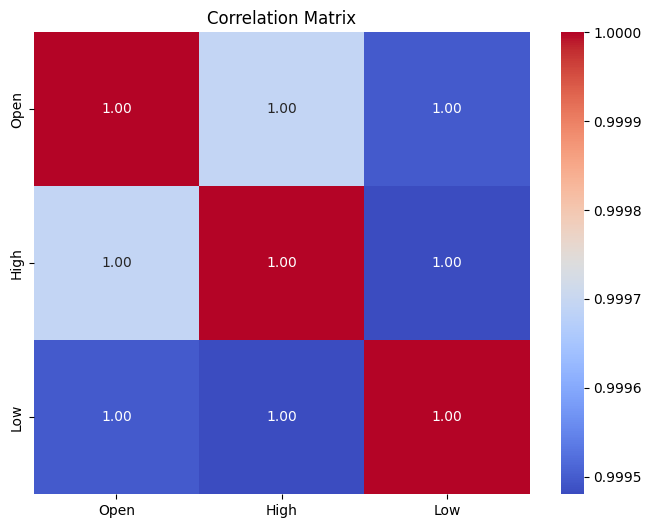

Number of observations before augmentation: 1253
Number of observations after augmentation: 2506


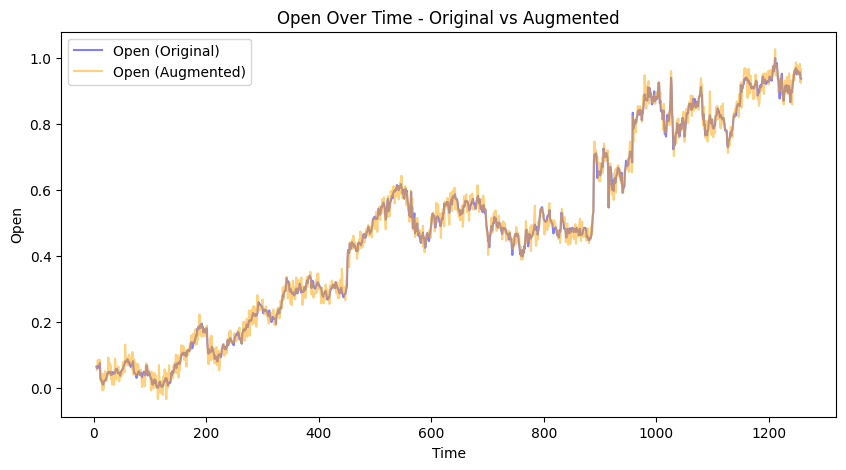

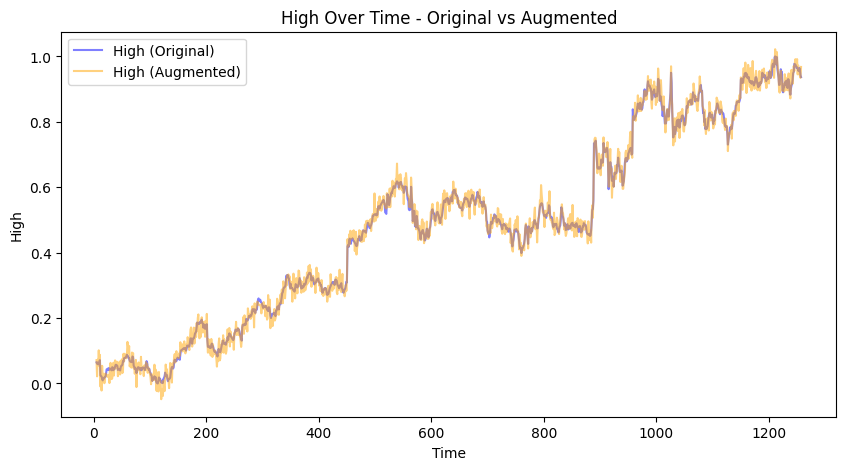

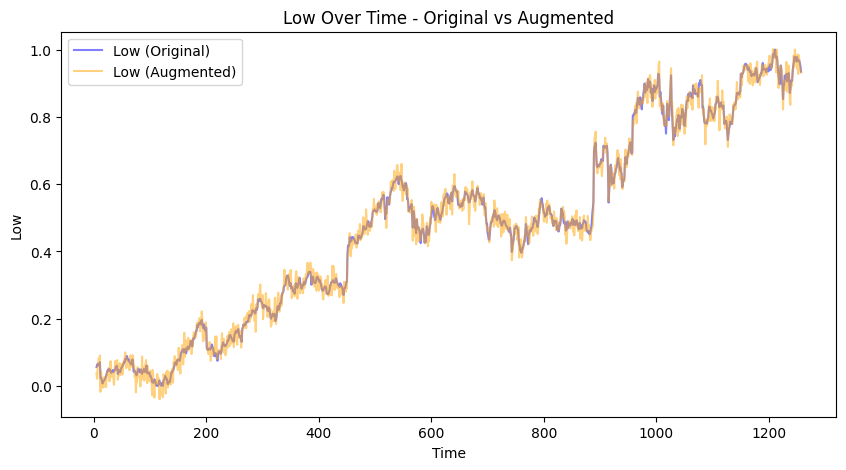

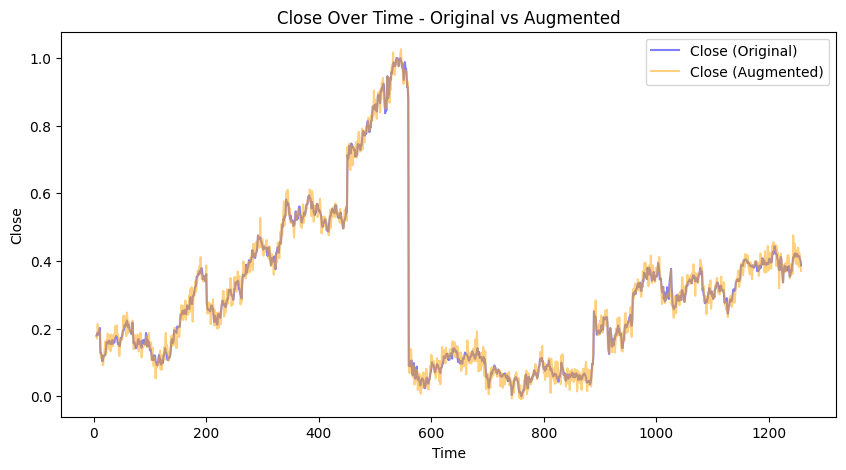

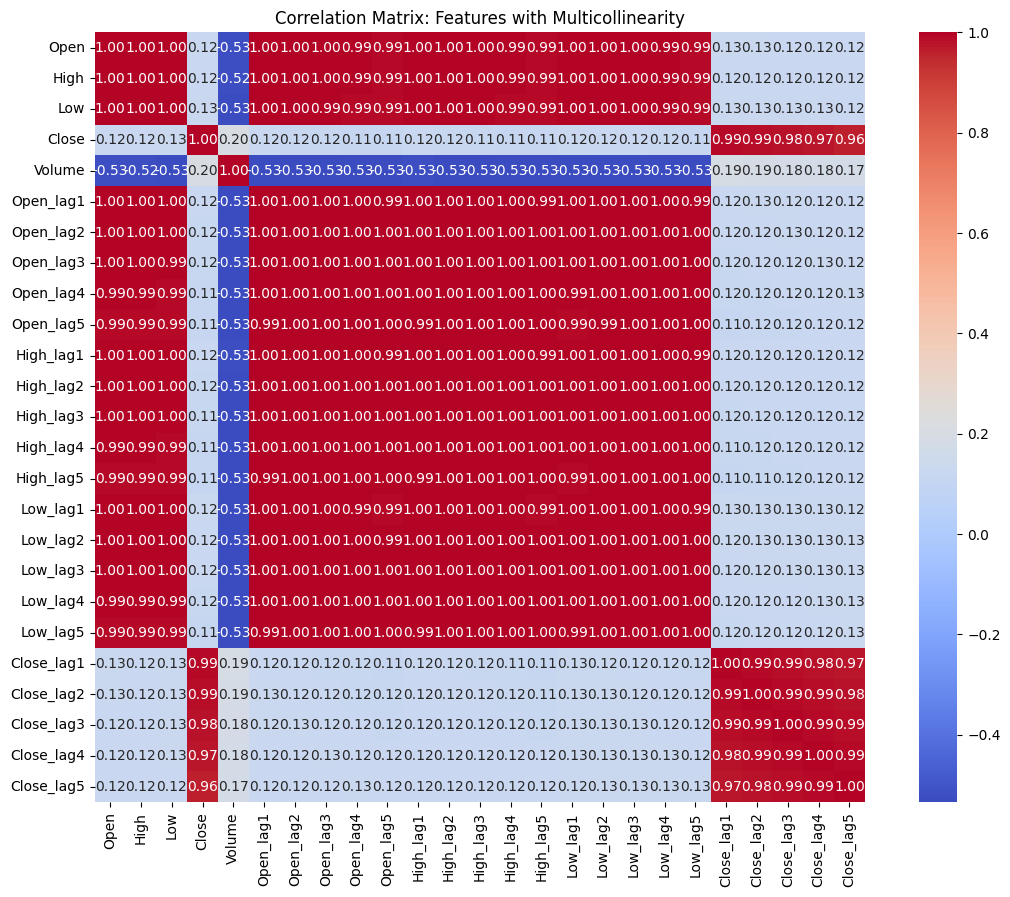

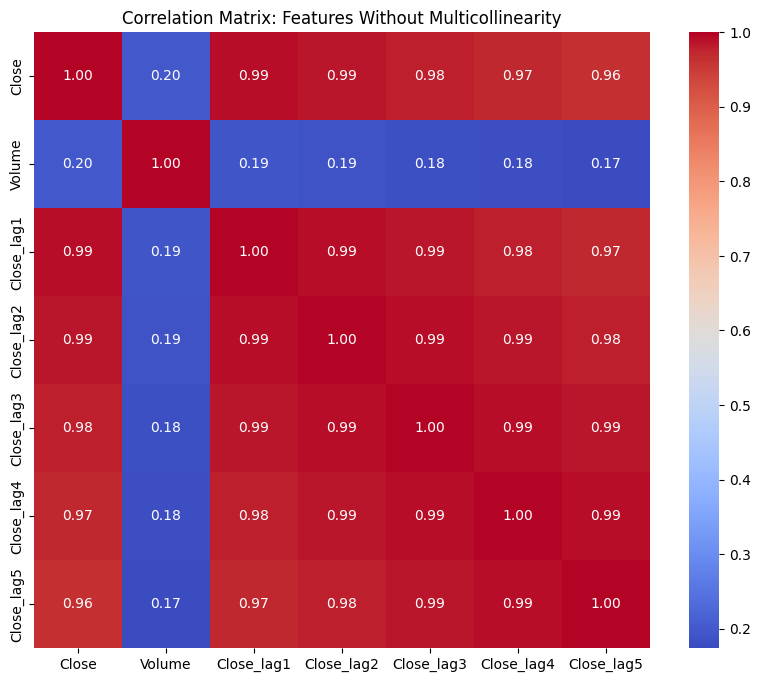

Train split shape: (1879, 29)
Validation split shape: (627, 29)


In [ ]:
# ----------------- File Path Loading -----------------
# Import required libraries
from google.colab import drive
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Step 2: Define file paths
root_dir = '/content/drive/My Drive/RNNs For Stock Prediction - 1906525'
data_dir = os.path.join(root_dir, 'data')
train_file_path = os.path.join(data_dir, 'Google_Stock_Price_Train.csv')
test_file_path = os.path.join(data_dir, 'Google_Stock_Price_Test.csv')

# Step 3: Load the CSV files using pandas
train_data = pd.read_csv(train_file_path)
test_data = pd.read_csv(test_file_path)

# Display dataset shapes
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

# ----------------- Exploratory Data Analysis (EDA) -----------------
# Basic statistics and data types
print("Train Data Info:\n")
print(train_data.info())
print("\nTrain Data Description:\n")
print(train_data.describe())

# Checking correlations between numeric columns
correlation_matrix = train_data[['Open', 'High', 'Low']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


# ----------------- Preprocessing and Visualizations -----------------
# ----------------- Data Cleaning -----------------
# Check if 'Close' and 'Volume' columns are strings, convert them if necessary
for col in ['Close', 'Volume']:
    if train_data[col].dtype != 'object':  # Ensure the column is treated as string
        train_data[col] = train_data[col].astype(str)
    if test_data[col].dtype != 'object':  # Ensure the column is treated as string
        test_data[col] = test_data[col].astype(str)

    # Remove commas and convert to float
    train_data[col] = train_data[col].str.replace(',', '').astype(float)
    test_data[col] = test_data[col].str.replace(',', '').astype(float)


# Convert Date column to datetime
train_data['Date'] = pd.to_datetime(train_data['Date'])
test_data['Date'] = pd.to_datetime(test_data['Date'])

# ----------------- Feature Engineering -----------------
# Create lag features for temporal dependencies
for lag in range(1, 6):  # Create 5 lag features
    for col in ['Open', 'High', 'Low', 'Close']:
        train_data[f'{col}_lag{lag}'] = train_data[col].shift(lag)
        test_data[f'{col}_lag{lag}'] = test_data[col].shift(lag)

# Create additional temporal features
train_data['Day'] = train_data['Date'].dt.day
train_data['Month'] = train_data['Date'].dt.month
train_data['Weekday'] = train_data['Date'].dt.weekday

test_data['Day'] = test_data['Date'].dt.day
test_data['Month'] = test_data['Date'].dt.month
test_data['Weekday'] = test_data['Date'].dt.weekday

# Drop rows with NaN values after lag feature creation
train_data.dropna(inplace=True)
test_data.dropna(inplace=True)

# ----------------- Scaling -----------------
scaler = MinMaxScaler()
scaled_columns = ['Open', 'High', 'Low', 'Close', 'Volume'] + \
                 [f'{col}_lag{lag}' for col in ['Open', 'High', 'Low', 'Close'] for lag in range(1, 6)]

train_data[scaled_columns] = scaler.fit_transform(train_data[scaled_columns])
test_data[scaled_columns] = scaler.transform(test_data[scaled_columns])



# ----------------- Data Augmentation -----------------
# Add Gaussian noise to augment the training data
noise_factor = 0.02
noise_data = train_data.copy()
for col in ['Open', 'High', 'Low', 'Close']:
    noise_data[col] += noise_factor * np.random.randn(len(noise_data[col]))

augmented_train_data = pd.concat([train_data, noise_data], ignore_index=True)

# Show number of observations before and after augmentation
print("Number of observations before augmentation:", train_data.shape[0])
print("Number of observations after augmentation:", augmented_train_data.shape[0])

# ----------------- Visualization of Preprocessed Data -----------------
# Visualization for augmented and original features
for feature in ['Open', 'High', 'Low', 'Close']:
    plt.figure(figsize=(10, 5))
    plt.plot(train_data[feature], label=f'{feature} (Original)', color='blue', alpha=0.5)
    plt.plot(noise_data[feature], label=f'{feature} (Augmented)', color='orange', alpha=0.5)
    plt.title(f'{feature} Over Time - Original vs Augmented')
    plt.xlabel('Time')
    plt.ylabel(feature)
    plt.legend()
    plt.show()

# ----------------- Multicollinearity Demonstration -----------------

# Original feature set (with multicollinearity)
features_with_multicollinearity = ['Open', 'High', 'Low', 'Close', 'Volume'] + \
    [f'{col}_lag{i}' for col in ['Open', 'High', 'Low', 'Close'] for i in range(1, 6)]

# Reduced feature set (without multicollinearity)
features_without_multicollinearity = ['Close', 'Volume'] + [f'Close_lag{i}' for i in range(1, 6)]

# Correlation matrix for the original feature set
plt.figure(figsize=(14, 10))
sns.heatmap(
    train_data[features_with_multicollinearity].corr(),
    annot=True, cmap='coolwarm', fmt='.2f', cbar=True, square=True
)
plt.title("Correlation Matrix: Features with Multicollinearity")
plt.show()

# Correlation matrix for the reduced feature set
plt.figure(figsize=(10, 8))
sns.heatmap(
    train_data[features_without_multicollinearity].corr(),
    annot=True, cmap='coolwarm', fmt='.2f', cbar=True, square=True
)
plt.title("Correlation Matrix: Features Without Multicollinearity")
plt.show()

# Save both feature sets to demonstrate in separate cleaned files (optional)
train_data_with_multicollinearity = train_data[features_with_multicollinearity].copy()
train_data_without_multicollinearity = train_data[features_without_multicollinearity].copy()

cleaned_feature_dir = os.path.join(data_dir, 'feature_sets')
os.makedirs(cleaned_feature_dir, exist_ok=True)

train_data_with_multicollinearity.to_csv(
    os.path.join(cleaned_feature_dir, 'train_with_multicollinearity.csv'), index=False
)
train_data_without_multicollinearity.to_csv(
    os.path.join(cleaned_feature_dir, 'train_without_multicollinearity.csv'), index=False
)


# ----------------- Train-Validation Split -----------------
# Split training data into train and validation sets
train, validation = train_test_split(augmented_train_data, test_size=0.25, shuffle=False)

print("Train split shape:", train.shape)
print("Validation split shape:", validation.shape)

# ----------------- Save Cleaned and Split Data -----------------
cleaned_data_dir = os.path.join(data_dir, 'cleaned')
os.makedirs(cleaned_data_dir, exist_ok=True)

train.to_csv(os.path.join(cleaned_data_dir, 'train_cleaned.csv'), index=False)
validation.to_csv(os.path.join(cleaned_data_dir, 'validation_cleaned.csv'), index=False)
test_data.to_csv(os.path.join(cleaned_data_dir, 'test_cleaned.csv'), index=False)

1) Vanilla RNN Model.

Mounted at /content/drive
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 4s - 60ms/step - loss: 0.0962 - mae: 0.0962 - val_loss: 0.0195 - val_mae: 0.0195 - learning_rate: 0.0010
Epoch 2/10
59/59 - 0s - 5ms/step - loss: 0.0396 - mae: 0.0396 - val_loss: 0.0261 - val_mae: 0.0261 - learning_rate: 9.7555e-04
Epoch 3/10
59/59 - 0s - 4ms/step - loss: 0.0326 - mae: 0.0326 - val_loss: 0.0162 - val_mae: 0.0162 - learning_rate: 8.8249e-04
Epoch 4/10
59/59 - 0s - 6ms/step - loss: 0.0307 - mae: 0.0307 - val_loss: 0.0202 - val_mae: 0.0202 - learning_rate: 7.0081e-04
Epoch 5/10
59/59 - 0s - 6ms/step - loss: 0.0284 - mae: 0.0284 - val_loss: 0.0160 - val_mae: 0.0160 - learning_rate: 4.5903e-04
Epoch 6/10
59/59 - 1s - 10ms/step - loss: 0.0273 - mae: 0.0273 - val_loss: 0.0151 - val_mae: 0.0151 - learning_rate: 2.3002e-04
Epoch 7/10
59/59 - 0s - 6ms/step - loss: 0.0266 - mae: 0.0266 - val_loss: 0.0151 - val_mae: 0.0151 - learning_rate: 8.0123e-05
Epoch 8/10
59/59 - 1s - 10ms/step - loss: 0.0259 - mae: 0.0259 - val_loss: 0.0148 - val_mae: 0.0148 - learning_rate: 1.7308e

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 10s - 161ms/step - loss: 0.0697 - mae: 0.0697 - val_loss: 0.0184 - val_mae: 0.0184 - learning_rate: 0.0010
Epoch 2/20
59/59 - 0s - 7ms/step - loss: 0.0366 - mae: 0.0366 - val_loss: 0.0166 - val_mae: 0.0166 - learning_rate: 9.9385e-04
Epoch 3/20
59/59 - 1s - 14ms/step - loss: 0.0307 - mae: 0.0307 - val_loss: 0.0240 - val_mae: 0.0240 - learning_rate: 9.6955e-04
Epoch 4/20
59/59 - 1s - 16ms/step - loss: 0.0282 - mae: 0.0282 - val_loss: 0.0267 - val_mae: 0.0267 - learning_rate: 9.1677e-04
Epoch 5/20
59/59 - 0s - 4ms/step - loss: 0.0255 - mae: 0.0255 - val_loss: 0.0301 - val_mae: 0.0301 - learning_rate: 8.2932e-04
Epoch 6/20
59/59 - 0s - 5ms/step - loss: 0.0253 - mae: 0.0253 - val_loss: 0.0334 - val_mae: 0.0334 - learning_rate: 7.0802e-04
Epoch 7/20

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00011245916830375791.
59/59 - 0s - 5ms/step - loss: 0.0214 - mae: 0.0214 - val_loss: 0.0288 - val_mae: 0.0288 - learning_rate: 1.1246e-04
Epoch 8/20
59/59 - 0s - 4ms/step - loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 4s - 71ms/step - loss: 0.0822 - mae: 0.0822 - val_loss: 0.0315 - val_mae: 0.0315 - learning_rate: 0.0010
Epoch 2/30
59/59 - 1s - 15ms/step - loss: 0.0349 - mae: 0.0349 - val_loss: 0.0212 - val_mae: 0.0212 - learning_rate: 9.9726e-04
Epoch 3/30
59/59 - 1s - 10ms/step - loss: 0.0276 - mae: 0.0276 - val_loss: 0.0230 - val_mae: 0.0230 - learning_rate: 9.8638e-04
Epoch 4/30
59/59 - 0s - 8ms/step - loss: 0.0270 - mae: 0.0270 - val_loss: 0.0442 - val_mae: 0.0442 - learning_rate: 9.6226e-04
Epoch 5/30
59/59 - 1s - 10ms/step - loss: 0.0244 - mae: 0.0244 - val_loss: 0.0367 - val_mae: 0.0367 - learning_rate: 9.2071e-04
Epoch 6/30
59/59 - 0s - 8ms/step - loss: 0.0240 - mae: 0.0240 - val_loss: 0.0291 - val_mae: 0.0291 - learning_rate: 8.5910e-04
Epoch 7/30

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00015543221961706878.
59/59 - 0s - 5ms/step - loss: 0.0208 - mae: 0.0208 - val_loss: 0.0467 - val_mae: 0.0467 - learning_rate: 1.5543e-04
Epoch 8/30
59/59 - 0s - 5ms/step - loss: 0.0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/40
59/59 - 5s - 93ms/step - loss: 0.0764 - mae: 0.0764 - val_loss: 0.0201 - val_mae: 0.0201 - learning_rate: 0.0010
Epoch 2/40
59/59 - 1s - 10ms/step - loss: 0.0395 - mae: 0.0395 - val_loss: 0.0245 - val_mae: 0.0245 - learning_rate: 9.9846e-04
Epoch 3/40
59/59 - 1s - 10ms/step - loss: 0.0330 - mae: 0.0330 - val_loss: 0.0253 - val_mae: 0.0253 - learning_rate: 9.9232e-04
Epoch 4/40
59/59 - 1s - 10ms/step - loss: 0.0287 - mae: 0.0287 - val_loss: 0.0331 - val_mae: 0.0331 - learning_rate: 9.7862e-04
Epoch 5/40
59/59 - 1s - 12ms/step - loss: 0.0283 - mae: 0.0283 - val_loss: 0.0311 - val_mae: 0.0311 - learning_rate: 9.5470e-04
Epoch 6/40

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0001836805371567607.
59/59 - 1s - 10ms/step - loss: 0.0243 - mae: 0.0243 - val_loss: 0.0333 - val_mae: 0.0333 - learning_rate: 1.8368e-04
Epoch 7/40
59/59 - 1s - 10ms/step - loss: 0.0214 - mae: 0.0214 - val_loss: 0.0333 - val_mae: 0.0333 - learning_rate: 1.7373e-04
Epoch 8/40
59/59 - 0s - 8ms/ste

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 3s - 57ms/step - loss: 0.0941 - mae: 0.0941 - val_loss: 0.0173 - val_mae: 0.0173 - learning_rate: 0.0010
Epoch 2/50
59/59 - 0s - 4ms/step - loss: 0.0371 - mae: 0.0371 - val_loss: 0.0156 - val_mae: 0.0156 - learning_rate: 9.9901e-04
Epoch 3/50
59/59 - 0s - 5ms/step - loss: 0.0301 - mae: 0.0301 - val_loss: 0.0272 - val_mae: 0.0272 - learning_rate: 9.9508e-04
Epoch 4/50
59/59 - 1s - 10ms/step - loss: 0.0270 - mae: 0.0270 - val_loss: 0.0235 - val_mae: 0.0235 - learning_rate: 9.8628e-04
Epoch 5/50
59/59 - 0s - 5ms/step - loss: 0.0264 - mae: 0.0264 - val_loss: 0.0261 - val_mae: 0.0261 - learning_rate: 9.7080e-04
Epoch 6/50
59/59 - 0s - 5ms/step - loss: 0.0237 - mae: 0.0237 - val_loss: 0.0235 - val_mae: 0.0235 - learning_rate: 9.4707e-04
Epoch 7/50

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00018276956398040057.
59/59 - 1s - 11ms/step - loss: 0.0216 - mae: 0.0216 - val_loss: 0.0310 - val_mae: 0.0310 - learning_rate: 1.8277e-04
Epoch 8/50
59/59 - 0s - 5ms/step - loss: 0.02

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 5s - 88ms/step - loss: 0.0680 - mae: 0.0680 - val_loss: 0.0202 - val_mae: 0.0202 - learning_rate: 0.0010
Epoch 2/100
59/59 - 1s - 12ms/step - loss: 0.0371 - mae: 0.0371 - val_loss: 0.0185 - val_mae: 0.0185 - learning_rate: 9.9975e-04
Epoch 3/100
59/59 - 1s - 10ms/step - loss: 0.0304 - mae: 0.0304 - val_loss: 0.0146 - val_mae: 0.0146 - learning_rate: 9.9877e-04
Epoch 4/100
59/59 - 0s - 5ms/step - loss: 0.0292 - mae: 0.0292 - val_loss: 0.0298 - val_mae: 0.0298 - learning_rate: 9.9655e-04
Epoch 5/100
59/59 - 0s - 4ms/step - loss: 0.0255 - mae: 0.0255 - val_loss: 0.0186 - val_mae: 0.0186 - learning_rate: 9.9263e-04
Epoch 6/100
59/59 - 0s - 5ms/step - loss: 0.0230 - mae: 0.0230 - val_loss: 0.0272 - val_mae: 0.0272 - learning_rate: 9.8652e-04
Epoch 7/100
59/59 - 0s - 5ms/step - loss: 0.0219 - mae: 0.0219 - val_loss: 0.0144 - val_mae: 0.0144 - learning_rate: 9.7780e-04
Epoch 8/100
59/59 - 0s - 5ms/step - loss: 0.0221 - mae: 0.0221 - val_loss: 0.0243 - val_mae: 0.0243 - learning_rate: 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 4s - 69ms/step - loss: 0.0945 - mae: 0.0945 - val_loss: 0.0215 - val_mae: 0.0215 - learning_rate: 0.0010
Epoch 2/10
59/59 - 1s - 15ms/step - loss: 0.0347 - mae: 0.0347 - val_loss: 0.0203 - val_mae: 0.0203 - learning_rate: 9.7555e-04
Epoch 3/10
59/59 - 1s - 10ms/step - loss: 0.0319 - mae: 0.0319 - val_loss: 0.0210 - val_mae: 0.0210 - learning_rate: 8.8249e-04
Epoch 4/10
59/59 - 0s - 6ms/step - loss: 0.0281 - mae: 0.0281 - val_loss: 0.0212 - val_mae: 0.0212 - learning_rate: 7.0081e-04
Epoch 5/10
59/59 - 1s - 9ms/step - loss: 0.0267 - mae: 0.0267 - val_loss: 0.0235 - val_mae: 0.0235 - learning_rate: 4.5903e-04
Epoch 6/10
59/59 - 0s - 4ms/step - loss: 0.0257 - mae: 0.0257 - val_loss: 0.0231 - val_mae: 0.0231 - learning_rate: 2.3002e-04
Epoch 7/10

Epoch 7: ReduceLROnPlateau reducing learning rate to 1.60245894221589e-05.
59/59 - 0s - 5ms/step - loss: 0.0247 - mae: 0.0247 - val_loss: 0.0239 - val_mae: 0.0239 - learning_rate: 1.6025e-05
Epoch 8/10
59/59 - 0s - 4ms/step - loss: 0.0249

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 3s - 53ms/step - loss: 0.1132 - mae: 0.1132 - val_loss: 0.0174 - val_mae: 0.0174 - learning_rate: 0.0010
Epoch 2/20
59/59 - 0s - 5ms/step - loss: 0.0405 - mae: 0.0405 - val_loss: 0.0194 - val_mae: 0.0194 - learning_rate: 9.9385e-04
Epoch 3/20
59/59 - 0s - 5ms/step - loss: 0.0353 - mae: 0.0353 - val_loss: 0.0215 - val_mae: 0.0215 - learning_rate: 9.6955e-04
Epoch 4/20
59/59 - 0s - 5ms/step - loss: 0.0329 - mae: 0.0329 - val_loss: 0.0204 - val_mae: 0.0204 - learning_rate: 9.1677e-04
Epoch 5/20
59/59 - 0s - 4ms/step - loss: 0.0290 - mae: 0.0290 - val_loss: 0.0250 - val_mae: 0.0250 - learning_rate: 8.2932e-04
Epoch 6/20

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00014160346472635865.
59/59 - 0s - 4ms/step - loss: 0.0293 - mae: 0.0293 - val_loss: 0.0259 - val_mae: 0.0259 - learning_rate: 1.4160e-04
Epoch 7/20
59/59 - 0s - 4ms/step - loss: 0.0246 - mae: 0.0246 - val_loss: 0.0232 - val_mae: 0.0232 - learning_rate: 1.1262e-04
Epoch 8/20
59/59 - 0s - 4ms/step - loss: 0.0249

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 5s - 77ms/step - loss: 0.0957 - mae: 0.0957 - val_loss: 0.0250 - val_mae: 0.0250 - learning_rate: 0.0010
Epoch 2/30
59/59 - 1s - 11ms/step - loss: 0.0374 - mae: 0.0374 - val_loss: 0.0282 - val_mae: 0.0282 - learning_rate: 9.9726e-04
Epoch 3/30
59/59 - 0s - 5ms/step - loss: 0.0347 - mae: 0.0347 - val_loss: 0.0274 - val_mae: 0.0274 - learning_rate: 9.8638e-04
Epoch 4/30
59/59 - 0s - 4ms/step - loss: 0.0301 - mae: 0.0301 - val_loss: 0.0409 - val_mae: 0.0409 - learning_rate: 9.6226e-04
Epoch 5/30
59/59 - 0s - 5ms/step - loss: 0.0292 - mae: 0.0292 - val_loss: 0.0189 - val_mae: 0.0189 - learning_rate: 9.2071e-04
Epoch 6/30
59/59 - 0s - 4ms/step - loss: 0.0257 - mae: 0.0257 - val_loss: 0.0270 - val_mae: 0.0270 - learning_rate: 8.5910e-04
Epoch 7/30
59/59 - 0s - 5ms/step - loss: 0.0228 - mae: 0.0228 - val_loss: 0.0226 - val_mae: 0.0226 - learning_rate: 7.7716e-04
Epoch 8/30
59/59 - 0s - 5ms/step - loss: 0.0215 - mae: 0.0215 - val_loss: 0.0327 - val_mae: 0.0327 - learning_rate: 6.7748e-

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 3s - 52ms/step - loss: 0.1003 - mae: 0.1003 - val_loss: 0.0305 - val_mae: 0.0305 - learning_rate: 0.0010
Epoch 2/40
59/59 - 0s - 5ms/step - loss: 0.0387 - mae: 0.0387 - val_loss: 0.0215 - val_mae: 0.0215 - learning_rate: 9.9846e-04
Epoch 3/40
59/59 - 0s - 5ms/step - loss: 0.0323 - mae: 0.0323 - val_loss: 0.0211 - val_mae: 0.0211 - learning_rate: 9.9232e-04
Epoch 4/40
59/59 - 0s - 5ms/step - loss: 0.0291 - mae: 0.0291 - val_loss: 0.0244 - val_mae: 0.0244 - learning_rate: 9.7862e-04
Epoch 5/40
59/59 - 0s - 4ms/step - loss: 0.0274 - mae: 0.0274 - val_loss: 0.0215 - val_mae: 0.0215 - learning_rate: 9.5470e-04
Epoch 6/40
59/59 - 0s - 4ms/step - loss: 0.0258 - mae: 0.0258 - val_loss: 0.0223 - val_mae: 0.0223 - learning_rate: 9.1840e-04
Epoch 7/40
59/59 - 0s - 7ms/step - loss: 0.0249 - mae: 0.0249 - val_loss: 0.0251 - val_mae: 0.0251 - learning_rate: 8.6841e-04
Epoch 8/40
59/59 - 0s - 6ms/step - loss: 0.0218 - mae: 0.0218 - val_loss: 0.0162 - val_mae: 0.0162 - learning_rate: 8.0450e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 3s - 56ms/step - loss: 0.1087 - mae: 0.1087 - val_loss: 0.0247 - val_mae: 0.0247 - learning_rate: 0.0010
Epoch 2/50
59/59 - 0s - 5ms/step - loss: 0.0367 - mae: 0.0367 - val_loss: 0.0242 - val_mae: 0.0242 - learning_rate: 9.9901e-04
Epoch 3/50
59/59 - 0s - 5ms/step - loss: 0.0332 - mae: 0.0332 - val_loss: 0.0195 - val_mae: 0.0195 - learning_rate: 9.9508e-04
Epoch 4/50
59/59 - 0s - 4ms/step - loss: 0.0307 - mae: 0.0307 - val_loss: 0.0219 - val_mae: 0.0219 - learning_rate: 9.8628e-04
Epoch 5/50
59/59 - 0s - 4ms/step - loss: 0.0279 - mae: 0.0279 - val_loss: 0.0212 - val_mae: 0.0212 - learning_rate: 9.7080e-04
Epoch 6/50
59/59 - 0s - 5ms/step - loss: 0.0253 - mae: 0.0253 - val_loss: 0.0227 - val_mae: 0.0227 - learning_rate: 9.4707e-04
Epoch 7/50
59/59 - 0s - 5ms/step - loss: 0.0252 - mae: 0.0252 - val_loss: 0.0286 - val_mae: 0.0286 - learning_rate: 9.1385e-04
Epoch 8/50
59/59 - 0s - 4ms/step - loss: 0.0239 - mae: 0.0239 - val_loss: 0.0167 - val_mae: 0.0167 - learning_rate: 8.7041e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 3s - 56ms/step - loss: 0.1023 - mae: 0.1023 - val_loss: 0.0248 - val_mae: 0.0248 - learning_rate: 0.0010
Epoch 2/100
59/59 - 0s - 4ms/step - loss: 0.0417 - mae: 0.0417 - val_loss: 0.0220 - val_mae: 0.0220 - learning_rate: 9.9975e-04
Epoch 3/100
59/59 - 0s - 5ms/step - loss: 0.0352 - mae: 0.0352 - val_loss: 0.0246 - val_mae: 0.0246 - learning_rate: 9.9877e-04
Epoch 4/100
59/59 - 0s - 4ms/step - loss: 0.0325 - mae: 0.0325 - val_loss: 0.0154 - val_mae: 0.0154 - learning_rate: 9.9655e-04
Epoch 5/100
59/59 - 0s - 4ms/step - loss: 0.0291 - mae: 0.0291 - val_loss: 0.0162 - val_mae: 0.0162 - learning_rate: 9.9263e-04
Epoch 6/100
59/59 - 0s - 4ms/step - loss: 0.0269 - mae: 0.0269 - val_loss: 0.0188 - val_mae: 0.0188 - learning_rate: 9.8652e-04
Epoch 7/100
59/59 - 0s - 5ms/step - loss: 0.0245 - mae: 0.0245 - val_loss: 0.0182 - val_mae: 0.0182 - learning_rate: 9.7780e-04
Epoch 8/100
59/59 - 0s - 5ms/step - loss: 0.0232 - mae: 0.0232 - val_loss: 0.0162 - val_mae: 0.0162 - learning_rate: 9.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 5s - 88ms/step - loss: 0.0577 - mae: 0.0577 - val_loss: 0.0391 - val_mae: 0.0391 - learning_rate: 0.0010
Epoch 2/10
59/59 - 1s - 12ms/step - loss: 0.0358 - mae: 0.0358 - val_loss: 0.0457 - val_mae: 0.0457 - learning_rate: 9.7555e-04
Epoch 3/10
59/59 - 0s - 5ms/step - loss: 0.0304 - mae: 0.0304 - val_loss: 0.0566 - val_mae: 0.0566 - learning_rate: 8.8249e-04
Epoch 4/10
59/59 - 0s - 5ms/step - loss: 0.0250 - mae: 0.0250 - val_loss: 0.0643 - val_mae: 0.0643 - learning_rate: 7.0081e-04
Epoch 5/10
59/59 - 0s - 4ms/step - loss: 0.0215 - mae: 0.0215 - val_loss: 0.0555 - val_mae: 0.0555 - learning_rate: 4.5903e-04
Epoch 6/10

Epoch 6: ReduceLROnPlateau reducing learning rate to 4.600312095135451e-05.
59/59 - 0s - 6ms/step - loss: 0.0217 - mae: 0.0217 - val_loss: 0.0600 - val_mae: 0.0600 - learning_rate: 4.6003e-05
Epoch 7/10
59/59 - 0s - 5ms/step - loss: 0.0205 - mae: 0.0205 - val_loss: 0.0589 - val_mae: 0.0589 - learning_rate: 1.6548e-05
Epoch 8/10
59/59 - 0s - 4ms/step - loss: 0.0206

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 3s - 51ms/step - loss: 0.1015 - mae: 0.1015 - val_loss: 0.0440 - val_mae: 0.0440 - learning_rate: 0.0010
Epoch 2/20
59/59 - 0s - 4ms/step - loss: 0.0462 - mae: 0.0462 - val_loss: 0.0588 - val_mae: 0.0588 - learning_rate: 9.9385e-04
Epoch 3/20
59/59 - 0s - 4ms/step - loss: 0.0343 - mae: 0.0343 - val_loss: 0.0619 - val_mae: 0.0619 - learning_rate: 9.6955e-04
Epoch 4/20
59/59 - 0s - 4ms/step - loss: 0.0306 - mae: 0.0306 - val_loss: 0.0674 - val_mae: 0.0674 - learning_rate: 9.1677e-04
Epoch 5/20
59/59 - 0s - 5ms/step - loss: 0.0280 - mae: 0.0280 - val_loss: 0.0603 - val_mae: 0.0603 - learning_rate: 8.2932e-04
Epoch 6/20

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00014160346472635865.
59/59 - 0s - 4ms/step - loss: 0.0240 - mae: 0.0240 - val_loss: 0.0467 - val_mae: 0.0467 - learning_rate: 1.4160e-04
Epoch 7/20
59/59 - 0s - 5ms/step - loss: 0.0227 - mae: 0.0227 - val_loss: 0.0547 - val_mae: 0.0547 - learning_rate: 1.1262e-04
Epoch 8/20
59/59 - 0s - 4ms/step - loss: 0.0214

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 4s - 69ms/step - loss: 0.0875 - mae: 0.0875 - val_loss: 0.0151 - val_mae: 0.0151 - learning_rate: 0.0010
Epoch 2/30
59/59 - 0s - 5ms/step - loss: 0.0428 - mae: 0.0428 - val_loss: 0.0227 - val_mae: 0.0227 - learning_rate: 9.9726e-04
Epoch 3/30
59/59 - 0s - 4ms/step - loss: 0.0356 - mae: 0.0356 - val_loss: 0.0221 - val_mae: 0.0221 - learning_rate: 9.8638e-04
Epoch 4/30
59/59 - 0s - 4ms/step - loss: 0.0296 - mae: 0.0296 - val_loss: 0.0257 - val_mae: 0.0257 - learning_rate: 9.6226e-04
Epoch 5/30
59/59 - 0s - 4ms/step - loss: 0.0282 - mae: 0.0282 - val_loss: 0.0396 - val_mae: 0.0396 - learning_rate: 9.2071e-04
Epoch 6/30

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00017182051669806242.
59/59 - 0s - 5ms/step - loss: 0.0250 - mae: 0.0250 - val_loss: 0.0382 - val_mae: 0.0382 - learning_rate: 1.7182e-04
Epoch 7/30
59/59 - 0s - 5ms/step - loss: 0.0228 - mae: 0.0228 - val_loss: 0.0425 - val_mae: 0.0425 - learning_rate: 1.5551e-04
Epoch 8/30
59/59 - 0s - 5ms/step - loss: 0.0227

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 3s - 52ms/step - loss: 0.0846 - mae: 0.0846 - val_loss: 0.0181 - val_mae: 0.0181 - learning_rate: 0.0010
Epoch 2/40
59/59 - 0s - 4ms/step - loss: 0.0494 - mae: 0.0494 - val_loss: 0.0221 - val_mae: 0.0221 - learning_rate: 9.9846e-04
Epoch 3/40
59/59 - 0s - 4ms/step - loss: 0.0386 - mae: 0.0386 - val_loss: 0.0276 - val_mae: 0.0276 - learning_rate: 9.9232e-04
Epoch 4/40
59/59 - 0s - 4ms/step - loss: 0.0325 - mae: 0.0325 - val_loss: 0.0413 - val_mae: 0.0413 - learning_rate: 9.7862e-04
Epoch 5/40
59/59 - 0s - 5ms/step - loss: 0.0275 - mae: 0.0275 - val_loss: 0.0501 - val_mae: 0.0501 - learning_rate: 9.5470e-04
Epoch 6/40

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0001836805371567607.
59/59 - 0s - 4ms/step - loss: 0.0250 - mae: 0.0250 - val_loss: 0.0396 - val_mae: 0.0396 - learning_rate: 1.8368e-04
Epoch 7/40
59/59 - 0s - 5ms/step - loss: 0.0211 - mae: 0.0211 - val_loss: 0.0490 - val_mae: 0.0490 - learning_rate: 1.7373e-04
Epoch 8/40
59/59 - 0s - 5ms/step - loss: 0.0207 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
59/59 - 4s - 64ms/step - loss: 0.0645 - mae: 0.0645 - val_loss: 0.0185 - val_mae: 0.0185 - learning_rate: 0.0010
Epoch 2/50
59/59 - 0s - 4ms/step - loss: 0.0395 - mae: 0.0395 - val_loss: 0.0420 - val_mae: 0.0420 - learning_rate: 9.9901e-04
Epoch 3/50
59/59 - 0s - 4ms/step - loss: 0.0325 - mae: 0.0325 - val_loss: 0.0611 - val_mae: 0.0611 - learning_rate: 9.9508e-04
Epoch 4/50
59/59 - 0s - 5ms/step - loss: 0.0267 - mae: 0.0267 - val_loss: 0.0535 - val_mae: 0.0535 - learning_rate: 9.8628e-04
Epoch 5/50
59/59 - 0s - 5ms/step - loss: 0.0226 - mae: 0.0226 - val_loss: 0.0552 - val_mae: 0.0552 - learning_rate: 9.7080e-04
Epoch 6/50

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00018941316520795228.
59/59 - 0s - 6ms/step - loss: 0.0206 - mae: 0.0206 - val_loss: 0.0550 - val_mae: 0.0550 - learning_rate: 1.8941e-04
Epoch 7/50
59/59 - 0s - 4ms/step - loss: 0.0191 - mae: 0.0191 - val_loss: 0.0555 - val_mae: 0.0555 - learning_rate: 1.8280e-04
Epoch 8/50
59/59 - 0s - 5ms/step - l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 3s - 53ms/step - loss: 0.0853 - mae: 0.0853 - val_loss: 0.0441 - val_mae: 0.0441 - learning_rate: 0.0010
Epoch 2/100
59/59 - 0s - 4ms/step - loss: 0.0448 - mae: 0.0448 - val_loss: 0.0552 - val_mae: 0.0552 - learning_rate: 9.9975e-04
Epoch 3/100
59/59 - 0s - 6ms/step - loss: 0.0346 - mae: 0.0346 - val_loss: 0.0460 - val_mae: 0.0460 - learning_rate: 9.9877e-04
Epoch 4/100
59/59 - 0s - 5ms/step - loss: 0.0276 - mae: 0.0276 - val_loss: 0.0529 - val_mae: 0.0529 - learning_rate: 9.9655e-04
Epoch 5/100
59/59 - 0s - 5ms/step - loss: 0.0264 - mae: 0.0264 - val_loss: 0.0535 - val_mae: 0.0535 - learning_rate: 9.9263e-04
Epoch 6/100

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00019730490166693928.
59/59 - 0s - 5ms/step - loss: 0.0229 - mae: 0.0229 - val_loss: 0.0528 - val_mae: 0.0528 - learning_rate: 1.9730e-04
Epoch 7/100
59/59 - 0s - 6ms/step - loss: 0.0211 - mae: 0.0211 - val_loss: 0.0569 - val_mae: 0.0569 - learning_rate: 1.9557e-04
Epoch 8/100
59/59 - 1s - 11ms/step - loss

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 3s - 52ms/step - loss: 0.0596 - mae: 0.0596 - val_loss: 0.0189 - val_mae: 0.0189 - learning_rate: 0.0010
Epoch 2/10
59/59 - 0s - 4ms/step - loss: 0.0301 - mae: 0.0301 - val_loss: 0.0159 - val_mae: 0.0159 - learning_rate: 9.7555e-04
Epoch 3/10
59/59 - 0s - 5ms/step - loss: 0.0255 - mae: 0.0255 - val_loss: 0.0127 - val_mae: 0.0127 - learning_rate: 8.8249e-04
Epoch 4/10
59/59 - 0s - 4ms/step - loss: 0.0227 - mae: 0.0227 - val_loss: 0.0089 - val_mae: 0.0089 - learning_rate: 7.0081e-04
Epoch 5/10
59/59 - 0s - 4ms/step - loss: 0.0203 - mae: 0.0203 - val_loss: 0.0103 - val_mae: 0.0103 - learning_rate: 4.5903e-04
Epoch 6/10
59/59 - 0s - 5ms/step - loss: 0.0188 - mae: 0.0188 - val_loss: 0.0078 - val_mae: 0.0078 - learning_rate: 2.3002e-04
Epoch 7/10
59/59 - 0s - 5ms/step - loss: 0.0181 - mae: 0.0181 - val_loss: 0.0079 - val_mae: 0.0079 - learning_rate: 8.0123e-05
Epoch 8/10
59/59 - 0s - 4ms/step - loss: 0.0185 - mae: 0.0185 - val_loss: 0.0075 - val_mae: 0.0075 - learning_rate: 1.7308e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 3s - 54ms/step - loss: 0.0580 - mae: 0.0580 - val_loss: 0.0182 - val_mae: 0.0182 - learning_rate: 0.0010
Epoch 2/20
59/59 - 0s - 7ms/step - loss: 0.0295 - mae: 0.0295 - val_loss: 0.0123 - val_mae: 0.0123 - learning_rate: 9.9385e-04
Epoch 3/20
59/59 - 0s - 7ms/step - loss: 0.0242 - mae: 0.0242 - val_loss: 0.0104 - val_mae: 0.0104 - learning_rate: 9.6955e-04
Epoch 4/20
59/59 - 0s - 6ms/step - loss: 0.0225 - mae: 0.0225 - val_loss: 0.0191 - val_mae: 0.0191 - learning_rate: 9.1677e-04
Epoch 5/20
59/59 - 0s - 7ms/step - loss: 0.0209 - mae: 0.0209 - val_loss: 0.0181 - val_mae: 0.0181 - learning_rate: 8.2932e-04
Epoch 6/20
59/59 - 1s - 10ms/step - loss: 0.0199 - mae: 0.0199 - val_loss: 0.0071 - val_mae: 0.0071 - learning_rate: 7.0802e-04
Epoch 7/20
59/59 - 0s - 6ms/step - loss: 0.0178 - mae: 0.0178 - val_loss: 0.0084 - val_mae: 0.0084 - learning_rate: 5.6230e-04
Epoch 8/20
59/59 - 1s - 11ms/step - loss: 0.0177 - mae: 0.0177 - val_loss: 0.0071 - val_mae: 0.0071 - learning_rate: 4.0906e

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 3s - 52ms/step - loss: 0.0654 - mae: 0.0654 - val_loss: 0.0166 - val_mae: 0.0166 - learning_rate: 0.0010
Epoch 2/30
59/59 - 0s - 5ms/step - loss: 0.0300 - mae: 0.0300 - val_loss: 0.0213 - val_mae: 0.0213 - learning_rate: 9.9726e-04
Epoch 3/30
59/59 - 0s - 4ms/step - loss: 0.0249 - mae: 0.0249 - val_loss: 0.0091 - val_mae: 0.0091 - learning_rate: 9.8638e-04
Epoch 4/30
59/59 - 0s - 4ms/step - loss: 0.0211 - mae: 0.0211 - val_loss: 0.0100 - val_mae: 0.0100 - learning_rate: 9.6226e-04
Epoch 5/30
59/59 - 0s - 5ms/step - loss: 0.0209 - mae: 0.0209 - val_loss: 0.0146 - val_mae: 0.0146 - learning_rate: 9.2071e-04
Epoch 6/30
59/59 - 0s - 6ms/step - loss: 0.0220 - mae: 0.0220 - val_loss: 0.0142 - val_mae: 0.0142 - learning_rate: 8.5910e-04
Epoch 7/30
59/59 - 0s - 4ms/step - loss: 0.0178 - mae: 0.0178 - val_loss: 0.0057 - val_mae: 0.0057 - learning_rate: 7.7716e-04
Epoch 8/30
59/59 - 0s - 5ms/step - loss: 0.0163 - mae: 0.0163 - val_loss: 0.0053 - val_mae: 0.0053 - learning_rate: 6.7748e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 3s - 50ms/step - loss: 0.0581 - mae: 0.0581 - val_loss: 0.0173 - val_mae: 0.0173 - learning_rate: 0.0010
Epoch 2/40
59/59 - 0s - 6ms/step - loss: 0.0308 - mae: 0.0308 - val_loss: 0.0134 - val_mae: 0.0134 - learning_rate: 9.9846e-04
Epoch 3/40
59/59 - 0s - 4ms/step - loss: 0.0262 - mae: 0.0262 - val_loss: 0.0127 - val_mae: 0.0127 - learning_rate: 9.9232e-04
Epoch 4/40
59/59 - 0s - 4ms/step - loss: 0.0231 - mae: 0.0231 - val_loss: 0.0099 - val_mae: 0.0099 - learning_rate: 9.7862e-04
Epoch 5/40
59/59 - 0s - 5ms/step - loss: 0.0203 - mae: 0.0203 - val_loss: 0.0111 - val_mae: 0.0111 - learning_rate: 9.5470e-04
Epoch 6/40
59/59 - 0s - 5ms/step - loss: 0.0188 - mae: 0.0188 - val_loss: 0.0100 - val_mae: 0.0100 - learning_rate: 9.1840e-04
Epoch 7/40
59/59 - 0s - 4ms/step - loss: 0.0180 - mae: 0.0180 - val_loss: 0.0072 - val_mae: 0.0072 - learning_rate: 8.6841e-04
Epoch 8/40
59/59 - 0s - 5ms/step - loss: 0.0167 - mae: 0.0167 - val_loss: 0.0052 - val_mae: 0.0052 - learning_rate: 8.0450e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 3s - 50ms/step - loss: 0.0664 - mae: 0.0664 - val_loss: 0.0298 - val_mae: 0.0298 - learning_rate: 0.0010
Epoch 2/50
59/59 - 0s - 8ms/step - loss: 0.0319 - mae: 0.0319 - val_loss: 0.0151 - val_mae: 0.0151 - learning_rate: 9.9901e-04
Epoch 3/50
59/59 - 0s - 7ms/step - loss: 0.0255 - mae: 0.0255 - val_loss: 0.0157 - val_mae: 0.0157 - learning_rate: 9.9508e-04
Epoch 4/50
59/59 - 1s - 10ms/step - loss: 0.0228 - mae: 0.0228 - val_loss: 0.0099 - val_mae: 0.0099 - learning_rate: 9.8628e-04
Epoch 5/50
59/59 - 1s - 10ms/step - loss: 0.0218 - mae: 0.0218 - val_loss: 0.0085 - val_mae: 0.0085 - learning_rate: 9.7080e-04
Epoch 6/50
59/59 - 1s - 11ms/step - loss: 0.0217 - mae: 0.0217 - val_loss: 0.0090 - val_mae: 0.0090 - learning_rate: 9.4707e-04
Epoch 7/50
59/59 - 1s - 11ms/step - loss: 0.0187 - mae: 0.0187 - val_loss: 0.0078 - val_mae: 0.0078 - learning_rate: 9.1385e-04
Epoch 8/50
59/59 - 1s - 9ms/step - loss: 0.0184 - mae: 0.0184 - val_loss: 0.0099 - val_mae: 0.0099 - learning_rate: 8.704

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 3s - 50ms/step - loss: 0.0583 - mae: 0.0583 - val_loss: 0.0161 - val_mae: 0.0161 - learning_rate: 0.0010
Epoch 2/100
59/59 - 0s - 4ms/step - loss: 0.0303 - mae: 0.0303 - val_loss: 0.0107 - val_mae: 0.0107 - learning_rate: 9.9975e-04
Epoch 3/100
59/59 - 0s - 5ms/step - loss: 0.0256 - mae: 0.0256 - val_loss: 0.0180 - val_mae: 0.0180 - learning_rate: 9.9877e-04
Epoch 4/100
59/59 - 0s - 6ms/step - loss: 0.0216 - mae: 0.0216 - val_loss: 0.0104 - val_mae: 0.0104 - learning_rate: 9.9655e-04
Epoch 5/100
59/59 - 0s - 4ms/step - loss: 0.0194 - mae: 0.0194 - val_loss: 0.0057 - val_mae: 0.0057 - learning_rate: 9.9263e-04
Epoch 6/100
59/59 - 0s - 4ms/step - loss: 0.0183 - mae: 0.0183 - val_loss: 0.0151 - val_mae: 0.0151 - learning_rate: 9.8652e-04
Epoch 7/100
59/59 - 0s - 6ms/step - loss: 0.0177 - mae: 0.0177 - val_loss: 0.0157 - val_mae: 0.0157 - learning_rate: 9.7780e-04
Epoch 8/100
59/59 - 0s - 5ms/step - loss: 0.0166 - mae: 0.0166 - val_loss: 0.0037 - val_mae: 0.0037 - learning_rate: 9.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 3s - 51ms/step - loss: 0.0772 - mae: 0.0772 - val_loss: 0.0217 - val_mae: 0.0217 - learning_rate: 0.0010
Epoch 2/10
59/59 - 0s - 6ms/step - loss: 0.0332 - mae: 0.0332 - val_loss: 0.0159 - val_mae: 0.0159 - learning_rate: 9.7555e-04
Epoch 3/10
59/59 - 1s - 11ms/step - loss: 0.0295 - mae: 0.0295 - val_loss: 0.0236 - val_mae: 0.0236 - learning_rate: 8.8249e-04
Epoch 4/10
59/59 - 1s - 11ms/step - loss: 0.0268 - mae: 0.0268 - val_loss: 0.0194 - val_mae: 0.0194 - learning_rate: 7.0081e-04
Epoch 5/10
59/59 - 1s - 10ms/step - loss: 0.0229 - mae: 0.0229 - val_loss: 0.0131 - val_mae: 0.0131 - learning_rate: 4.5903e-04
Epoch 6/10
59/59 - 1s - 11ms/step - loss: 0.0224 - mae: 0.0224 - val_loss: 0.0154 - val_mae: 0.0154 - learning_rate: 2.3002e-04
Epoch 7/10
59/59 - 0s - 7ms/step - loss: 0.0220 - mae: 0.0220 - val_loss: 0.0122 - val_mae: 0.0122 - learning_rate: 8.0123e-05
Epoch 8/10
59/59 - 1s - 10ms/step - loss: 0.0205 - mae: 0.0205 - val_loss: 0.0122 - val_mae: 0.0122 - learning_rate: 1.73

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 4s - 63ms/step - loss: 0.0732 - mae: 0.0732 - val_loss: 0.0185 - val_mae: 0.0185 - learning_rate: 0.0010
Epoch 2/20
59/59 - 0s - 5ms/step - loss: 0.0324 - mae: 0.0324 - val_loss: 0.0155 - val_mae: 0.0155 - learning_rate: 9.9385e-04
Epoch 3/20
59/59 - 0s - 5ms/step - loss: 0.0269 - mae: 0.0269 - val_loss: 0.0158 - val_mae: 0.0158 - learning_rate: 9.6955e-04
Epoch 4/20
59/59 - 1s - 11ms/step - loss: 0.0235 - mae: 0.0235 - val_loss: 0.0142 - val_mae: 0.0142 - learning_rate: 9.1677e-04
Epoch 5/20
59/59 - 0s - 5ms/step - loss: 0.0220 - mae: 0.0220 - val_loss: 0.0103 - val_mae: 0.0103 - learning_rate: 8.2932e-04
Epoch 6/20
59/59 - 0s - 6ms/step - loss: 0.0181 - mae: 0.0181 - val_loss: 0.0097 - val_mae: 0.0097 - learning_rate: 7.0802e-04
Epoch 7/20
59/59 - 0s - 5ms/step - loss: 0.0171 - mae: 0.0171 - val_loss: 0.0073 - val_mae: 0.0073 - learning_rate: 5.6230e-04
Epoch 8/20
59/59 - 0s - 5ms/step - loss: 0.0159 - mae: 0.0159 - val_loss: 0.0076 - val_mae: 0.0076 - learning_rate: 4.0906e-

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 3s - 53ms/step - loss: 0.0812 - mae: 0.0812 - val_loss: 0.0197 - val_mae: 0.0197 - learning_rate: 0.0010
Epoch 2/30
59/59 - 0s - 4ms/step - loss: 0.0352 - mae: 0.0352 - val_loss: 0.0165 - val_mae: 0.0165 - learning_rate: 9.9726e-04
Epoch 3/30
59/59 - 0s - 5ms/step - loss: 0.0287 - mae: 0.0287 - val_loss: 0.0146 - val_mae: 0.0146 - learning_rate: 9.8638e-04
Epoch 4/30
59/59 - 0s - 4ms/step - loss: 0.0250 - mae: 0.0250 - val_loss: 0.0148 - val_mae: 0.0148 - learning_rate: 9.6226e-04
Epoch 5/30
59/59 - 0s - 4ms/step - loss: 0.0240 - mae: 0.0240 - val_loss: 0.0146 - val_mae: 0.0146 - learning_rate: 9.2071e-04
Epoch 6/30
59/59 - 0s - 5ms/step - loss: 0.0220 - mae: 0.0220 - val_loss: 0.0094 - val_mae: 0.0094 - learning_rate: 8.5910e-04
Epoch 7/30
59/59 - 0s - 5ms/step - loss: 0.0231 - mae: 0.0231 - val_loss: 0.0091 - val_mae: 0.0091 - learning_rate: 7.7716e-04
Epoch 8/30
59/59 - 0s - 4ms/step - loss: 0.0195 - mae: 0.0195 - val_loss: 0.0086 - val_mae: 0.0086 - learning_rate: 6.7748e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 4s - 69ms/step - loss: 0.0731 - mae: 0.0731 - val_loss: 0.0168 - val_mae: 0.0168 - learning_rate: 0.0010
Epoch 2/40
59/59 - 0s - 6ms/step - loss: 0.0317 - mae: 0.0317 - val_loss: 0.0150 - val_mae: 0.0150 - learning_rate: 9.9846e-04
Epoch 3/40
59/59 - 0s - 5ms/step - loss: 0.0273 - mae: 0.0273 - val_loss: 0.0212 - val_mae: 0.0212 - learning_rate: 9.9232e-04
Epoch 4/40
59/59 - 0s - 4ms/step - loss: 0.0241 - mae: 0.0241 - val_loss: 0.0113 - val_mae: 0.0113 - learning_rate: 9.7862e-04
Epoch 5/40
59/59 - 0s - 5ms/step - loss: 0.0220 - mae: 0.0220 - val_loss: 0.0165 - val_mae: 0.0165 - learning_rate: 9.5470e-04
Epoch 6/40
59/59 - 0s - 4ms/step - loss: 0.0206 - mae: 0.0206 - val_loss: 0.0082 - val_mae: 0.0082 - learning_rate: 9.1840e-04
Epoch 7/40
59/59 - 0s - 5ms/step - loss: 0.0167 - mae: 0.0167 - val_loss: 0.0096 - val_mae: 0.0096 - learning_rate: 8.6841e-04
Epoch 8/40
59/59 - 0s - 4ms/step - loss: 0.0181 - mae: 0.0181 - val_loss: 0.0075 - val_mae: 0.0075 - learning_rate: 8.0450e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 3s - 50ms/step - loss: 0.0776 - mae: 0.0776 - val_loss: 0.0168 - val_mae: 0.0168 - learning_rate: 0.0010
Epoch 2/50
59/59 - 0s - 4ms/step - loss: 0.0337 - mae: 0.0337 - val_loss: 0.0169 - val_mae: 0.0169 - learning_rate: 9.9901e-04
Epoch 3/50
59/59 - 0s - 5ms/step - loss: 0.0268 - mae: 0.0268 - val_loss: 0.0143 - val_mae: 0.0143 - learning_rate: 9.9508e-04
Epoch 4/50
59/59 - 0s - 5ms/step - loss: 0.0245 - mae: 0.0245 - val_loss: 0.0125 - val_mae: 0.0125 - learning_rate: 9.8628e-04
Epoch 5/50
59/59 - 0s - 4ms/step - loss: 0.0253 - mae: 0.0253 - val_loss: 0.0211 - val_mae: 0.0211 - learning_rate: 9.7080e-04
Epoch 6/50
59/59 - 0s - 4ms/step - loss: 0.0191 - mae: 0.0191 - val_loss: 0.0093 - val_mae: 0.0093 - learning_rate: 9.4707e-04
Epoch 7/50
59/59 - 0s - 5ms/step - loss: 0.0185 - mae: 0.0185 - val_loss: 0.0088 - val_mae: 0.0088 - learning_rate: 9.1385e-04
Epoch 8/50
59/59 - 0s - 5ms/step - loss: 0.0174 - mae: 0.0174 - val_loss: 0.0068 - val_mae: 0.0068 - learning_rate: 8.7041e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 3s - 51ms/step - loss: 0.0686 - mae: 0.0686 - val_loss: 0.0226 - val_mae: 0.0226 - learning_rate: 0.0010
Epoch 2/100
59/59 - 0s - 6ms/step - loss: 0.0309 - mae: 0.0309 - val_loss: 0.0154 - val_mae: 0.0154 - learning_rate: 9.9975e-04
Epoch 3/100
59/59 - 0s - 4ms/step - loss: 0.0290 - mae: 0.0290 - val_loss: 0.0145 - val_mae: 0.0145 - learning_rate: 9.9877e-04
Epoch 4/100
59/59 - 0s - 5ms/step - loss: 0.0263 - mae: 0.0263 - val_loss: 0.0225 - val_mae: 0.0225 - learning_rate: 9.9655e-04
Epoch 5/100
59/59 - 0s - 5ms/step - loss: 0.0246 - mae: 0.0246 - val_loss: 0.0159 - val_mae: 0.0159 - learning_rate: 9.9263e-04
Epoch 6/100
59/59 - 0s - 5ms/step - loss: 0.0217 - mae: 0.0217 - val_loss: 0.0133 - val_mae: 0.0133 - learning_rate: 9.8652e-04
Epoch 7/100
59/59 - 0s - 4ms/step - loss: 0.0199 - mae: 0.0199 - val_loss: 0.0093 - val_mae: 0.0093 - learning_rate: 9.7780e-04
Epoch 8/100
59/59 - 0s - 6ms/step - loss: 0.0179 - mae: 0.0179 - val_loss: 0.0068 - val_mae: 0.0068 - learning_rate: 9.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 4s - 72ms/step - loss: 0.1704 - mae: 0.1704 - val_loss: 0.0757 - val_mae: 0.0757 - learning_rate: 0.0010
Epoch 2/10
59/59 - 1s - 11ms/step - loss: 0.0549 - mae: 0.0549 - val_loss: 0.0189 - val_mae: 0.0189 - learning_rate: 9.7555e-04
Epoch 3/10
59/59 - 0s - 5ms/step - loss: 0.0392 - mae: 0.0392 - val_loss: 0.0168 - val_mae: 0.0168 - learning_rate: 8.8249e-04
Epoch 4/10
59/59 - 0s - 5ms/step - loss: 0.0321 - mae: 0.0321 - val_loss: 0.0072 - val_mae: 0.0072 - learning_rate: 7.0081e-04
Epoch 5/10
59/59 - 0s - 4ms/step - loss: 0.0280 - mae: 0.0280 - val_loss: 0.0049 - val_mae: 0.0049 - learning_rate: 4.5903e-04
Epoch 6/10
59/59 - 0s - 5ms/step - loss: 0.0252 - mae: 0.0252 - val_loss: 0.0120 - val_mae: 0.0120 - learning_rate: 2.3002e-04
Epoch 7/10
59/59 - 0s - 5ms/step - loss: 0.0248 - mae: 0.0248 - val_loss: 0.0044 - val_mae: 0.0044 - learning_rate: 8.0123e-05
Epoch 8/10
59/59 - 0s - 6ms/step - loss: 0.0240 - mae: 0.0240 - val_loss: 0.0035 - val_mae: 0.0035 - learning_rate: 1.7308e-

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 3s - 50ms/step - loss: 0.1320 - mae: 0.1320 - val_loss: 0.0265 - val_mae: 0.0265 - learning_rate: 0.0010
Epoch 2/20
59/59 - 0s - 4ms/step - loss: 0.0515 - mae: 0.0515 - val_loss: 0.0249 - val_mae: 0.0249 - learning_rate: 9.9385e-04
Epoch 3/20
59/59 - 0s - 6ms/step - loss: 0.0377 - mae: 0.0377 - val_loss: 0.0340 - val_mae: 0.0340 - learning_rate: 9.6955e-04
Epoch 4/20
59/59 - 0s - 5ms/step - loss: 0.0343 - mae: 0.0343 - val_loss: 0.0155 - val_mae: 0.0155 - learning_rate: 9.1677e-04
Epoch 5/20
59/59 - 0s - 4ms/step - loss: 0.0272 - mae: 0.0272 - val_loss: 0.0223 - val_mae: 0.0223 - learning_rate: 8.2932e-04
Epoch 6/20
59/59 - 0s - 4ms/step - loss: 0.0254 - mae: 0.0254 - val_loss: 0.0061 - val_mae: 0.0061 - learning_rate: 7.0802e-04
Epoch 7/20
59/59 - 0s - 4ms/step - loss: 0.0244 - mae: 0.0244 - val_loss: 0.0105 - val_mae: 0.0105 - learning_rate: 5.6230e-04
Epoch 8/20
59/59 - 0s - 4ms/step - loss: 0.0225 - mae: 0.0225 - val_loss: 0.0066 - val_mae: 0.0066 - learning_rate: 4.0906e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 3s - 52ms/step - loss: 0.1616 - mae: 0.1616 - val_loss: 0.0193 - val_mae: 0.0193 - learning_rate: 0.0010
Epoch 2/30
59/59 - 0s - 5ms/step - loss: 0.0493 - mae: 0.0493 - val_loss: 0.0088 - val_mae: 0.0088 - learning_rate: 9.9726e-04
Epoch 3/30
59/59 - 0s - 4ms/step - loss: 0.0349 - mae: 0.0349 - val_loss: 0.0357 - val_mae: 0.0357 - learning_rate: 9.8638e-04
Epoch 4/30
59/59 - 0s - 5ms/step - loss: 0.0323 - mae: 0.0323 - val_loss: 0.0046 - val_mae: 0.0046 - learning_rate: 9.6226e-04
Epoch 5/30
59/59 - 0s - 4ms/step - loss: 0.0275 - mae: 0.0275 - val_loss: 0.0103 - val_mae: 0.0103 - learning_rate: 9.2071e-04
Epoch 6/30
59/59 - 0s - 5ms/step - loss: 0.0255 - mae: 0.0255 - val_loss: 0.0149 - val_mae: 0.0149 - learning_rate: 8.5910e-04
Epoch 7/30
59/59 - 0s - 4ms/step - loss: 0.0235 - mae: 0.0235 - val_loss: 0.0056 - val_mae: 0.0056 - learning_rate: 7.7716e-04
Epoch 8/30
59/59 - 0s - 4ms/step - loss: 0.0221 - mae: 0.0221 - val_loss: 0.0049 - val_mae: 0.0049 - learning_rate: 6.7748e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 4s - 61ms/step - loss: 0.1562 - mae: 0.1562 - val_loss: 0.0217 - val_mae: 0.0217 - learning_rate: 0.0010
Epoch 2/40
59/59 - 0s - 5ms/step - loss: 0.0517 - mae: 0.0517 - val_loss: 0.0240 - val_mae: 0.0240 - learning_rate: 9.9846e-04
Epoch 3/40
59/59 - 0s - 4ms/step - loss: 0.0362 - mae: 0.0362 - val_loss: 0.0071 - val_mae: 0.0071 - learning_rate: 9.9232e-04
Epoch 4/40
59/59 - 0s - 5ms/step - loss: 0.0315 - mae: 0.0315 - val_loss: 0.0064 - val_mae: 0.0064 - learning_rate: 9.7862e-04
Epoch 5/40
59/59 - 0s - 5ms/step - loss: 0.0299 - mae: 0.0299 - val_loss: 0.0076 - val_mae: 0.0076 - learning_rate: 9.5470e-04
Epoch 6/40
59/59 - 0s - 5ms/step - loss: 0.0274 - mae: 0.0274 - val_loss: 0.0169 - val_mae: 0.0169 - learning_rate: 9.1840e-04
Epoch 7/40
59/59 - 0s - 5ms/step - loss: 0.0247 - mae: 0.0247 - val_loss: 0.0114 - val_mae: 0.0114 - learning_rate: 8.6841e-04
Epoch 8/40
59/59 - 0s - 4ms/step - loss: 0.0252 - mae: 0.0252 - val_loss: 0.0088 - val_mae: 0.0088 - learning_rate: 8.0450e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 3s - 52ms/step - loss: 0.1478 - mae: 0.1478 - val_loss: 0.0261 - val_mae: 0.0261 - learning_rate: 0.0010
Epoch 2/50
59/59 - 0s - 5ms/step - loss: 0.0507 - mae: 0.0507 - val_loss: 0.0108 - val_mae: 0.0108 - learning_rate: 9.9901e-04
Epoch 3/50
59/59 - 0s - 4ms/step - loss: 0.0346 - mae: 0.0346 - val_loss: 0.0093 - val_mae: 0.0093 - learning_rate: 9.9508e-04
Epoch 4/50
59/59 - 0s - 5ms/step - loss: 0.0273 - mae: 0.0273 - val_loss: 0.0058 - val_mae: 0.0058 - learning_rate: 9.8628e-04
Epoch 5/50
59/59 - 0s - 5ms/step - loss: 0.0249 - mae: 0.0249 - val_loss: 0.0117 - val_mae: 0.0117 - learning_rate: 9.7080e-04
Epoch 6/50
59/59 - 0s - 5ms/step - loss: 0.0249 - mae: 0.0249 - val_loss: 0.0182 - val_mae: 0.0182 - learning_rate: 9.4707e-04
Epoch 7/50
59/59 - 0s - 5ms/step - loss: 0.0252 - mae: 0.0252 - val_loss: 0.0119 - val_mae: 0.0119 - learning_rate: 9.1385e-04
Epoch 8/50
59/59 - 0s - 5ms/step - loss: 0.0228 - mae: 0.0228 - val_loss: 0.0064 - val_mae: 0.0064 - learning_rate: 8.7041e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 3s - 50ms/step - loss: 0.1441 - mae: 0.1441 - val_loss: 0.0135 - val_mae: 0.0135 - learning_rate: 0.0010
Epoch 2/100
59/59 - 0s - 6ms/step - loss: 0.0505 - mae: 0.0505 - val_loss: 0.0191 - val_mae: 0.0191 - learning_rate: 9.9975e-04
Epoch 3/100
59/59 - 0s - 5ms/step - loss: 0.0335 - mae: 0.0335 - val_loss: 0.0051 - val_mae: 0.0051 - learning_rate: 9.9877e-04
Epoch 4/100
59/59 - 0s - 5ms/step - loss: 0.0283 - mae: 0.0283 - val_loss: 0.0062 - val_mae: 0.0062 - learning_rate: 9.9655e-04
Epoch 5/100
59/59 - 0s - 5ms/step - loss: 0.0248 - mae: 0.0248 - val_loss: 0.0045 - val_mae: 0.0045 - learning_rate: 9.9263e-04
Epoch 6/100
59/59 - 0s - 5ms/step - loss: 0.0262 - mae: 0.0262 - val_loss: 0.0083 - val_mae: 0.0083 - learning_rate: 9.8652e-04
Epoch 7/100
59/59 - 0s - 4ms/step - loss: 0.0253 - mae: 0.0253 - val_loss: 0.0052 - val_mae: 0.0052 - learning_rate: 9.7780e-04
Epoch 8/100
59/59 - 0s - 5ms/step - loss: 0.0217 - mae: 0.0217 - val_loss: 0.0081 - val_mae: 0.0081 - learning_rate: 9.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 3s - 43ms/step - loss: 0.0833 - mae: 0.0833 - val_loss: 0.0185 - val_mae: 0.0185 - learning_rate: 0.0010
Epoch 2/10
59/59 - 0s - 6ms/step - loss: 0.0347 - mae: 0.0347 - val_loss: 0.0149 - val_mae: 0.0149 - learning_rate: 9.7555e-04
Epoch 3/10
59/59 - 0s - 5ms/step - loss: 0.0273 - mae: 0.0273 - val_loss: 0.0135 - val_mae: 0.0135 - learning_rate: 8.8249e-04
Epoch 4/10
59/59 - 0s - 4ms/step - loss: 0.0263 - mae: 0.0263 - val_loss: 0.0125 - val_mae: 0.0125 - learning_rate: 7.0081e-04
Epoch 5/10
59/59 - 0s - 5ms/step - loss: 0.0237 - mae: 0.0237 - val_loss: 0.0121 - val_mae: 0.0121 - learning_rate: 4.5903e-04
Epoch 6/10
59/59 - 0s - 6ms/step - loss: 0.0236 - mae: 0.0236 - val_loss: 0.0116 - val_mae: 0.0116 - learning_rate: 2.3002e-04
Epoch 7/10
59/59 - 0s - 7ms/step - loss: 0.0227 - mae: 0.0227 - val_loss: 0.0117 - val_mae: 0.0117 - learning_rate: 8.0123e-05
Epoch 8/10
59/59 - 0s - 6ms/step - loss: 0.0232 - mae: 0.0232 - val_loss: 0.0116 - val_mae: 0.0116 - learning_rate: 1.7308e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 3s - 46ms/step - loss: 0.0595 - mae: 0.0595 - val_loss: 0.0178 - val_mae: 0.0178 - learning_rate: 0.0010
Epoch 2/20
59/59 - 0s - 6ms/step - loss: 0.0362 - mae: 0.0362 - val_loss: 0.0205 - val_mae: 0.0205 - learning_rate: 9.9385e-04
Epoch 3/20
59/59 - 0s - 4ms/step - loss: 0.0291 - mae: 0.0291 - val_loss: 0.0139 - val_mae: 0.0139 - learning_rate: 9.6955e-04
Epoch 4/20
59/59 - 0s - 5ms/step - loss: 0.0248 - mae: 0.0248 - val_loss: 0.0119 - val_mae: 0.0119 - learning_rate: 9.1677e-04
Epoch 5/20
59/59 - 0s - 4ms/step - loss: 0.0237 - mae: 0.0237 - val_loss: 0.0125 - val_mae: 0.0125 - learning_rate: 8.2932e-04
Epoch 6/20
59/59 - 0s - 4ms/step - loss: 0.0225 - mae: 0.0225 - val_loss: 0.0100 - val_mae: 0.0100 - learning_rate: 7.0802e-04
Epoch 7/20
59/59 - 0s - 5ms/step - loss: 0.0211 - mae: 0.0211 - val_loss: 0.0092 - val_mae: 0.0092 - learning_rate: 5.6230e-04
Epoch 8/20
59/59 - 0s - 4ms/step - loss: 0.0196 - mae: 0.0196 - val_loss: 0.0085 - val_mae: 0.0085 - learning_rate: 4.0906e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 3s - 55ms/step - loss: 0.0768 - mae: 0.0768 - val_loss: 0.0170 - val_mae: 0.0170 - learning_rate: 0.0010
Epoch 2/30
59/59 - 0s - 6ms/step - loss: 0.0358 - mae: 0.0358 - val_loss: 0.0166 - val_mae: 0.0166 - learning_rate: 9.9726e-04
Epoch 3/30
59/59 - 1s - 10ms/step - loss: 0.0307 - mae: 0.0307 - val_loss: 0.0151 - val_mae: 0.0151 - learning_rate: 9.8638e-04
Epoch 4/30
59/59 - 1s - 10ms/step - loss: 0.0272 - mae: 0.0272 - val_loss: 0.0139 - val_mae: 0.0139 - learning_rate: 9.6226e-04
Epoch 5/30
59/59 - 0s - 7ms/step - loss: 0.0248 - mae: 0.0248 - val_loss: 0.0144 - val_mae: 0.0144 - learning_rate: 9.2071e-04
Epoch 6/30
59/59 - 0s - 8ms/step - loss: 0.0247 - mae: 0.0247 - val_loss: 0.0126 - val_mae: 0.0126 - learning_rate: 8.5910e-04
Epoch 7/30
59/59 - 0s - 5ms/step - loss: 0.0219 - mae: 0.0219 - val_loss: 0.0120 - val_mae: 0.0120 - learning_rate: 7.7716e-04
Epoch 8/30
59/59 - 0s - 4ms/step - loss: 0.0209 - mae: 0.0209 - val_loss: 0.0111 - val_mae: 0.0111 - learning_rate: 6.7748e

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 3s - 44ms/step - loss: 0.0795 - mae: 0.0795 - val_loss: 0.0191 - val_mae: 0.0191 - learning_rate: 0.0010
Epoch 2/40
59/59 - 0s - 5ms/step - loss: 0.0332 - mae: 0.0332 - val_loss: 0.0161 - val_mae: 0.0161 - learning_rate: 9.9846e-04
Epoch 3/40
59/59 - 0s - 5ms/step - loss: 0.0296 - mae: 0.0296 - val_loss: 0.0151 - val_mae: 0.0151 - learning_rate: 9.9232e-04
Epoch 4/40
59/59 - 0s - 7ms/step - loss: 0.0268 - mae: 0.0268 - val_loss: 0.0131 - val_mae: 0.0131 - learning_rate: 9.7862e-04
Epoch 5/40
59/59 - 0s - 6ms/step - loss: 0.0260 - mae: 0.0260 - val_loss: 0.0117 - val_mae: 0.0117 - learning_rate: 9.5470e-04
Epoch 6/40
59/59 - 1s - 10ms/step - loss: 0.0236 - mae: 0.0236 - val_loss: 0.0176 - val_mae: 0.0176 - learning_rate: 9.1840e-04
Epoch 7/40
59/59 - 1s - 11ms/step - loss: 0.0226 - mae: 0.0226 - val_loss: 0.0112 - val_mae: 0.0112 - learning_rate: 8.6841e-04
Epoch 8/40
59/59 - 1s - 11ms/step - loss: 0.0223 - mae: 0.0223 - val_loss: 0.0109 - val_mae: 0.0109 - learning_rate: 8.0450

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 3s - 43ms/step - loss: 0.0925 - mae: 0.0925 - val_loss: 0.0184 - val_mae: 0.0184 - learning_rate: 0.0010
Epoch 2/50
59/59 - 0s - 6ms/step - loss: 0.0330 - mae: 0.0330 - val_loss: 0.0169 - val_mae: 0.0169 - learning_rate: 9.9901e-04
Epoch 3/50
59/59 - 0s - 4ms/step - loss: 0.0276 - mae: 0.0276 - val_loss: 0.0148 - val_mae: 0.0148 - learning_rate: 9.9508e-04
Epoch 4/50
59/59 - 0s - 5ms/step - loss: 0.0272 - mae: 0.0272 - val_loss: 0.0134 - val_mae: 0.0134 - learning_rate: 9.8628e-04
Epoch 5/50
59/59 - 0s - 5ms/step - loss: 0.0230 - mae: 0.0230 - val_loss: 0.0153 - val_mae: 0.0153 - learning_rate: 9.7080e-04
Epoch 6/50
59/59 - 0s - 8ms/step - loss: 0.0243 - mae: 0.0243 - val_loss: 0.0102 - val_mae: 0.0102 - learning_rate: 9.4707e-04
Epoch 7/50
59/59 - 0s - 6ms/step - loss: 0.0220 - mae: 0.0220 - val_loss: 0.0101 - val_mae: 0.0101 - learning_rate: 9.1385e-04
Epoch 8/50
59/59 - 1s - 10ms/step - loss: 0.0214 - mae: 0.0214 - val_loss: 0.0098 - val_mae: 0.0098 - learning_rate: 8.7041e-

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 3s - 45ms/step - loss: 0.0803 - mae: 0.0803 - val_loss: 0.0206 - val_mae: 0.0206 - learning_rate: 0.0010
Epoch 2/100
59/59 - 0s - 4ms/step - loss: 0.0399 - mae: 0.0399 - val_loss: 0.0203 - val_mae: 0.0203 - learning_rate: 9.9975e-04
Epoch 3/100
59/59 - 0s - 6ms/step - loss: 0.0353 - mae: 0.0353 - val_loss: 0.0242 - val_mae: 0.0242 - learning_rate: 9.9877e-04
Epoch 4/100
59/59 - 1s - 10ms/step - loss: 0.0297 - mae: 0.0297 - val_loss: 0.0156 - val_mae: 0.0156 - learning_rate: 9.9655e-04
Epoch 5/100
59/59 - 1s - 11ms/step - loss: 0.0264 - mae: 0.0264 - val_loss: 0.0136 - val_mae: 0.0136 - learning_rate: 9.9263e-04
Epoch 6/100
59/59 - 1s - 10ms/step - loss: 0.0255 - mae: 0.0255 - val_loss: 0.0118 - val_mae: 0.0118 - learning_rate: 9.8652e-04
Epoch 7/100
59/59 - 1s - 11ms/step - loss: 0.0227 - mae: 0.0227 - val_loss: 0.0100 - val_mae: 0.0100 - learning_rate: 9.7780e-04
Epoch 8/100
59/59 - 1s - 11ms/step - loss: 0.0213 - mae: 0.0213 - val_loss: 0.0102 - val_mae: 0.0102 - learning_rat

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 4s - 63ms/step - loss: 0.0861 - mae: 0.0861 - val_loss: 0.0205 - val_mae: 0.0205 - learning_rate: 0.0010
Epoch 2/10
59/59 - 1s - 12ms/step - loss: 0.0320 - mae: 0.0320 - val_loss: 0.0169 - val_mae: 0.0169 - learning_rate: 9.7555e-04
Epoch 3/10
59/59 - 0s - 5ms/step - loss: 0.0287 - mae: 0.0287 - val_loss: 0.0179 - val_mae: 0.0179 - learning_rate: 8.8249e-04
Epoch 4/10
59/59 - 0s - 4ms/step - loss: 0.0260 - mae: 0.0260 - val_loss: 0.0160 - val_mae: 0.0160 - learning_rate: 7.0081e-04
Epoch 5/10
59/59 - 0s - 5ms/step - loss: 0.0251 - mae: 0.0251 - val_loss: 0.0143 - val_mae: 0.0143 - learning_rate: 4.5903e-04
Epoch 6/10
59/59 - 0s - 4ms/step - loss: 0.0239 - mae: 0.0239 - val_loss: 0.0152 - val_mae: 0.0152 - learning_rate: 2.3002e-04
Epoch 7/10
59/59 - 0s - 5ms/step - loss: 0.0231 - mae: 0.0231 - val_loss: 0.0139 - val_mae: 0.0139 - learning_rate: 8.0123e-05
Epoch 8/10
59/59 - 0s - 4ms/step - loss: 0.0241 - mae: 0.0241 - val_loss: 0.0137 - val_mae: 0.0137 - learning_rate: 1.7308e-

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 3s - 45ms/step - loss: 0.0956 - mae: 0.0956 - val_loss: 0.0186 - val_mae: 0.0186 - learning_rate: 0.0010
Epoch 2/20
59/59 - 0s - 5ms/step - loss: 0.0315 - mae: 0.0315 - val_loss: 0.0194 - val_mae: 0.0194 - learning_rate: 9.9385e-04
Epoch 3/20
59/59 - 0s - 5ms/step - loss: 0.0275 - mae: 0.0275 - val_loss: 0.0160 - val_mae: 0.0160 - learning_rate: 9.6955e-04
Epoch 4/20
59/59 - 0s - 5ms/step - loss: 0.0268 - mae: 0.0268 - val_loss: 0.0153 - val_mae: 0.0153 - learning_rate: 9.1677e-04
Epoch 5/20
59/59 - 0s - 6ms/step - loss: 0.0237 - mae: 0.0237 - val_loss: 0.0159 - val_mae: 0.0159 - learning_rate: 8.2932e-04
Epoch 6/20
59/59 - 0s - 3ms/step - loss: 0.0235 - mae: 0.0235 - val_loss: 0.0129 - val_mae: 0.0129 - learning_rate: 7.0802e-04
Epoch 7/20
59/59 - 0s - 5ms/step - loss: 0.0217 - mae: 0.0217 - val_loss: 0.0127 - val_mae: 0.0127 - learning_rate: 5.6230e-04
Epoch 8/20
59/59 - 0s - 5ms/step - loss: 0.0212 - mae: 0.0212 - val_loss: 0.0116 - val_mae: 0.0116 - learning_rate: 4.0906e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 3s - 45ms/step - loss: 0.0885 - mae: 0.0885 - val_loss: 0.0217 - val_mae: 0.0217 - learning_rate: 0.0010
Epoch 2/30
59/59 - 0s - 7ms/step - loss: 0.0336 - mae: 0.0336 - val_loss: 0.0171 - val_mae: 0.0171 - learning_rate: 9.9726e-04
Epoch 3/30
59/59 - 0s - 5ms/step - loss: 0.0288 - mae: 0.0288 - val_loss: 0.0168 - val_mae: 0.0168 - learning_rate: 9.8638e-04
Epoch 4/30
59/59 - 0s - 4ms/step - loss: 0.0259 - mae: 0.0259 - val_loss: 0.0158 - val_mae: 0.0158 - learning_rate: 9.6226e-04
Epoch 5/30
59/59 - 0s - 4ms/step - loss: 0.0243 - mae: 0.0243 - val_loss: 0.0150 - val_mae: 0.0150 - learning_rate: 9.2071e-04
Epoch 6/30
59/59 - 0s - 5ms/step - loss: 0.0239 - mae: 0.0239 - val_loss: 0.0128 - val_mae: 0.0128 - learning_rate: 8.5910e-04
Epoch 7/30
59/59 - 0s - 3ms/step - loss: 0.0224 - mae: 0.0224 - val_loss: 0.0124 - val_mae: 0.0124 - learning_rate: 7.7716e-04
Epoch 8/30
59/59 - 0s - 6ms/step - loss: 0.0206 - mae: 0.0206 - val_loss: 0.0120 - val_mae: 0.0120 - learning_rate: 6.7748e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 3s - 56ms/step - loss: 0.0879 - mae: 0.0879 - val_loss: 0.0175 - val_mae: 0.0175 - learning_rate: 0.0010
Epoch 2/40
59/59 - 0s - 6ms/step - loss: 0.0298 - mae: 0.0298 - val_loss: 0.0165 - val_mae: 0.0165 - learning_rate: 9.9846e-04
Epoch 3/40
59/59 - 0s - 6ms/step - loss: 0.0281 - mae: 0.0281 - val_loss: 0.0185 - val_mae: 0.0185 - learning_rate: 9.9232e-04
Epoch 4/40
59/59 - 0s - 4ms/step - loss: 0.0288 - mae: 0.0288 - val_loss: 0.0147 - val_mae: 0.0147 - learning_rate: 9.7862e-04
Epoch 5/40
59/59 - 0s - 5ms/step - loss: 0.0239 - mae: 0.0239 - val_loss: 0.0150 - val_mae: 0.0150 - learning_rate: 9.5470e-04
Epoch 6/40
59/59 - 0s - 5ms/step - loss: 0.0236 - mae: 0.0236 - val_loss: 0.0141 - val_mae: 0.0141 - learning_rate: 9.1840e-04
Epoch 7/40
59/59 - 0s - 4ms/step - loss: 0.0223 - mae: 0.0223 - val_loss: 0.0119 - val_mae: 0.0119 - learning_rate: 8.6841e-04
Epoch 8/40
59/59 - 0s - 6ms/step - loss: 0.0216 - mae: 0.0216 - val_loss: 0.0125 - val_mae: 0.0125 - learning_rate: 8.0450e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 4s - 63ms/step - loss: 0.0840 - mae: 0.0840 - val_loss: 0.0179 - val_mae: 0.0179 - learning_rate: 0.0010
Epoch 2/50
59/59 - 0s - 6ms/step - loss: 0.0315 - mae: 0.0315 - val_loss: 0.0187 - val_mae: 0.0187 - learning_rate: 9.9901e-04
Epoch 3/50
59/59 - 1s - 9ms/step - loss: 0.0270 - mae: 0.0270 - val_loss: 0.0190 - val_mae: 0.0190 - learning_rate: 9.9508e-04
Epoch 4/50
59/59 - 0s - 3ms/step - loss: 0.0263 - mae: 0.0263 - val_loss: 0.0165 - val_mae: 0.0165 - learning_rate: 9.8628e-04
Epoch 5/50
59/59 - 0s - 4ms/step - loss: 0.0237 - mae: 0.0237 - val_loss: 0.0173 - val_mae: 0.0173 - learning_rate: 9.7080e-04
Epoch 6/50
59/59 - 0s - 5ms/step - loss: 0.0235 - mae: 0.0235 - val_loss: 0.0124 - val_mae: 0.0124 - learning_rate: 9.4707e-04
Epoch 7/50
59/59 - 0s - 5ms/step - loss: 0.0216 - mae: 0.0216 - val_loss: 0.0114 - val_mae: 0.0114 - learning_rate: 9.1385e-04
Epoch 8/50
59/59 - 0s - 5ms/step - loss: 0.0229 - mae: 0.0229 - val_loss: 0.0121 - val_mae: 0.0121 - learning_rate: 8.7041e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 4s - 60ms/step - loss: 0.0950 - mae: 0.0950 - val_loss: 0.0174 - val_mae: 0.0174 - learning_rate: 0.0010
Epoch 2/100
59/59 - 1s - 14ms/step - loss: 0.0315 - mae: 0.0315 - val_loss: 0.0170 - val_mae: 0.0170 - learning_rate: 9.9975e-04
Epoch 3/100
59/59 - 1s - 10ms/step - loss: 0.0273 - mae: 0.0273 - val_loss: 0.0160 - val_mae: 0.0160 - learning_rate: 9.9877e-04
Epoch 4/100
59/59 - 0s - 4ms/step - loss: 0.0246 - mae: 0.0246 - val_loss: 0.0161 - val_mae: 0.0161 - learning_rate: 9.9655e-04
Epoch 5/100
59/59 - 0s - 5ms/step - loss: 0.0231 - mae: 0.0231 - val_loss: 0.0154 - val_mae: 0.0154 - learning_rate: 9.9263e-04
Epoch 6/100
59/59 - 0s - 4ms/step - loss: 0.0233 - mae: 0.0233 - val_loss: 0.0129 - val_mae: 0.0129 - learning_rate: 9.8652e-04
Epoch 7/100
59/59 - 0s - 6ms/step - loss: 0.0224 - mae: 0.0224 - val_loss: 0.0135 - val_mae: 0.0135 - learning_rate: 9.7780e-04
Epoch 8/100
59/59 - 0s - 4ms/step - loss: 0.0214 - mae: 0.0214 - val_loss: 0.0106 - val_mae: 0.0106 - learning_rate: 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 4s - 62ms/step - loss: 0.1135 - mae: 0.1135 - val_loss: 0.0227 - val_mae: 0.0227 - learning_rate: 0.0010
Epoch 2/10
59/59 - 1s - 15ms/step - loss: 0.0461 - mae: 0.0461 - val_loss: 0.0215 - val_mae: 0.0215 - learning_rate: 9.7555e-04
Epoch 3/10
59/59 - 0s - 5ms/step - loss: 0.0360 - mae: 0.0360 - val_loss: 0.0208 - val_mae: 0.0208 - learning_rate: 8.8249e-04
Epoch 4/10
59/59 - 0s - 5ms/step - loss: 0.0323 - mae: 0.0323 - val_loss: 0.0101 - val_mae: 0.0101 - learning_rate: 7.0081e-04
Epoch 5/10
59/59 - 0s - 5ms/step - loss: 0.0286 - mae: 0.0286 - val_loss: 0.0096 - val_mae: 0.0096 - learning_rate: 4.5903e-04
Epoch 6/10
59/59 - 0s - 5ms/step - loss: 0.0279 - mae: 0.0279 - val_loss: 0.0103 - val_mae: 0.0103 - learning_rate: 2.3002e-04
Epoch 7/10
59/59 - 0s - 5ms/step - loss: 0.0279 - mae: 0.0279 - val_loss: 0.0102 - val_mae: 0.0102 - learning_rate: 8.0123e-05
Epoch 8/10
59/59 - 0s - 4ms/step - loss: 0.0266 - mae: 0.0266 - val_loss: 0.0099 - val_mae: 0.0099 - learning_rate: 1.7308e-

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 3s - 43ms/step - loss: 0.1933 - mae: 0.1933 - val_loss: 0.0261 - val_mae: 0.0261 - learning_rate: 0.0010
Epoch 2/20
59/59 - 0s - 6ms/step - loss: 0.0644 - mae: 0.0644 - val_loss: 0.0112 - val_mae: 0.0112 - learning_rate: 9.9385e-04
Epoch 3/20
59/59 - 0s - 4ms/step - loss: 0.0404 - mae: 0.0404 - val_loss: 0.0219 - val_mae: 0.0219 - learning_rate: 9.6955e-04
Epoch 4/20
59/59 - 0s - 5ms/step - loss: 0.0336 - mae: 0.0336 - val_loss: 0.0131 - val_mae: 0.0131 - learning_rate: 9.1677e-04
Epoch 5/20
59/59 - 0s - 4ms/step - loss: 0.0325 - mae: 0.0325 - val_loss: 0.0150 - val_mae: 0.0150 - learning_rate: 8.2932e-04
Epoch 6/20
59/59 - 0s - 5ms/step - loss: 0.0298 - mae: 0.0298 - val_loss: 0.0122 - val_mae: 0.0122 - learning_rate: 7.0802e-04
Epoch 7/20
59/59 - 0s - 4ms/step - loss: 0.0272 - mae: 0.0272 - val_loss: 0.0080 - val_mae: 0.0080 - learning_rate: 5.6230e-04
Epoch 8/20
59/59 - 0s - 3ms/step - loss: 0.0260 - mae: 0.0260 - val_loss: 0.0115 - val_mae: 0.0115 - learning_rate: 4.0906e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 3s - 43ms/step - loss: 0.2189 - mae: 0.2189 - val_loss: 0.0250 - val_mae: 0.0250 - learning_rate: 0.0010
Epoch 2/30
59/59 - 0s - 3ms/step - loss: 0.0641 - mae: 0.0641 - val_loss: 0.0186 - val_mae: 0.0186 - learning_rate: 9.9726e-04
Epoch 3/30
59/59 - 0s - 5ms/step - loss: 0.0385 - mae: 0.0385 - val_loss: 0.0107 - val_mae: 0.0107 - learning_rate: 9.8638e-04
Epoch 4/30
59/59 - 0s - 5ms/step - loss: 0.0374 - mae: 0.0374 - val_loss: 0.0111 - val_mae: 0.0111 - learning_rate: 9.6226e-04
Epoch 5/30
59/59 - 0s - 4ms/step - loss: 0.0331 - mae: 0.0331 - val_loss: 0.0124 - val_mae: 0.0124 - learning_rate: 9.2071e-04
Epoch 6/30
59/59 - 0s - 4ms/step - loss: 0.0332 - mae: 0.0332 - val_loss: 0.0125 - val_mae: 0.0125 - learning_rate: 8.5910e-04
Epoch 7/30
59/59 - 0s - 4ms/step - loss: 0.0301 - mae: 0.0301 - val_loss: 0.0117 - val_mae: 0.0117 - learning_rate: 7.7716e-04
Epoch 8/30

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.00013549611903727055.
59/59 - 0s - 5ms/step - loss: 0.0286

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 3s - 52ms/step - loss: 0.1324 - mae: 0.1324 - val_loss: 0.0146 - val_mae: 0.0146 - learning_rate: 0.0010
Epoch 2/40
59/59 - 0s - 5ms/step - loss: 0.0502 - mae: 0.0502 - val_loss: 0.0164 - val_mae: 0.0164 - learning_rate: 9.9846e-04
Epoch 3/40
59/59 - 1s - 11ms/step - loss: 0.0332 - mae: 0.0332 - val_loss: 0.0121 - val_mae: 0.0121 - learning_rate: 9.9232e-04
Epoch 4/40
59/59 - 0s - 6ms/step - loss: 0.0299 - mae: 0.0299 - val_loss: 0.0200 - val_mae: 0.0200 - learning_rate: 9.7862e-04
Epoch 5/40
59/59 - 1s - 10ms/step - loss: 0.0273 - mae: 0.0273 - val_loss: 0.0061 - val_mae: 0.0061 - learning_rate: 9.5470e-04
Epoch 6/40
59/59 - 1s - 11ms/step - loss: 0.0266 - mae: 0.0266 - val_loss: 0.0207 - val_mae: 0.0207 - learning_rate: 9.1840e-04
Epoch 7/40
59/59 - 0s - 8ms/step - loss: 0.0268 - mae: 0.0268 - val_loss: 0.0071 - val_mae: 0.0071 - learning_rate: 8.6841e-04
Epoch 8/40
59/59 - 0s - 4ms/step - loss: 0.0249 - mae: 0.0249 - val_loss: 0.0077 - val_mae: 0.0077 - learning_rate: 8.0450

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 22s - 374ms/step - loss: 0.1812 - mae: 0.1812 - val_loss: 0.0165 - val_mae: 0.0165 - learning_rate: 0.0010
Epoch 2/50
59/59 - 1s - 11ms/step - loss: 0.0664 - mae: 0.0664 - val_loss: 0.0110 - val_mae: 0.0110 - learning_rate: 9.9901e-04
Epoch 3/50
59/59 - 0s - 4ms/step - loss: 0.0425 - mae: 0.0425 - val_loss: 0.0163 - val_mae: 0.0163 - learning_rate: 9.9508e-04
Epoch 4/50
59/59 - 0s - 6ms/step - loss: 0.0343 - mae: 0.0343 - val_loss: 0.0201 - val_mae: 0.0201 - learning_rate: 9.8628e-04
Epoch 5/50
59/59 - 0s - 4ms/step - loss: 0.0307 - mae: 0.0307 - val_loss: 0.0087 - val_mae: 0.0087 - learning_rate: 9.7080e-04
Epoch 6/50
59/59 - 0s - 6ms/step - loss: 0.0272 - mae: 0.0272 - val_loss: 0.0086 - val_mae: 0.0086 - learning_rate: 9.4707e-04
Epoch 7/50
59/59 - 0s - 5ms/step - loss: 0.0256 - mae: 0.0256 - val_loss: 0.0081 - val_mae: 0.0081 - learning_rate: 9.1385e-04
Epoch 8/50
59/59 - 0s - 4ms/step - loss: 0.0266 - mae: 0.0266 - val_loss: 0.0079 - val_mae: 0.0079 - learning_rate: 8.7041

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 3s - 52ms/step - loss: 0.2960 - mae: 0.2960 - val_loss: 0.0202 - val_mae: 0.0202 - learning_rate: 0.0010
Epoch 2/100
59/59 - 0s - 8ms/step - loss: 0.0844 - mae: 0.0844 - val_loss: 0.0225 - val_mae: 0.0225 - learning_rate: 9.9975e-04
Epoch 3/100
59/59 - 1s - 10ms/step - loss: 0.0419 - mae: 0.0419 - val_loss: 0.0162 - val_mae: 0.0162 - learning_rate: 9.9877e-04
Epoch 4/100
59/59 - 1s - 10ms/step - loss: 0.0334 - mae: 0.0334 - val_loss: 0.0121 - val_mae: 0.0121 - learning_rate: 9.9655e-04
Epoch 5/100
59/59 - 1s - 10ms/step - loss: 0.0302 - mae: 0.0302 - val_loss: 0.0138 - val_mae: 0.0138 - learning_rate: 9.9263e-04
Epoch 6/100
59/59 - 0s - 7ms/step - loss: 0.0290 - mae: 0.0290 - val_loss: 0.0156 - val_mae: 0.0156 - learning_rate: 9.8652e-04
Epoch 7/100
59/59 - 1s - 10ms/step - loss: 0.0278 - mae: 0.0278 - val_loss: 0.0104 - val_mae: 0.0104 - learning_rate: 9.7780e-04
Epoch 8/100
59/59 - 1s - 10ms/step - loss: 0.0282 - mae: 0.0282 - val_loss: 0.0097 - val_mae: 0.0097 - learning_rat

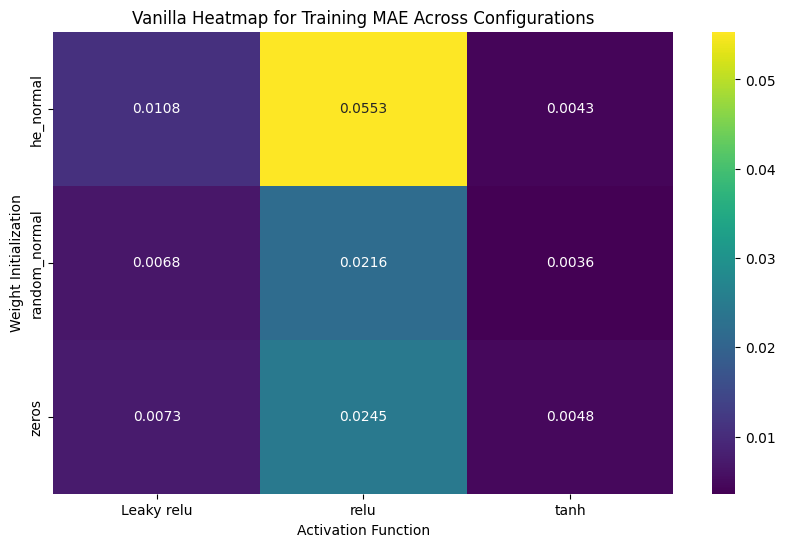

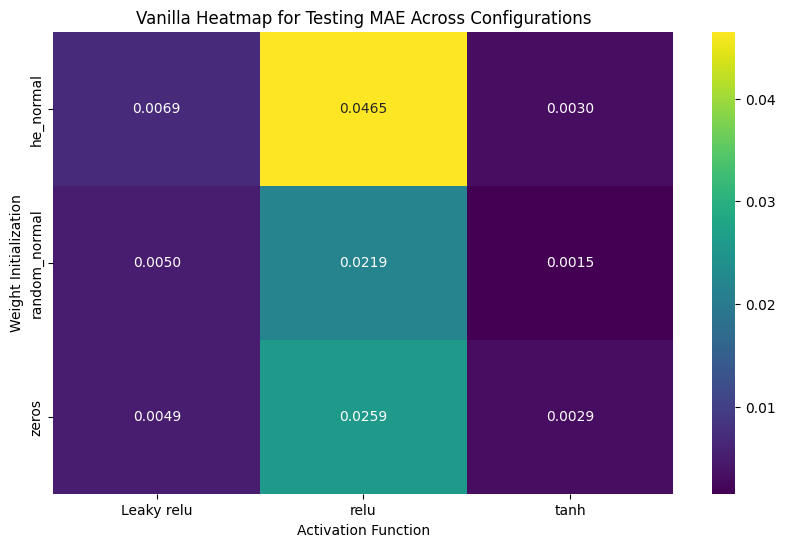

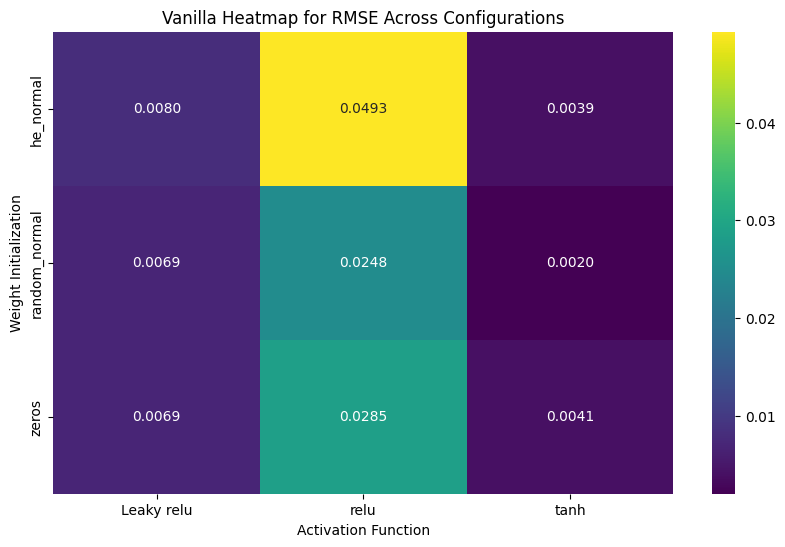

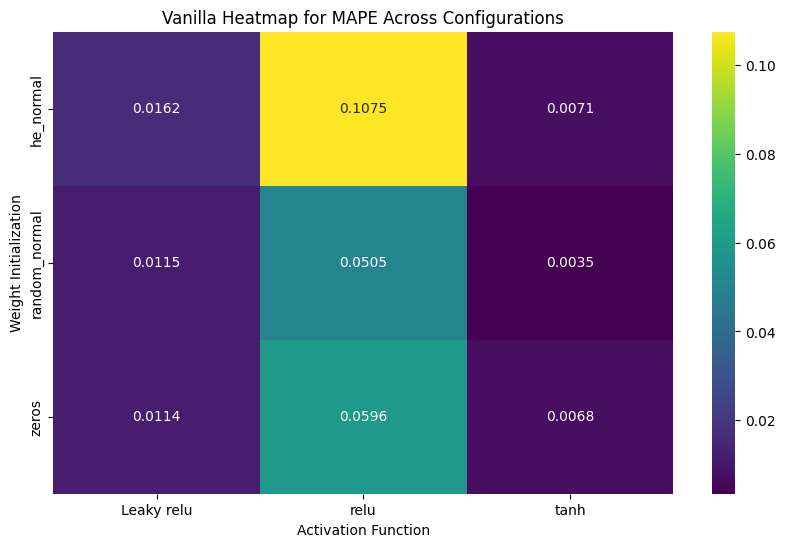

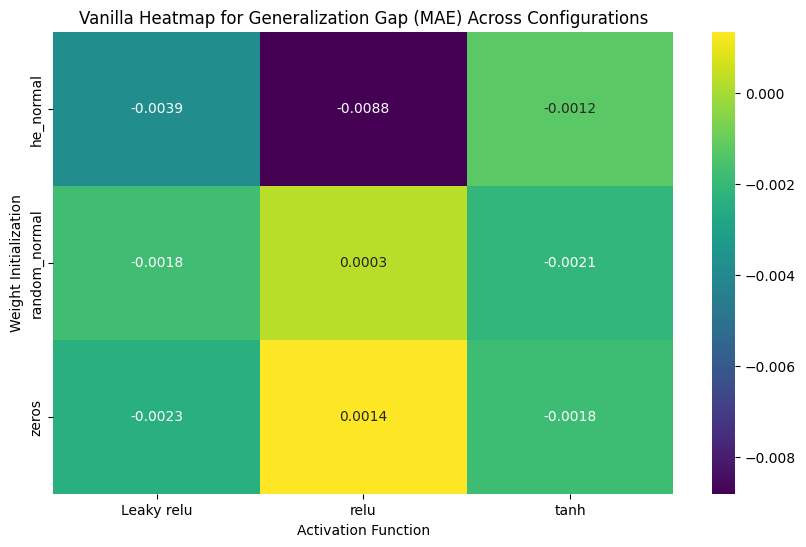

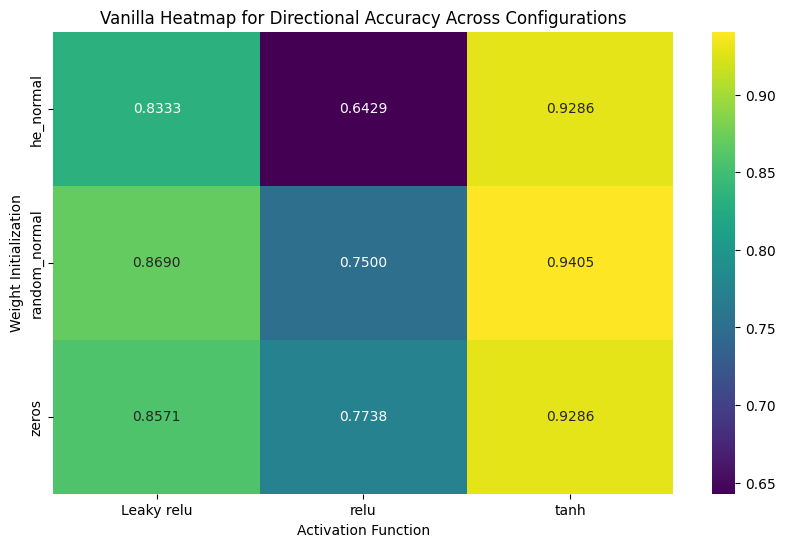

In [ ]:
# ----------------- Vanilla RNN -----------------
import os
import pandas as pd
import numpy as np
from google.colab import drive
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Custom weight initializer for zeros with noise
from tensorflow.keras.initializers import Initializer
import tensorflow.keras.backend as K

class ZerosWithNoise(Initializer):
    def __init__(self, noise_level=1e-5):
        self.noise_level = noise_level

    def __call__(self, shape, dtype=None):
        return K.random_uniform(shape, minval=-self.noise_level, maxval=self.noise_level, dtype=dtype)

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Define file paths
root_dir = '/content/drive/My Drive/RNNs For Stock Prediction - 1906525'
data_dir = os.path.join(root_dir, 'data/cleaned')
train_file_path = os.path.join(data_dir, 'train_cleaned.csv')
validation_file_path = os.path.join(data_dir, 'validation_cleaned.csv')
test_file_path = os.path.join(data_dir, 'test_cleaned.csv')

# Load the cleaned data
train_data = pd.read_csv(train_file_path)
validation_data = pd.read_csv(validation_file_path)
test_data = pd.read_csv(test_file_path)

# Prepare data for the model
features = ['Close', 'Volume'] + [f'Close_lag{i}' for i in range(1, 6)]
target = 'Close'

X_train = train_data[features].values
y_train = train_data[target].values

X_val = validation_data[features].values
y_val = validation_data[target].values

X_test = test_data[features].values
y_test = test_data[target].values

# Save original y_test for later use
y_test_orig = y_test.copy()

# Scale features
from sklearn.preprocessing import MinMaxScaler

# Create scalers
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

# Fit scalers on training data
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))

# Transform validation and test data
X_val_scaled = scaler_X.transform(X_val)
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1))
X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

# Reshape data for RNN
X_train = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_val = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))
X_test_full = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))  # For full evaluation

y_train = y_train_scaled
y_val = y_val_scaled
y_test_full = y_test_scaled  # For full evaluation

# Directory to save results
results_dir = os.path.join(root_dir, 'results')
os.makedirs(results_dir, exist_ok=True)

results = []

# Initialize hyperparameter index and prediction results
hyperparameter_index = 0
prediction_results = []

# Cosine annealing learning rate function
def cosine_annealing(epoch, lr_max=0.001, lr_min=1e-6, T_max=40):
    return lr_min + 0.5 * (lr_max - lr_min) * (1 + math.cos(math.pi * epoch / T_max))

# Experiment loop
activation_functions = ['relu', 'tanh', 'Leaky relu']
weight_initializations = ['random_normal', 'zeros', 'he_normal']
epochs_list = [10, 20, 30, 40, 50, 100]

for activation_function in activation_functions:
    for weight_initialization in weight_initializations:
        for epochs in epochs_list:
            # Adjust T_max for the learning rate scheduler based on epochs
            def cosine_annealing(epoch, lr_max=0.001, lr_min=1e-6, T_max=epochs):
                return lr_min + 0.5 * (lr_max - lr_min) * (1 + math.cos(math.pi * epoch / T_max))

            # Define the Vanilla RNN model
            model = Sequential()

            # Use custom initializer for 'zeros' to add small noise
            if weight_initialization == 'zeros':
                weight_initializer = ZerosWithNoise()
            else:
                weight_initializer = weight_initialization

            model.add(SimpleRNN(64, kernel_initializer=weight_initializer,
                                input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))

            # Handle activation functions
            if activation_function == 'Leaky relu':
                model.add(LeakyReLU(alpha=0.2))  # Add LeakyReLU with alpha
                model.add(Dropout(0.3))  # Add dropout for regularization
                model.add(Dense(32))  # No activation for LeakyReLU
            else:
                model.add(Dense(64, activation=activation_function))
                model.add(Dropout(0.3))  # Add dropout for regularization
                model.add(Dense(32, activation=activation_function))

            model.add(Dense(1))  # Output layer

            # Compile the model with gradient clipping and MAE loss
            model.compile(optimizer=Adam(clipnorm=1.0), loss='mean_absolute_error', metrics=['mae'])

            # Define callbacks
            reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)
            lr_scheduler = LearningRateScheduler(cosine_annealing)
            early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

            # Train the model
            history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                                epochs=epochs, batch_size=32, verbose=2,
                                callbacks=[reduce_lr, lr_scheduler, early_stopping])

            # Evaluate the model on full test set (retain original functionality)
            test_loss, test_mae = model.evaluate(X_test_full, y_test_full, verbose=2)

            # Predict and inverse transform on full test set
            y_pred_full = model.predict(X_test_full, verbose=0)
            y_pred_full_inverse = scaler_y.inverse_transform(y_pred_full)
            y_test_full_actual = scaler_y.inverse_transform(y_test_full)

            # Calculate additional metrics on full test set
            train_loss, train_mae = model.evaluate(X_train, y_train, verbose=0)
            rmse = np.sqrt(mean_squared_error(y_test_full_actual, y_pred_full_inverse))
            mape = mean_absolute_percentage_error(y_test_full_actual, y_pred_full_inverse)
            try:
                correlation_coefficient, _ = pearsonr(y_test_full_actual.flatten(), y_pred_full_inverse.flatten())
            except Exception:
                correlation_coefficient = np.nan  # Assign NaN if correlation cannot be computed

            directional_accuracy = np.mean((np.sign(y_test_full_actual[1:] - y_test_full_actual[:-1]) == np.sign(y_pred_full_inverse[1:] - y_pred_full_inverse[:-1])).astype(int))
            generalization_gap_mae = test_mae - train_mae

            # Store results (retain original functionality)
            results.append({
                'Activation Function': activation_function,
                'Weight Initialization': weight_initialization,
                'Epochs': epochs,
                'Training MAE': train_mae,
                'Testing MAE': test_mae,
                'Correlation Coefficient': correlation_coefficient,
                'Directional Accuracy': directional_accuracy,
                'RMSE': rmse,
                'MAPE': mape,
                'Generalization Gap (MAE)': generalization_gap_mae
            })


            # Get the index of the test data row
            idx = hyperparameter_index % len(test_data)

            # Get the test data row
            test_row = test_data.iloc[idx]

            # Extract features
            X_test_row = test_row[features].values.reshape(1, -1)

            # Scale features
            X_test_row_scaled = scaler_X.transform(X_test_row)

            # Reshape for model
            X_test_row_scaled = X_test_row_scaled.reshape((1, 1, X_test_row_scaled.shape[1]))

            # Make prediction
            y_pred_row = model.predict(X_test_row_scaled, verbose=0)

            # Inverse transform prediction
            y_pred_row = scaler_y.inverse_transform(y_pred_row)

            # Get actual Close value
            y_test_row_actual = test_row[target]

            # Collect Open, High, Low, Volume, Date
            Open = test_row['Open']
            High = test_row['High']
            Low = test_row['Low']
            Volume = test_row['Volume']
            Date = test_row['Date']

            # Calculate Difference
            Difference = y_pred_row[0][0] - y_test_row_actual

            # Compute MSE for the single data point
            MSE = Difference ** 2

            # Correlation Coefficient and Directional Accuracy are not meaningful for a single data point
            Correlation_Coefficient = np.nan
            Directional_Accuracy = np.nan

            # Append to prediction_results
            prediction_results.append({
                'Date': Date,
                'Open': Open,
                'High': High,
                'Low': Low,
                'Volume': Volume,
                'Close (Actual)': y_test_row_actual,
                'Close (Predicted)': y_pred_row[0][0],
                'Difference': Difference,
                'Activation Function': activation_function,
                'Weight Initialization': weight_initialization,
                'Epochs': epochs,
                'MSE': MSE,
            })

            # Increment hyperparameter index
            hyperparameter_index += 1

# Save results to CSV
results_df = pd.DataFrame(results)
results_csv_path = os.path.join(results_dir, 'Vanilla_results_Final.csv')
results_df.to_csv(results_csv_path, index=False)

# Reorder columns in prediction_results
columns_order = ['Date', 'Open', 'High', 'Low', 'Volume', 'Close (Actual)', 'Close (Predicted)', 'Difference',
                 'Activation Function', 'Weight Initialization', 'Epochs', 'MSE']
prediction_results_df = pd.DataFrame(prediction_results)[columns_order]

# Save prediction results to CSV
prediction_results_csv_path = os.path.join(results_dir, 'Vanilla_Testing_PredVsAct.csv')
prediction_results_df.to_csv(prediction_results_csv_path, index=False)

# Heatmap Visualization
metrics = ['Training MAE', 'Testing MAE', 'RMSE', 'MAPE', 'Generalization Gap (MAE)', 'Directional Accuracy']
for metric in metrics:
    heatmap_data = results_df.pivot_table(index='Weight Initialization', columns='Activation Function', values=metric, aggfunc='mean')
    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap_data, annot=True, cmap='viridis', fmt='.4f')
    plt.title(f'Vanilla Heatmap for {metric} Across Configurations')
    plt.show()


2) GRU Model

Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
59/59 - 6s - 101ms/step - loss: 0.1155 - mae: 0.1155 - val_loss: 0.0180 - val_mae: 0.0180 - learning_rate: 0.0010
Epoch 2/10
59/59 - 1s - 12ms/step - loss: 0.0381 - mae: 0.0381 - val_loss: 0.0227 - val_mae: 0.0227 - learning_rate: 9.7555e-04
Epoch 3/10
59/59 - 0s - 7ms/step - loss: 0.0315 - mae: 0.0315 - val_loss: 0.0160 - val_mae: 0.0160 - learning_rate: 8.8249e-04
Epoch 4/10
59/59 - 1s - 10ms/step - loss: 0.0308 - mae: 0.0308 - val_loss: 0.0214 - val_mae: 0.0214 - learning_rate: 7.0081e-04
Epoch 5/10
59/59 - 1s - 11ms/step - loss: 0.0292 - mae: 0.0292 - val_loss: 0.0249 - val_mae: 0.0249 - learning_rate: 4.5903e-04
Epoch 6/10
59/59 - 1s - 10ms/step - loss: 0.0274 - mae: 0.0274 - val_loss: 0.0215 - val_mae: 0.0215 - learning_rate: 2.3002e-04
Epoch 7/10
59/59 - 0s - 7ms/step - loss: 0.0261 - mae: 0.0261 - val_loss: 0.0198 - val_mae: 0.0198 - learning_rate: 8.0123e-05
Epoch 8/10

Epoch 8: ReduceLROnPlateau reducing learning rate to 3.461564483586699e-06.
59/59 - 0s - 7ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 9s - 146ms/step - loss: 0.1094 - mae: 0.1094 - val_loss: 0.0174 - val_mae: 0.0174 - learning_rate: 0.0010
Epoch 2/20
59/59 - 1s - 22ms/step - loss: 0.0364 - mae: 0.0364 - val_loss: 0.0283 - val_mae: 0.0283 - learning_rate: 9.9385e-04
Epoch 3/20
59/59 - 1s - 16ms/step - loss: 0.0347 - mae: 0.0347 - val_loss: 0.0201 - val_mae: 0.0201 - learning_rate: 9.6955e-04
Epoch 4/20
59/59 - 1s - 13ms/step - loss: 0.0294 - mae: 0.0294 - val_loss: 0.0176 - val_mae: 0.0176 - learning_rate: 9.1677e-04
Epoch 5/20
59/59 - 1s - 16ms/step - loss: 0.0275 - mae: 0.0275 - val_loss: 0.0207 - val_mae: 0.0207 - learning_rate: 8.2932e-04
Epoch 6/20

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00014160346472635865.
59/59 - 1s - 22ms/step - loss: 0.0272 - mae: 0.0272 - val_loss: 0.0264 - val_mae: 0.0264 - learning_rate: 1.4160e-04
Epoch 7/20
59/59 - 1s - 16ms/step - loss: 0.0258 - mae: 0.0258 - val_loss: 0.0211 - val_mae: 0.0211 - learning_rate: 1.1262e-04
Epoch 8/20
59/59 - 1s - 13ms/step - loss

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 5s - 78ms/step - loss: 0.1623 - mae: 0.1623 - val_loss: 0.0344 - val_mae: 0.0344 - learning_rate: 0.0010
Epoch 2/30
59/59 - 0s - 5ms/step - loss: 0.0424 - mae: 0.0424 - val_loss: 0.0214 - val_mae: 0.0214 - learning_rate: 9.9726e-04
Epoch 3/30
59/59 - 0s - 5ms/step - loss: 0.0373 - mae: 0.0373 - val_loss: 0.0232 - val_mae: 0.0232 - learning_rate: 9.8638e-04
Epoch 4/30
59/59 - 0s - 5ms/step - loss: 0.0342 - mae: 0.0342 - val_loss: 0.0208 - val_mae: 0.0208 - learning_rate: 9.6226e-04
Epoch 5/30
59/59 - 0s - 5ms/step - loss: 0.0320 - mae: 0.0320 - val_loss: 0.0198 - val_mae: 0.0198 - learning_rate: 9.2071e-04
Epoch 6/30
59/59 - 0s - 5ms/step - loss: 0.0291 - mae: 0.0291 - val_loss: 0.0271 - val_mae: 0.0271 - learning_rate: 8.5910e-04
Epoch 7/30
59/59 - 0s - 6ms/step - loss: 0.0274 - mae: 0.0274 - val_loss: 0.0227 - val_mae: 0.0227 - learning_rate: 7.7716e-04
Epoch 8/30
59/59 - 0s - 6ms/step - loss: 0.0266 - mae: 0.0266 - val_loss: 0.0200 - val_mae: 0.0200 - learning_rate: 6.7748e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 8s - 135ms/step - loss: 0.1033 - mae: 0.1033 - val_loss: 0.0192 - val_mae: 0.0192 - learning_rate: 0.0010
Epoch 2/40
59/59 - 0s - 6ms/step - loss: 0.0367 - mae: 0.0367 - val_loss: 0.0200 - val_mae: 0.0200 - learning_rate: 9.9846e-04
Epoch 3/40
59/59 - 0s - 5ms/step - loss: 0.0340 - mae: 0.0340 - val_loss: 0.0178 - val_mae: 0.0178 - learning_rate: 9.9232e-04
Epoch 4/40
59/59 - 0s - 5ms/step - loss: 0.0322 - mae: 0.0322 - val_loss: 0.0162 - val_mae: 0.0162 - learning_rate: 9.7862e-04
Epoch 5/40
59/59 - 0s - 5ms/step - loss: 0.0289 - mae: 0.0289 - val_loss: 0.0158 - val_mae: 0.0158 - learning_rate: 9.5470e-04
Epoch 6/40
59/59 - 1s - 11ms/step - loss: 0.0287 - mae: 0.0287 - val_loss: 0.0180 - val_mae: 0.0180 - learning_rate: 9.1840e-04
Epoch 7/40
59/59 - 0s - 6ms/step - loss: 0.0265 - mae: 0.0265 - val_loss: 0.0156 - val_mae: 0.0156 - learning_rate: 8.6841e-04
Epoch 8/40
59/59 - 0s - 6ms/step - loss: 0.0260 - mae: 0.0260 - val_loss: 0.0184 - val_mae: 0.0184 - learning_rate: 8.0450e

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 4s - 71ms/step - loss: 0.1067 - mae: 0.1067 - val_loss: 0.0193 - val_mae: 0.0193 - learning_rate: 0.0010
Epoch 2/50
59/59 - 1s - 15ms/step - loss: 0.0422 - mae: 0.0422 - val_loss: 0.0203 - val_mae: 0.0203 - learning_rate: 9.9901e-04
Epoch 3/50
59/59 - 0s - 6ms/step - loss: 0.0382 - mae: 0.0382 - val_loss: 0.0223 - val_mae: 0.0223 - learning_rate: 9.9508e-04
Epoch 4/50
59/59 - 1s - 10ms/step - loss: 0.0335 - mae: 0.0335 - val_loss: 0.0177 - val_mae: 0.0177 - learning_rate: 9.8628e-04
Epoch 5/50
59/59 - 0s - 6ms/step - loss: 0.0318 - mae: 0.0318 - val_loss: 0.0190 - val_mae: 0.0190 - learning_rate: 9.7080e-04
Epoch 6/50
59/59 - 1s - 11ms/step - loss: 0.0300 - mae: 0.0300 - val_loss: 0.0189 - val_mae: 0.0189 - learning_rate: 9.4707e-04
Epoch 7/50
59/59 - 0s - 7ms/step - loss: 0.0284 - mae: 0.0284 - val_loss: 0.0173 - val_mae: 0.0173 - learning_rate: 9.1385e-04
Epoch 8/50
59/59 - 1s - 9ms/step - loss: 0.0259 - mae: 0.0259 - val_loss: 0.0116 - val_mae: 0.0116 - learning_rate: 8.7041

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 4s - 67ms/step - loss: 0.0942 - mae: 0.0942 - val_loss: 0.0261 - val_mae: 0.0261 - learning_rate: 0.0010
Epoch 2/100
59/59 - 1s - 15ms/step - loss: 0.0387 - mae: 0.0387 - val_loss: 0.0188 - val_mae: 0.0188 - learning_rate: 9.9975e-04
Epoch 3/100
59/59 - 0s - 5ms/step - loss: 0.0349 - mae: 0.0349 - val_loss: 0.0194 - val_mae: 0.0194 - learning_rate: 9.9877e-04
Epoch 4/100
59/59 - 1s - 10ms/step - loss: 0.0315 - mae: 0.0315 - val_loss: 0.0155 - val_mae: 0.0155 - learning_rate: 9.9655e-04
Epoch 5/100
59/59 - 0s - 5ms/step - loss: 0.0286 - mae: 0.0286 - val_loss: 0.0136 - val_mae: 0.0136 - learning_rate: 9.9263e-04
Epoch 6/100
59/59 - 0s - 5ms/step - loss: 0.0282 - mae: 0.0282 - val_loss: 0.0225 - val_mae: 0.0225 - learning_rate: 9.8652e-04
Epoch 7/100
59/59 - 0s - 5ms/step - loss: 0.0238 - mae: 0.0238 - val_loss: 0.0203 - val_mae: 0.0203 - learning_rate: 9.7780e-04
Epoch 8/100
59/59 - 0s - 5ms/step - loss: 0.0208 - mae: 0.0208 - val_loss: 0.0146 - val_mae: 0.0146 - learning_rate: 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 4s - 66ms/step - loss: 0.1268 - mae: 0.1268 - val_loss: 0.0267 - val_mae: 0.0267 - learning_rate: 0.0010
Epoch 2/10
59/59 - 0s - 5ms/step - loss: 0.0405 - mae: 0.0405 - val_loss: 0.0193 - val_mae: 0.0193 - learning_rate: 9.7555e-04
Epoch 3/10
59/59 - 1s - 10ms/step - loss: 0.0352 - mae: 0.0352 - val_loss: 0.0196 - val_mae: 0.0196 - learning_rate: 8.8249e-04
Epoch 4/10
59/59 - 0s - 5ms/step - loss: 0.0319 - mae: 0.0319 - val_loss: 0.0188 - val_mae: 0.0188 - learning_rate: 7.0081e-04
Epoch 5/10
59/59 - 0s - 5ms/step - loss: 0.0294 - mae: 0.0294 - val_loss: 0.0184 - val_mae: 0.0184 - learning_rate: 4.5903e-04
Epoch 6/10
59/59 - 0s - 5ms/step - loss: 0.0291 - mae: 0.0291 - val_loss: 0.0189 - val_mae: 0.0189 - learning_rate: 2.3002e-04
Epoch 7/10
59/59 - 0s - 6ms/step - loss: 0.0292 - mae: 0.0292 - val_loss: 0.0162 - val_mae: 0.0162 - learning_rate: 8.0123e-05
Epoch 8/10
59/59 - 0s - 6ms/step - loss: 0.0275 - mae: 0.0275 - val_loss: 0.0172 - val_mae: 0.0172 - learning_rate: 1.7308e-

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 5s - 86ms/step - loss: 0.1038 - mae: 0.1038 - val_loss: 0.0197 - val_mae: 0.0197 - learning_rate: 0.0010
Epoch 2/20
59/59 - 1s - 10ms/step - loss: 0.0356 - mae: 0.0356 - val_loss: 0.0199 - val_mae: 0.0199 - learning_rate: 9.9385e-04
Epoch 3/20
59/59 - 0s - 5ms/step - loss: 0.0319 - mae: 0.0319 - val_loss: 0.0181 - val_mae: 0.0181 - learning_rate: 9.6955e-04
Epoch 4/20
59/59 - 1s - 10ms/step - loss: 0.0304 - mae: 0.0304 - val_loss: 0.0220 - val_mae: 0.0220 - learning_rate: 9.1677e-04
Epoch 5/20
59/59 - 0s - 5ms/step - loss: 0.0278 - mae: 0.0278 - val_loss: 0.0247 - val_mae: 0.0247 - learning_rate: 8.2932e-04
Epoch 6/20
59/59 - 0s - 5ms/step - loss: 0.0268 - mae: 0.0268 - val_loss: 0.0162 - val_mae: 0.0162 - learning_rate: 7.0802e-04
Epoch 7/20
59/59 - 1s - 10ms/step - loss: 0.0246 - mae: 0.0246 - val_loss: 0.0172 - val_mae: 0.0172 - learning_rate: 5.6230e-04
Epoch 8/20
59/59 - 1s - 10ms/step - loss: 0.0226 - mae: 0.0226 - val_loss: 0.0195 - val_mae: 0.0195 - learning_rate: 4.090

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 5s - 76ms/step - loss: 0.1092 - mae: 0.1092 - val_loss: 0.0192 - val_mae: 0.0192 - learning_rate: 0.0010
Epoch 2/30
59/59 - 0s - 8ms/step - loss: 0.0375 - mae: 0.0375 - val_loss: 0.0231 - val_mae: 0.0231 - learning_rate: 9.9726e-04
Epoch 3/30
59/59 - 1s - 11ms/step - loss: 0.0348 - mae: 0.0348 - val_loss: 0.0175 - val_mae: 0.0175 - learning_rate: 9.8638e-04
Epoch 4/30
59/59 - 1s - 10ms/step - loss: 0.0296 - mae: 0.0296 - val_loss: 0.0185 - val_mae: 0.0185 - learning_rate: 9.6226e-04
Epoch 5/30
59/59 - 1s - 10ms/step - loss: 0.0305 - mae: 0.0305 - val_loss: 0.0154 - val_mae: 0.0154 - learning_rate: 9.2071e-04
Epoch 6/30
59/59 - 0s - 8ms/step - loss: 0.0272 - mae: 0.0272 - val_loss: 0.0139 - val_mae: 0.0139 - learning_rate: 8.5910e-04
Epoch 7/30
59/59 - 1s - 10ms/step - loss: 0.0275 - mae: 0.0275 - val_loss: 0.0143 - val_mae: 0.0143 - learning_rate: 7.7716e-04
Epoch 8/30
59/59 - 0s - 5ms/step - loss: 0.0265 - mae: 0.0265 - val_loss: 0.0234 - val_mae: 0.0234 - learning_rate: 6.774

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 6s - 99ms/step - loss: 0.1390 - mae: 0.1390 - val_loss: 0.0259 - val_mae: 0.0259 - learning_rate: 0.0010
Epoch 2/40
59/59 - 0s - 5ms/step - loss: 0.0442 - mae: 0.0442 - val_loss: 0.0189 - val_mae: 0.0189 - learning_rate: 9.9846e-04
Epoch 3/40
59/59 - 0s - 5ms/step - loss: 0.0391 - mae: 0.0391 - val_loss: 0.0275 - val_mae: 0.0275 - learning_rate: 9.9232e-04
Epoch 4/40
59/59 - 0s - 5ms/step - loss: 0.0349 - mae: 0.0349 - val_loss: 0.0167 - val_mae: 0.0167 - learning_rate: 9.7862e-04
Epoch 5/40
59/59 - 0s - 5ms/step - loss: 0.0309 - mae: 0.0309 - val_loss: 0.0152 - val_mae: 0.0152 - learning_rate: 9.5470e-04
Epoch 6/40
59/59 - 0s - 5ms/step - loss: 0.0295 - mae: 0.0295 - val_loss: 0.0230 - val_mae: 0.0230 - learning_rate: 9.1840e-04
Epoch 7/40
59/59 - 0s - 5ms/step - loss: 0.0269 - mae: 0.0269 - val_loss: 0.0220 - val_mae: 0.0220 - learning_rate: 8.6841e-04
Epoch 8/40
59/59 - 1s - 10ms/step - loss: 0.0272 - mae: 0.0272 - val_loss: 0.0151 - val_mae: 0.0151 - learning_rate: 8.0450e-

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 5s - 90ms/step - loss: 0.1228 - mae: 0.1228 - val_loss: 0.0199 - val_mae: 0.0199 - learning_rate: 0.0010
Epoch 2/50
59/59 - 1s - 10ms/step - loss: 0.0401 - mae: 0.0401 - val_loss: 0.0243 - val_mae: 0.0243 - learning_rate: 9.9901e-04
Epoch 3/50
59/59 - 0s - 5ms/step - loss: 0.0347 - mae: 0.0347 - val_loss: 0.0167 - val_mae: 0.0167 - learning_rate: 9.9508e-04
Epoch 4/50
59/59 - 1s - 10ms/step - loss: 0.0305 - mae: 0.0305 - val_loss: 0.0176 - val_mae: 0.0176 - learning_rate: 9.8628e-04
Epoch 5/50
59/59 - 0s - 5ms/step - loss: 0.0290 - mae: 0.0290 - val_loss: 0.0230 - val_mae: 0.0230 - learning_rate: 9.7080e-04
Epoch 6/50
59/59 - 0s - 5ms/step - loss: 0.0273 - mae: 0.0273 - val_loss: 0.0186 - val_mae: 0.0186 - learning_rate: 9.4707e-04
Epoch 7/50
59/59 - 0s - 5ms/step - loss: 0.0255 - mae: 0.0255 - val_loss: 0.0195 - val_mae: 0.0195 - learning_rate: 9.1385e-04
Epoch 8/50
59/59 - 0s - 5ms/step - loss: 0.0241 - mae: 0.0241 - val_loss: 0.0161 - val_mae: 0.0161 - learning_rate: 8.7041e

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 5s - 78ms/step - loss: 0.1359 - mae: 0.1359 - val_loss: 0.0248 - val_mae: 0.0248 - learning_rate: 0.0010
Epoch 2/100
59/59 - 1s - 16ms/step - loss: 0.0382 - mae: 0.0382 - val_loss: 0.0265 - val_mae: 0.0265 - learning_rate: 9.9975e-04
Epoch 3/100
59/59 - 0s - 5ms/step - loss: 0.0319 - mae: 0.0319 - val_loss: 0.0351 - val_mae: 0.0351 - learning_rate: 9.9877e-04
Epoch 4/100
59/59 - 0s - 6ms/step - loss: 0.0288 - mae: 0.0288 - val_loss: 0.0329 - val_mae: 0.0329 - learning_rate: 9.9655e-04
Epoch 5/100
59/59 - 0s - 6ms/step - loss: 0.0271 - mae: 0.0271 - val_loss: 0.0344 - val_mae: 0.0344 - learning_rate: 9.9263e-04
Epoch 6/100

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00019730490166693928.
59/59 - 1s - 11ms/step - loss: 0.0254 - mae: 0.0254 - val_loss: 0.0350 - val_mae: 0.0350 - learning_rate: 1.9730e-04
Epoch 7/100
59/59 - 0s - 5ms/step - loss: 0.0226 - mae: 0.0226 - val_loss: 0.0322 - val_mae: 0.0322 - learning_rate: 1.9557e-04
Epoch 8/100
59/59 - 0s - 5ms/step - los

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 5s - 79ms/step - loss: 0.0861 - mae: 0.0861 - val_loss: 0.0158 - val_mae: 0.0158 - learning_rate: 0.0010
Epoch 2/10
59/59 - 1s - 14ms/step - loss: 0.0388 - mae: 0.0388 - val_loss: 0.0221 - val_mae: 0.0221 - learning_rate: 9.7555e-04
Epoch 3/10
59/59 - 1s - 9ms/step - loss: 0.0348 - mae: 0.0348 - val_loss: 0.0119 - val_mae: 0.0119 - learning_rate: 8.8249e-04
Epoch 4/10
59/59 - 0s - 7ms/step - loss: 0.0292 - mae: 0.0292 - val_loss: 0.0281 - val_mae: 0.0281 - learning_rate: 7.0081e-04
Epoch 5/10
59/59 - 0s - 4ms/step - loss: 0.0292 - mae: 0.0292 - val_loss: 0.0192 - val_mae: 0.0192 - learning_rate: 4.5903e-04
Epoch 6/10
59/59 - 0s - 5ms/step - loss: 0.0272 - mae: 0.0272 - val_loss: 0.0200 - val_mae: 0.0200 - learning_rate: 2.3002e-04
Epoch 7/10
59/59 - 0s - 5ms/step - loss: 0.0271 - mae: 0.0271 - val_loss: 0.0235 - val_mae: 0.0235 - learning_rate: 8.0123e-05
Epoch 8/10

Epoch 8: ReduceLROnPlateau reducing learning rate to 3.461564483586699e-06.
59/59 - 0s - 5ms/step - loss: 0.0256

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 4s - 63ms/step - loss: 0.0737 - mae: 0.0737 - val_loss: 0.0401 - val_mae: 0.0401 - learning_rate: 0.0010
Epoch 2/20
59/59 - 1s - 15ms/step - loss: 0.0394 - mae: 0.0394 - val_loss: 0.0398 - val_mae: 0.0398 - learning_rate: 9.9385e-04
Epoch 3/20
59/59 - 0s - 5ms/step - loss: 0.0324 - mae: 0.0324 - val_loss: 0.0516 - val_mae: 0.0516 - learning_rate: 9.6955e-04
Epoch 4/20
59/59 - 0s - 5ms/step - loss: 0.0275 - mae: 0.0275 - val_loss: 0.0508 - val_mae: 0.0508 - learning_rate: 9.1677e-04
Epoch 5/20
59/59 - 0s - 5ms/step - loss: 0.0249 - mae: 0.0249 - val_loss: 0.0454 - val_mae: 0.0454 - learning_rate: 8.2932e-04
Epoch 6/20
59/59 - 0s - 6ms/step - loss: 0.0203 - mae: 0.0203 - val_loss: 0.0440 - val_mae: 0.0440 - learning_rate: 7.0802e-04
Epoch 7/20

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00011245916830375791.
59/59 - 0s - 6ms/step - loss: 0.0197 - mae: 0.0197 - val_loss: 0.0466 - val_mae: 0.0466 - learning_rate: 1.1246e-04
Epoch 8/20
59/59 - 1s - 10ms/step - loss: 0.01

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 4s - 62ms/step - loss: 0.0882 - mae: 0.0882 - val_loss: 0.0225 - val_mae: 0.0225 - learning_rate: 0.0010
Epoch 2/30
59/59 - 0s - 5ms/step - loss: 0.0400 - mae: 0.0400 - val_loss: 0.0198 - val_mae: 0.0198 - learning_rate: 9.9726e-04
Epoch 3/30
59/59 - 0s - 5ms/step - loss: 0.0332 - mae: 0.0332 - val_loss: 0.0260 - val_mae: 0.0260 - learning_rate: 9.8638e-04
Epoch 4/30
59/59 - 0s - 5ms/step - loss: 0.0290 - mae: 0.0290 - val_loss: 0.0279 - val_mae: 0.0279 - learning_rate: 9.6226e-04
Epoch 5/30
59/59 - 0s - 5ms/step - loss: 0.0254 - mae: 0.0254 - val_loss: 0.0418 - val_mae: 0.0418 - learning_rate: 9.2071e-04
Epoch 6/30
59/59 - 0s - 5ms/step - loss: 0.0243 - mae: 0.0243 - val_loss: 0.0429 - val_mae: 0.0429 - learning_rate: 8.5910e-04
Epoch 7/30

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00015543221961706878.
59/59 - 0s - 5ms/step - loss: 0.0222 - mae: 0.0222 - val_loss: 0.0454 - val_mae: 0.0454 - learning_rate: 1.5543e-04
Epoch 8/30
59/59 - 0s - 5ms/step - loss: 0.0193

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 5s - 84ms/step - loss: 0.0977 - mae: 0.0977 - val_loss: 0.0245 - val_mae: 0.0245 - learning_rate: 0.0010
Epoch 2/40
59/59 - 1s - 12ms/step - loss: 0.0458 - mae: 0.0458 - val_loss: 0.0227 - val_mae: 0.0227 - learning_rate: 9.9846e-04
Epoch 3/40
59/59 - 0s - 5ms/step - loss: 0.0364 - mae: 0.0364 - val_loss: 0.0235 - val_mae: 0.0235 - learning_rate: 9.9232e-04
Epoch 4/40
59/59 - 1s - 10ms/step - loss: 0.0311 - mae: 0.0311 - val_loss: 0.0261 - val_mae: 0.0261 - learning_rate: 9.7862e-04
Epoch 5/40
59/59 - 0s - 6ms/step - loss: 0.0272 - mae: 0.0272 - val_loss: 0.0423 - val_mae: 0.0423 - learning_rate: 9.5470e-04
Epoch 6/40
59/59 - 1s - 9ms/step - loss: 0.0256 - mae: 0.0256 - val_loss: 0.0386 - val_mae: 0.0386 - learning_rate: 9.1840e-04
Epoch 7/40

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00017368145054206253.
59/59 - 0s - 6ms/step - loss: 0.0219 - mae: 0.0219 - val_loss: 0.0333 - val_mae: 0.0333 - learning_rate: 1.7368e-04
Epoch 8/40
59/59 - 0s - 5ms/step - loss: 0.01

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 4s - 63ms/step - loss: 0.0934 - mae: 0.0934 - val_loss: 0.0179 - val_mae: 0.0179 - learning_rate: 0.0010
Epoch 2/50
59/59 - 1s - 16ms/step - loss: 0.0430 - mae: 0.0430 - val_loss: 0.0237 - val_mae: 0.0237 - learning_rate: 9.9901e-04
Epoch 3/50
59/59 - 0s - 5ms/step - loss: 0.0346 - mae: 0.0346 - val_loss: 0.0126 - val_mae: 0.0126 - learning_rate: 9.9508e-04
Epoch 4/50
59/59 - 1s - 13ms/step - loss: 0.0332 - mae: 0.0332 - val_loss: 0.0287 - val_mae: 0.0287 - learning_rate: 9.8628e-04
Epoch 5/50
59/59 - 0s - 7ms/step - loss: 0.0292 - mae: 0.0292 - val_loss: 0.0357 - val_mae: 0.0357 - learning_rate: 9.7080e-04
Epoch 6/50
59/59 - 1s - 11ms/step - loss: 0.0272 - mae: 0.0272 - val_loss: 0.0265 - val_mae: 0.0265 - learning_rate: 9.4707e-04
Epoch 7/50
59/59 - 1s - 10ms/step - loss: 0.0237 - mae: 0.0237 - val_loss: 0.0235 - val_mae: 0.0235 - learning_rate: 9.1385e-04
Epoch 8/50

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.00017408172134310008.
59/59 - 1s - 11ms/step - loss: 0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 4s - 61ms/step - loss: 0.0704 - mae: 0.0704 - val_loss: 0.0150 - val_mae: 0.0150 - learning_rate: 0.0010
Epoch 2/100
59/59 - 0s - 4ms/step - loss: 0.0402 - mae: 0.0402 - val_loss: 0.0382 - val_mae: 0.0382 - learning_rate: 9.9975e-04
Epoch 3/100
59/59 - 0s - 5ms/step - loss: 0.0315 - mae: 0.0315 - val_loss: 0.0539 - val_mae: 0.0539 - learning_rate: 9.9877e-04
Epoch 4/100
59/59 - 1s - 10ms/step - loss: 0.0254 - mae: 0.0254 - val_loss: 0.0504 - val_mae: 0.0504 - learning_rate: 9.9655e-04
Epoch 5/100
59/59 - 0s - 5ms/step - loss: 0.0227 - mae: 0.0227 - val_loss: 0.0503 - val_mae: 0.0503 - learning_rate: 9.9263e-04
Epoch 6/100

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00019730490166693928.
59/59 - 0s - 5ms/step - loss: 0.0206 - mae: 0.0206 - val_loss: 0.0485 - val_mae: 0.0485 - learning_rate: 1.9730e-04
Epoch 7/100
59/59 - 0s - 5ms/step - loss: 0.0151 - mae: 0.0151 - val_loss: 0.0481 - val_mae: 0.0481 - learning_rate: 1.9557e-04
Epoch 8/100
59/59 - 0s - 6ms/step - loss

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 5s - 79ms/step - loss: 0.0573 - mae: 0.0573 - val_loss: 0.0185 - val_mae: 0.0185 - learning_rate: 0.0010
Epoch 2/10
59/59 - 0s - 4ms/step - loss: 0.0308 - mae: 0.0308 - val_loss: 0.0200 - val_mae: 0.0200 - learning_rate: 9.7555e-04
Epoch 3/10
59/59 - 0s - 5ms/step - loss: 0.0257 - mae: 0.0257 - val_loss: 0.0157 - val_mae: 0.0157 - learning_rate: 8.8249e-04
Epoch 4/10
59/59 - 1s - 11ms/step - loss: 0.0238 - mae: 0.0238 - val_loss: 0.0108 - val_mae: 0.0108 - learning_rate: 7.0081e-04
Epoch 5/10
59/59 - 0s - 5ms/step - loss: 0.0189 - mae: 0.0189 - val_loss: 0.0103 - val_mae: 0.0103 - learning_rate: 4.5903e-04
Epoch 6/10
59/59 - 0s - 5ms/step - loss: 0.0183 - mae: 0.0183 - val_loss: 0.0089 - val_mae: 0.0089 - learning_rate: 2.3002e-04
Epoch 7/10
59/59 - 0s - 5ms/step - loss: 0.0176 - mae: 0.0176 - val_loss: 0.0085 - val_mae: 0.0085 - learning_rate: 8.0123e-05
Epoch 8/10
59/59 - 0s - 6ms/step - loss: 0.0167 - mae: 0.0167 - val_loss: 0.0086 - val_mae: 0.0086 - learning_rate: 1.7308e-

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 4s - 64ms/step - loss: 0.0730 - mae: 0.0730 - val_loss: 0.0192 - val_mae: 0.0192 - learning_rate: 0.0010
Epoch 2/20
59/59 - 1s - 17ms/step - loss: 0.0291 - mae: 0.0291 - val_loss: 0.0142 - val_mae: 0.0142 - learning_rate: 9.9385e-04
Epoch 3/20
59/59 - 1s - 12ms/step - loss: 0.0257 - mae: 0.0257 - val_loss: 0.0173 - val_mae: 0.0173 - learning_rate: 9.6955e-04
Epoch 4/20
59/59 - 1s - 10ms/step - loss: 0.0227 - mae: 0.0227 - val_loss: 0.0125 - val_mae: 0.0125 - learning_rate: 9.1677e-04
Epoch 5/20
59/59 - 1s - 11ms/step - loss: 0.0202 - mae: 0.0202 - val_loss: 0.0099 - val_mae: 0.0099 - learning_rate: 8.2932e-04
Epoch 6/20
59/59 - 1s - 10ms/step - loss: 0.0179 - mae: 0.0179 - val_loss: 0.0125 - val_mae: 0.0125 - learning_rate: 7.0802e-04
Epoch 7/20
59/59 - 0s - 8ms/step - loss: 0.0186 - mae: 0.0186 - val_loss: 0.0135 - val_mae: 0.0135 - learning_rate: 5.6230e-04
Epoch 8/20
59/59 - 0s - 7ms/step - loss: 0.0168 - mae: 0.0168 - val_loss: 0.0072 - val_mae: 0.0072 - learning_rate: 4.09

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 4s - 62ms/step - loss: 0.0615 - mae: 0.0615 - val_loss: 0.0178 - val_mae: 0.0178 - learning_rate: 0.0010
Epoch 2/30
59/59 - 1s - 16ms/step - loss: 0.0298 - mae: 0.0298 - val_loss: 0.0162 - val_mae: 0.0162 - learning_rate: 9.9726e-04
Epoch 3/30
59/59 - 0s - 6ms/step - loss: 0.0263 - mae: 0.0263 - val_loss: 0.0145 - val_mae: 0.0145 - learning_rate: 9.8638e-04
Epoch 4/30
59/59 - 1s - 12ms/step - loss: 0.0229 - mae: 0.0229 - val_loss: 0.0138 - val_mae: 0.0138 - learning_rate: 9.6226e-04
Epoch 5/30
59/59 - 1s - 10ms/step - loss: 0.0200 - mae: 0.0200 - val_loss: 0.0088 - val_mae: 0.0088 - learning_rate: 9.2071e-04
Epoch 6/30
59/59 - 0s - 8ms/step - loss: 0.0192 - mae: 0.0192 - val_loss: 0.0069 - val_mae: 0.0069 - learning_rate: 8.5910e-04
Epoch 7/30
59/59 - 0s - 7ms/step - loss: 0.0201 - mae: 0.0201 - val_loss: 0.0066 - val_mae: 0.0066 - learning_rate: 7.7716e-04
Epoch 8/30
59/59 - 0s - 8ms/step - loss: 0.0172 - mae: 0.0172 - val_loss: 0.0118 - val_mae: 0.0118 - learning_rate: 6.7748

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 4s - 61ms/step - loss: 0.0780 - mae: 0.0780 - val_loss: 0.0189 - val_mae: 0.0189 - learning_rate: 0.0010
Epoch 2/40
59/59 - 1s - 18ms/step - loss: 0.0310 - mae: 0.0310 - val_loss: 0.0149 - val_mae: 0.0149 - learning_rate: 9.9846e-04
Epoch 3/40
59/59 - 0s - 7ms/step - loss: 0.0255 - mae: 0.0255 - val_loss: 0.0117 - val_mae: 0.0117 - learning_rate: 9.9232e-04
Epoch 4/40
59/59 - 0s - 8ms/step - loss: 0.0228 - mae: 0.0228 - val_loss: 0.0089 - val_mae: 0.0089 - learning_rate: 9.7862e-04
Epoch 5/40
59/59 - 1s - 9ms/step - loss: 0.0209 - mae: 0.0209 - val_loss: 0.0099 - val_mae: 0.0099 - learning_rate: 9.5470e-04
Epoch 6/40
59/59 - 0s - 8ms/step - loss: 0.0191 - mae: 0.0191 - val_loss: 0.0088 - val_mae: 0.0088 - learning_rate: 9.1840e-04
Epoch 7/40
59/59 - 1s - 10ms/step - loss: 0.0205 - mae: 0.0205 - val_loss: 0.0094 - val_mae: 0.0094 - learning_rate: 8.6841e-04
Epoch 8/40
59/59 - 1s - 11ms/step - loss: 0.0169 - mae: 0.0169 - val_loss: 0.0057 - val_mae: 0.0057 - learning_rate: 8.0450

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 5s - 83ms/step - loss: 0.0783 - mae: 0.0783 - val_loss: 0.0181 - val_mae: 0.0181 - learning_rate: 0.0010
Epoch 2/50
59/59 - 1s - 10ms/step - loss: 0.0342 - mae: 0.0342 - val_loss: 0.0161 - val_mae: 0.0161 - learning_rate: 9.9901e-04
Epoch 3/50
59/59 - 1s - 9ms/step - loss: 0.0274 - mae: 0.0274 - val_loss: 0.0128 - val_mae: 0.0128 - learning_rate: 9.9508e-04
Epoch 4/50
59/59 - 0s - 5ms/step - loss: 0.0250 - mae: 0.0250 - val_loss: 0.0108 - val_mae: 0.0108 - learning_rate: 9.8628e-04
Epoch 5/50
59/59 - 0s - 5ms/step - loss: 0.0210 - mae: 0.0210 - val_loss: 0.0107 - val_mae: 0.0107 - learning_rate: 9.7080e-04
Epoch 6/50
59/59 - 0s - 5ms/step - loss: 0.0186 - mae: 0.0186 - val_loss: 0.0075 - val_mae: 0.0075 - learning_rate: 9.4707e-04
Epoch 7/50
59/59 - 0s - 5ms/step - loss: 0.0183 - mae: 0.0183 - val_loss: 0.0135 - val_mae: 0.0135 - learning_rate: 9.1385e-04
Epoch 8/50
59/59 - 0s - 5ms/step - loss: 0.0164 - mae: 0.0164 - val_loss: 0.0069 - val_mae: 0.0069 - learning_rate: 8.7041e-

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 5s - 85ms/step - loss: 0.0808 - mae: 0.0808 - val_loss: 0.0209 - val_mae: 0.0209 - learning_rate: 0.0010
Epoch 2/100
59/59 - 0s - 5ms/step - loss: 0.0315 - mae: 0.0315 - val_loss: 0.0213 - val_mae: 0.0213 - learning_rate: 9.9975e-04
Epoch 3/100
59/59 - 0s - 5ms/step - loss: 0.0256 - mae: 0.0256 - val_loss: 0.0146 - val_mae: 0.0146 - learning_rate: 9.9877e-04
Epoch 4/100
59/59 - 0s - 5ms/step - loss: 0.0233 - mae: 0.0233 - val_loss: 0.0121 - val_mae: 0.0121 - learning_rate: 9.9655e-04
Epoch 5/100
59/59 - 0s - 5ms/step - loss: 0.0194 - mae: 0.0194 - val_loss: 0.0094 - val_mae: 0.0094 - learning_rate: 9.9263e-04
Epoch 6/100
59/59 - 1s - 10ms/step - loss: 0.0199 - mae: 0.0199 - val_loss: 0.0104 - val_mae: 0.0104 - learning_rate: 9.8652e-04
Epoch 7/100
59/59 - 0s - 5ms/step - loss: 0.0197 - mae: 0.0197 - val_loss: 0.0106 - val_mae: 0.0106 - learning_rate: 9.7780e-04
Epoch 8/100
59/59 - 0s - 5ms/step - loss: 0.0174 - mae: 0.0174 - val_loss: 0.0058 - val_mae: 0.0058 - learning_rate: 9

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 4s - 69ms/step - loss: 0.0917 - mae: 0.0917 - val_loss: 0.0224 - val_mae: 0.0224 - learning_rate: 0.0010
Epoch 2/10
59/59 - 0s - 5ms/step - loss: 0.0318 - mae: 0.0318 - val_loss: 0.0166 - val_mae: 0.0166 - learning_rate: 9.7555e-04
Epoch 3/10
59/59 - 0s - 5ms/step - loss: 0.0287 - mae: 0.0287 - val_loss: 0.0156 - val_mae: 0.0156 - learning_rate: 8.8249e-04
Epoch 4/10
59/59 - 0s - 5ms/step - loss: 0.0251 - mae: 0.0251 - val_loss: 0.0170 - val_mae: 0.0170 - learning_rate: 7.0081e-04
Epoch 5/10
59/59 - 0s - 5ms/step - loss: 0.0234 - mae: 0.0234 - val_loss: 0.0150 - val_mae: 0.0150 - learning_rate: 4.5903e-04
Epoch 6/10
59/59 - 0s - 5ms/step - loss: 0.0228 - mae: 0.0228 - val_loss: 0.0134 - val_mae: 0.0134 - learning_rate: 2.3002e-04
Epoch 7/10
59/59 - 0s - 5ms/step - loss: 0.0220 - mae: 0.0220 - val_loss: 0.0136 - val_mae: 0.0136 - learning_rate: 8.0123e-05
Epoch 8/10
59/59 - 0s - 4ms/step - loss: 0.0206 - mae: 0.0206 - val_loss: 0.0134 - val_mae: 0.0134 - learning_rate: 1.7308e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 4s - 62ms/step - loss: 0.0882 - mae: 0.0882 - val_loss: 0.0249 - val_mae: 0.0249 - learning_rate: 0.0010
Epoch 2/20
59/59 - 1s - 17ms/step - loss: 0.0330 - mae: 0.0330 - val_loss: 0.0167 - val_mae: 0.0167 - learning_rate: 9.9385e-04
Epoch 3/20
59/59 - 1s - 11ms/step - loss: 0.0269 - mae: 0.0269 - val_loss: 0.0168 - val_mae: 0.0168 - learning_rate: 9.6955e-04
Epoch 4/20
59/59 - 0s - 7ms/step - loss: 0.0252 - mae: 0.0252 - val_loss: 0.0151 - val_mae: 0.0151 - learning_rate: 9.1677e-04
Epoch 5/20
59/59 - 0s - 7ms/step - loss: 0.0220 - mae: 0.0220 - val_loss: 0.0144 - val_mae: 0.0144 - learning_rate: 8.2932e-04
Epoch 6/20
59/59 - 1s - 10ms/step - loss: 0.0207 - mae: 0.0207 - val_loss: 0.0115 - val_mae: 0.0115 - learning_rate: 7.0802e-04
Epoch 7/20
59/59 - 1s - 11ms/step - loss: 0.0199 - mae: 0.0199 - val_loss: 0.0112 - val_mae: 0.0112 - learning_rate: 5.6230e-04
Epoch 8/20
59/59 - 1s - 10ms/step - loss: 0.0179 - mae: 0.0179 - val_loss: 0.0120 - val_mae: 0.0120 - learning_rate: 4.09

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 4s - 66ms/step - loss: 0.0885 - mae: 0.0885 - val_loss: 0.0188 - val_mae: 0.0188 - learning_rate: 0.0010
Epoch 2/30
59/59 - 1s - 16ms/step - loss: 0.0324 - mae: 0.0324 - val_loss: 0.0187 - val_mae: 0.0187 - learning_rate: 9.9726e-04
Epoch 3/30
59/59 - 1s - 12ms/step - loss: 0.0284 - mae: 0.0284 - val_loss: 0.0146 - val_mae: 0.0146 - learning_rate: 9.8638e-04
Epoch 4/30
59/59 - 0s - 7ms/step - loss: 0.0244 - mae: 0.0244 - val_loss: 0.0149 - val_mae: 0.0149 - learning_rate: 9.6226e-04
Epoch 5/30
59/59 - 0s - 7ms/step - loss: 0.0226 - mae: 0.0226 - val_loss: 0.0126 - val_mae: 0.0126 - learning_rate: 9.2071e-04
Epoch 6/30
59/59 - 0s - 8ms/step - loss: 0.0211 - mae: 0.0211 - val_loss: 0.0120 - val_mae: 0.0120 - learning_rate: 8.5910e-04
Epoch 7/30
59/59 - 1s - 10ms/step - loss: 0.0196 - mae: 0.0196 - val_loss: 0.0100 - val_mae: 0.0100 - learning_rate: 7.7716e-04
Epoch 8/30
59/59 - 1s - 11ms/step - loss: 0.0195 - mae: 0.0195 - val_loss: 0.0106 - val_mae: 0.0106 - learning_rate: 6.774

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 4s - 60ms/step - loss: 0.0859 - mae: 0.0859 - val_loss: 0.0182 - val_mae: 0.0182 - learning_rate: 0.0010
Epoch 2/40
59/59 - 0s - 7ms/step - loss: 0.0323 - mae: 0.0323 - val_loss: 0.0163 - val_mae: 0.0163 - learning_rate: 9.9846e-04
Epoch 3/40
59/59 - 1s - 10ms/step - loss: 0.0280 - mae: 0.0280 - val_loss: 0.0148 - val_mae: 0.0148 - learning_rate: 9.9232e-04
Epoch 4/40
59/59 - 0s - 8ms/step - loss: 0.0262 - mae: 0.0262 - val_loss: 0.0140 - val_mae: 0.0140 - learning_rate: 9.7862e-04
Epoch 5/40
59/59 - 1s - 11ms/step - loss: 0.0221 - mae: 0.0221 - val_loss: 0.0137 - val_mae: 0.0137 - learning_rate: 9.5470e-04
Epoch 6/40
59/59 - 1s - 11ms/step - loss: 0.0203 - mae: 0.0203 - val_loss: 0.0106 - val_mae: 0.0106 - learning_rate: 9.1840e-04
Epoch 7/40
59/59 - 1s - 10ms/step - loss: 0.0187 - mae: 0.0187 - val_loss: 0.0131 - val_mae: 0.0131 - learning_rate: 8.6841e-04
Epoch 8/40
59/59 - 0s - 8ms/step - loss: 0.0180 - mae: 0.0180 - val_loss: 0.0093 - val_mae: 0.0093 - learning_rate: 8.045

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 4s - 72ms/step - loss: 0.0829 - mae: 0.0829 - val_loss: 0.0238 - val_mae: 0.0238 - learning_rate: 0.0010
Epoch 2/50
59/59 - 1s - 14ms/step - loss: 0.0296 - mae: 0.0296 - val_loss: 0.0159 - val_mae: 0.0159 - learning_rate: 9.9901e-04
Epoch 3/50
59/59 - 0s - 8ms/step - loss: 0.0267 - mae: 0.0267 - val_loss: 0.0148 - val_mae: 0.0148 - learning_rate: 9.9508e-04
Epoch 4/50
59/59 - 1s - 10ms/step - loss: 0.0248 - mae: 0.0248 - val_loss: 0.0140 - val_mae: 0.0140 - learning_rate: 9.8628e-04
Epoch 5/50
59/59 - 1s - 10ms/step - loss: 0.0224 - mae: 0.0224 - val_loss: 0.0142 - val_mae: 0.0142 - learning_rate: 9.7080e-04
Epoch 6/50
59/59 - 0s - 5ms/step - loss: 0.0245 - mae: 0.0245 - val_loss: 0.0119 - val_mae: 0.0119 - learning_rate: 9.4707e-04
Epoch 7/50
59/59 - 0s - 5ms/step - loss: 0.0220 - mae: 0.0220 - val_loss: 0.0106 - val_mae: 0.0106 - learning_rate: 9.1385e-04
Epoch 8/50
59/59 - 0s - 5ms/step - loss: 0.0180 - mae: 0.0180 - val_loss: 0.0097 - val_mae: 0.0097 - learning_rate: 8.7041

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 4s - 60ms/step - loss: 0.0911 - mae: 0.0911 - val_loss: 0.0196 - val_mae: 0.0196 - learning_rate: 0.0010
Epoch 2/100
59/59 - 0s - 4ms/step - loss: 0.0320 - mae: 0.0320 - val_loss: 0.0195 - val_mae: 0.0195 - learning_rate: 9.9975e-04
Epoch 3/100
59/59 - 0s - 5ms/step - loss: 0.0261 - mae: 0.0261 - val_loss: 0.0178 - val_mae: 0.0178 - learning_rate: 9.9877e-04
Epoch 4/100
59/59 - 0s - 5ms/step - loss: 0.0242 - mae: 0.0242 - val_loss: 0.0202 - val_mae: 0.0202 - learning_rate: 9.9655e-04
Epoch 5/100
59/59 - 0s - 5ms/step - loss: 0.0225 - mae: 0.0225 - val_loss: 0.0145 - val_mae: 0.0145 - learning_rate: 9.9263e-04
Epoch 6/100
59/59 - 0s - 5ms/step - loss: 0.0206 - mae: 0.0206 - val_loss: 0.0105 - val_mae: 0.0105 - learning_rate: 9.8652e-04
Epoch 7/100
59/59 - 0s - 4ms/step - loss: 0.0185 - mae: 0.0185 - val_loss: 0.0158 - val_mae: 0.0158 - learning_rate: 9.7780e-04
Epoch 8/100
59/59 - 0s - 5ms/step - loss: 0.0174 - mae: 0.0174 - val_loss: 0.0080 - val_mae: 0.0080 - learning_rate: 9.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 4s - 61ms/step - loss: 0.0865 - mae: 0.0865 - val_loss: 0.0166 - val_mae: 0.0166 - learning_rate: 0.0010
Epoch 2/10
59/59 - 0s - 6ms/step - loss: 0.0341 - mae: 0.0341 - val_loss: 0.0135 - val_mae: 0.0135 - learning_rate: 9.7555e-04
Epoch 3/10
59/59 - 0s - 4ms/step - loss: 0.0290 - mae: 0.0290 - val_loss: 0.0123 - val_mae: 0.0123 - learning_rate: 8.8249e-04
Epoch 4/10
59/59 - 0s - 5ms/step - loss: 0.0241 - mae: 0.0241 - val_loss: 0.0097 - val_mae: 0.0097 - learning_rate: 7.0081e-04
Epoch 5/10
59/59 - 0s - 5ms/step - loss: 0.0226 - mae: 0.0226 - val_loss: 0.0074 - val_mae: 0.0074 - learning_rate: 4.5903e-04
Epoch 6/10
59/59 - 0s - 5ms/step - loss: 0.0205 - mae: 0.0205 - val_loss: 0.0049 - val_mae: 0.0049 - learning_rate: 2.3002e-04
Epoch 7/10
59/59 - 0s - 4ms/step - loss: 0.0199 - mae: 0.0199 - val_loss: 0.0049 - val_mae: 0.0049 - learning_rate: 8.0123e-05
Epoch 8/10
59/59 - 0s - 5ms/step - loss: 0.0204 - mae: 0.0204 - val_loss: 0.0047 - val_mae: 0.0047 - learning_rate: 1.7308e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 4s - 72ms/step - loss: 0.1314 - mae: 0.1314 - val_loss: 0.0286 - val_mae: 0.0286 - learning_rate: 0.0010
Epoch 2/20
59/59 - 0s - 5ms/step - loss: 0.0426 - mae: 0.0426 - val_loss: 0.0098 - val_mae: 0.0098 - learning_rate: 9.9385e-04
Epoch 3/20
59/59 - 0s - 5ms/step - loss: 0.0295 - mae: 0.0295 - val_loss: 0.0087 - val_mae: 0.0087 - learning_rate: 9.6955e-04
Epoch 4/20
59/59 - 0s - 5ms/step - loss: 0.0285 - mae: 0.0285 - val_loss: 0.0110 - val_mae: 0.0110 - learning_rate: 9.1677e-04
Epoch 5/20
59/59 - 1s - 9ms/step - loss: 0.0246 - mae: 0.0246 - val_loss: 0.0069 - val_mae: 0.0069 - learning_rate: 8.2932e-04
Epoch 6/20
59/59 - 0s - 5ms/step - loss: 0.0223 - mae: 0.0223 - val_loss: 0.0040 - val_mae: 0.0040 - learning_rate: 7.0802e-04
Epoch 7/20
59/59 - 0s - 5ms/step - loss: 0.0201 - mae: 0.0201 - val_loss: 0.0040 - val_mae: 0.0040 - learning_rate: 5.6230e-04
Epoch 8/20
59/59 - 0s - 4ms/step - loss: 0.0200 - mae: 0.0200 - val_loss: 0.0057 - val_mae: 0.0057 - learning_rate: 4.0906e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 5s - 86ms/step - loss: 0.1113 - mae: 0.1113 - val_loss: 0.0258 - val_mae: 0.0258 - learning_rate: 0.0010
Epoch 2/30
59/59 - 0s - 7ms/step - loss: 0.0347 - mae: 0.0347 - val_loss: 0.0133 - val_mae: 0.0133 - learning_rate: 9.9726e-04
Epoch 3/30
59/59 - 1s - 9ms/step - loss: 0.0316 - mae: 0.0316 - val_loss: 0.0103 - val_mae: 0.0103 - learning_rate: 9.8638e-04
Epoch 4/30
59/59 - 1s - 10ms/step - loss: 0.0238 - mae: 0.0238 - val_loss: 0.0059 - val_mae: 0.0059 - learning_rate: 9.6226e-04
Epoch 5/30
59/59 - 0s - 5ms/step - loss: 0.0211 - mae: 0.0211 - val_loss: 0.0130 - val_mae: 0.0130 - learning_rate: 9.2071e-04
Epoch 6/30
59/59 - 0s - 5ms/step - loss: 0.0211 - mae: 0.0211 - val_loss: 0.0049 - val_mae: 0.0049 - learning_rate: 8.5910e-04
Epoch 7/30
59/59 - 1s - 10ms/step - loss: 0.0212 - mae: 0.0212 - val_loss: 0.0077 - val_mae: 0.0077 - learning_rate: 7.7716e-04
Epoch 8/30
59/59 - 1s - 10ms/step - loss: 0.0190 - mae: 0.0190 - val_loss: 0.0051 - val_mae: 0.0051 - learning_rate: 6.7748

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 4s - 74ms/step - loss: 0.0692 - mae: 0.0692 - val_loss: 0.0089 - val_mae: 0.0089 - learning_rate: 0.0010
Epoch 2/40
59/59 - 1s - 13ms/step - loss: 0.0345 - mae: 0.0345 - val_loss: 0.0175 - val_mae: 0.0175 - learning_rate: 9.9846e-04
Epoch 3/40
59/59 - 1s - 10ms/step - loss: 0.0294 - mae: 0.0294 - val_loss: 0.0067 - val_mae: 0.0067 - learning_rate: 9.9232e-04
Epoch 4/40
59/59 - 0s - 8ms/step - loss: 0.0253 - mae: 0.0253 - val_loss: 0.0075 - val_mae: 0.0075 - learning_rate: 9.7862e-04
Epoch 5/40
59/59 - 0s - 5ms/step - loss: 0.0237 - mae: 0.0237 - val_loss: 0.0224 - val_mae: 0.0224 - learning_rate: 9.5470e-04
Epoch 6/40
59/59 - 0s - 5ms/step - loss: 0.0218 - mae: 0.0218 - val_loss: 0.0070 - val_mae: 0.0070 - learning_rate: 9.1840e-04
Epoch 7/40
59/59 - 0s - 6ms/step - loss: 0.0215 - mae: 0.0215 - val_loss: 0.0197 - val_mae: 0.0197 - learning_rate: 8.6841e-04
Epoch 8/40
59/59 - 1s - 10ms/step - loss: 0.0194 - mae: 0.0194 - val_loss: 0.0038 - val_mae: 0.0038 - learning_rate: 8.0450

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 4s - 69ms/step - loss: 0.1081 - mae: 0.1081 - val_loss: 0.0121 - val_mae: 0.0121 - learning_rate: 0.0010
Epoch 2/50
59/59 - 1s - 14ms/step - loss: 0.0379 - mae: 0.0379 - val_loss: 0.0145 - val_mae: 0.0145 - learning_rate: 9.9901e-04
Epoch 3/50
59/59 - 1s - 11ms/step - loss: 0.0268 - mae: 0.0268 - val_loss: 0.0094 - val_mae: 0.0094 - learning_rate: 9.9508e-04
Epoch 4/50
59/59 - 1s - 12ms/step - loss: 0.0243 - mae: 0.0243 - val_loss: 0.0089 - val_mae: 0.0089 - learning_rate: 9.8628e-04
Epoch 5/50
59/59 - 0s - 6ms/step - loss: 0.0256 - mae: 0.0256 - val_loss: 0.0100 - val_mae: 0.0100 - learning_rate: 9.7080e-04
Epoch 6/50
59/59 - 1s - 9ms/step - loss: 0.0206 - mae: 0.0206 - val_loss: 0.0124 - val_mae: 0.0124 - learning_rate: 9.4707e-04
Epoch 7/50
59/59 - 0s - 5ms/step - loss: 0.0212 - mae: 0.0212 - val_loss: 0.0160 - val_mae: 0.0160 - learning_rate: 9.1385e-04
Epoch 8/50
59/59 - 0s - 6ms/step - loss: 0.0204 - mae: 0.0204 - val_loss: 0.0111 - val_mae: 0.0111 - learning_rate: 8.7041

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 4s - 60ms/step - loss: 0.0913 - mae: 0.0913 - val_loss: 0.0088 - val_mae: 0.0088 - learning_rate: 0.0010
Epoch 2/100
59/59 - 0s - 5ms/step - loss: 0.0371 - mae: 0.0371 - val_loss: 0.0099 - val_mae: 0.0099 - learning_rate: 9.9975e-04
Epoch 3/100
59/59 - 0s - 5ms/step - loss: 0.0271 - mae: 0.0271 - val_loss: 0.0180 - val_mae: 0.0180 - learning_rate: 9.9877e-04
Epoch 4/100
59/59 - 0s - 5ms/step - loss: 0.0265 - mae: 0.0265 - val_loss: 0.0071 - val_mae: 0.0071 - learning_rate: 9.9655e-04
Epoch 5/100
59/59 - 0s - 4ms/step - loss: 0.0226 - mae: 0.0226 - val_loss: 0.0060 - val_mae: 0.0060 - learning_rate: 9.9263e-04
Epoch 6/100
59/59 - 0s - 5ms/step - loss: 0.0220 - mae: 0.0220 - val_loss: 0.0096 - val_mae: 0.0096 - learning_rate: 9.8652e-04
Epoch 7/100
59/59 - 0s - 5ms/step - loss: 0.0221 - mae: 0.0221 - val_loss: 0.0125 - val_mae: 0.0125 - learning_rate: 9.7780e-04
Epoch 8/100
59/59 - 0s - 6ms/step - loss: 0.0211 - mae: 0.0211 - val_loss: 0.0084 - val_mae: 0.0084 - learning_rate: 9.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 3s - 57ms/step - loss: 0.1043 - mae: 0.1043 - val_loss: 0.0166 - val_mae: 0.0166 - learning_rate: 0.0010
Epoch 2/10
59/59 - 0s - 5ms/step - loss: 0.0330 - mae: 0.0330 - val_loss: 0.0167 - val_mae: 0.0167 - learning_rate: 9.7555e-04
Epoch 3/10
59/59 - 0s - 5ms/step - loss: 0.0304 - mae: 0.0304 - val_loss: 0.0181 - val_mae: 0.0181 - learning_rate: 8.8249e-04
Epoch 4/10
59/59 - 0s - 5ms/step - loss: 0.0280 - mae: 0.0280 - val_loss: 0.0153 - val_mae: 0.0153 - learning_rate: 7.0081e-04
Epoch 5/10
59/59 - 0s - 4ms/step - loss: 0.0253 - mae: 0.0253 - val_loss: 0.0146 - val_mae: 0.0146 - learning_rate: 4.5903e-04
Epoch 6/10
59/59 - 0s - 5ms/step - loss: 0.0248 - mae: 0.0248 - val_loss: 0.0145 - val_mae: 0.0145 - learning_rate: 2.3002e-04
Epoch 7/10
59/59 - 0s - 8ms/step - loss: 0.0244 - mae: 0.0244 - val_loss: 0.0141 - val_mae: 0.0141 - learning_rate: 8.0123e-05
Epoch 8/10
59/59 - 1s - 11ms/step - loss: 0.0234 - mae: 0.0234 - val_loss: 0.0142 - val_mae: 0.0142 - learning_rate: 1.7308e-

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 3s - 58ms/step - loss: 0.0969 - mae: 0.0969 - val_loss: 0.0176 - val_mae: 0.0176 - learning_rate: 0.0010
Epoch 2/20
59/59 - 0s - 5ms/step - loss: 0.0334 - mae: 0.0334 - val_loss: 0.0171 - val_mae: 0.0171 - learning_rate: 9.9385e-04
Epoch 3/20
59/59 - 0s - 5ms/step - loss: 0.0305 - mae: 0.0305 - val_loss: 0.0214 - val_mae: 0.0214 - learning_rate: 9.6955e-04
Epoch 4/20
59/59 - 0s - 5ms/step - loss: 0.0276 - mae: 0.0276 - val_loss: 0.0162 - val_mae: 0.0162 - learning_rate: 9.1677e-04
Epoch 5/20
59/59 - 0s - 5ms/step - loss: 0.0260 - mae: 0.0260 - val_loss: 0.0155 - val_mae: 0.0155 - learning_rate: 8.2932e-04
Epoch 6/20
59/59 - 0s - 5ms/step - loss: 0.0253 - mae: 0.0253 - val_loss: 0.0139 - val_mae: 0.0139 - learning_rate: 7.0802e-04
Epoch 7/20
59/59 - 0s - 5ms/step - loss: 0.0244 - mae: 0.0244 - val_loss: 0.0145 - val_mae: 0.0145 - learning_rate: 5.6230e-04
Epoch 8/20
59/59 - 0s - 5ms/step - loss: 0.0230 - mae: 0.0230 - val_loss: 0.0137 - val_mae: 0.0137 - learning_rate: 4.0906e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 5s - 77ms/step - loss: 0.0874 - mae: 0.0874 - val_loss: 0.0194 - val_mae: 0.0194 - learning_rate: 0.0010
Epoch 2/30
59/59 - 1s - 12ms/step - loss: 0.0331 - mae: 0.0331 - val_loss: 0.0170 - val_mae: 0.0170 - learning_rate: 9.9726e-04
Epoch 3/30
59/59 - 0s - 5ms/step - loss: 0.0296 - mae: 0.0296 - val_loss: 0.0184 - val_mae: 0.0184 - learning_rate: 9.8638e-04
Epoch 4/30
59/59 - 0s - 5ms/step - loss: 0.0273 - mae: 0.0273 - val_loss: 0.0151 - val_mae: 0.0151 - learning_rate: 9.6226e-04
Epoch 5/30
59/59 - 0s - 4ms/step - loss: 0.0244 - mae: 0.0244 - val_loss: 0.0145 - val_mae: 0.0145 - learning_rate: 9.2071e-04
Epoch 6/30
59/59 - 0s - 5ms/step - loss: 0.0233 - mae: 0.0233 - val_loss: 0.0114 - val_mae: 0.0114 - learning_rate: 8.5910e-04
Epoch 7/30
59/59 - 0s - 5ms/step - loss: 0.0219 - mae: 0.0219 - val_loss: 0.0120 - val_mae: 0.0120 - learning_rate: 7.7716e-04
Epoch 8/30
59/59 - 0s - 5ms/step - loss: 0.0209 - mae: 0.0209 - val_loss: 0.0103 - val_mae: 0.0103 - learning_rate: 6.7748e-

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 4s - 65ms/step - loss: 0.0838 - mae: 0.0838 - val_loss: 0.0179 - val_mae: 0.0179 - learning_rate: 0.0010
Epoch 2/40
59/59 - 0s - 7ms/step - loss: 0.0342 - mae: 0.0342 - val_loss: 0.0176 - val_mae: 0.0176 - learning_rate: 9.9846e-04
Epoch 3/40
59/59 - 0s - 7ms/step - loss: 0.0290 - mae: 0.0290 - val_loss: 0.0190 - val_mae: 0.0190 - learning_rate: 9.9232e-04
Epoch 4/40
59/59 - 0s - 7ms/step - loss: 0.0276 - mae: 0.0276 - val_loss: 0.0152 - val_mae: 0.0152 - learning_rate: 9.7862e-04
Epoch 5/40
59/59 - 1s - 10ms/step - loss: 0.0248 - mae: 0.0248 - val_loss: 0.0148 - val_mae: 0.0148 - learning_rate: 9.5470e-04
Epoch 6/40
59/59 - 0s - 8ms/step - loss: 0.0246 - mae: 0.0246 - val_loss: 0.0127 - val_mae: 0.0127 - learning_rate: 9.1840e-04
Epoch 7/40
59/59 - 0s - 7ms/step - loss: 0.0233 - mae: 0.0233 - val_loss: 0.0127 - val_mae: 0.0127 - learning_rate: 8.6841e-04
Epoch 8/40
59/59 - 0s - 6ms/step - loss: 0.0225 - mae: 0.0225 - val_loss: 0.0112 - val_mae: 0.0112 - learning_rate: 8.0450e-

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 4s - 68ms/step - loss: 0.1132 - mae: 0.1132 - val_loss: 0.0224 - val_mae: 0.0224 - learning_rate: 0.0010
Epoch 2/50
59/59 - 1s - 14ms/step - loss: 0.0351 - mae: 0.0351 - val_loss: 0.0171 - val_mae: 0.0171 - learning_rate: 9.9901e-04
Epoch 3/50
59/59 - 0s - 8ms/step - loss: 0.0298 - mae: 0.0298 - val_loss: 0.0164 - val_mae: 0.0164 - learning_rate: 9.9508e-04
Epoch 4/50
59/59 - 1s - 10ms/step - loss: 0.0279 - mae: 0.0279 - val_loss: 0.0161 - val_mae: 0.0161 - learning_rate: 9.8628e-04
Epoch 5/50
59/59 - 0s - 5ms/step - loss: 0.0262 - mae: 0.0262 - val_loss: 0.0154 - val_mae: 0.0154 - learning_rate: 9.7080e-04
Epoch 6/50
59/59 - 0s - 5ms/step - loss: 0.0261 - mae: 0.0261 - val_loss: 0.0178 - val_mae: 0.0178 - learning_rate: 9.4707e-04
Epoch 7/50
59/59 - 0s - 5ms/step - loss: 0.0244 - mae: 0.0244 - val_loss: 0.0127 - val_mae: 0.0127 - learning_rate: 9.1385e-04
Epoch 8/50
59/59 - 0s - 5ms/step - loss: 0.0223 - mae: 0.0223 - val_loss: 0.0124 - val_mae: 0.0124 - learning_rate: 8.7041e

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 4s - 60ms/step - loss: 0.0878 - mae: 0.0878 - val_loss: 0.0207 - val_mae: 0.0207 - learning_rate: 0.0010
Epoch 2/100
59/59 - 0s - 6ms/step - loss: 0.0321 - mae: 0.0321 - val_loss: 0.0183 - val_mae: 0.0183 - learning_rate: 9.9975e-04
Epoch 3/100
59/59 - 1s - 11ms/step - loss: 0.0301 - mae: 0.0301 - val_loss: 0.0154 - val_mae: 0.0154 - learning_rate: 9.9877e-04
Epoch 4/100
59/59 - 0s - 7ms/step - loss: 0.0265 - mae: 0.0265 - val_loss: 0.0141 - val_mae: 0.0141 - learning_rate: 9.9655e-04
Epoch 5/100
59/59 - 1s - 11ms/step - loss: 0.0247 - mae: 0.0247 - val_loss: 0.0137 - val_mae: 0.0137 - learning_rate: 9.9263e-04
Epoch 6/100
59/59 - 1s - 11ms/step - loss: 0.0230 - mae: 0.0230 - val_loss: 0.0122 - val_mae: 0.0122 - learning_rate: 9.8652e-04
Epoch 7/100
59/59 - 1s - 9ms/step - loss: 0.0217 - mae: 0.0217 - val_loss: 0.0103 - val_mae: 0.0103 - learning_rate: 9.7780e-04
Epoch 8/100
59/59 - 0s - 4ms/step - loss: 0.0210 - mae: 0.0210 - val_loss: 0.0098 - val_mae: 0.0098 - learning_rate:

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 4s - 67ms/step - loss: 0.0995 - mae: 0.0995 - val_loss: 0.0176 - val_mae: 0.0176 - learning_rate: 0.0010
Epoch 2/10
59/59 - 1s - 14ms/step - loss: 0.0313 - mae: 0.0313 - val_loss: 0.0195 - val_mae: 0.0195 - learning_rate: 9.7555e-04
Epoch 3/10
59/59 - 0s - 7ms/step - loss: 0.0284 - mae: 0.0284 - val_loss: 0.0173 - val_mae: 0.0173 - learning_rate: 8.8249e-04
Epoch 4/10
59/59 - 1s - 11ms/step - loss: 0.0273 - mae: 0.0273 - val_loss: 0.0169 - val_mae: 0.0169 - learning_rate: 7.0081e-04
Epoch 5/10
59/59 - 0s - 8ms/step - loss: 0.0243 - mae: 0.0243 - val_loss: 0.0156 - val_mae: 0.0156 - learning_rate: 4.5903e-04
Epoch 6/10
59/59 - 0s - 5ms/step - loss: 0.0242 - mae: 0.0242 - val_loss: 0.0146 - val_mae: 0.0146 - learning_rate: 2.3002e-04
Epoch 7/10
59/59 - 0s - 5ms/step - loss: 0.0233 - mae: 0.0233 - val_loss: 0.0147 - val_mae: 0.0147 - learning_rate: 8.0123e-05
Epoch 8/10
59/59 - 0s - 5ms/step - loss: 0.0232 - mae: 0.0232 - val_loss: 0.0147 - val_mae: 0.0147 - learning_rate: 1.7308e

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 3s - 54ms/step - loss: 0.1011 - mae: 0.1011 - val_loss: 0.0229 - val_mae: 0.0229 - learning_rate: 0.0010
Epoch 2/20
59/59 - 0s - 4ms/step - loss: 0.0304 - mae: 0.0304 - val_loss: 0.0178 - val_mae: 0.0178 - learning_rate: 9.9385e-04
Epoch 3/20
59/59 - 0s - 6ms/step - loss: 0.0294 - mae: 0.0294 - val_loss: 0.0186 - val_mae: 0.0186 - learning_rate: 9.6955e-04
Epoch 4/20
59/59 - 0s - 5ms/step - loss: 0.0277 - mae: 0.0277 - val_loss: 0.0164 - val_mae: 0.0164 - learning_rate: 9.1677e-04
Epoch 5/20
59/59 - 0s - 5ms/step - loss: 0.0245 - mae: 0.0245 - val_loss: 0.0156 - val_mae: 0.0156 - learning_rate: 8.2932e-04
Epoch 6/20
59/59 - 0s - 5ms/step - loss: 0.0235 - mae: 0.0235 - val_loss: 0.0149 - val_mae: 0.0149 - learning_rate: 7.0802e-04
Epoch 7/20
59/59 - 0s - 4ms/step - loss: 0.0228 - mae: 0.0228 - val_loss: 0.0148 - val_mae: 0.0148 - learning_rate: 5.6230e-04
Epoch 8/20
59/59 - 0s - 5ms/step - loss: 0.0216 - mae: 0.0216 - val_loss: 0.0130 - val_mae: 0.0130 - learning_rate: 4.0906e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 3s - 52ms/step - loss: 0.1047 - mae: 0.1047 - val_loss: 0.0181 - val_mae: 0.0181 - learning_rate: 0.0010
Epoch 2/30
59/59 - 0s - 6ms/step - loss: 0.0310 - mae: 0.0310 - val_loss: 0.0192 - val_mae: 0.0192 - learning_rate: 9.9726e-04
Epoch 3/30
59/59 - 0s - 5ms/step - loss: 0.0282 - mae: 0.0282 - val_loss: 0.0183 - val_mae: 0.0183 - learning_rate: 9.8638e-04
Epoch 4/30
59/59 - 0s - 5ms/step - loss: 0.0263 - mae: 0.0263 - val_loss: 0.0164 - val_mae: 0.0164 - learning_rate: 9.6226e-04
Epoch 5/30
59/59 - 0s - 5ms/step - loss: 0.0239 - mae: 0.0239 - val_loss: 0.0141 - val_mae: 0.0141 - learning_rate: 9.2071e-04
Epoch 6/30
59/59 - 0s - 5ms/step - loss: 0.0225 - mae: 0.0225 - val_loss: 0.0140 - val_mae: 0.0140 - learning_rate: 8.5910e-04
Epoch 7/30
59/59 - 0s - 4ms/step - loss: 0.0245 - mae: 0.0245 - val_loss: 0.0138 - val_mae: 0.0138 - learning_rate: 7.7716e-04
Epoch 8/30
59/59 - 0s - 5ms/step - loss: 0.0211 - mae: 0.0211 - val_loss: 0.0166 - val_mae: 0.0166 - learning_rate: 6.7748e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 4s - 66ms/step - loss: 0.0978 - mae: 0.0978 - val_loss: 0.0177 - val_mae: 0.0177 - learning_rate: 0.0010
Epoch 2/40
59/59 - 0s - 4ms/step - loss: 0.0322 - mae: 0.0322 - val_loss: 0.0175 - val_mae: 0.0175 - learning_rate: 9.9846e-04
Epoch 3/40
59/59 - 0s - 6ms/step - loss: 0.0312 - mae: 0.0312 - val_loss: 0.0163 - val_mae: 0.0163 - learning_rate: 9.9232e-04
Epoch 4/40
59/59 - 0s - 4ms/step - loss: 0.0262 - mae: 0.0262 - val_loss: 0.0150 - val_mae: 0.0150 - learning_rate: 9.7862e-04
Epoch 5/40
59/59 - 0s - 5ms/step - loss: 0.0246 - mae: 0.0246 - val_loss: 0.0162 - val_mae: 0.0162 - learning_rate: 9.5470e-04
Epoch 6/40
59/59 - 0s - 5ms/step - loss: 0.0240 - mae: 0.0240 - val_loss: 0.0157 - val_mae: 0.0157 - learning_rate: 9.1840e-04
Epoch 7/40
59/59 - 0s - 5ms/step - loss: 0.0230 - mae: 0.0230 - val_loss: 0.0133 - val_mae: 0.0133 - learning_rate: 8.6841e-04
Epoch 8/40
59/59 - 0s - 6ms/step - loss: 0.0218 - mae: 0.0218 - val_loss: 0.0120 - val_mae: 0.0120 - learning_rate: 8.0450e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 4s - 72ms/step - loss: 0.1010 - mae: 0.1010 - val_loss: 0.0204 - val_mae: 0.0204 - learning_rate: 0.0010
Epoch 2/50
59/59 - 0s - 4ms/step - loss: 0.0318 - mae: 0.0318 - val_loss: 0.0181 - val_mae: 0.0181 - learning_rate: 9.9901e-04
Epoch 3/50
59/59 - 0s - 5ms/step - loss: 0.0280 - mae: 0.0280 - val_loss: 0.0163 - val_mae: 0.0163 - learning_rate: 9.9508e-04
Epoch 4/50
59/59 - 0s - 5ms/step - loss: 0.0257 - mae: 0.0257 - val_loss: 0.0183 - val_mae: 0.0183 - learning_rate: 9.8628e-04
Epoch 5/50
59/59 - 0s - 5ms/step - loss: 0.0244 - mae: 0.0244 - val_loss: 0.0159 - val_mae: 0.0159 - learning_rate: 9.7080e-04
Epoch 6/50
59/59 - 0s - 5ms/step - loss: 0.0229 - mae: 0.0229 - val_loss: 0.0162 - val_mae: 0.0162 - learning_rate: 9.4707e-04
Epoch 7/50
59/59 - 0s - 5ms/step - loss: 0.0224 - mae: 0.0224 - val_loss: 0.0133 - val_mae: 0.0133 - learning_rate: 9.1385e-04
Epoch 8/50
59/59 - 0s - 4ms/step - loss: 0.0215 - mae: 0.0215 - val_loss: 0.0141 - val_mae: 0.0141 - learning_rate: 8.7041e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 4s - 67ms/step - loss: 0.1018 - mae: 0.1018 - val_loss: 0.0173 - val_mae: 0.0173 - learning_rate: 0.0010
Epoch 2/100
59/59 - 0s - 5ms/step - loss: 0.0325 - mae: 0.0325 - val_loss: 0.0211 - val_mae: 0.0211 - learning_rate: 9.9975e-04
Epoch 3/100
59/59 - 0s - 4ms/step - loss: 0.0293 - mae: 0.0293 - val_loss: 0.0191 - val_mae: 0.0191 - learning_rate: 9.9877e-04
Epoch 4/100
59/59 - 0s - 5ms/step - loss: 0.0286 - mae: 0.0286 - val_loss: 0.0164 - val_mae: 0.0164 - learning_rate: 9.9655e-04
Epoch 5/100
59/59 - 0s - 5ms/step - loss: 0.0252 - mae: 0.0252 - val_loss: 0.0148 - val_mae: 0.0148 - learning_rate: 9.9263e-04
Epoch 6/100
59/59 - 1s - 11ms/step - loss: 0.0242 - mae: 0.0242 - val_loss: 0.0152 - val_mae: 0.0152 - learning_rate: 9.8652e-04
Epoch 7/100
59/59 - 0s - 4ms/step - loss: 0.0232 - mae: 0.0232 - val_loss: 0.0132 - val_mae: 0.0132 - learning_rate: 9.7780e-04
Epoch 8/100
59/59 - 0s - 5ms/step - loss: 0.0218 - mae: 0.0218 - val_loss: 0.0123 - val_mae: 0.0123 - learning_rate: 9

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 3s - 53ms/step - loss: 0.1153 - mae: 0.1153 - val_loss: 0.0133 - val_mae: 0.0133 - learning_rate: 0.0010
Epoch 2/10
59/59 - 0s - 5ms/step - loss: 0.0542 - mae: 0.0542 - val_loss: 0.0128 - val_mae: 0.0128 - learning_rate: 9.7555e-04
Epoch 3/10
59/59 - 0s - 5ms/step - loss: 0.0397 - mae: 0.0397 - val_loss: 0.0101 - val_mae: 0.0101 - learning_rate: 8.8249e-04
Epoch 4/10
59/59 - 0s - 4ms/step - loss: 0.0308 - mae: 0.0308 - val_loss: 0.0119 - val_mae: 0.0119 - learning_rate: 7.0081e-04
Epoch 5/10
59/59 - 0s - 5ms/step - loss: 0.0310 - mae: 0.0310 - val_loss: 0.0102 - val_mae: 0.0102 - learning_rate: 4.5903e-04
Epoch 6/10
59/59 - 0s - 5ms/step - loss: 0.0284 - mae: 0.0284 - val_loss: 0.0100 - val_mae: 0.0100 - learning_rate: 2.3002e-04
Epoch 7/10
59/59 - 0s - 4ms/step - loss: 0.0279 - mae: 0.0279 - val_loss: 0.0095 - val_mae: 0.0095 - learning_rate: 8.0123e-05
Epoch 8/10
59/59 - 0s - 5ms/step - loss: 0.0268 - mae: 0.0268 - val_loss: 0.0095 - val_mae: 0.0095 - learning_rate: 1.7308e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 4s - 69ms/step - loss: 0.0981 - mae: 0.0981 - val_loss: 0.0125 - val_mae: 0.0125 - learning_rate: 0.0010
Epoch 2/20
59/59 - 0s - 5ms/step - loss: 0.0489 - mae: 0.0489 - val_loss: 0.0130 - val_mae: 0.0130 - learning_rate: 9.9385e-04
Epoch 3/20
59/59 - 0s - 5ms/step - loss: 0.0360 - mae: 0.0360 - val_loss: 0.0150 - val_mae: 0.0150 - learning_rate: 9.6955e-04
Epoch 4/20
59/59 - 0s - 5ms/step - loss: 0.0308 - mae: 0.0308 - val_loss: 0.0097 - val_mae: 0.0097 - learning_rate: 9.1677e-04
Epoch 5/20
59/59 - 0s - 5ms/step - loss: 0.0277 - mae: 0.0277 - val_loss: 0.0098 - val_mae: 0.0098 - learning_rate: 8.2932e-04
Epoch 6/20
59/59 - 0s - 4ms/step - loss: 0.0263 - mae: 0.0263 - val_loss: 0.0085 - val_mae: 0.0085 - learning_rate: 7.0802e-04
Epoch 7/20
59/59 - 0s - 4ms/step - loss: 0.0260 - mae: 0.0260 - val_loss: 0.0100 - val_mae: 0.0100 - learning_rate: 5.6230e-04
Epoch 8/20
59/59 - 0s - 5ms/step - loss: 0.0256 - mae: 0.0256 - val_loss: 0.0073 - val_mae: 0.0073 - learning_rate: 4.0906e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 4s - 62ms/step - loss: 0.1281 - mae: 0.1281 - val_loss: 0.0203 - val_mae: 0.0203 - learning_rate: 0.0010
Epoch 2/30
59/59 - 1s - 14ms/step - loss: 0.0564 - mae: 0.0564 - val_loss: 0.0177 - val_mae: 0.0177 - learning_rate: 9.9726e-04
Epoch 3/30
59/59 - 1s - 11ms/step - loss: 0.0405 - mae: 0.0405 - val_loss: 0.0155 - val_mae: 0.0155 - learning_rate: 9.8638e-04
Epoch 4/30
59/59 - 0s - 7ms/step - loss: 0.0331 - mae: 0.0331 - val_loss: 0.0142 - val_mae: 0.0142 - learning_rate: 9.6226e-04
Epoch 5/30
59/59 - 1s - 11ms/step - loss: 0.0287 - mae: 0.0287 - val_loss: 0.0129 - val_mae: 0.0129 - learning_rate: 9.2071e-04
Epoch 6/30
59/59 - 0s - 8ms/step - loss: 0.0271 - mae: 0.0271 - val_loss: 0.0158 - val_mae: 0.0158 - learning_rate: 8.5910e-04
Epoch 7/30
59/59 - 1s - 9ms/step - loss: 0.0258 - mae: 0.0258 - val_loss: 0.0109 - val_mae: 0.0109 - learning_rate: 7.7716e-04
Epoch 8/30
59/59 - 0s - 5ms/step - loss: 0.0252 - mae: 0.0252 - val_loss: 0.0100 - val_mae: 0.0100 - learning_rate: 6.7748

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 4s - 66ms/step - loss: 0.1207 - mae: 0.1207 - val_loss: 0.0115 - val_mae: 0.0115 - learning_rate: 0.0010
Epoch 2/40
59/59 - 0s - 7ms/step - loss: 0.0560 - mae: 0.0560 - val_loss: 0.0113 - val_mae: 0.0113 - learning_rate: 9.9846e-04
Epoch 3/40
59/59 - 0s - 7ms/step - loss: 0.0382 - mae: 0.0382 - val_loss: 0.0121 - val_mae: 0.0121 - learning_rate: 9.9232e-04
Epoch 4/40
59/59 - 1s - 10ms/step - loss: 0.0319 - mae: 0.0319 - val_loss: 0.0095 - val_mae: 0.0095 - learning_rate: 9.7862e-04
Epoch 5/40
59/59 - 1s - 11ms/step - loss: 0.0289 - mae: 0.0289 - val_loss: 0.0145 - val_mae: 0.0145 - learning_rate: 9.5470e-04
Epoch 6/40
59/59 - 0s - 5ms/step - loss: 0.0267 - mae: 0.0267 - val_loss: 0.0109 - val_mae: 0.0109 - learning_rate: 9.1840e-04
Epoch 7/40
59/59 - 1s - 10ms/step - loss: 0.0261 - mae: 0.0261 - val_loss: 0.0099 - val_mae: 0.0099 - learning_rate: 8.6841e-04
Epoch 8/40
59/59 - 0s - 6ms/step - loss: 0.0243 - mae: 0.0243 - val_loss: 0.0072 - val_mae: 0.0072 - learning_rate: 8.0450

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 3s - 57ms/step - loss: 0.0787 - mae: 0.0787 - val_loss: 0.0171 - val_mae: 0.0171 - learning_rate: 0.0010
Epoch 2/50
59/59 - 1s - 15ms/step - loss: 0.0412 - mae: 0.0412 - val_loss: 0.0236 - val_mae: 0.0236 - learning_rate: 9.9901e-04
Epoch 3/50
59/59 - 1s - 10ms/step - loss: 0.0330 - mae: 0.0330 - val_loss: 0.0134 - val_mae: 0.0134 - learning_rate: 9.9508e-04
Epoch 4/50
59/59 - 1s - 11ms/step - loss: 0.0291 - mae: 0.0291 - val_loss: 0.0113 - val_mae: 0.0113 - learning_rate: 9.8628e-04
Epoch 5/50
59/59 - 1s - 12ms/step - loss: 0.0259 - mae: 0.0259 - val_loss: 0.0105 - val_mae: 0.0105 - learning_rate: 9.7080e-04
Epoch 6/50
59/59 - 1s - 19ms/step - loss: 0.0251 - mae: 0.0251 - val_loss: 0.0087 - val_mae: 0.0087 - learning_rate: 9.4707e-04
Epoch 7/50
59/59 - 0s - 5ms/step - loss: 0.0248 - mae: 0.0248 - val_loss: 0.0110 - val_mae: 0.0110 - learning_rate: 9.1385e-04
Epoch 8/50
59/59 - 0s - 6ms/step - loss: 0.0235 - mae: 0.0235 - val_loss: 0.0143 - val_mae: 0.0143 - learning_rate: 8.70

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 4s - 76ms/step - loss: 0.1014 - mae: 0.1014 - val_loss: 0.0187 - val_mae: 0.0187 - learning_rate: 0.0010
Epoch 2/100
59/59 - 0s - 7ms/step - loss: 0.0505 - mae: 0.0505 - val_loss: 0.0160 - val_mae: 0.0160 - learning_rate: 9.9975e-04
Epoch 3/100
59/59 - 1s - 8ms/step - loss: 0.0350 - mae: 0.0350 - val_loss: 0.0118 - val_mae: 0.0118 - learning_rate: 9.9877e-04
Epoch 4/100
59/59 - 1s - 10ms/step - loss: 0.0292 - mae: 0.0292 - val_loss: 0.0113 - val_mae: 0.0113 - learning_rate: 9.9655e-04
Epoch 5/100
59/59 - 0s - 6ms/step - loss: 0.0271 - mae: 0.0271 - val_loss: 0.0126 - val_mae: 0.0126 - learning_rate: 9.9263e-04
Epoch 6/100
59/59 - 0s - 5ms/step - loss: 0.0252 - mae: 0.0252 - val_loss: 0.0097 - val_mae: 0.0097 - learning_rate: 9.8652e-04
Epoch 7/100
59/59 - 1s - 10ms/step - loss: 0.0244 - mae: 0.0244 - val_loss: 0.0099 - val_mae: 0.0099 - learning_rate: 9.7780e-04
Epoch 8/100
59/59 - 0s - 5ms/step - loss: 0.0237 - mae: 0.0237 - val_loss: 0.0091 - val_mae: 0.0091 - learning_rate: 

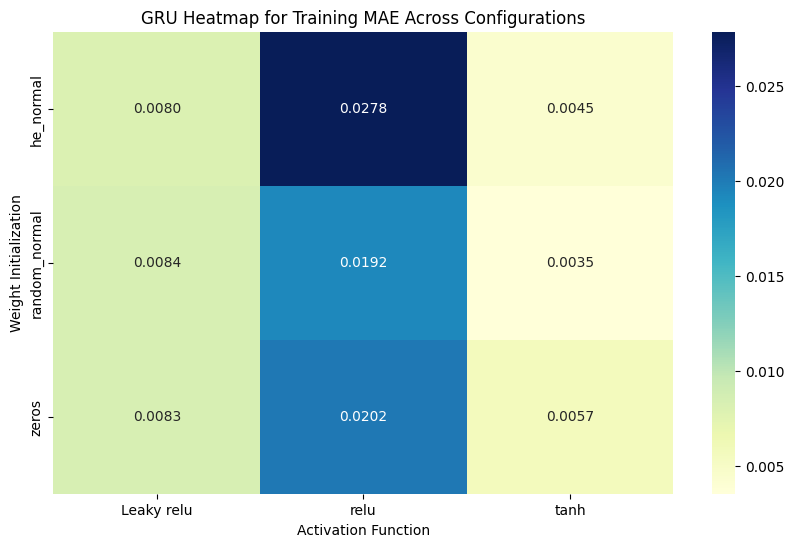

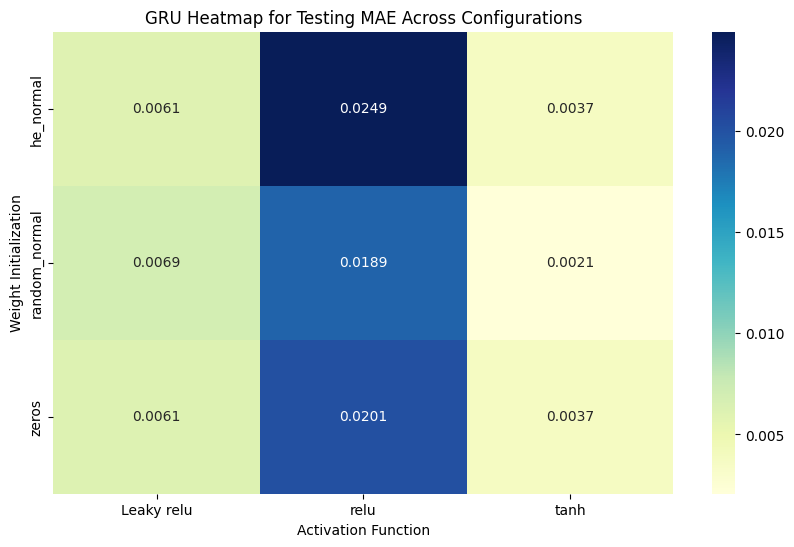

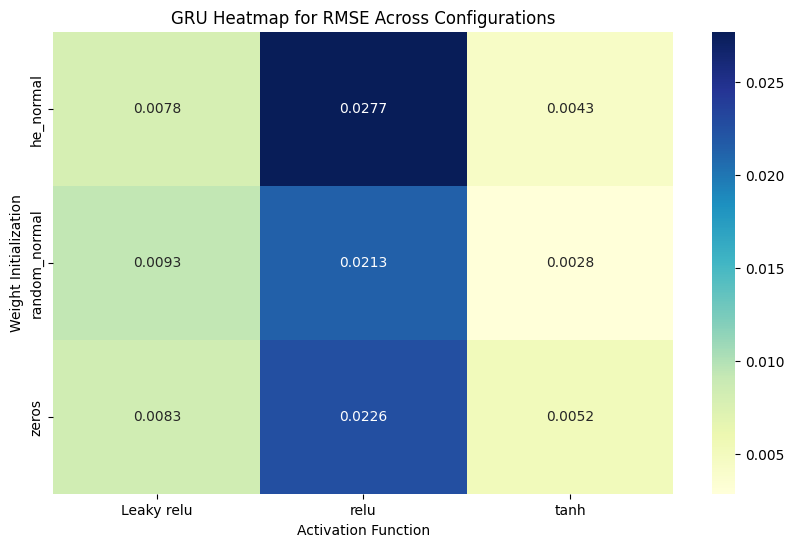

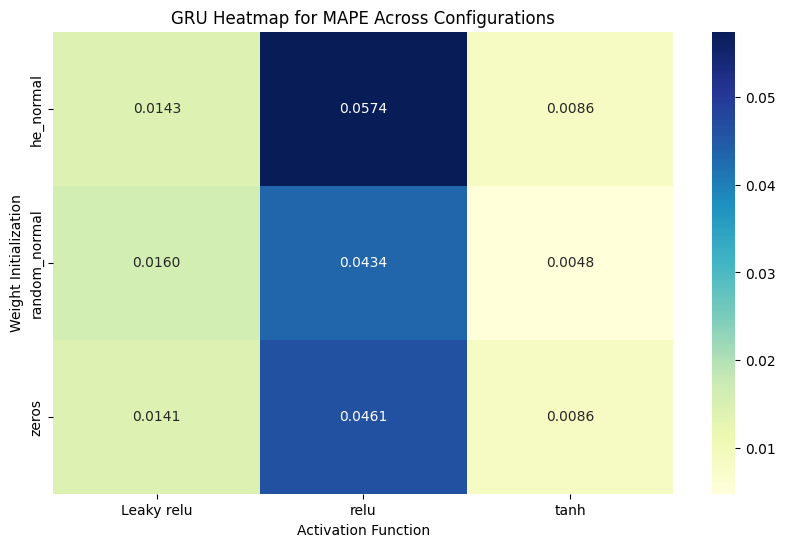

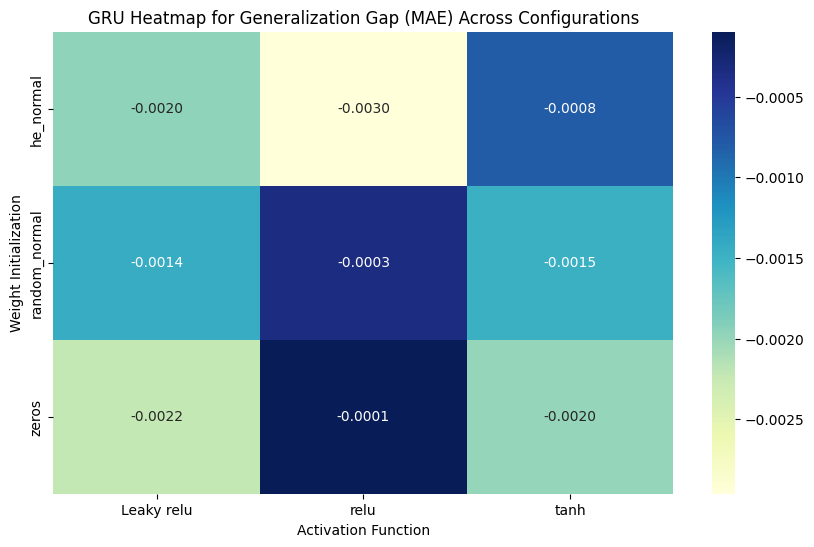

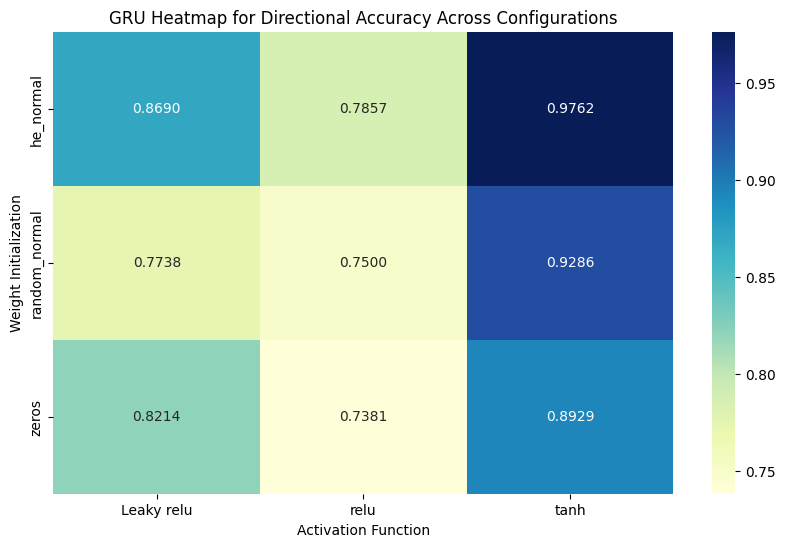

In [ ]:
# ----------------- GRU Model -----------------
import os
import pandas as pd
import numpy as np
from google.colab import drive
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Custom weight initializer for zeros with noise
from tensorflow.keras.initializers import Initializer
import tensorflow.keras.backend as K

class ZerosWithNoise(Initializer):
    def __init__(self, noise_level=1e-5):
        self.noise_level = noise_level

    def __call__(self, shape, dtype=None):
        return K.random_uniform(shape, minval=-self.noise_level, maxval=self.noise_level, dtype=dtype)

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Define file paths
root_dir = '/content/drive/My Drive/RNNs For Stock Prediction - 1906525'
data_dir = os.path.join(root_dir, 'data/cleaned')
train_file_path = os.path.join(data_dir, 'train_cleaned.csv')
validation_file_path = os.path.join(data_dir, 'validation_cleaned.csv')
test_file_path = os.path.join(data_dir, 'test_cleaned.csv')

# Load the cleaned data
train_data = pd.read_csv(train_file_path)
validation_data = pd.read_csv(validation_file_path)
test_data = pd.read_csv(test_file_path)

# Prepare data for the model
features = ['Close', 'Volume'] + [f'Close_lag{i}' for i in range(1, 6)]
target = 'Close'

X_train = train_data[features].values
y_train = train_data[target].values

X_val = validation_data[features].values
y_val = validation_data[target].values

X_test = test_data[features].values
y_test = test_data[target].values

# Save original y_test for later use
y_test_orig = y_test.copy()

# Scale features
from sklearn.preprocessing import MinMaxScaler

# Create scalers
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

# Fit scalers on training data
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))

# Transform validation and test data
X_val_scaled = scaler_X.transform(X_val)
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1))
X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

# Reshape data for GRU
X_train = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_val = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))
X_test_full = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))  # For full evaluation

y_train = y_train_scaled
y_val = y_val_scaled
y_test_full = y_test_scaled  # For full evaluation

# Directory to save results
results_dir = os.path.join(root_dir, 'results')
os.makedirs(results_dir, exist_ok=True)

results = []

# Initialize hyperparameter index and prediction results
hyperparameter_index = 0
prediction_results = []

# Cosine annealing learning rate function
def cosine_annealing(epoch, lr_max=0.001, lr_min=1e-6, T_max=40):
    return lr_min + 0.5 * (lr_max - lr_min) * (1 + math.cos(math.pi * epoch / T_max))

# Experiment loop
activation_functions = ['relu', 'tanh', 'Leaky relu']
weight_initializations = ['random_normal', 'zeros', 'he_normal']
epochs_list = [10, 20, 30, 40, 50, 100]

for activation_function in activation_functions:
    for weight_initialization in weight_initializations:
        for epochs in epochs_list:
            # Adjust T_max for the learning rate scheduler based on epochs
            def cosine_annealing(epoch, lr_max=0.001, lr_min=1e-6, T_max=epochs):
                return lr_min + 0.5 * (lr_max - lr_min) * (1 + math.cos(math.pi * epoch / T_max))

            # Define the GRU model
            model = Sequential()

            # Use custom initializer for 'zeros' to add small noise
            if weight_initialization == 'zeros':
                weight_initializer = ZerosWithNoise()
            else:
                weight_initializer = weight_initialization

            model.add(GRU(64, kernel_initializer=weight_initializer,
                          input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))

            # Handle activation functions
            if activation_function == 'Leaky relu':
                model.add(LeakyReLU(alpha=0.2))  # Add LeakyReLU with alpha
                model.add(Dropout(0.3))  # Add dropout for regularization
                model.add(Dense(32))  # No activation for LeakyReLU
            else:
                model.add(Dense(64, activation=activation_function))
                model.add(Dropout(0.3))  # Add dropout for regularization
                model.add(Dense(32, activation=activation_function))

            model.add(Dense(1))  # Output layer

            # Compile the model with gradient clipping and MAE loss
            model.compile(optimizer=Adam(clipnorm=1.0), loss='mean_absolute_error', metrics=['mae'])

            # Define callbacks
            reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)
            lr_scheduler = LearningRateScheduler(cosine_annealing)
            early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

            # Train the model
            history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                                epochs=epochs, batch_size=32, verbose=2,
                                callbacks=[reduce_lr, lr_scheduler, early_stopping])

            # Evaluate the model on full test set (retain original functionality)
            test_loss, test_mae = model.evaluate(X_test_full, y_test_full, verbose=2)

            # Predict and inverse transform on full test set
            y_pred_full = model.predict(X_test_full, verbose=0)
            y_pred_full_inverse = scaler_y.inverse_transform(y_pred_full)
            y_test_full_actual = scaler_y.inverse_transform(y_test_full)

            # Calculate additional metrics on full test set
            train_loss, train_mae = model.evaluate(X_train, y_train, verbose=0)
            rmse = np.sqrt(mean_squared_error(y_test_full_actual, y_pred_full_inverse))
            mape = mean_absolute_percentage_error(y_test_full_actual, y_pred_full_inverse)
            try:
                correlation_coefficient, _ = pearsonr(y_test_full_actual.flatten(), y_pred_full_inverse.flatten())
            except Exception:
                correlation_coefficient = np.nan  # Assign NaN if correlation cannot be computed

            directional_accuracy = np.mean((np.sign(y_test_full_actual[1:] - y_test_full_actual[:-1]) == np.sign(y_pred_full_inverse[1:] - y_pred_full_inverse[:-1])).astype(int))
            generalization_gap_mae = test_mae - train_mae

            # Store results (retain original functionality)
            results.append({
                'Activation Function': activation_function,
                'Weight Initialization': weight_initialization,
                'Epochs': epochs,
                'Training MAE': train_mae,
                'Testing MAE': test_mae,
                'Correlation Coefficient': correlation_coefficient,
                'Directional Accuracy': directional_accuracy,
                'RMSE': rmse,
                'MAPE': mape,
                'Generalization Gap (MAE)': generalization_gap_mae
            })

            # ----------------- Testing Part Integration -----------------
            # Get the index of the test data row
            idx = hyperparameter_index % len(test_data)

            # Get the test data row
            test_row = test_data.iloc[idx]

            # Extract features
            X_test_row = test_row[features].values.reshape(1, -1)

            # Scale features
            X_test_row_scaled = scaler_X.transform(X_test_row)

            # Reshape for model
            X_test_row_scaled = X_test_row_scaled.reshape((1, 1, X_test_row_scaled.shape[1]))

            # Make prediction
            y_pred_row = model.predict(X_test_row_scaled, verbose=0)

            # Inverse transform prediction
            y_pred_row = scaler_y.inverse_transform(y_pred_row)

            # Get actual Close value
            y_test_row_actual = test_row[target]

            # Collect Open, High, Low, Volume, Date
            Open = test_row['Open']
            High = test_row['High']
            Low = test_row['Low']
            Volume = test_row['Volume']
            Date = test_row['Date']

            # Calculate Difference
            Difference = y_pred_row[0][0] - y_test_row_actual

            # Compute MSE for the single data point
            MSE = Difference ** 2

            # Append to prediction_results
            prediction_results.append({
                'Date': Date,
                'Open': Open,
                'High': High,
                'Low': Low,
                'Volume': Volume,
                'Close (Actual)': y_test_row_actual,
                'Close (Predicted)': y_pred_row[0][0],
                'Difference': Difference,
                'Activation Function': activation_function,
                'Weight Initialization': weight_initialization,
                'Epochs': epochs,
                'MSE': MSE,
            })

            # Increment hyperparameter index
            hyperparameter_index += 1

# Save results to CSV
results_df = pd.DataFrame(results)
results_csv_path = os.path.join(results_dir, 'GRU_results_Final.csv')
results_df.to_csv(results_csv_path, index=False)

# Reorder columns in prediction_results
columns_order = ['Date', 'Open', 'High', 'Low', 'Volume', 'Close (Actual)', 'Close (Predicted)', 'Difference',
                 'Activation Function', 'Weight Initialization', 'Epochs', 'MSE']
prediction_results_df = pd.DataFrame(prediction_results)[columns_order]

# Save prediction results to CSV
prediction_results_csv_path = os.path.join(results_dir, 'GRU_Testing_PredVsAct.csv')
prediction_results_df.to_csv(prediction_results_csv_path, index=False)

# Heatmap Visualization
metrics = ['Training MAE', 'Testing MAE', 'RMSE', 'MAPE', 'Generalization Gap (MAE)', 'Directional Accuracy']
for metric in metrics:
    heatmap_data = results_df.pivot_table(index='Weight Initialization', columns='Activation Function',
                                          values=metric, aggfunc='mean')
    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='.4f')
    plt.title(f'GRU Heatmap for {metric} Across Configurations')
    plt.show()


3) LSTM Model

Mounted at /content/drive
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 4s - 70ms/step - loss: 0.1040 - mae: 0.1040 - val_loss: 0.0191 - val_mae: 0.0191 - learning_rate: 0.0010
Epoch 2/10
59/59 - 0s - 7ms/step - loss: 0.0390 - mae: 0.0390 - val_loss: 0.0190 - val_mae: 0.0190 - learning_rate: 9.7555e-04
Epoch 3/10
59/59 - 1s - 11ms/step - loss: 0.0341 - mae: 0.0341 - val_loss: 0.0202 - val_mae: 0.0202 - learning_rate: 8.8249e-04
Epoch 4/10
59/59 - 1s - 12ms/step - loss: 0.0305 - mae: 0.0305 - val_loss: 0.0275 - val_mae: 0.0275 - learning_rate: 7.0081e-04
Epoch 5/10
59/59 - 1s - 10ms/step - loss: 0.0293 - mae: 0.0293 - val_loss: 0.0209 - val_mae: 0.0209 - learning_rate: 4.5903e-04
Epoch 6/10

Epoch 6: ReduceLROnPlateau reducing learning rate to 4.600312095135451e-05.
59/59 - 1s - 11ms/step - loss: 0.0279 - mae: 0.0279 - val_loss: 0.0233 - val_mae: 0.0233 - learning_rate: 4.6003e-05
Epoch 7/10
59/59 - 0s - 7ms/step - loss: 0.0281 - mae: 0.0281 - val_loss: 0.0209 - val_mae: 0.0209 - learning_rate: 1.6548e-05
Epoch 8/10
59/59 - 1s - 9ms/step - loss: 0.0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 4s - 63ms/step - loss: 0.1327 - mae: 0.1327 - val_loss: 0.0194 - val_mae: 0.0194 - learning_rate: 0.0010
Epoch 2/20
59/59 - 0s - 4ms/step - loss: 0.0410 - mae: 0.0410 - val_loss: 0.0213 - val_mae: 0.0213 - learning_rate: 9.9385e-04
Epoch 3/20
59/59 - 0s - 5ms/step - loss: 0.0347 - mae: 0.0347 - val_loss: 0.0179 - val_mae: 0.0179 - learning_rate: 9.6955e-04
Epoch 4/20
59/59 - 0s - 5ms/step - loss: 0.0316 - mae: 0.0316 - val_loss: 0.0221 - val_mae: 0.0221 - learning_rate: 9.1677e-04
Epoch 5/20
59/59 - 0s - 6ms/step - loss: 0.0298 - mae: 0.0298 - val_loss: 0.0194 - val_mae: 0.0194 - learning_rate: 8.2932e-04
Epoch 6/20
59/59 - 0s - 6ms/step - loss: 0.0285 - mae: 0.0285 - val_loss: 0.0188 - val_mae: 0.0188 - learning_rate: 7.0802e-04
Epoch 7/20
59/59 - 0s - 7ms/step - loss: 0.0271 - mae: 0.0271 - val_loss: 0.0175 - val_mae: 0.0175 - learning_rate: 5.6230e-04
Epoch 8/20
59/59 - 0s - 5ms/step - loss: 0.0264 - mae: 0.0264 - val_loss: 0.0163 - val_mae: 0.0163 - learning_rate: 4.0906e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 3s - 57ms/step - loss: 0.1156 - mae: 0.1156 - val_loss: 0.0176 - val_mae: 0.0176 - learning_rate: 0.0010
Epoch 2/30
59/59 - 0s - 6ms/step - loss: 0.0379 - mae: 0.0379 - val_loss: 0.0182 - val_mae: 0.0182 - learning_rate: 9.9726e-04
Epoch 3/30
59/59 - 0s - 5ms/step - loss: 0.0329 - mae: 0.0329 - val_loss: 0.0168 - val_mae: 0.0168 - learning_rate: 9.8638e-04
Epoch 4/30
59/59 - 0s - 5ms/step - loss: 0.0312 - mae: 0.0312 - val_loss: 0.0167 - val_mae: 0.0167 - learning_rate: 9.6226e-04
Epoch 5/30
59/59 - 0s - 4ms/step - loss: 0.0292 - mae: 0.0292 - val_loss: 0.0229 - val_mae: 0.0229 - learning_rate: 9.2071e-04
Epoch 6/30
59/59 - 0s - 5ms/step - loss: 0.0272 - mae: 0.0272 - val_loss: 0.0147 - val_mae: 0.0147 - learning_rate: 8.5910e-04
Epoch 7/30
59/59 - 0s - 5ms/step - loss: 0.0243 - mae: 0.0243 - val_loss: 0.0165 - val_mae: 0.0165 - learning_rate: 7.7716e-04
Epoch 8/30
59/59 - 0s - 5ms/step - loss: 0.0254 - mae: 0.0254 - val_loss: 0.0127 - val_mae: 0.0127 - learning_rate: 6.7748e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 3s - 59ms/step - loss: 0.1259 - mae: 0.1259 - val_loss: 0.0345 - val_mae: 0.0345 - learning_rate: 0.0010
Epoch 2/40
59/59 - 0s - 4ms/step - loss: 0.0401 - mae: 0.0401 - val_loss: 0.0217 - val_mae: 0.0217 - learning_rate: 9.9846e-04
Epoch 3/40
59/59 - 0s - 5ms/step - loss: 0.0325 - mae: 0.0325 - val_loss: 0.0176 - val_mae: 0.0176 - learning_rate: 9.9232e-04
Epoch 4/40
59/59 - 0s - 5ms/step - loss: 0.0311 - mae: 0.0311 - val_loss: 0.0163 - val_mae: 0.0163 - learning_rate: 9.7862e-04
Epoch 5/40
59/59 - 0s - 5ms/step - loss: 0.0291 - mae: 0.0291 - val_loss: 0.0144 - val_mae: 0.0144 - learning_rate: 9.5470e-04
Epoch 6/40
59/59 - 0s - 5ms/step - loss: 0.0286 - mae: 0.0286 - val_loss: 0.0173 - val_mae: 0.0173 - learning_rate: 9.1840e-04
Epoch 7/40
59/59 - 0s - 5ms/step - loss: 0.0262 - mae: 0.0262 - val_loss: 0.0199 - val_mae: 0.0199 - learning_rate: 8.6841e-04
Epoch 8/40
59/59 - 0s - 4ms/step - loss: 0.0249 - mae: 0.0249 - val_loss: 0.0200 - val_mae: 0.0200 - learning_rate: 8.0450e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 21s - 359ms/step - loss: 0.1072 - mae: 0.1072 - val_loss: 0.0184 - val_mae: 0.0184 - learning_rate: 0.0010
Epoch 2/50
59/59 - 4s - 62ms/step - loss: 0.0379 - mae: 0.0379 - val_loss: 0.0213 - val_mae: 0.0213 - learning_rate: 9.9901e-04
Epoch 3/50
59/59 - 1s - 11ms/step - loss: 0.0349 - mae: 0.0349 - val_loss: 0.0206 - val_mae: 0.0206 - learning_rate: 9.9508e-04
Epoch 4/50
59/59 - 0s - 5ms/step - loss: 0.0329 - mae: 0.0329 - val_loss: 0.0208 - val_mae: 0.0208 - learning_rate: 9.8628e-04
Epoch 5/50
59/59 - 1s - 11ms/step - loss: 0.0302 - mae: 0.0302 - val_loss: 0.0162 - val_mae: 0.0162 - learning_rate: 9.7080e-04
Epoch 6/50
59/59 - 1s - 11ms/step - loss: 0.0276 - mae: 0.0276 - val_loss: 0.0150 - val_mae: 0.0150 - learning_rate: 9.4707e-04
Epoch 7/50
59/59 - 0s - 5ms/step - loss: 0.0256 - mae: 0.0256 - val_loss: 0.0142 - val_mae: 0.0142 - learning_rate: 9.1385e-04
Epoch 8/50
59/59 - 0s - 5ms/step - loss: 0.0245 - mae: 0.0245 - val_loss: 0.0144 - val_mae: 0.0144 - learning_rate: 8.7

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 4s - 74ms/step - loss: 0.1182 - mae: 0.1182 - val_loss: 0.0202 - val_mae: 0.0202 - learning_rate: 0.0010
Epoch 2/100
59/59 - 1s - 14ms/step - loss: 0.0374 - mae: 0.0374 - val_loss: 0.0182 - val_mae: 0.0182 - learning_rate: 9.9975e-04
Epoch 3/100
59/59 - 0s - 5ms/step - loss: 0.0337 - mae: 0.0337 - val_loss: 0.0171 - val_mae: 0.0171 - learning_rate: 9.9877e-04
Epoch 4/100
59/59 - 0s - 6ms/step - loss: 0.0309 - mae: 0.0309 - val_loss: 0.0209 - val_mae: 0.0209 - learning_rate: 9.9655e-04
Epoch 5/100
59/59 - 0s - 5ms/step - loss: 0.0291 - mae: 0.0291 - val_loss: 0.0202 - val_mae: 0.0202 - learning_rate: 9.9263e-04
Epoch 6/100
59/59 - 0s - 5ms/step - loss: 0.0274 - mae: 0.0274 - val_loss: 0.0178 - val_mae: 0.0178 - learning_rate: 9.8652e-04
Epoch 7/100
59/59 - 0s - 6ms/step - loss: 0.0255 - mae: 0.0255 - val_loss: 0.0212 - val_mae: 0.0212 - learning_rate: 9.7780e-04
Epoch 8/100
59/59 - 0s - 5ms/step - loss: 0.0255 - mae: 0.0255 - val_loss: 0.0165 - val_mae: 0.0165 - learning_rate: 9

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 4s - 68ms/step - loss: 0.1480 - mae: 0.1480 - val_loss: 0.0308 - val_mae: 0.0308 - learning_rate: 0.0010
Epoch 2/10
59/59 - 1s - 15ms/step - loss: 0.0431 - mae: 0.0431 - val_loss: 0.0208 - val_mae: 0.0208 - learning_rate: 9.7555e-04
Epoch 3/10
59/59 - 0s - 5ms/step - loss: 0.0369 - mae: 0.0369 - val_loss: 0.0206 - val_mae: 0.0206 - learning_rate: 8.8249e-04
Epoch 4/10
59/59 - 0s - 5ms/step - loss: 0.0329 - mae: 0.0329 - val_loss: 0.0171 - val_mae: 0.0171 - learning_rate: 7.0081e-04
Epoch 5/10
59/59 - 0s - 5ms/step - loss: 0.0325 - mae: 0.0325 - val_loss: 0.0192 - val_mae: 0.0192 - learning_rate: 4.5903e-04
Epoch 6/10
59/59 - 0s - 6ms/step - loss: 0.0308 - mae: 0.0308 - val_loss: 0.0184 - val_mae: 0.0184 - learning_rate: 2.3002e-04
Epoch 7/10
59/59 - 0s - 5ms/step - loss: 0.0308 - mae: 0.0308 - val_loss: 0.0187 - val_mae: 0.0187 - learning_rate: 8.0123e-05
Epoch 8/10
59/59 - 1s - 13ms/step - loss: 0.0308 - mae: 0.0308 - val_loss: 0.0189 - val_mae: 0.0189 - learning_rate: 1.7308e

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
59/59 - 4s - 68ms/step - loss: 0.1199 - mae: 0.1199 - val_loss: 0.0219 - val_mae: 0.0219 - learning_rate: 0.0010
Epoch 2/20
59/59 - 0s - 5ms/step - loss: 0.0382 - mae: 0.0382 - val_loss: 0.0245 - val_mae: 0.0245 - learning_rate: 9.9385e-04
Epoch 3/20
59/59 - 0s - 6ms/step - loss: 0.0350 - mae: 0.0350 - val_loss: 0.0211 - val_mae: 0.0211 - learning_rate: 9.6955e-04
Epoch 4/20
59/59 - 1s - 11ms/step - loss: 0.0325 - mae: 0.0325 - val_loss: 0.0340 - val_mae: 0.0340 - learning_rate: 9.1677e-04
Epoch 5/20
59/59 - 0s - 6ms/step - loss: 0.0330 - mae: 0.0330 - val_loss: 0.0223 - val_mae: 0.0223 - learning_rate: 8.2932e-04
Epoch 6/20
59/59 - 0s - 6ms/step - loss: 0.0279 - mae: 0.0279 - val_loss: 0.0238 - val_mae: 0.0238 - learning_rate: 7.0802e-04
Epoch 7/20
59/59 - 1s - 10ms/step - loss: 0.0282 - mae: 0.0282 - val_loss: 0.0243 - val_mae: 0.0243 - learning_rate: 5.6230e-04
Epoch 8/20

Epoch 8: ReduceLROnPlateau reducing learning rate to 8.181188022717834e-05.
59/59 - 0s - 5ms/step - 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 6s - 93ms/step - loss: 0.1316 - mae: 0.1316 - val_loss: 0.0237 - val_mae: 0.0237 - learning_rate: 0.0010
Epoch 2/30
59/59 - 0s - 5ms/step - loss: 0.0435 - mae: 0.0435 - val_loss: 0.0212 - val_mae: 0.0212 - learning_rate: 9.9726e-04
Epoch 3/30
59/59 - 0s - 6ms/step - loss: 0.0367 - mae: 0.0367 - val_loss: 0.0219 - val_mae: 0.0219 - learning_rate: 9.8638e-04
Epoch 4/30
59/59 - 0s - 5ms/step - loss: 0.0360 - mae: 0.0360 - val_loss: 0.0259 - val_mae: 0.0259 - learning_rate: 9.6226e-04
Epoch 5/30
59/59 - 0s - 5ms/step - loss: 0.0315 - mae: 0.0315 - val_loss: 0.0262 - val_mae: 0.0262 - learning_rate: 9.2071e-04
Epoch 6/30
59/59 - 0s - 5ms/step - loss: 0.0300 - mae: 0.0300 - val_loss: 0.0230 - val_mae: 0.0230 - learning_rate: 8.5910e-04
Epoch 7/30

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00015543221961706878.
59/59 - 0s - 5ms/step - loss: 0.0288 - mae: 0.0288 - val_loss: 0.0225 - val_mae: 0.0225 - learning_rate: 1.5543e-04
Epoch 8/30
59/59 - 0s - 5ms/step - loss: 0.0276

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 4s - 65ms/step - loss: 0.1323 - mae: 0.1323 - val_loss: 0.0218 - val_mae: 0.0218 - learning_rate: 0.0010
Epoch 2/40
59/59 - 0s - 5ms/step - loss: 0.0443 - mae: 0.0443 - val_loss: 0.0259 - val_mae: 0.0259 - learning_rate: 9.9846e-04
Epoch 3/40
59/59 - 0s - 6ms/step - loss: 0.0370 - mae: 0.0370 - val_loss: 0.0196 - val_mae: 0.0196 - learning_rate: 9.9232e-04
Epoch 4/40
59/59 - 0s - 6ms/step - loss: 0.0339 - mae: 0.0339 - val_loss: 0.0197 - val_mae: 0.0197 - learning_rate: 9.7862e-04
Epoch 5/40
59/59 - 1s - 12ms/step - loss: 0.0320 - mae: 0.0320 - val_loss: 0.0173 - val_mae: 0.0173 - learning_rate: 9.5470e-04
Epoch 6/40
59/59 - 0s - 7ms/step - loss: 0.0298 - mae: 0.0298 - val_loss: 0.0262 - val_mae: 0.0262 - learning_rate: 9.1840e-04
Epoch 7/40
59/59 - 0s - 7ms/step - loss: 0.0304 - mae: 0.0304 - val_loss: 0.0170 - val_mae: 0.0170 - learning_rate: 8.6841e-04
Epoch 8/40
59/59 - 1s - 11ms/step - loss: 0.0274 - mae: 0.0274 - val_loss: 0.0207 - val_mae: 0.0207 - learning_rate: 8.0450e

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 4s - 76ms/step - loss: 0.1348 - mae: 0.1348 - val_loss: 0.0272 - val_mae: 0.0272 - learning_rate: 0.0010
Epoch 2/50
59/59 - 1s - 13ms/step - loss: 0.0383 - mae: 0.0383 - val_loss: 0.0258 - val_mae: 0.0258 - learning_rate: 9.9901e-04
Epoch 3/50
59/59 - 1s - 10ms/step - loss: 0.0359 - mae: 0.0359 - val_loss: 0.0185 - val_mae: 0.0185 - learning_rate: 9.9508e-04
Epoch 4/50
59/59 - 1s - 11ms/step - loss: 0.0346 - mae: 0.0346 - val_loss: 0.0167 - val_mae: 0.0167 - learning_rate: 9.8628e-04
Epoch 5/50
59/59 - 0s - 8ms/step - loss: 0.0316 - mae: 0.0316 - val_loss: 0.0158 - val_mae: 0.0158 - learning_rate: 9.7080e-04
Epoch 6/50
59/59 - 1s - 11ms/step - loss: 0.0299 - mae: 0.0299 - val_loss: 0.0153 - val_mae: 0.0153 - learning_rate: 9.4707e-04
Epoch 7/50
59/59 - 0s - 5ms/step - loss: 0.0296 - mae: 0.0296 - val_loss: 0.0145 - val_mae: 0.0145 - learning_rate: 9.1385e-04
Epoch 8/50
59/59 - 1s - 10ms/step - loss: 0.0282 - mae: 0.0282 - val_loss: 0.0144 - val_mae: 0.0144 - learning_rate: 8.70

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 5s - 89ms/step - loss: 0.1340 - mae: 0.1340 - val_loss: 0.0253 - val_mae: 0.0253 - learning_rate: 0.0010
Epoch 2/100
59/59 - 1s - 10ms/step - loss: 0.0426 - mae: 0.0426 - val_loss: 0.0207 - val_mae: 0.0207 - learning_rate: 9.9975e-04
Epoch 3/100
59/59 - 1s - 10ms/step - loss: 0.0363 - mae: 0.0363 - val_loss: 0.0170 - val_mae: 0.0170 - learning_rate: 9.9877e-04
Epoch 4/100
59/59 - 0s - 5ms/step - loss: 0.0322 - mae: 0.0322 - val_loss: 0.0204 - val_mae: 0.0204 - learning_rate: 9.9655e-04
Epoch 5/100
59/59 - 1s - 11ms/step - loss: 0.0311 - mae: 0.0311 - val_loss: 0.0184 - val_mae: 0.0184 - learning_rate: 9.9263e-04
Epoch 6/100
59/59 - 1s - 10ms/step - loss: 0.0289 - mae: 0.0289 - val_loss: 0.0170 - val_mae: 0.0170 - learning_rate: 9.8652e-04
Epoch 7/100
59/59 - 0s - 5ms/step - loss: 0.0280 - mae: 0.0280 - val_loss: 0.0187 - val_mae: 0.0187 - learning_rate: 9.7780e-04
Epoch 8/100

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.00019320683786645533.
59/59 - 0s - 5ms/step - l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 5s - 81ms/step - loss: 0.0748 - mae: 0.0748 - val_loss: 0.0219 - val_mae: 0.0219 - learning_rate: 0.0010
Epoch 2/10
59/59 - 0s - 8ms/step - loss: 0.0383 - mae: 0.0383 - val_loss: 0.0251 - val_mae: 0.0251 - learning_rate: 9.7555e-04
Epoch 3/10
59/59 - 1s - 11ms/step - loss: 0.0306 - mae: 0.0306 - val_loss: 0.0288 - val_mae: 0.0288 - learning_rate: 8.8249e-04
Epoch 4/10
59/59 - 0s - 8ms/step - loss: 0.0279 - mae: 0.0279 - val_loss: 0.0373 - val_mae: 0.0373 - learning_rate: 7.0081e-04
Epoch 5/10
59/59 - 1s - 11ms/step - loss: 0.0251 - mae: 0.0251 - val_loss: 0.0343 - val_mae: 0.0343 - learning_rate: 4.5903e-04
Epoch 6/10

Epoch 6: ReduceLROnPlateau reducing learning rate to 4.600312095135451e-05.
59/59 - 0s - 5ms/step - loss: 0.0245 - mae: 0.0245 - val_loss: 0.0373 - val_mae: 0.0373 - learning_rate: 4.6003e-05
Epoch 7/10
59/59 - 0s - 5ms/step - loss: 0.0226 - mae: 0.0226 - val_loss: 0.0344 - val_mae: 0.0344 - learning_rate: 1.6548e-05
Epoch 8/10
59/59 - 0s - 6ms/step - loss: 0.023

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 4s - 66ms/step - loss: 0.0968 - mae: 0.0968 - val_loss: 0.0202 - val_mae: 0.0202 - learning_rate: 0.0010
Epoch 2/20
59/59 - 0s - 5ms/step - loss: 0.0402 - mae: 0.0402 - val_loss: 0.0285 - val_mae: 0.0285 - learning_rate: 9.9385e-04
Epoch 3/20
59/59 - 0s - 5ms/step - loss: 0.0307 - mae: 0.0307 - val_loss: 0.0437 - val_mae: 0.0437 - learning_rate: 9.6955e-04
Epoch 4/20
59/59 - 0s - 4ms/step - loss: 0.0266 - mae: 0.0266 - val_loss: 0.0373 - val_mae: 0.0373 - learning_rate: 9.1677e-04
Epoch 5/20
59/59 - 0s - 6ms/step - loss: 0.0230 - mae: 0.0230 - val_loss: 0.0418 - val_mae: 0.0418 - learning_rate: 8.2932e-04
Epoch 6/20

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00014160346472635865.
59/59 - 1s - 10ms/step - loss: 0.0210 - mae: 0.0210 - val_loss: 0.0415 - val_mae: 0.0415 - learning_rate: 1.4160e-04
Epoch 7/20
59/59 - 0s - 5ms/step - loss: 0.0186 - mae: 0.0186 - val_loss: 0.0429 - val_mae: 0.0429 - learning_rate: 1.1262e-04
Epoch 8/20
59/59 - 0s - 7ms/step - loss: 0.018

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 4s - 66ms/step - loss: 0.0805 - mae: 0.0805 - val_loss: 0.0180 - val_mae: 0.0180 - learning_rate: 0.0010
Epoch 2/30
59/59 - 1s - 16ms/step - loss: 0.0391 - mae: 0.0391 - val_loss: 0.0188 - val_mae: 0.0188 - learning_rate: 9.9726e-04
Epoch 3/30
59/59 - 0s - 5ms/step - loss: 0.0328 - mae: 0.0328 - val_loss: 0.0295 - val_mae: 0.0295 - learning_rate: 9.8638e-04
Epoch 4/30
59/59 - 0s - 5ms/step - loss: 0.0274 - mae: 0.0274 - val_loss: 0.0225 - val_mae: 0.0225 - learning_rate: 9.6226e-04
Epoch 5/30
59/59 - 1s - 10ms/step - loss: 0.0255 - mae: 0.0255 - val_loss: 0.0309 - val_mae: 0.0309 - learning_rate: 9.2071e-04
Epoch 6/30
59/59 - 0s - 5ms/step - loss: 0.0237 - mae: 0.0237 - val_loss: 0.0175 - val_mae: 0.0175 - learning_rate: 8.5910e-04
Epoch 7/30
59/59 - 0s - 5ms/step - loss: 0.0222 - mae: 0.0222 - val_loss: 0.0326 - val_mae: 0.0326 - learning_rate: 7.7716e-04
Epoch 8/30
59/59 - 0s - 5ms/step - loss: 0.0203 - mae: 0.0203 - val_loss: 0.0271 - val_mae: 0.0271 - learning_rate: 6.7748e

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 5s - 86ms/step - loss: 0.0950 - mae: 0.0950 - val_loss: 0.0173 - val_mae: 0.0173 - learning_rate: 0.0010
Epoch 2/40
59/59 - 0s - 5ms/step - loss: 0.0420 - mae: 0.0420 - val_loss: 0.0145 - val_mae: 0.0145 - learning_rate: 9.9846e-04
Epoch 3/40
59/59 - 1s - 11ms/step - loss: 0.0353 - mae: 0.0353 - val_loss: 0.0285 - val_mae: 0.0285 - learning_rate: 9.9232e-04
Epoch 4/40
59/59 - 1s - 10ms/step - loss: 0.0303 - mae: 0.0303 - val_loss: 0.0214 - val_mae: 0.0214 - learning_rate: 9.7862e-04
Epoch 5/40
59/59 - 1s - 11ms/step - loss: 0.0291 - mae: 0.0291 - val_loss: 0.0312 - val_mae: 0.0312 - learning_rate: 9.5470e-04
Epoch 6/40
59/59 - 1s - 11ms/step - loss: 0.0249 - mae: 0.0249 - val_loss: 0.0332 - val_mae: 0.0332 - learning_rate: 9.1840e-04
Epoch 7/40

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00017368145054206253.
59/59 - 0s - 5ms/step - loss: 0.0230 - mae: 0.0230 - val_loss: 0.0253 - val_mae: 0.0253 - learning_rate: 1.7368e-04
Epoch 8/40
59/59 - 0s - 5ms/step - loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 3s - 59ms/step - loss: 0.1264 - mae: 0.1264 - val_loss: 0.0185 - val_mae: 0.0185 - learning_rate: 0.0010
Epoch 2/50
59/59 - 0s - 4ms/step - loss: 0.0395 - mae: 0.0395 - val_loss: 0.0181 - val_mae: 0.0181 - learning_rate: 9.9901e-04
Epoch 3/50
59/59 - 0s - 5ms/step - loss: 0.0337 - mae: 0.0337 - val_loss: 0.0199 - val_mae: 0.0199 - learning_rate: 9.9508e-04
Epoch 4/50
59/59 - 0s - 8ms/step - loss: 0.0295 - mae: 0.0295 - val_loss: 0.0195 - val_mae: 0.0195 - learning_rate: 9.8628e-04
Epoch 5/50
59/59 - 1s - 11ms/step - loss: 0.0276 - mae: 0.0276 - val_loss: 0.0273 - val_mae: 0.0273 - learning_rate: 9.7080e-04
Epoch 6/50
59/59 - 0s - 7ms/step - loss: 0.0242 - mae: 0.0242 - val_loss: 0.0200 - val_mae: 0.0200 - learning_rate: 9.4707e-04
Epoch 7/50

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00018276956398040057.
59/59 - 1s - 9ms/step - loss: 0.0245 - mae: 0.0245 - val_loss: 0.0206 - val_mae: 0.0206 - learning_rate: 1.8277e-04
Epoch 8/50
59/59 - 1s - 9ms/step - loss: 0.022

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 4s - 65ms/step - loss: 0.0921 - mae: 0.0921 - val_loss: 0.0161 - val_mae: 0.0161 - learning_rate: 0.0010
Epoch 2/100
59/59 - 0s - 5ms/step - loss: 0.0428 - mae: 0.0428 - val_loss: 0.0111 - val_mae: 0.0111 - learning_rate: 9.9975e-04
Epoch 3/100
59/59 - 0s - 5ms/step - loss: 0.0340 - mae: 0.0340 - val_loss: 0.0156 - val_mae: 0.0156 - learning_rate: 9.9877e-04
Epoch 4/100
59/59 - 0s - 5ms/step - loss: 0.0297 - mae: 0.0297 - val_loss: 0.0181 - val_mae: 0.0181 - learning_rate: 9.9655e-04
Epoch 5/100
59/59 - 0s - 5ms/step - loss: 0.0263 - mae: 0.0263 - val_loss: 0.0256 - val_mae: 0.0256 - learning_rate: 9.9263e-04
Epoch 6/100
59/59 - 0s - 5ms/step - loss: 0.0256 - mae: 0.0256 - val_loss: 0.0251 - val_mae: 0.0251 - learning_rate: 9.8652e-04
Epoch 7/100

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00019555927719920875.
59/59 - 0s - 6ms/step - loss: 0.0225 - mae: 0.0225 - val_loss: 0.0327 - val_mae: 0.0327 - learning_rate: 1.9556e-04
Epoch 8/100
59/59 - 0s - 5ms/step - loss:

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 5s - 85ms/step - loss: 0.0802 - mae: 0.0802 - val_loss: 0.0232 - val_mae: 0.0232 - learning_rate: 0.0010
Epoch 2/10
59/59 - 0s - 5ms/step - loss: 0.0287 - mae: 0.0287 - val_loss: 0.0167 - val_mae: 0.0167 - learning_rate: 9.7555e-04
Epoch 3/10
59/59 - 0s - 5ms/step - loss: 0.0271 - mae: 0.0271 - val_loss: 0.0159 - val_mae: 0.0159 - learning_rate: 8.8249e-04
Epoch 4/10
59/59 - 0s - 5ms/step - loss: 0.0249 - mae: 0.0249 - val_loss: 0.0134 - val_mae: 0.0134 - learning_rate: 7.0081e-04
Epoch 5/10
59/59 - 0s - 6ms/step - loss: 0.0218 - mae: 0.0218 - val_loss: 0.0146 - val_mae: 0.0146 - learning_rate: 4.5903e-04
Epoch 6/10
59/59 - 1s - 10ms/step - loss: 0.0207 - mae: 0.0207 - val_loss: 0.0122 - val_mae: 0.0122 - learning_rate: 2.3002e-04
Epoch 7/10
59/59 - 0s - 5ms/step - loss: 0.0195 - mae: 0.0195 - val_loss: 0.0119 - val_mae: 0.0119 - learning_rate: 8.0123e-05
Epoch 8/10
59/59 - 0s - 5ms/step - loss: 0.0193 - mae: 0.0193 - val_loss: 0.0120 - val_mae: 0.0120 - learning_rate: 1.7308e-

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 4s - 60ms/step - loss: 0.0898 - mae: 0.0898 - val_loss: 0.0250 - val_mae: 0.0250 - learning_rate: 0.0010
Epoch 2/20
59/59 - 0s - 5ms/step - loss: 0.0327 - mae: 0.0327 - val_loss: 0.0176 - val_mae: 0.0176 - learning_rate: 9.9385e-04
Epoch 3/20
59/59 - 0s - 5ms/step - loss: 0.0269 - mae: 0.0269 - val_loss: 0.0159 - val_mae: 0.0159 - learning_rate: 9.6955e-04
Epoch 4/20
59/59 - 0s - 4ms/step - loss: 0.0239 - mae: 0.0239 - val_loss: 0.0159 - val_mae: 0.0159 - learning_rate: 9.1677e-04
Epoch 5/20
59/59 - 0s - 5ms/step - loss: 0.0236 - mae: 0.0236 - val_loss: 0.0146 - val_mae: 0.0146 - learning_rate: 8.2932e-04
Epoch 6/20
59/59 - 0s - 5ms/step - loss: 0.0208 - mae: 0.0208 - val_loss: 0.0119 - val_mae: 0.0119 - learning_rate: 7.0802e-04
Epoch 7/20
59/59 - 0s - 7ms/step - loss: 0.0192 - mae: 0.0192 - val_loss: 0.0108 - val_mae: 0.0108 - learning_rate: 5.6230e-04
Epoch 8/20
59/59 - 1s - 11ms/step - loss: 0.0173 - mae: 0.0173 - val_loss: 0.0097 - val_mae: 0.0097 - learning_rate: 4.0906e-

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 3s - 59ms/step - loss: 0.0858 - mae: 0.0858 - val_loss: 0.0202 - val_mae: 0.0202 - learning_rate: 0.0010
Epoch 2/30
59/59 - 0s - 5ms/step - loss: 0.0306 - mae: 0.0306 - val_loss: 0.0166 - val_mae: 0.0166 - learning_rate: 9.9726e-04
Epoch 3/30
59/59 - 0s - 4ms/step - loss: 0.0270 - mae: 0.0270 - val_loss: 0.0159 - val_mae: 0.0159 - learning_rate: 9.8638e-04
Epoch 4/30
59/59 - 0s - 5ms/step - loss: 0.0253 - mae: 0.0253 - val_loss: 0.0147 - val_mae: 0.0147 - learning_rate: 9.6226e-04
Epoch 5/30
59/59 - 0s - 5ms/step - loss: 0.0230 - mae: 0.0230 - val_loss: 0.0122 - val_mae: 0.0122 - learning_rate: 9.2071e-04
Epoch 6/30
59/59 - 0s - 5ms/step - loss: 0.0202 - mae: 0.0202 - val_loss: 0.0106 - val_mae: 0.0106 - learning_rate: 8.5910e-04
Epoch 7/30
59/59 - 0s - 4ms/step - loss: 0.0192 - mae: 0.0192 - val_loss: 0.0171 - val_mae: 0.0171 - learning_rate: 7.7716e-04
Epoch 8/30
59/59 - 0s - 4ms/step - loss: 0.0189 - mae: 0.0189 - val_loss: 0.0091 - val_mae: 0.0091 - learning_rate: 6.7748e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 4s - 62ms/step - loss: 0.0801 - mae: 0.0801 - val_loss: 0.0177 - val_mae: 0.0177 - learning_rate: 0.0010
Epoch 2/40
59/59 - 0s - 7ms/step - loss: 0.0296 - mae: 0.0296 - val_loss: 0.0256 - val_mae: 0.0256 - learning_rate: 9.9846e-04
Epoch 3/40
59/59 - 1s - 9ms/step - loss: 0.0275 - mae: 0.0275 - val_loss: 0.0163 - val_mae: 0.0163 - learning_rate: 9.9232e-04
Epoch 4/40
59/59 - 1s - 9ms/step - loss: 0.0244 - mae: 0.0244 - val_loss: 0.0146 - val_mae: 0.0146 - learning_rate: 9.7862e-04
Epoch 5/40
59/59 - 1s - 11ms/step - loss: 0.0219 - mae: 0.0219 - val_loss: 0.0197 - val_mae: 0.0197 - learning_rate: 9.5470e-04
Epoch 6/40
59/59 - 1s - 9ms/step - loss: 0.0209 - mae: 0.0209 - val_loss: 0.0119 - val_mae: 0.0119 - learning_rate: 9.1840e-04
Epoch 7/40
59/59 - 0s - 8ms/step - loss: 0.0184 - mae: 0.0184 - val_loss: 0.0092 - val_mae: 0.0092 - learning_rate: 8.6841e-04
Epoch 8/40
59/59 - 0s - 8ms/step - loss: 0.0189 - mae: 0.0189 - val_loss: 0.0144 - val_mae: 0.0144 - learning_rate: 8.0450e-

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 4s - 71ms/step - loss: 0.0710 - mae: 0.0710 - val_loss: 0.0231 - val_mae: 0.0231 - learning_rate: 0.0010
Epoch 2/50
59/59 - 1s - 14ms/step - loss: 0.0312 - mae: 0.0312 - val_loss: 0.0208 - val_mae: 0.0208 - learning_rate: 9.9901e-04
Epoch 3/50
59/59 - 1s - 14ms/step - loss: 0.0269 - mae: 0.0269 - val_loss: 0.0145 - val_mae: 0.0145 - learning_rate: 9.9508e-04
Epoch 4/50
59/59 - 1s - 19ms/step - loss: 0.0236 - mae: 0.0236 - val_loss: 0.0169 - val_mae: 0.0169 - learning_rate: 9.8628e-04
Epoch 5/50
59/59 - 1s - 15ms/step - loss: 0.0214 - mae: 0.0214 - val_loss: 0.0125 - val_mae: 0.0125 - learning_rate: 9.7080e-04
Epoch 6/50
59/59 - 1s - 11ms/step - loss: 0.0192 - mae: 0.0192 - val_loss: 0.0095 - val_mae: 0.0095 - learning_rate: 9.4707e-04
Epoch 7/50
59/59 - 1s - 15ms/step - loss: 0.0183 - mae: 0.0183 - val_loss: 0.0079 - val_mae: 0.0079 - learning_rate: 9.1385e-04
Epoch 8/50
59/59 - 0s - 5ms/step - loss: 0.0174 - mae: 0.0174 - val_loss: 0.0076 - val_mae: 0.0076 - learning_rate: 8.7

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 4s - 72ms/step - loss: 0.0853 - mae: 0.0853 - val_loss: 0.0191 - val_mae: 0.0191 - learning_rate: 0.0010
Epoch 2/100
59/59 - 0s - 5ms/step - loss: 0.0307 - mae: 0.0307 - val_loss: 0.0158 - val_mae: 0.0158 - learning_rate: 9.9975e-04
Epoch 3/100
59/59 - 0s - 4ms/step - loss: 0.0280 - mae: 0.0280 - val_loss: 0.0184 - val_mae: 0.0184 - learning_rate: 9.9877e-04
Epoch 4/100
59/59 - 0s - 4ms/step - loss: 0.0245 - mae: 0.0245 - val_loss: 0.0140 - val_mae: 0.0140 - learning_rate: 9.9655e-04
Epoch 5/100
59/59 - 0s - 5ms/step - loss: 0.0220 - mae: 0.0220 - val_loss: 0.0122 - val_mae: 0.0122 - learning_rate: 9.9263e-04
Epoch 6/100
59/59 - 0s - 5ms/step - loss: 0.0200 - mae: 0.0200 - val_loss: 0.0129 - val_mae: 0.0129 - learning_rate: 9.8652e-04
Epoch 7/100
59/59 - 0s - 5ms/step - loss: 0.0191 - mae: 0.0191 - val_loss: 0.0096 - val_mae: 0.0096 - learning_rate: 9.7780e-04
Epoch 8/100
59/59 - 0s - 5ms/step - loss: 0.0180 - mae: 0.0180 - val_loss: 0.0096 - val_mae: 0.0096 - learning_rate: 9.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 3s - 57ms/step - loss: 0.0933 - mae: 0.0933 - val_loss: 0.0226 - val_mae: 0.0226 - learning_rate: 0.0010
Epoch 2/10
59/59 - 0s - 6ms/step - loss: 0.0326 - mae: 0.0326 - val_loss: 0.0203 - val_mae: 0.0203 - learning_rate: 9.7555e-04
Epoch 3/10
59/59 - 0s - 5ms/step - loss: 0.0288 - mae: 0.0288 - val_loss: 0.0166 - val_mae: 0.0166 - learning_rate: 8.8249e-04
Epoch 4/10
59/59 - 0s - 5ms/step - loss: 0.0252 - mae: 0.0252 - val_loss: 0.0171 - val_mae: 0.0171 - learning_rate: 7.0081e-04
Epoch 5/10
59/59 - 0s - 5ms/step - loss: 0.0233 - mae: 0.0233 - val_loss: 0.0163 - val_mae: 0.0163 - learning_rate: 4.5903e-04
Epoch 6/10
59/59 - 0s - 4ms/step - loss: 0.0230 - mae: 0.0230 - val_loss: 0.0137 - val_mae: 0.0137 - learning_rate: 2.3002e-04
Epoch 7/10
59/59 - 0s - 5ms/step - loss: 0.0210 - mae: 0.0210 - val_loss: 0.0134 - val_mae: 0.0134 - learning_rate: 8.0123e-05
Epoch 8/10
59/59 - 0s - 5ms/step - loss: 0.0208 - mae: 0.0208 - val_loss: 0.0138 - val_mae: 0.0138 - learning_rate: 1.7308e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 5s - 76ms/step - loss: 0.0912 - mae: 0.0912 - val_loss: 0.0201 - val_mae: 0.0201 - learning_rate: 0.0010
Epoch 2/20
59/59 - 1s - 13ms/step - loss: 0.0307 - mae: 0.0307 - val_loss: 0.0183 - val_mae: 0.0183 - learning_rate: 9.9385e-04
Epoch 3/20
59/59 - 0s - 5ms/step - loss: 0.0266 - mae: 0.0266 - val_loss: 0.0190 - val_mae: 0.0190 - learning_rate: 9.6955e-04
Epoch 4/20
59/59 - 0s - 4ms/step - loss: 0.0248 - mae: 0.0248 - val_loss: 0.0142 - val_mae: 0.0142 - learning_rate: 9.1677e-04
Epoch 5/20
59/59 - 0s - 5ms/step - loss: 0.0216 - mae: 0.0216 - val_loss: 0.0131 - val_mae: 0.0131 - learning_rate: 8.2932e-04
Epoch 6/20
59/59 - 0s - 5ms/step - loss: 0.0210 - mae: 0.0210 - val_loss: 0.0126 - val_mae: 0.0126 - learning_rate: 7.0802e-04
Epoch 7/20
59/59 - 0s - 6ms/step - loss: 0.0202 - mae: 0.0202 - val_loss: 0.0111 - val_mae: 0.0111 - learning_rate: 5.6230e-04
Epoch 8/20
59/59 - 1s - 10ms/step - loss: 0.0176 - mae: 0.0176 - val_loss: 0.0105 - val_mae: 0.0105 - learning_rate: 4.0906e

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 4s - 67ms/step - loss: 0.0894 - mae: 0.0894 - val_loss: 0.0226 - val_mae: 0.0226 - learning_rate: 0.0010
Epoch 2/30
59/59 - 1s - 12ms/step - loss: 0.0301 - mae: 0.0301 - val_loss: 0.0204 - val_mae: 0.0204 - learning_rate: 9.9726e-04
Epoch 3/30
59/59 - 1s - 11ms/step - loss: 0.0285 - mae: 0.0285 - val_loss: 0.0168 - val_mae: 0.0168 - learning_rate: 9.8638e-04
Epoch 4/30
59/59 - 0s - 8ms/step - loss: 0.0243 - mae: 0.0243 - val_loss: 0.0148 - val_mae: 0.0148 - learning_rate: 9.6226e-04
Epoch 5/30
59/59 - 1s - 12ms/step - loss: 0.0226 - mae: 0.0226 - val_loss: 0.0126 - val_mae: 0.0126 - learning_rate: 9.2071e-04
Epoch 6/30
59/59 - 0s - 7ms/step - loss: 0.0213 - mae: 0.0213 - val_loss: 0.0123 - val_mae: 0.0123 - learning_rate: 8.5910e-04
Epoch 7/30
59/59 - 0s - 5ms/step - loss: 0.0225 - mae: 0.0225 - val_loss: 0.0158 - val_mae: 0.0158 - learning_rate: 7.7716e-04
Epoch 8/30
59/59 - 0s - 5ms/step - loss: 0.0192 - mae: 0.0192 - val_loss: 0.0120 - val_mae: 0.0120 - learning_rate: 6.7748

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 5s - 82ms/step - loss: 0.0922 - mae: 0.0922 - val_loss: 0.0322 - val_mae: 0.0322 - learning_rate: 0.0010
Epoch 2/40
59/59 - 1s - 12ms/step - loss: 0.0346 - mae: 0.0346 - val_loss: 0.0167 - val_mae: 0.0167 - learning_rate: 9.9846e-04
Epoch 3/40
59/59 - 1s - 10ms/step - loss: 0.0279 - mae: 0.0279 - val_loss: 0.0219 - val_mae: 0.0219 - learning_rate: 9.9232e-04
Epoch 4/40
59/59 - 0s - 5ms/step - loss: 0.0265 - mae: 0.0265 - val_loss: 0.0159 - val_mae: 0.0159 - learning_rate: 9.7862e-04
Epoch 5/40
59/59 - 0s - 5ms/step - loss: 0.0253 - mae: 0.0253 - val_loss: 0.0169 - val_mae: 0.0169 - learning_rate: 9.5470e-04
Epoch 6/40
59/59 - 0s - 5ms/step - loss: 0.0218 - mae: 0.0218 - val_loss: 0.0127 - val_mae: 0.0127 - learning_rate: 9.1840e-04
Epoch 7/40
59/59 - 0s - 4ms/step - loss: 0.0211 - mae: 0.0211 - val_loss: 0.0114 - val_mae: 0.0114 - learning_rate: 8.6841e-04
Epoch 8/40
59/59 - 0s - 6ms/step - loss: 0.0191 - mae: 0.0191 - val_loss: 0.0116 - val_mae: 0.0116 - learning_rate: 8.0450e

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 5s - 84ms/step - loss: 0.0956 - mae: 0.0956 - val_loss: 0.0192 - val_mae: 0.0192 - learning_rate: 0.0010
Epoch 2/50
59/59 - 0s - 5ms/step - loss: 0.0298 - mae: 0.0298 - val_loss: 0.0192 - val_mae: 0.0192 - learning_rate: 9.9901e-04
Epoch 3/50
59/59 - 0s - 6ms/step - loss: 0.0261 - mae: 0.0261 - val_loss: 0.0145 - val_mae: 0.0145 - learning_rate: 9.9508e-04
Epoch 4/50
59/59 - 1s - 10ms/step - loss: 0.0232 - mae: 0.0232 - val_loss: 0.0271 - val_mae: 0.0271 - learning_rate: 9.8628e-04
Epoch 5/50
59/59 - 0s - 5ms/step - loss: 0.0229 - mae: 0.0229 - val_loss: 0.0132 - val_mae: 0.0132 - learning_rate: 9.7080e-04
Epoch 6/50
59/59 - 1s - 10ms/step - loss: 0.0208 - mae: 0.0208 - val_loss: 0.0119 - val_mae: 0.0119 - learning_rate: 9.4707e-04
Epoch 7/50
59/59 - 0s - 4ms/step - loss: 0.0184 - mae: 0.0184 - val_loss: 0.0104 - val_mae: 0.0104 - learning_rate: 9.1385e-04
Epoch 8/50
59/59 - 0s - 6ms/step - loss: 0.0179 - mae: 0.0179 - val_loss: 0.0104 - val_mae: 0.0104 - learning_rate: 8.7041e

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 4s - 69ms/step - loss: 0.0908 - mae: 0.0908 - val_loss: 0.0197 - val_mae: 0.0197 - learning_rate: 0.0010
Epoch 2/100
59/59 - 0s - 5ms/step - loss: 0.0328 - mae: 0.0328 - val_loss: 0.0205 - val_mae: 0.0205 - learning_rate: 9.9975e-04
Epoch 3/100
59/59 - 0s - 5ms/step - loss: 0.0280 - mae: 0.0280 - val_loss: 0.0180 - val_mae: 0.0180 - learning_rate: 9.9877e-04
Epoch 4/100
59/59 - 0s - 5ms/step - loss: 0.0244 - mae: 0.0244 - val_loss: 0.0165 - val_mae: 0.0165 - learning_rate: 9.9655e-04
Epoch 5/100
59/59 - 0s - 5ms/step - loss: 0.0223 - mae: 0.0223 - val_loss: 0.0154 - val_mae: 0.0154 - learning_rate: 9.9263e-04
Epoch 6/100
59/59 - 0s - 5ms/step - loss: 0.0202 - mae: 0.0202 - val_loss: 0.0114 - val_mae: 0.0114 - learning_rate: 9.8652e-04
Epoch 7/100
59/59 - 0s - 5ms/step - loss: 0.0198 - mae: 0.0198 - val_loss: 0.0180 - val_mae: 0.0180 - learning_rate: 9.7780e-04
Epoch 8/100
59/59 - 0s - 5ms/step - loss: 0.0195 - mae: 0.0195 - val_loss: 0.0142 - val_mae: 0.0142 - learning_rate: 9.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 3s - 57ms/step - loss: 0.0695 - mae: 0.0695 - val_loss: 0.0155 - val_mae: 0.0155 - learning_rate: 0.0010
Epoch 2/10
59/59 - 0s - 6ms/step - loss: 0.0333 - mae: 0.0333 - val_loss: 0.0122 - val_mae: 0.0122 - learning_rate: 9.7555e-04
Epoch 3/10
59/59 - 0s - 5ms/step - loss: 0.0266 - mae: 0.0266 - val_loss: 0.0076 - val_mae: 0.0076 - learning_rate: 8.8249e-04
Epoch 4/10
59/59 - 0s - 6ms/step - loss: 0.0246 - mae: 0.0246 - val_loss: 0.0105 - val_mae: 0.0105 - learning_rate: 7.0081e-04
Epoch 5/10
59/59 - 1s - 9ms/step - loss: 0.0212 - mae: 0.0212 - val_loss: 0.0066 - val_mae: 0.0066 - learning_rate: 4.5903e-04
Epoch 6/10
59/59 - 0s - 8ms/step - loss: 0.0191 - mae: 0.0191 - val_loss: 0.0057 - val_mae: 0.0057 - learning_rate: 2.3002e-04
Epoch 7/10
59/59 - 1s - 10ms/step - loss: 0.0194 - mae: 0.0194 - val_loss: 0.0048 - val_mae: 0.0048 - learning_rate: 8.0123e-05
Epoch 8/10
59/59 - 0s - 7ms/step - loss: 0.0185 - mae: 0.0185 - val_loss: 0.0047 - val_mae: 0.0047 - learning_rate: 1.7308e-

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 3s - 56ms/step - loss: 0.0877 - mae: 0.0877 - val_loss: 0.0161 - val_mae: 0.0161 - learning_rate: 0.0010
Epoch 2/20
59/59 - 0s - 5ms/step - loss: 0.0355 - mae: 0.0355 - val_loss: 0.0159 - val_mae: 0.0159 - learning_rate: 9.9385e-04
Epoch 3/20
59/59 - 0s - 4ms/step - loss: 0.0299 - mae: 0.0299 - val_loss: 0.0176 - val_mae: 0.0176 - learning_rate: 9.6955e-04
Epoch 4/20
59/59 - 0s - 6ms/step - loss: 0.0256 - mae: 0.0256 - val_loss: 0.0081 - val_mae: 0.0081 - learning_rate: 9.1677e-04
Epoch 5/20
59/59 - 1s - 10ms/step - loss: 0.0233 - mae: 0.0233 - val_loss: 0.0146 - val_mae: 0.0146 - learning_rate: 8.2932e-04
Epoch 6/20
59/59 - 0s - 5ms/step - loss: 0.0219 - mae: 0.0219 - val_loss: 0.0115 - val_mae: 0.0115 - learning_rate: 7.0802e-04
Epoch 7/20
59/59 - 0s - 5ms/step - loss: 0.0204 - mae: 0.0204 - val_loss: 0.0064 - val_mae: 0.0064 - learning_rate: 5.6230e-04
Epoch 8/20
59/59 - 0s - 4ms/step - loss: 0.0188 - mae: 0.0188 - val_loss: 0.0058 - val_mae: 0.0058 - learning_rate: 4.0906e-

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 4s - 74ms/step - loss: 0.0635 - mae: 0.0635 - val_loss: 0.0163 - val_mae: 0.0163 - learning_rate: 0.0010
Epoch 2/30
59/59 - 0s - 4ms/step - loss: 0.0305 - mae: 0.0305 - val_loss: 0.0196 - val_mae: 0.0196 - learning_rate: 9.9726e-04
Epoch 3/30
59/59 - 0s - 6ms/step - loss: 0.0271 - mae: 0.0271 - val_loss: 0.0106 - val_mae: 0.0106 - learning_rate: 9.8638e-04
Epoch 4/30
59/59 - 0s - 5ms/step - loss: 0.0239 - mae: 0.0239 - val_loss: 0.0073 - val_mae: 0.0073 - learning_rate: 9.6226e-04
Epoch 5/30
59/59 - 0s - 5ms/step - loss: 0.0220 - mae: 0.0220 - val_loss: 0.0068 - val_mae: 0.0068 - learning_rate: 9.2071e-04
Epoch 6/30
59/59 - 0s - 5ms/step - loss: 0.0195 - mae: 0.0195 - val_loss: 0.0047 - val_mae: 0.0047 - learning_rate: 8.5910e-04
Epoch 7/30
59/59 - 0s - 5ms/step - loss: 0.0200 - mae: 0.0200 - val_loss: 0.0059 - val_mae: 0.0059 - learning_rate: 7.7716e-04
Epoch 8/30
59/59 - 0s - 5ms/step - loss: 0.0177 - mae: 0.0177 - val_loss: 0.0033 - val_mae: 0.0033 - learning_rate: 6.7748e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 5s - 79ms/step - loss: 0.0630 - mae: 0.0630 - val_loss: 0.0106 - val_mae: 0.0106 - learning_rate: 0.0010
Epoch 2/40
59/59 - 1s - 15ms/step - loss: 0.0299 - mae: 0.0299 - val_loss: 0.0090 - val_mae: 0.0090 - learning_rate: 9.9846e-04
Epoch 3/40
59/59 - 0s - 6ms/step - loss: 0.0260 - mae: 0.0260 - val_loss: 0.0103 - val_mae: 0.0103 - learning_rate: 9.9232e-04
Epoch 4/40
59/59 - 0s - 7ms/step - loss: 0.0238 - mae: 0.0238 - val_loss: 0.0113 - val_mae: 0.0113 - learning_rate: 9.7862e-04
Epoch 5/40
59/59 - 0s - 7ms/step - loss: 0.0210 - mae: 0.0210 - val_loss: 0.0075 - val_mae: 0.0075 - learning_rate: 9.5470e-04
Epoch 6/40
59/59 - 0s - 5ms/step - loss: 0.0197 - mae: 0.0197 - val_loss: 0.0088 - val_mae: 0.0088 - learning_rate: 9.1840e-04
Epoch 7/40
59/59 - 0s - 5ms/step - loss: 0.0187 - mae: 0.0187 - val_loss: 0.0054 - val_mae: 0.0054 - learning_rate: 8.6841e-04
Epoch 8/40
59/59 - 0s - 5ms/step - loss: 0.0177 - mae: 0.0177 - val_loss: 0.0050 - val_mae: 0.0050 - learning_rate: 8.0450e-

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 4s - 66ms/step - loss: 0.0860 - mae: 0.0860 - val_loss: 0.0203 - val_mae: 0.0203 - learning_rate: 0.0010
Epoch 2/50
59/59 - 0s - 5ms/step - loss: 0.0340 - mae: 0.0340 - val_loss: 0.0131 - val_mae: 0.0131 - learning_rate: 9.9901e-04
Epoch 3/50
59/59 - 0s - 5ms/step - loss: 0.0281 - mae: 0.0281 - val_loss: 0.0142 - val_mae: 0.0142 - learning_rate: 9.9508e-04
Epoch 4/50
59/59 - 0s - 5ms/step - loss: 0.0237 - mae: 0.0237 - val_loss: 0.0059 - val_mae: 0.0059 - learning_rate: 9.8628e-04
Epoch 5/50
59/59 - 0s - 4ms/step - loss: 0.0212 - mae: 0.0212 - val_loss: 0.0074 - val_mae: 0.0074 - learning_rate: 9.7080e-04
Epoch 6/50
59/59 - 0s - 5ms/step - loss: 0.0192 - mae: 0.0192 - val_loss: 0.0115 - val_mae: 0.0115 - learning_rate: 9.4707e-04
Epoch 7/50
59/59 - 0s - 5ms/step - loss: 0.0196 - mae: 0.0196 - val_loss: 0.0082 - val_mae: 0.0082 - learning_rate: 9.1385e-04
Epoch 8/50
59/59 - 0s - 4ms/step - loss: 0.0189 - mae: 0.0189 - val_loss: 0.0054 - val_mae: 0.0054 - learning_rate: 8.7041e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 3s - 57ms/step - loss: 0.0712 - mae: 0.0712 - val_loss: 0.0146 - val_mae: 0.0146 - learning_rate: 0.0010
Epoch 2/100
59/59 - 0s - 4ms/step - loss: 0.0333 - mae: 0.0333 - val_loss: 0.0081 - val_mae: 0.0081 - learning_rate: 9.9975e-04
Epoch 3/100
59/59 - 0s - 5ms/step - loss: 0.0284 - mae: 0.0284 - val_loss: 0.0079 - val_mae: 0.0079 - learning_rate: 9.9877e-04
Epoch 4/100
59/59 - 0s - 5ms/step - loss: 0.0237 - mae: 0.0237 - val_loss: 0.0081 - val_mae: 0.0081 - learning_rate: 9.9655e-04
Epoch 5/100
59/59 - 0s - 5ms/step - loss: 0.0229 - mae: 0.0229 - val_loss: 0.0083 - val_mae: 0.0083 - learning_rate: 9.9263e-04
Epoch 6/100
59/59 - 0s - 5ms/step - loss: 0.0210 - mae: 0.0210 - val_loss: 0.0171 - val_mae: 0.0171 - learning_rate: 9.8652e-04
Epoch 7/100
59/59 - 1s - 10ms/step - loss: 0.0211 - mae: 0.0211 - val_loss: 0.0145 - val_mae: 0.0145 - learning_rate: 9.7780e-04
Epoch 8/100

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.00019320683786645533.
59/59 - 0s - 4ms/step - loss

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 3s - 52ms/step - loss: 0.1199 - mae: 0.1199 - val_loss: 0.0186 - val_mae: 0.0186 - learning_rate: 0.0010
Epoch 2/10
59/59 - 1s - 16ms/step - loss: 0.0339 - mae: 0.0339 - val_loss: 0.0179 - val_mae: 0.0179 - learning_rate: 9.7555e-04
Epoch 3/10
59/59 - 1s - 13ms/step - loss: 0.0304 - mae: 0.0304 - val_loss: 0.0166 - val_mae: 0.0166 - learning_rate: 8.8249e-04
Epoch 4/10
59/59 - 1s - 17ms/step - loss: 0.0270 - mae: 0.0270 - val_loss: 0.0162 - val_mae: 0.0162 - learning_rate: 7.0081e-04
Epoch 5/10
59/59 - 1s - 10ms/step - loss: 0.0273 - mae: 0.0273 - val_loss: 0.0154 - val_mae: 0.0154 - learning_rate: 4.5903e-04
Epoch 6/10
59/59 - 0s - 4ms/step - loss: 0.0262 - mae: 0.0262 - val_loss: 0.0149 - val_mae: 0.0149 - learning_rate: 2.3002e-04
Epoch 7/10
59/59 - 0s - 5ms/step - loss: 0.0252 - mae: 0.0252 - val_loss: 0.0151 - val_mae: 0.0151 - learning_rate: 8.0123e-05
Epoch 8/10
59/59 - 0s - 4ms/step - loss: 0.0247 - mae: 0.0247 - val_loss: 0.0152 - val_mae: 0.0152 - learning_rate: 1.730

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 3s - 49ms/step - loss: 0.1218 - mae: 0.1218 - val_loss: 0.0196 - val_mae: 0.0196 - learning_rate: 0.0010
Epoch 2/20
59/59 - 0s - 6ms/step - loss: 0.0354 - mae: 0.0354 - val_loss: 0.0236 - val_mae: 0.0236 - learning_rate: 9.9385e-04
Epoch 3/20
59/59 - 0s - 6ms/step - loss: 0.0298 - mae: 0.0298 - val_loss: 0.0173 - val_mae: 0.0173 - learning_rate: 9.6955e-04
Epoch 4/20
59/59 - 0s - 4ms/step - loss: 0.0283 - mae: 0.0283 - val_loss: 0.0161 - val_mae: 0.0161 - learning_rate: 9.1677e-04
Epoch 5/20
59/59 - 0s - 5ms/step - loss: 0.0262 - mae: 0.0262 - val_loss: 0.0157 - val_mae: 0.0157 - learning_rate: 8.2932e-04
Epoch 6/20
59/59 - 0s - 4ms/step - loss: 0.0251 - mae: 0.0251 - val_loss: 0.0149 - val_mae: 0.0149 - learning_rate: 7.0802e-04
Epoch 7/20
59/59 - 0s - 6ms/step - loss: 0.0245 - mae: 0.0245 - val_loss: 0.0147 - val_mae: 0.0147 - learning_rate: 5.6230e-04
Epoch 8/20
59/59 - 0s - 5ms/step - loss: 0.0234 - mae: 0.0234 - val_loss: 0.0145 - val_mae: 0.0145 - learning_rate: 4.0906e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 3s - 49ms/step - loss: 0.1317 - mae: 0.1317 - val_loss: 0.0241 - val_mae: 0.0241 - learning_rate: 0.0010
Epoch 2/30
59/59 - 0s - 5ms/step - loss: 0.0347 - mae: 0.0347 - val_loss: 0.0194 - val_mae: 0.0194 - learning_rate: 9.9726e-04
Epoch 3/30
59/59 - 0s - 5ms/step - loss: 0.0310 - mae: 0.0310 - val_loss: 0.0175 - val_mae: 0.0175 - learning_rate: 9.8638e-04
Epoch 4/30
59/59 - 0s - 5ms/step - loss: 0.0290 - mae: 0.0290 - val_loss: 0.0159 - val_mae: 0.0159 - learning_rate: 9.6226e-04
Epoch 5/30
59/59 - 0s - 4ms/step - loss: 0.0280 - mae: 0.0280 - val_loss: 0.0152 - val_mae: 0.0152 - learning_rate: 9.2071e-04
Epoch 6/30
59/59 - 0s - 5ms/step - loss: 0.0256 - mae: 0.0256 - val_loss: 0.0162 - val_mae: 0.0162 - learning_rate: 8.5910e-04
Epoch 7/30
59/59 - 0s - 4ms/step - loss: 0.0250 - mae: 0.0250 - val_loss: 0.0146 - val_mae: 0.0146 - learning_rate: 7.7716e-04
Epoch 8/30
59/59 - 0s - 6ms/step - loss: 0.0237 - mae: 0.0237 - val_loss: 0.0139 - val_mae: 0.0139 - learning_rate: 6.7748e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 4s - 70ms/step - loss: 0.1100 - mae: 0.1100 - val_loss: 0.0235 - val_mae: 0.0235 - learning_rate: 0.0010
Epoch 2/40
59/59 - 0s - 4ms/step - loss: 0.0340 - mae: 0.0340 - val_loss: 0.0188 - val_mae: 0.0188 - learning_rate: 9.9846e-04
Epoch 3/40
59/59 - 0s - 5ms/step - loss: 0.0297 - mae: 0.0297 - val_loss: 0.0166 - val_mae: 0.0166 - learning_rate: 9.9232e-04
Epoch 4/40
59/59 - 0s - 5ms/step - loss: 0.0288 - mae: 0.0288 - val_loss: 0.0149 - val_mae: 0.0149 - learning_rate: 9.7862e-04
Epoch 5/40
59/59 - 0s - 5ms/step - loss: 0.0258 - mae: 0.0258 - val_loss: 0.0147 - val_mae: 0.0147 - learning_rate: 9.5470e-04
Epoch 6/40
59/59 - 0s - 5ms/step - loss: 0.0246 - mae: 0.0246 - val_loss: 0.0139 - val_mae: 0.0139 - learning_rate: 9.1840e-04
Epoch 7/40
59/59 - 0s - 5ms/step - loss: 0.0230 - mae: 0.0230 - val_loss: 0.0135 - val_mae: 0.0135 - learning_rate: 8.6841e-04
Epoch 8/40
59/59 - 0s - 4ms/step - loss: 0.0224 - mae: 0.0224 - val_loss: 0.0135 - val_mae: 0.0135 - learning_rate: 8.0450e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 4s - 71ms/step - loss: 0.1049 - mae: 0.1049 - val_loss: 0.0210 - val_mae: 0.0210 - learning_rate: 0.0010
Epoch 2/50
59/59 - 1s - 10ms/step - loss: 0.0349 - mae: 0.0349 - val_loss: 0.0161 - val_mae: 0.0161 - learning_rate: 9.9901e-04
Epoch 3/50
59/59 - 0s - 5ms/step - loss: 0.0293 - mae: 0.0293 - val_loss: 0.0172 - val_mae: 0.0172 - learning_rate: 9.9508e-04
Epoch 4/50
59/59 - 0s - 5ms/step - loss: 0.0272 - mae: 0.0272 - val_loss: 0.0168 - val_mae: 0.0168 - learning_rate: 9.8628e-04
Epoch 5/50
59/59 - 0s - 5ms/step - loss: 0.0252 - mae: 0.0252 - val_loss: 0.0144 - val_mae: 0.0144 - learning_rate: 9.7080e-04
Epoch 6/50
59/59 - 0s - 4ms/step - loss: 0.0246 - mae: 0.0246 - val_loss: 0.0154 - val_mae: 0.0154 - learning_rate: 9.4707e-04
Epoch 7/50
59/59 - 0s - 5ms/step - loss: 0.0225 - mae: 0.0225 - val_loss: 0.0139 - val_mae: 0.0139 - learning_rate: 9.1385e-04
Epoch 8/50
59/59 - 0s - 5ms/step - loss: 0.0227 - mae: 0.0227 - val_loss: 0.0119 - val_mae: 0.0119 - learning_rate: 8.7041e-

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 4s - 70ms/step - loss: 0.1195 - mae: 0.1195 - val_loss: 0.0259 - val_mae: 0.0259 - learning_rate: 0.0010
Epoch 2/100
59/59 - 1s - 11ms/step - loss: 0.0335 - mae: 0.0335 - val_loss: 0.0191 - val_mae: 0.0191 - learning_rate: 9.9975e-04
Epoch 3/100
59/59 - 1s - 9ms/step - loss: 0.0298 - mae: 0.0298 - val_loss: 0.0180 - val_mae: 0.0180 - learning_rate: 9.9877e-04
Epoch 4/100
59/59 - 0s - 4ms/step - loss: 0.0274 - mae: 0.0274 - val_loss: 0.0156 - val_mae: 0.0156 - learning_rate: 9.9655e-04
Epoch 5/100
59/59 - 0s - 5ms/step - loss: 0.0252 - mae: 0.0252 - val_loss: 0.0151 - val_mae: 0.0151 - learning_rate: 9.9263e-04
Epoch 6/100
59/59 - 0s - 4ms/step - loss: 0.0243 - mae: 0.0243 - val_loss: 0.0145 - val_mae: 0.0145 - learning_rate: 9.8652e-04
Epoch 7/100
59/59 - 0s - 5ms/step - loss: 0.0227 - mae: 0.0227 - val_loss: 0.0130 - val_mae: 0.0130 - learning_rate: 9.7780e-04
Epoch 8/100
59/59 - 0s - 5ms/step - loss: 0.0216 - mae: 0.0216 - val_loss: 0.0119 - val_mae: 0.0119 - learning_rate: 9

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 4s - 62ms/step - loss: 0.1237 - mae: 0.1237 - val_loss: 0.0228 - val_mae: 0.0228 - learning_rate: 0.0010
Epoch 2/10
59/59 - 0s - 6ms/step - loss: 0.0349 - mae: 0.0349 - val_loss: 0.0209 - val_mae: 0.0209 - learning_rate: 9.7555e-04
Epoch 3/10
59/59 - 0s - 4ms/step - loss: 0.0297 - mae: 0.0297 - val_loss: 0.0216 - val_mae: 0.0216 - learning_rate: 8.8249e-04
Epoch 4/10
59/59 - 0s - 5ms/step - loss: 0.0277 - mae: 0.0277 - val_loss: 0.0174 - val_mae: 0.0174 - learning_rate: 7.0081e-04
Epoch 5/10
59/59 - 0s - 5ms/step - loss: 0.0255 - mae: 0.0255 - val_loss: 0.0155 - val_mae: 0.0155 - learning_rate: 4.5903e-04
Epoch 6/10
59/59 - 0s - 4ms/step - loss: 0.0252 - mae: 0.0252 - val_loss: 0.0160 - val_mae: 0.0160 - learning_rate: 2.3002e-04
Epoch 7/10
59/59 - 0s - 5ms/step - loss: 0.0249 - mae: 0.0249 - val_loss: 0.0153 - val_mae: 0.0153 - learning_rate: 8.0123e-05
Epoch 8/10
59/59 - 0s - 5ms/step - loss: 0.0241 - mae: 0.0241 - val_loss: 0.0154 - val_mae: 0.0154 - learning_rate: 1.7308e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 3s - 50ms/step - loss: 0.1268 - mae: 0.1268 - val_loss: 0.0252 - val_mae: 0.0252 - learning_rate: 0.0010
Epoch 2/20
59/59 - 0s - 5ms/step - loss: 0.0332 - mae: 0.0332 - val_loss: 0.0230 - val_mae: 0.0230 - learning_rate: 9.9385e-04
Epoch 3/20
59/59 - 0s - 4ms/step - loss: 0.0303 - mae: 0.0303 - val_loss: 0.0187 - val_mae: 0.0187 - learning_rate: 9.6955e-04
Epoch 4/20
59/59 - 0s - 5ms/step - loss: 0.0277 - mae: 0.0277 - val_loss: 0.0177 - val_mae: 0.0177 - learning_rate: 9.1677e-04
Epoch 5/20
59/59 - 0s - 6ms/step - loss: 0.0272 - mae: 0.0272 - val_loss: 0.0156 - val_mae: 0.0156 - learning_rate: 8.2932e-04
Epoch 6/20
59/59 - 1s - 10ms/step - loss: 0.0256 - mae: 0.0256 - val_loss: 0.0154 - val_mae: 0.0154 - learning_rate: 7.0802e-04
Epoch 7/20
59/59 - 0s - 7ms/step - loss: 0.0244 - mae: 0.0244 - val_loss: 0.0149 - val_mae: 0.0149 - learning_rate: 5.6230e-04
Epoch 8/20
59/59 - 1s - 11ms/step - loss: 0.0232 - mae: 0.0232 - val_loss: 0.0147 - val_mae: 0.0147 - learning_rate: 4.0906e

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 3s - 49ms/step - loss: 0.1209 - mae: 0.1209 - val_loss: 0.0229 - val_mae: 0.0229 - learning_rate: 0.0010
Epoch 2/30
59/59 - 0s - 4ms/step - loss: 0.0327 - mae: 0.0327 - val_loss: 0.0257 - val_mae: 0.0257 - learning_rate: 9.9726e-04
Epoch 3/30
59/59 - 0s - 5ms/step - loss: 0.0305 - mae: 0.0305 - val_loss: 0.0197 - val_mae: 0.0197 - learning_rate: 9.8638e-04
Epoch 4/30
59/59 - 0s - 4ms/step - loss: 0.0276 - mae: 0.0276 - val_loss: 0.0206 - val_mae: 0.0206 - learning_rate: 9.6226e-04
Epoch 5/30
59/59 - 0s - 5ms/step - loss: 0.0266 - mae: 0.0266 - val_loss: 0.0151 - val_mae: 0.0151 - learning_rate: 9.2071e-04
Epoch 6/30
59/59 - 0s - 4ms/step - loss: 0.0242 - mae: 0.0242 - val_loss: 0.0182 - val_mae: 0.0182 - learning_rate: 8.5910e-04
Epoch 7/30
59/59 - 0s - 5ms/step - loss: 0.0252 - mae: 0.0252 - val_loss: 0.0157 - val_mae: 0.0157 - learning_rate: 7.7716e-04
Epoch 8/30
59/59 - 0s - 5ms/step - loss: 0.0228 - mae: 0.0228 - val_loss: 0.0138 - val_mae: 0.0138 - learning_rate: 6.7748e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 3s - 51ms/step - loss: 0.1228 - mae: 0.1228 - val_loss: 0.0257 - val_mae: 0.0257 - learning_rate: 0.0010
Epoch 2/40
59/59 - 0s - 5ms/step - loss: 0.0335 - mae: 0.0335 - val_loss: 0.0209 - val_mae: 0.0209 - learning_rate: 9.9846e-04
Epoch 3/40
59/59 - 0s - 4ms/step - loss: 0.0314 - mae: 0.0314 - val_loss: 0.0236 - val_mae: 0.0236 - learning_rate: 9.9232e-04
Epoch 4/40
59/59 - 0s - 4ms/step - loss: 0.0282 - mae: 0.0282 - val_loss: 0.0174 - val_mae: 0.0174 - learning_rate: 9.7862e-04
Epoch 5/40
59/59 - 0s - 5ms/step - loss: 0.0263 - mae: 0.0263 - val_loss: 0.0157 - val_mae: 0.0157 - learning_rate: 9.5470e-04
Epoch 6/40
59/59 - 0s - 4ms/step - loss: 0.0245 - mae: 0.0245 - val_loss: 0.0151 - val_mae: 0.0151 - learning_rate: 9.1840e-04
Epoch 7/40
59/59 - 0s - 6ms/step - loss: 0.0233 - mae: 0.0233 - val_loss: 0.0145 - val_mae: 0.0145 - learning_rate: 8.6841e-04
Epoch 8/40
59/59 - 0s - 5ms/step - loss: 0.0229 - mae: 0.0229 - val_loss: 0.0170 - val_mae: 0.0170 - learning_rate: 8.0450e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 3s - 49ms/step - loss: 0.1216 - mae: 0.1216 - val_loss: 0.0237 - val_mae: 0.0237 - learning_rate: 0.0010
Epoch 2/50
59/59 - 0s - 5ms/step - loss: 0.0340 - mae: 0.0340 - val_loss: 0.0225 - val_mae: 0.0225 - learning_rate: 9.9901e-04
Epoch 3/50
59/59 - 0s - 5ms/step - loss: 0.0296 - mae: 0.0296 - val_loss: 0.0179 - val_mae: 0.0179 - learning_rate: 9.9508e-04
Epoch 4/50
59/59 - 0s - 5ms/step - loss: 0.0269 - mae: 0.0269 - val_loss: 0.0184 - val_mae: 0.0184 - learning_rate: 9.8628e-04
Epoch 5/50
59/59 - 0s - 5ms/step - loss: 0.0258 - mae: 0.0258 - val_loss: 0.0161 - val_mae: 0.0161 - learning_rate: 9.7080e-04
Epoch 6/50
59/59 - 0s - 5ms/step - loss: 0.0247 - mae: 0.0247 - val_loss: 0.0148 - val_mae: 0.0148 - learning_rate: 9.4707e-04
Epoch 7/50
59/59 - 0s - 5ms/step - loss: 0.0236 - mae: 0.0236 - val_loss: 0.0149 - val_mae: 0.0149 - learning_rate: 9.1385e-04
Epoch 8/50
59/59 - 0s - 5ms/step - loss: 0.0241 - mae: 0.0241 - val_loss: 0.0205 - val_mae: 0.0205 - learning_rate: 8.7041e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 3s - 50ms/step - loss: 0.1288 - mae: 0.1288 - val_loss: 0.0237 - val_mae: 0.0237 - learning_rate: 0.0010
Epoch 2/100
59/59 - 0s - 4ms/step - loss: 0.0336 - mae: 0.0336 - val_loss: 0.0206 - val_mae: 0.0206 - learning_rate: 9.9975e-04
Epoch 3/100
59/59 - 0s - 5ms/step - loss: 0.0296 - mae: 0.0296 - val_loss: 0.0186 - val_mae: 0.0186 - learning_rate: 9.9877e-04
Epoch 4/100
59/59 - 0s - 5ms/step - loss: 0.0264 - mae: 0.0264 - val_loss: 0.0210 - val_mae: 0.0210 - learning_rate: 9.9655e-04
Epoch 5/100
59/59 - 0s - 5ms/step - loss: 0.0268 - mae: 0.0268 - val_loss: 0.0177 - val_mae: 0.0177 - learning_rate: 9.9263e-04
Epoch 6/100
59/59 - 0s - 5ms/step - loss: 0.0248 - mae: 0.0248 - val_loss: 0.0160 - val_mae: 0.0160 - learning_rate: 9.8652e-04
Epoch 7/100
59/59 - 0s - 5ms/step - loss: 0.0243 - mae: 0.0243 - val_loss: 0.0147 - val_mae: 0.0147 - learning_rate: 9.7780e-04
Epoch 8/100
59/59 - 0s - 5ms/step - loss: 0.0232 - mae: 0.0232 - val_loss: 0.0135 - val_mae: 0.0135 - learning_rate: 9.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 4s - 64ms/step - loss: 0.0883 - mae: 0.0883 - val_loss: 0.0194 - val_mae: 0.0194 - learning_rate: 0.0010
Epoch 2/10
59/59 - 1s - 14ms/step - loss: 0.0514 - mae: 0.0514 - val_loss: 0.0144 - val_mae: 0.0144 - learning_rate: 9.7555e-04
Epoch 3/10
59/59 - 0s - 7ms/step - loss: 0.0361 - mae: 0.0361 - val_loss: 0.0127 - val_mae: 0.0127 - learning_rate: 8.8249e-04
Epoch 4/10
59/59 - 0s - 7ms/step - loss: 0.0313 - mae: 0.0313 - val_loss: 0.0122 - val_mae: 0.0122 - learning_rate: 7.0081e-04
Epoch 5/10
59/59 - 0s - 8ms/step - loss: 0.0293 - mae: 0.0293 - val_loss: 0.0063 - val_mae: 0.0063 - learning_rate: 4.5903e-04
Epoch 6/10
59/59 - 0s - 6ms/step - loss: 0.0269 - mae: 0.0269 - val_loss: 0.0065 - val_mae: 0.0065 - learning_rate: 2.3002e-04
Epoch 7/10
59/59 - 0s - 4ms/step - loss: 0.0262 - mae: 0.0262 - val_loss: 0.0073 - val_mae: 0.0073 - learning_rate: 8.0123e-05
Epoch 8/10
59/59 - 0s - 5ms/step - loss: 0.0266 - mae: 0.0266 - val_loss: 0.0065 - val_mae: 0.0065 - learning_rate: 1.7308e-

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 5s - 89ms/step - loss: 0.1064 - mae: 0.1064 - val_loss: 0.0336 - val_mae: 0.0336 - learning_rate: 0.0010
Epoch 2/20
59/59 - 0s - 5ms/step - loss: 0.0570 - mae: 0.0570 - val_loss: 0.0196 - val_mae: 0.0196 - learning_rate: 9.9385e-04
Epoch 3/20
59/59 - 0s - 5ms/step - loss: 0.0420 - mae: 0.0420 - val_loss: 0.0133 - val_mae: 0.0133 - learning_rate: 9.6955e-04
Epoch 4/20
59/59 - 1s - 11ms/step - loss: 0.0336 - mae: 0.0336 - val_loss: 0.0097 - val_mae: 0.0097 - learning_rate: 9.1677e-04
Epoch 5/20
59/59 - 0s - 5ms/step - loss: 0.0301 - mae: 0.0301 - val_loss: 0.0082 - val_mae: 0.0082 - learning_rate: 8.2932e-04
Epoch 6/20
59/59 - 0s - 8ms/step - loss: 0.0279 - mae: 0.0279 - val_loss: 0.0079 - val_mae: 0.0079 - learning_rate: 7.0802e-04
Epoch 7/20
59/59 - 1s - 10ms/step - loss: 0.0266 - mae: 0.0266 - val_loss: 0.0084 - val_mae: 0.0084 - learning_rate: 5.6230e-04
Epoch 8/20
59/59 - 1s - 10ms/step - loss: 0.0264 - mae: 0.0264 - val_loss: 0.0069 - val_mae: 0.0069 - learning_rate: 4.0906

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 3s - 52ms/step - loss: 0.1268 - mae: 0.1268 - val_loss: 0.0367 - val_mae: 0.0367 - learning_rate: 0.0010
Epoch 2/30
59/59 - 0s - 5ms/step - loss: 0.0518 - mae: 0.0518 - val_loss: 0.0187 - val_mae: 0.0187 - learning_rate: 9.9726e-04
Epoch 3/30
59/59 - 0s - 5ms/step - loss: 0.0363 - mae: 0.0363 - val_loss: 0.0132 - val_mae: 0.0132 - learning_rate: 9.8638e-04
Epoch 4/30
59/59 - 0s - 5ms/step - loss: 0.0299 - mae: 0.0299 - val_loss: 0.0105 - val_mae: 0.0105 - learning_rate: 9.6226e-04
Epoch 5/30
59/59 - 0s - 5ms/step - loss: 0.0288 - mae: 0.0288 - val_loss: 0.0105 - val_mae: 0.0105 - learning_rate: 9.2071e-04
Epoch 6/30
59/59 - 0s - 6ms/step - loss: 0.0255 - mae: 0.0255 - val_loss: 0.0091 - val_mae: 0.0091 - learning_rate: 8.5910e-04
Epoch 7/30
59/59 - 0s - 4ms/step - loss: 0.0256 - mae: 0.0256 - val_loss: 0.0106 - val_mae: 0.0106 - learning_rate: 7.7716e-04
Epoch 8/30
59/59 - 0s - 5ms/step - loss: 0.0249 - mae: 0.0249 - val_loss: 0.0075 - val_mae: 0.0075 - learning_rate: 6.7748e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 3s - 49ms/step - loss: 0.1402 - mae: 0.1402 - val_loss: 0.0250 - val_mae: 0.0250 - learning_rate: 0.0010
Epoch 2/40
59/59 - 0s - 5ms/step - loss: 0.0558 - mae: 0.0558 - val_loss: 0.0221 - val_mae: 0.0221 - learning_rate: 9.9846e-04
Epoch 3/40
59/59 - 0s - 4ms/step - loss: 0.0433 - mae: 0.0433 - val_loss: 0.0196 - val_mae: 0.0196 - learning_rate: 9.9232e-04
Epoch 4/40
59/59 - 0s - 5ms/step - loss: 0.0372 - mae: 0.0372 - val_loss: 0.0160 - val_mae: 0.0160 - learning_rate: 9.7862e-04
Epoch 5/40
59/59 - 0s - 4ms/step - loss: 0.0322 - mae: 0.0322 - val_loss: 0.0159 - val_mae: 0.0159 - learning_rate: 9.5470e-04
Epoch 6/40
59/59 - 0s - 6ms/step - loss: 0.0302 - mae: 0.0302 - val_loss: 0.0129 - val_mae: 0.0129 - learning_rate: 9.1840e-04
Epoch 7/40
59/59 - 0s - 4ms/step - loss: 0.0282 - mae: 0.0282 - val_loss: 0.0122 - val_mae: 0.0122 - learning_rate: 8.6841e-04
Epoch 8/40
59/59 - 0s - 4ms/step - loss: 0.0272 - mae: 0.0272 - val_loss: 0.0117 - val_mae: 0.0117 - learning_rate: 8.0450e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 3s - 50ms/step - loss: 0.0901 - mae: 0.0901 - val_loss: 0.0200 - val_mae: 0.0200 - learning_rate: 0.0010
Epoch 2/50
59/59 - 0s - 5ms/step - loss: 0.0460 - mae: 0.0460 - val_loss: 0.0202 - val_mae: 0.0202 - learning_rate: 9.9901e-04
Epoch 3/50
59/59 - 0s - 5ms/step - loss: 0.0380 - mae: 0.0380 - val_loss: 0.0160 - val_mae: 0.0160 - learning_rate: 9.9508e-04
Epoch 4/50
59/59 - 0s - 5ms/step - loss: 0.0305 - mae: 0.0305 - val_loss: 0.0167 - val_mae: 0.0167 - learning_rate: 9.8628e-04
Epoch 5/50
59/59 - 0s - 5ms/step - loss: 0.0279 - mae: 0.0279 - val_loss: 0.0129 - val_mae: 0.0129 - learning_rate: 9.7080e-04
Epoch 6/50
59/59 - 0s - 5ms/step - loss: 0.0270 - mae: 0.0270 - val_loss: 0.0115 - val_mae: 0.0115 - learning_rate: 9.4707e-04
Epoch 7/50
59/59 - 0s - 5ms/step - loss: 0.0268 - mae: 0.0268 - val_loss: 0.0095 - val_mae: 0.0095 - learning_rate: 9.1385e-04
Epoch 8/50
59/59 - 0s - 5ms/step - loss: 0.0250 - mae: 0.0250 - val_loss: 0.0090 - val_mae: 0.0090 - learning_rate: 8.7041e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 3s - 48ms/step - loss: 0.1461 - mae: 0.1461 - val_loss: 0.0273 - val_mae: 0.0273 - learning_rate: 0.0010
Epoch 2/100
59/59 - 0s - 6ms/step - loss: 0.0570 - mae: 0.0570 - val_loss: 0.0190 - val_mae: 0.0190 - learning_rate: 9.9975e-04
Epoch 3/100
59/59 - 0s - 5ms/step - loss: 0.0441 - mae: 0.0441 - val_loss: 0.0161 - val_mae: 0.0161 - learning_rate: 9.9877e-04
Epoch 4/100
59/59 - 0s - 5ms/step - loss: 0.0375 - mae: 0.0375 - val_loss: 0.0153 - val_mae: 0.0153 - learning_rate: 9.9655e-04
Epoch 5/100
59/59 - 0s - 5ms/step - loss: 0.0346 - mae: 0.0346 - val_loss: 0.0152 - val_mae: 0.0152 - learning_rate: 9.9263e-04
Epoch 6/100
59/59 - 0s - 5ms/step - loss: 0.0312 - mae: 0.0312 - val_loss: 0.0165 - val_mae: 0.0165 - learning_rate: 9.8652e-04
Epoch 7/100
59/59 - 0s - 4ms/step - loss: 0.0296 - mae: 0.0296 - val_loss: 0.0120 - val_mae: 0.0120 - learning_rate: 9.7780e-04
Epoch 8/100
59/59 - 0s - 5ms/step - loss: 0.0287 - mae: 0.0287 - val_loss: 0.0112 - val_mae: 0.0112 - learning_rate: 9.

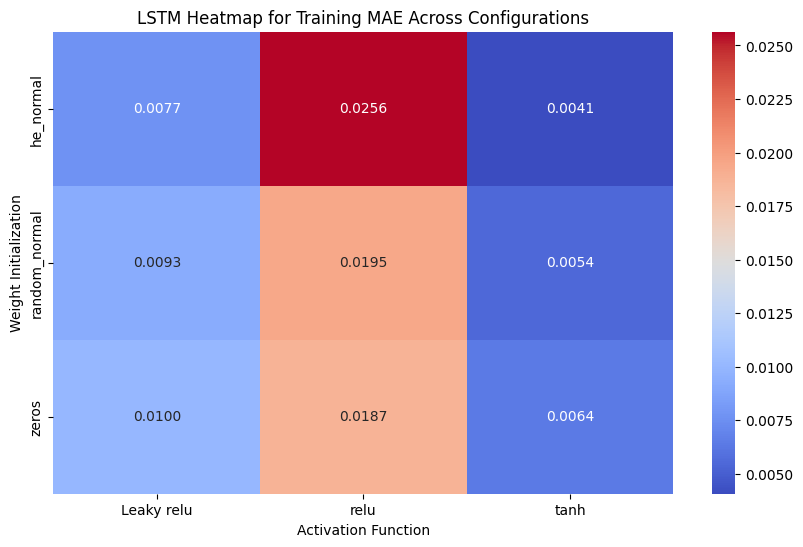

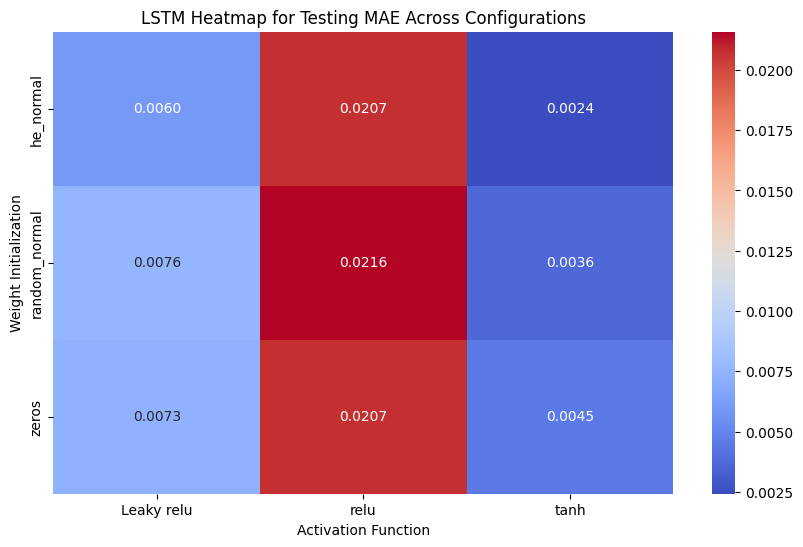

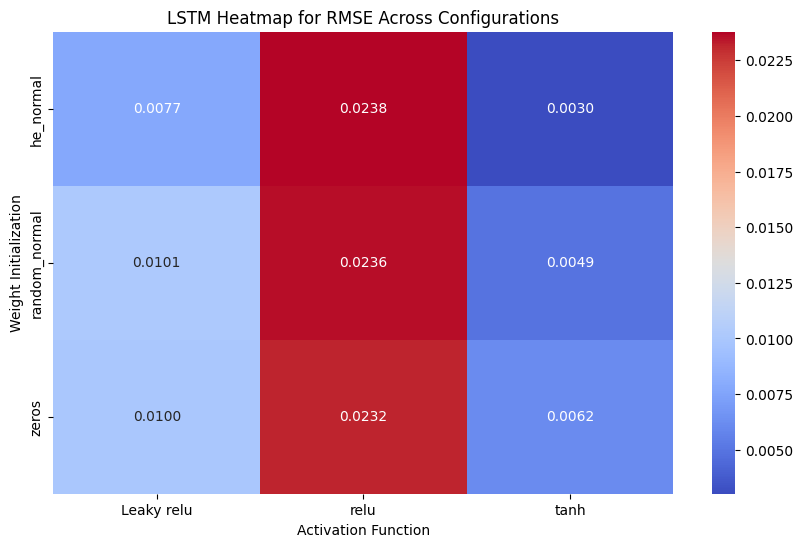

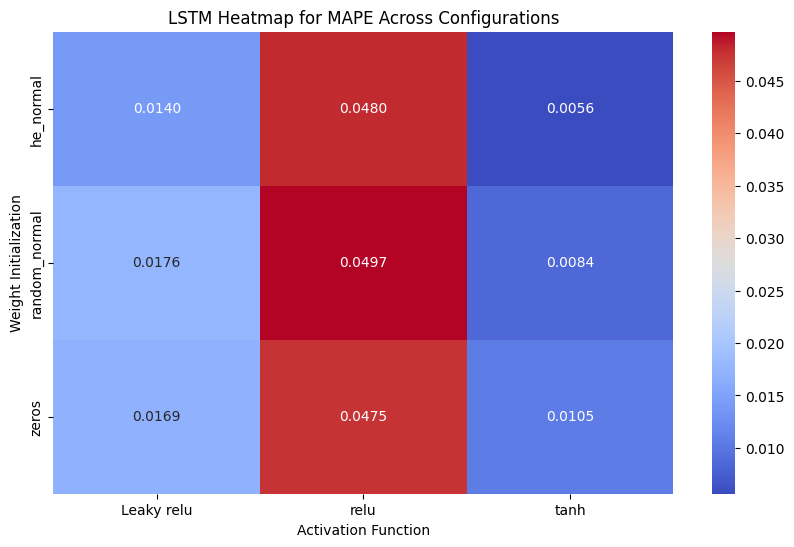

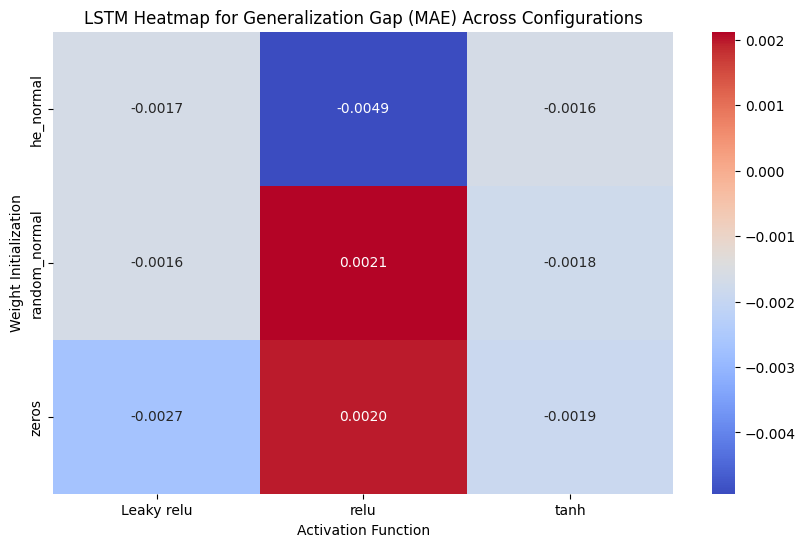

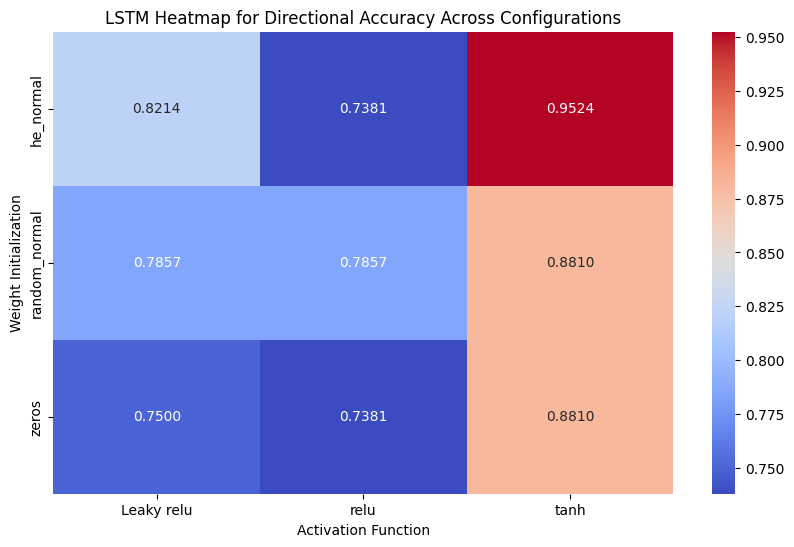

In [ ]:
# ----------------- LSTM Model -----------------
import os
import pandas as pd
import numpy as np
from google.colab import drive
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Custom weight initializer for zeros with noise
from tensorflow.keras.initializers import Initializer
import tensorflow.keras.backend as K

class ZerosWithNoise(Initializer):
    def __init__(self, noise_level=1e-5):
        self.noise_level = noise_level

    def __call__(self, shape, dtype=None):
        return K.random_uniform(shape, minval=-self.noise_level, maxval=self.noise_level, dtype=dtype)

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Define file paths
root_dir = '/content/drive/My Drive/RNNs For Stock Prediction - 1906525'
data_dir = os.path.join(root_dir, 'data/cleaned')
train_file_path = os.path.join(data_dir, 'train_cleaned.csv')
validation_file_path = os.path.join(data_dir, 'validation_cleaned.csv')
test_file_path = os.path.join(data_dir, 'test_cleaned.csv')

# Load the cleaned data
train_data = pd.read_csv(train_file_path)
validation_data = pd.read_csv(validation_file_path)
test_data = pd.read_csv(test_file_path)

# Prepare data for the model
features = ['Close', 'Volume'] + [f'Close_lag{i}' for i in range(1, 6)]
target = 'Close'

X_train = train_data[features].values
y_train = train_data[target].values

X_val = validation_data[features].values
y_val = validation_data[target].values

X_test = test_data[features].values
y_test = test_data[target].values

# Save original y_test for later use
y_test_orig = y_test.copy()

# Scale features
from sklearn.preprocessing import MinMaxScaler

# Create scalers
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

# Fit scalers on training data
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))

# Transform validation and test data
X_val_scaled = scaler_X.transform(X_val)
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1))
X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

# Reshape data for LSTM
X_train = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_val = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))
X_test_full = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))  # For full evaluation

y_train = y_train_scaled
y_val = y_val_scaled
y_test_full = y_test_scaled  # For full evaluation

# Directory to save results
results_dir = os.path.join(root_dir, 'results')
os.makedirs(results_dir, exist_ok=True)

results = []

# Initialize hyperparameter index and prediction results
hyperparameter_index = 0
prediction_results = []

# Cosine annealing learning rate function
def cosine_annealing(epoch, lr_max=0.001, lr_min=1e-6, T_max=40):
    return lr_min + 0.5 * (lr_max - lr_min) * (1 + math.cos(math.pi * epoch / T_max))

# Experiment loop
activation_functions = ['relu', 'tanh', 'Leaky relu']
weight_initializations = ['random_normal', 'zeros', 'he_normal']
epochs_list = [10, 20, 30, 40, 50, 100]

for activation_function in activation_functions:
    for weight_initialization in weight_initializations:
        for epochs in epochs_list:
            # Adjust T_max for the learning rate scheduler based on epochs
            def cosine_annealing(epoch, lr_max=0.001, lr_min=1e-6, T_max=epochs):
                return lr_min + 0.5 * (lr_max - lr_min) * (1 + math.cos(math.pi * epoch / T_max))

            # Define the LSTM model
            model = Sequential()

            # Use custom initializer for 'zeros' to add small noise
            if weight_initialization == 'zeros':
                weight_initializer = ZerosWithNoise()
            else:
                weight_initializer = weight_initialization

            model.add(LSTM(64, kernel_initializer=weight_initializer,
                           input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))

            # Handle activation functions
            if activation_function == 'Leaky relu':
                model.add(LeakyReLU(alpha=0.2))  # Add LeakyReLU with alpha
                model.add(Dropout(0.3))  # Add dropout for regularization
                model.add(Dense(32))  # No activation for LeakyReLU
            else:
                model.add(Dense(64, activation=activation_function))
                model.add(Dropout(0.3))  # Add dropout for regularization
                model.add(Dense(32, activation=activation_function))

            model.add(Dense(1))  # Output layer

            # Compile the model with gradient clipping and MAE loss
            model.compile(optimizer=Adam(clipnorm=1.0), loss='mean_absolute_error', metrics=['mae'])

            # Define callbacks
            reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)
            lr_scheduler = LearningRateScheduler(cosine_annealing)
            early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

            # Train the model
            history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                                epochs=epochs, batch_size=32, verbose=2,
                                callbacks=[reduce_lr, lr_scheduler, early_stopping])

            # Evaluate the model on full test set (retain original functionality)
            test_loss, test_mae = model.evaluate(X_test_full, y_test_full, verbose=2)

            # Predict and inverse transform on full test set
            y_pred_full = model.predict(X_test_full, verbose=0)
            y_pred_full_inverse = scaler_y.inverse_transform(y_pred_full)
            y_test_full_actual = scaler_y.inverse_transform(y_test_full)

            # Calculate additional metrics on full test set
            train_loss, train_mae = model.evaluate(X_train, y_train, verbose=0)
            rmse = np.sqrt(mean_squared_error(y_test_full_actual, y_pred_full_inverse))
            mape = mean_absolute_percentage_error(y_test_full_actual, y_pred_full_inverse)
            try:
                correlation_coefficient, _ = pearsonr(y_test_full_actual.flatten(), y_pred_full_inverse.flatten())
            except Exception:
                correlation_coefficient = np.nan  # Assign NaN if correlation cannot be computed

            directional_accuracy = np.mean((np.sign(y_test_full_actual[1:] - y_test_full_actual[:-1]) == np.sign(y_pred_full_inverse[1:] - y_pred_full_inverse[:-1])).astype(int))
            generalization_gap_mae = test_mae - train_mae

            # Store results (retain original functionality)
            results.append({
                'Activation Function': activation_function,
                'Weight Initialization': weight_initialization,
                'Epochs': epochs,
                'Training MAE': train_mae,
                'Testing MAE': test_mae,
                'Correlation Coefficient': correlation_coefficient,
                'Directional Accuracy': directional_accuracy,
                'RMSE': rmse,
                'MAPE': mape,
                'Generalization Gap (MAE)': generalization_gap_mae
            })

            # ----------------- Testing Part Integration -----------------
            # Get the index of the test data row
            idx = hyperparameter_index % len(test_data)

            # Get the test data row
            test_row = test_data.iloc[idx]

            # Extract features
            X_test_row = test_row[features].values.reshape(1, -1)

            # Scale features
            X_test_row_scaled = scaler_X.transform(X_test_row)

            # Reshape for model
            X_test_row_scaled = X_test_row_scaled.reshape((1, 1, X_test_row_scaled.shape[1]))

            # Make prediction
            y_pred_row = model.predict(X_test_row_scaled, verbose=0)

            # Inverse transform prediction
            y_pred_row = scaler_y.inverse_transform(y_pred_row)

            # Get actual Close value
            y_test_row_actual = test_row[target]

            # Collect Open, High, Low, Volume, Date
            Open = test_row['Open']
            High = test_row['High']
            Low = test_row['Low']
            Volume = test_row['Volume']
            Date = test_row['Date']

            # Calculate Difference
            Difference = y_pred_row[0][0] - y_test_row_actual

            # Compute MSE for the single data point
            MSE = Difference ** 2

            # Append to prediction_results
            prediction_results.append({
                'Date': Date,
                'Open': Open,
                'High': High,
                'Low': Low,
                'Volume': Volume,
                'Close (Actual)': y_test_row_actual,
                'Close (Predicted)': y_pred_row[0][0],
                'Difference': Difference,
                'Activation Function': activation_function,
                'Weight Initialization': weight_initialization,
                'Epochs': epochs,
                'MSE': MSE,
            })

            # Increment hyperparameter index
            hyperparameter_index += 1

# Save results to CSV
results_df = pd.DataFrame(results)
results_csv_path = os.path.join(results_dir, 'LSTM_results_Final.csv')
results_df.to_csv(results_csv_path, index=False)

# Reorder columns in prediction_results
columns_order = ['Date', 'Open', 'High', 'Low', 'Volume', 'Close (Actual)', 'Close (Predicted)', 'Difference',
                 'Activation Function', 'Weight Initialization', 'Epochs', 'MSE']
prediction_results_df = pd.DataFrame(prediction_results)[columns_order]

# Save prediction results to CSV
prediction_results_csv_path = os.path.join(results_dir, 'LSTM_Testing_PredVsAct.csv')
prediction_results_df.to_csv(prediction_results_csv_path, index=False)

# Heatmap Visualization
metrics = ['Training MAE', 'Testing MAE', 'RMSE', 'MAPE', 'Generalization Gap (MAE)', 'Directional Accuracy']
for metric in metrics:
    heatmap_data = results_df.pivot_table(index='Weight Initialization', columns='Activation Function',
                                          values=metric, aggfunc='mean')
    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt='.4f')
    plt.title(f'LSTM Heatmap for {metric} Across Configurations')
    plt.show()


4) TCN Model

i) Update typeguard and tensorflow-addons to compatible versions.

In [ ]:
pip install --upgrade typeguard tensorflow-addons

ii) Reinstall the keras-tcn library with a specific version compatible with TensorFlow version and restart the session.

In [ ]:
pip install keras-tcn==3.4.0

In [ ]:
# Check your TensorFlow version
import tensorflow as tf
print(tf.__version__)

2.17.1


The architecture and program.

Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/tcn/tcn.py:244: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


Epoch 1/10
59/59 - 15s - 247ms/step - loss: 0.1105 - mae: 0.1105 - val_loss: 0.0370 - val_mae: 0.0370 - learning_rate: 0.0010
Epoch 2/10
59/59 - 0s - 4ms/step - loss: 0.0390 - mae: 0.0390 - val_loss: 0.0168 - val_mae: 0.0168 - learning_rate: 9.7555e-04
Epoch 3/10
59/59 - 0s - 4ms/step - loss: 0.0321 - mae: 0.0321 - val_loss: 0.0276 - val_mae: 0.0276 - learning_rate: 8.8249e-04
Epoch 4/10
59/59 - 0s - 4ms/step - loss: 0.0286 - mae: 0.0286 - val_loss: 0.0323 - val_mae: 0.0323 - learning_rate: 7.0081e-04
Epoch 5/10
59/59 - 0s - 4ms/step - loss: 0.0274 - mae: 0.0274 - val_loss: 0.0359 - val_mae: 0.0359 - learning_rate: 4.5903e-04
Epoch 6/10
59/59 - 0s - 4ms/step - loss: 0.0274 - mae: 0.0274 - val_loss: 0.0217 - val_mae: 0.0217 - learning_rate: 2.3002e-04
Epoch 7/10

Epoch 7: ReduceLROnPlateau reducing learning rate to 1.60245894221589e-05.
59/59 - 0s - 4ms/step - loss: 0.0243 - mae: 0.0243 - val_loss: 0.0199 - val_mae: 0.0199 - learning_rate: 1.6025e-05
Epoch 8/10
59/59 - 0s - 4ms/step - l

/usr/local/lib/python3.10/dist-packages/tcn/tcn.py:244: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


59/59 - 10s - 163ms/step - loss: 0.0716 - mae: 0.0716 - val_loss: 0.0282 - val_mae: 0.0282 - learning_rate: 0.0010
Epoch 2/20
59/59 - 0s - 4ms/step - loss: 0.0326 - mae: 0.0326 - val_loss: 0.0270 - val_mae: 0.0270 - learning_rate: 9.9385e-04
Epoch 3/20
59/59 - 0s - 4ms/step - loss: 0.0312 - mae: 0.0312 - val_loss: 0.0331 - val_mae: 0.0331 - learning_rate: 9.6955e-04
Epoch 4/20
59/59 - 0s - 4ms/step - loss: 0.0268 - mae: 0.0268 - val_loss: 0.0356 - val_mae: 0.0356 - learning_rate: 9.1677e-04
Epoch 5/20
59/59 - 0s - 4ms/step - loss: 0.0263 - mae: 0.0263 - val_loss: 0.0441 - val_mae: 0.0441 - learning_rate: 8.2932e-04
Epoch 6/20
59/59 - 0s - 4ms/step - loss: 0.0236 - mae: 0.0236 - val_loss: 0.0330 - val_mae: 0.0330 - learning_rate: 7.0802e-04
Epoch 7/20

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00011245916830375791.
59/59 - 0s - 4ms/step - loss: 0.0208 - mae: 0.0208 - val_loss: 0.0287 - val_mae: 0.0287 - learning_rate: 1.1246e-04
Epoch 8/20
59/59 - 0s - 4ms/step - loss: 0.01

/usr/local/lib/python3.10/dist-packages/tcn/tcn.py:244: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


59/59 - 10s - 169ms/step - loss: 0.1045 - mae: 0.1045 - val_loss: 0.0256 - val_mae: 0.0256 - learning_rate: 0.0010
Epoch 2/30
59/59 - 0s - 4ms/step - loss: 0.0378 - mae: 0.0378 - val_loss: 0.0217 - val_mae: 0.0217 - learning_rate: 9.9726e-04
Epoch 3/30
59/59 - 0s - 4ms/step - loss: 0.0355 - mae: 0.0355 - val_loss: 0.0237 - val_mae: 0.0237 - learning_rate: 9.8638e-04
Epoch 4/30
59/59 - 0s - 4ms/step - loss: 0.0310 - mae: 0.0310 - val_loss: 0.0195 - val_mae: 0.0195 - learning_rate: 9.6226e-04
Epoch 5/30
59/59 - 0s - 4ms/step - loss: 0.0272 - mae: 0.0272 - val_loss: 0.0278 - val_mae: 0.0278 - learning_rate: 9.2071e-04
Epoch 6/30
59/59 - 0s - 4ms/step - loss: 0.0265 - mae: 0.0265 - val_loss: 0.0354 - val_mae: 0.0354 - learning_rate: 8.5910e-04
Epoch 7/30
59/59 - 0s - 4ms/step - loss: 0.0221 - mae: 0.0221 - val_loss: 0.0329 - val_mae: 0.0329 - learning_rate: 7.7716e-04
Epoch 8/30
59/59 - 0s - 4ms/step - loss: 0.0191 - mae: 0.0191 - val_loss: 0.0261 - val_mae: 0.0261 - learning_rate: 6.7748e

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/tcn/tcn.py:244: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


59/59 - 10s - 162ms/step - loss: 0.0885 - mae: 0.0885 - val_loss: 0.0317 - val_mae: 0.0317 - learning_rate: 0.0010
Epoch 2/40
59/59 - 0s - 4ms/step - loss: 0.0404 - mae: 0.0404 - val_loss: 0.0277 - val_mae: 0.0277 - learning_rate: 9.9846e-04
Epoch 3/40
59/59 - 0s - 4ms/step - loss: 0.0341 - mae: 0.0341 - val_loss: 0.0229 - val_mae: 0.0229 - learning_rate: 9.9232e-04
Epoch 4/40
59/59 - 0s - 4ms/step - loss: 0.0317 - mae: 0.0317 - val_loss: 0.0237 - val_mae: 0.0237 - learning_rate: 9.7862e-04
Epoch 5/40
59/59 - 0s - 4ms/step - loss: 0.0270 - mae: 0.0270 - val_loss: 0.0257 - val_mae: 0.0257 - learning_rate: 9.5470e-04
Epoch 6/40
59/59 - 0s - 4ms/step - loss: 0.0235 - mae: 0.0235 - val_loss: 0.0179 - val_mae: 0.0179 - learning_rate: 9.1840e-04
Epoch 7/40
59/59 - 0s - 4ms/step - loss: 0.0223 - mae: 0.0223 - val_loss: 0.0369 - val_mae: 0.0369 - learning_rate: 8.6841e-04
Epoch 8/40
59/59 - 0s - 4ms/step - loss: 0.0206 - mae: 0.0206 - val_loss: 0.0341 - val_mae: 0.0341 - learning_rate: 8.0450e

/usr/local/lib/python3.10/dist-packages/tcn/tcn.py:244: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


59/59 - 10s - 162ms/step - loss: 0.0817 - mae: 0.0817 - val_loss: 0.0243 - val_mae: 0.0243 - learning_rate: 0.0010
Epoch 2/50
59/59 - 0s - 4ms/step - loss: 0.0384 - mae: 0.0384 - val_loss: 0.0242 - val_mae: 0.0242 - learning_rate: 9.9901e-04
Epoch 3/50
59/59 - 0s - 4ms/step - loss: 0.0366 - mae: 0.0366 - val_loss: 0.0256 - val_mae: 0.0256 - learning_rate: 9.9508e-04
Epoch 4/50
59/59 - 0s - 4ms/step - loss: 0.0310 - mae: 0.0310 - val_loss: 0.0360 - val_mae: 0.0360 - learning_rate: 9.8628e-04
Epoch 5/50
59/59 - 0s - 4ms/step - loss: 0.0278 - mae: 0.0278 - val_loss: 0.0245 - val_mae: 0.0245 - learning_rate: 9.7080e-04
Epoch 6/50
59/59 - 0s - 4ms/step - loss: 0.0246 - mae: 0.0246 - val_loss: 0.0226 - val_mae: 0.0226 - learning_rate: 9.4707e-04
Epoch 7/50
59/59 - 0s - 4ms/step - loss: 0.0229 - mae: 0.0229 - val_loss: 0.0239 - val_mae: 0.0239 - learning_rate: 9.1385e-04
Epoch 8/50
59/59 - 0s - 4ms/step - loss: 0.0210 - mae: 0.0210 - val_loss: 0.0338 - val_mae: 0.0338 - learning_rate: 8.7041e

/usr/local/lib/python3.10/dist-packages/tcn/tcn.py:244: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


59/59 - 10s - 169ms/step - loss: 0.0893 - mae: 0.0893 - val_loss: 0.0213 - val_mae: 0.0213 - learning_rate: 0.0010
Epoch 2/100
59/59 - 0s - 4ms/step - loss: 0.0417 - mae: 0.0417 - val_loss: 0.0191 - val_mae: 0.0191 - learning_rate: 9.9975e-04
Epoch 3/100
59/59 - 0s - 4ms/step - loss: 0.0385 - mae: 0.0385 - val_loss: 0.0261 - val_mae: 0.0261 - learning_rate: 9.9877e-04
Epoch 4/100
59/59 - 0s - 4ms/step - loss: 0.0330 - mae: 0.0330 - val_loss: 0.0228 - val_mae: 0.0228 - learning_rate: 9.9655e-04
Epoch 5/100
59/59 - 0s - 4ms/step - loss: 0.0301 - mae: 0.0301 - val_loss: 0.0151 - val_mae: 0.0151 - learning_rate: 9.9263e-04
Epoch 6/100
59/59 - 0s - 4ms/step - loss: 0.0283 - mae: 0.0283 - val_loss: 0.0290 - val_mae: 0.0290 - learning_rate: 9.8652e-04
Epoch 7/100
59/59 - 0s - 4ms/step - loss: 0.0264 - mae: 0.0264 - val_loss: 0.0129 - val_mae: 0.0129 - learning_rate: 9.7780e-04
Epoch 8/100
59/59 - 0s - 4ms/step - loss: 0.0246 - mae: 0.0246 - val_loss: 0.0143 - val_mae: 0.0143 - learning_rate: 

/usr/local/lib/python3.10/dist-packages/tcn/tcn.py:244: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


59/59 - 10s - 164ms/step - loss: 0.1488 - mae: 0.1488 - val_loss: 0.0396 - val_mae: 0.0396 - learning_rate: 0.0010
Epoch 2/10
59/59 - 0s - 4ms/step - loss: 0.0424 - mae: 0.0424 - val_loss: 0.0245 - val_mae: 0.0245 - learning_rate: 9.7555e-04
Epoch 3/10
59/59 - 0s - 4ms/step - loss: 0.0369 - mae: 0.0369 - val_loss: 0.0263 - val_mae: 0.0263 - learning_rate: 8.8249e-04
Epoch 4/10
59/59 - 0s - 4ms/step - loss: 0.0344 - mae: 0.0344 - val_loss: 0.0240 - val_mae: 0.0240 - learning_rate: 7.0081e-04
Epoch 5/10
59/59 - 0s - 4ms/step - loss: 0.0330 - mae: 0.0330 - val_loss: 0.0262 - val_mae: 0.0262 - learning_rate: 4.5903e-04
Epoch 6/10
59/59 - 0s - 4ms/step - loss: 0.0308 - mae: 0.0308 - val_loss: 0.0238 - val_mae: 0.0238 - learning_rate: 2.3002e-04
Epoch 7/10
59/59 - 0s - 4ms/step - loss: 0.0318 - mae: 0.0318 - val_loss: 0.0225 - val_mae: 0.0225 - learning_rate: 8.0123e-05
Epoch 8/10
59/59 - 0s - 4ms/step - loss: 0.0314 - mae: 0.0314 - val_loss: 0.0224 - val_mae: 0.0224 - learning_rate: 1.7308e

/usr/local/lib/python3.10/dist-packages/tcn/tcn.py:244: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


59/59 - 10s - 162ms/step - loss: 0.1312 - mae: 0.1312 - val_loss: 0.0314 - val_mae: 0.0314 - learning_rate: 0.0010
Epoch 2/20
59/59 - 0s - 4ms/step - loss: 0.0391 - mae: 0.0391 - val_loss: 0.0323 - val_mae: 0.0323 - learning_rate: 9.9385e-04
Epoch 3/20
59/59 - 0s - 4ms/step - loss: 0.0346 - mae: 0.0346 - val_loss: 0.0268 - val_mae: 0.0268 - learning_rate: 9.6955e-04
Epoch 4/20
59/59 - 0s - 4ms/step - loss: 0.0314 - mae: 0.0314 - val_loss: 0.0331 - val_mae: 0.0331 - learning_rate: 9.1677e-04
Epoch 5/20
59/59 - 0s - 4ms/step - loss: 0.0292 - mae: 0.0292 - val_loss: 0.0352 - val_mae: 0.0352 - learning_rate: 8.2932e-04
Epoch 6/20
59/59 - 0s - 4ms/step - loss: 0.0271 - mae: 0.0271 - val_loss: 0.0419 - val_mae: 0.0419 - learning_rate: 7.0802e-04
Epoch 7/20
59/59 - 0s - 4ms/step - loss: 0.0260 - mae: 0.0260 - val_loss: 0.0480 - val_mae: 0.0480 - learning_rate: 5.6230e-04
Epoch 8/20

Epoch 8: ReduceLROnPlateau reducing learning rate to 8.181188022717834e-05.
59/59 - 0s - 4ms/step - loss: 0.025

/usr/local/lib/python3.10/dist-packages/tcn/tcn.py:244: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


59/59 - 10s - 171ms/step - loss: 0.1398 - mae: 0.1398 - val_loss: 0.0376 - val_mae: 0.0376 - learning_rate: 0.0010
Epoch 2/30
59/59 - 0s - 4ms/step - loss: 0.0425 - mae: 0.0425 - val_loss: 0.0287 - val_mae: 0.0287 - learning_rate: 9.9726e-04
Epoch 3/30
59/59 - 0s - 4ms/step - loss: 0.0366 - mae: 0.0366 - val_loss: 0.0208 - val_mae: 0.0208 - learning_rate: 9.8638e-04
Epoch 4/30
59/59 - 0s - 4ms/step - loss: 0.0355 - mae: 0.0355 - val_loss: 0.0214 - val_mae: 0.0214 - learning_rate: 9.6226e-04
Epoch 5/30
59/59 - 0s - 4ms/step - loss: 0.0318 - mae: 0.0318 - val_loss: 0.0207 - val_mae: 0.0207 - learning_rate: 9.2071e-04
Epoch 6/30
59/59 - 0s - 4ms/step - loss: 0.0311 - mae: 0.0311 - val_loss: 0.0215 - val_mae: 0.0215 - learning_rate: 8.5910e-04
Epoch 7/30
59/59 - 0s - 4ms/step - loss: 0.0293 - mae: 0.0293 - val_loss: 0.0305 - val_mae: 0.0305 - learning_rate: 7.7716e-04
Epoch 8/30
59/59 - 0s - 4ms/step - loss: 0.0273 - mae: 0.0273 - val_loss: 0.0373 - val_mae: 0.0373 - learning_rate: 6.7748e

/usr/local/lib/python3.10/dist-packages/tcn/tcn.py:244: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


59/59 - 10s - 163ms/step - loss: 0.1363 - mae: 0.1363 - val_loss: 0.0249 - val_mae: 0.0249 - learning_rate: 0.0010
Epoch 2/40
59/59 - 0s - 4ms/step - loss: 0.0454 - mae: 0.0454 - val_loss: 0.0225 - val_mae: 0.0225 - learning_rate: 9.9846e-04
Epoch 3/40
59/59 - 0s - 4ms/step - loss: 0.0377 - mae: 0.0377 - val_loss: 0.0242 - val_mae: 0.0242 - learning_rate: 9.9232e-04
Epoch 4/40
59/59 - 0s - 4ms/step - loss: 0.0368 - mae: 0.0368 - val_loss: 0.0252 - val_mae: 0.0252 - learning_rate: 9.7862e-04
Epoch 5/40
59/59 - 0s - 4ms/step - loss: 0.0328 - mae: 0.0328 - val_loss: 0.0267 - val_mae: 0.0267 - learning_rate: 9.5470e-04
Epoch 6/40
59/59 - 0s - 4ms/step - loss: 0.0319 - mae: 0.0319 - val_loss: 0.0264 - val_mae: 0.0264 - learning_rate: 9.1840e-04
Epoch 7/40

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00017368145054206253.
59/59 - 0s - 4ms/step - loss: 0.0333 - mae: 0.0333 - val_loss: 0.0243 - val_mae: 0.0243 - learning_rate: 1.7368e-04
Epoch 8/40
59/59 - 0s - 4ms/step - loss: 0.03

/usr/local/lib/python3.10/dist-packages/tcn/tcn.py:244: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


59/59 - 10s - 163ms/step - loss: 0.1343 - mae: 0.1343 - val_loss: 0.0260 - val_mae: 0.0260 - learning_rate: 0.0010
Epoch 2/50
59/59 - 0s - 4ms/step - loss: 0.0440 - mae: 0.0440 - val_loss: 0.0276 - val_mae: 0.0276 - learning_rate: 9.9901e-04
Epoch 3/50
59/59 - 0s - 4ms/step - loss: 0.0425 - mae: 0.0425 - val_loss: 0.0275 - val_mae: 0.0275 - learning_rate: 9.9508e-04
Epoch 4/50
59/59 - 0s - 4ms/step - loss: 0.0353 - mae: 0.0353 - val_loss: 0.0236 - val_mae: 0.0236 - learning_rate: 9.8628e-04
Epoch 5/50
59/59 - 0s - 4ms/step - loss: 0.0340 - mae: 0.0340 - val_loss: 0.0262 - val_mae: 0.0262 - learning_rate: 9.7080e-04
Epoch 6/50
59/59 - 0s - 4ms/step - loss: 0.0334 - mae: 0.0334 - val_loss: 0.0254 - val_mae: 0.0254 - learning_rate: 9.4707e-04
Epoch 7/50
59/59 - 0s - 4ms/step - loss: 0.0336 - mae: 0.0336 - val_loss: 0.0320 - val_mae: 0.0320 - learning_rate: 9.1385e-04
Epoch 8/50
59/59 - 0s - 4ms/step - loss: 0.0302 - mae: 0.0302 - val_loss: 0.0333 - val_mae: 0.0333 - learning_rate: 8.7041e

/usr/local/lib/python3.10/dist-packages/tcn/tcn.py:244: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


59/59 - 10s - 162ms/step - loss: 0.1466 - mae: 0.1466 - val_loss: 0.0340 - val_mae: 0.0340 - learning_rate: 0.0010
Epoch 2/100
59/59 - 0s - 4ms/step - loss: 0.0443 - mae: 0.0443 - val_loss: 0.0219 - val_mae: 0.0219 - learning_rate: 9.9975e-04
Epoch 3/100
59/59 - 0s - 4ms/step - loss: 0.0390 - mae: 0.0390 - val_loss: 0.0224 - val_mae: 0.0224 - learning_rate: 9.9877e-04
Epoch 4/100
59/59 - 0s - 4ms/step - loss: 0.0347 - mae: 0.0347 - val_loss: 0.0226 - val_mae: 0.0226 - learning_rate: 9.9655e-04
Epoch 5/100
59/59 - 0s - 4ms/step - loss: 0.0328 - mae: 0.0328 - val_loss: 0.0198 - val_mae: 0.0198 - learning_rate: 9.9263e-04
Epoch 6/100
59/59 - 0s - 4ms/step - loss: 0.0344 - mae: 0.0344 - val_loss: 0.0240 - val_mae: 0.0240 - learning_rate: 9.8652e-04
Epoch 7/100
59/59 - 0s - 4ms/step - loss: 0.0332 - mae: 0.0332 - val_loss: 0.0195 - val_mae: 0.0195 - learning_rate: 9.7780e-04
Epoch 8/100
59/59 - 0s - 4ms/step - loss: 0.0311 - mae: 0.0311 - val_loss: 0.0280 - val_mae: 0.0280 - learning_rate: 

/usr/local/lib/python3.10/dist-packages/tcn/tcn.py:244: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


59/59 - 10s - 163ms/step - loss: 0.1330 - mae: 0.1330 - val_loss: 0.0447 - val_mae: 0.0447 - learning_rate: 0.0010
Epoch 2/10
59/59 - 0s - 4ms/step - loss: 0.0407 - mae: 0.0407 - val_loss: 0.0666 - val_mae: 0.0666 - learning_rate: 9.7555e-04
Epoch 3/10
59/59 - 0s - 4ms/step - loss: 0.0318 - mae: 0.0318 - val_loss: 0.0508 - val_mae: 0.0508 - learning_rate: 8.8249e-04
Epoch 4/10
59/59 - 0s - 4ms/step - loss: 0.0267 - mae: 0.0267 - val_loss: 0.0450 - val_mae: 0.0450 - learning_rate: 7.0081e-04
Epoch 5/10
59/59 - 0s - 4ms/step - loss: 0.0230 - mae: 0.0230 - val_loss: 0.0477 - val_mae: 0.0477 - learning_rate: 4.5903e-04
Epoch 6/10

Epoch 6: ReduceLROnPlateau reducing learning rate to 4.600312095135451e-05.
59/59 - 0s - 4ms/step - loss: 0.0203 - mae: 0.0203 - val_loss: 0.0511 - val_mae: 0.0511 - learning_rate: 4.6003e-05
Epoch 7/10
59/59 - 0s - 4ms/step - loss: 0.0195 - mae: 0.0195 - val_loss: 0.0454 - val_mae: 0.0454 - learning_rate: 1.6548e-05
Epoch 8/10
59/59 - 0s - 4ms/step - loss: 0.017

/usr/local/lib/python3.10/dist-packages/tcn/tcn.py:244: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


59/59 - 10s - 164ms/step - loss: 0.0873 - mae: 0.0873 - val_loss: 0.0547 - val_mae: 0.0547 - learning_rate: 0.0010
Epoch 2/20
59/59 - 0s - 4ms/step - loss: 0.0347 - mae: 0.0347 - val_loss: 0.0438 - val_mae: 0.0438 - learning_rate: 9.9385e-04
Epoch 3/20
59/59 - 0s - 4ms/step - loss: 0.0291 - mae: 0.0291 - val_loss: 0.0431 - val_mae: 0.0431 - learning_rate: 9.6955e-04
Epoch 4/20
59/59 - 0s - 4ms/step - loss: 0.0257 - mae: 0.0257 - val_loss: 0.0502 - val_mae: 0.0502 - learning_rate: 9.1677e-04
Epoch 5/20
59/59 - 0s - 4ms/step - loss: 0.0183 - mae: 0.0183 - val_loss: 0.0545 - val_mae: 0.0545 - learning_rate: 8.2932e-04
Epoch 6/20
59/59 - 0s - 4ms/step - loss: 0.0136 - mae: 0.0136 - val_loss: 0.0497 - val_mae: 0.0497 - learning_rate: 7.0802e-04
Epoch 7/20
59/59 - 0s - 4ms/step - loss: 0.0119 - mae: 0.0119 - val_loss: 0.0559 - val_mae: 0.0559 - learning_rate: 5.6230e-04
Epoch 8/20

Epoch 8: ReduceLROnPlateau reducing learning rate to 8.181188022717834e-05.
59/59 - 0s - 4ms/step - loss: 0.010

/usr/local/lib/python3.10/dist-packages/tcn/tcn.py:244: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


59/59 - 10s - 164ms/step - loss: 0.1011 - mae: 0.1011 - val_loss: 0.0304 - val_mae: 0.0304 - learning_rate: 0.0010
Epoch 2/30
59/59 - 0s - 4ms/step - loss: 0.0403 - mae: 0.0403 - val_loss: 0.0416 - val_mae: 0.0416 - learning_rate: 9.9726e-04
Epoch 3/30
59/59 - 0s - 4ms/step - loss: 0.0301 - mae: 0.0301 - val_loss: 0.0602 - val_mae: 0.0602 - learning_rate: 9.8638e-04
Epoch 4/30
59/59 - 0s - 4ms/step - loss: 0.0275 - mae: 0.0275 - val_loss: 0.0428 - val_mae: 0.0428 - learning_rate: 9.6226e-04
Epoch 5/30
59/59 - 0s - 5ms/step - loss: 0.0198 - mae: 0.0198 - val_loss: 0.0535 - val_mae: 0.0535 - learning_rate: 9.2071e-04
Epoch 6/30

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00017182051669806242.
59/59 - 0s - 4ms/step - loss: 0.0157 - mae: 0.0157 - val_loss: 0.0528 - val_mae: 0.0528 - learning_rate: 1.7182e-04
Epoch 7/30
59/59 - 0s - 4ms/step - loss: 0.0135 - mae: 0.0135 - val_loss: 0.0489 - val_mae: 0.0489 - learning_rate: 1.5551e-04
Epoch 8/30
59/59 - 0s - 4ms/step - loss: 0.01

/usr/local/lib/python3.10/dist-packages/tcn/tcn.py:244: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


59/59 - 10s - 162ms/step - loss: 0.1146 - mae: 0.1146 - val_loss: 0.0268 - val_mae: 0.0268 - learning_rate: 0.0010
Epoch 2/40
59/59 - 0s - 4ms/step - loss: 0.0422 - mae: 0.0422 - val_loss: 0.0210 - val_mae: 0.0210 - learning_rate: 9.9846e-04
Epoch 3/40
59/59 - 0s - 4ms/step - loss: 0.0355 - mae: 0.0355 - val_loss: 0.0560 - val_mae: 0.0560 - learning_rate: 9.9232e-04
Epoch 4/40
59/59 - 0s - 4ms/step - loss: 0.0331 - mae: 0.0331 - val_loss: 0.0437 - val_mae: 0.0437 - learning_rate: 9.7862e-04
Epoch 5/40
59/59 - 0s - 4ms/step - loss: 0.0244 - mae: 0.0244 - val_loss: 0.0425 - val_mae: 0.0425 - learning_rate: 9.5470e-04
Epoch 6/40
59/59 - 0s - 4ms/step - loss: 0.0221 - mae: 0.0221 - val_loss: 0.0465 - val_mae: 0.0465 - learning_rate: 9.1840e-04
Epoch 7/40

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00017368145054206253.
59/59 - 0s - 4ms/step - loss: 0.0179 - mae: 0.0179 - val_loss: 0.0429 - val_mae: 0.0429 - learning_rate: 1.7368e-04
Epoch 8/40
59/59 - 0s - 4ms/step - loss: 0.01

/usr/local/lib/python3.10/dist-packages/tcn/tcn.py:244: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


59/59 - 10s - 163ms/step - loss: 0.1034 - mae: 0.1034 - val_loss: 0.0551 - val_mae: 0.0551 - learning_rate: 0.0010
Epoch 2/50
59/59 - 0s - 4ms/step - loss: 0.0367 - mae: 0.0367 - val_loss: 0.0561 - val_mae: 0.0561 - learning_rate: 9.9901e-04
Epoch 3/50
59/59 - 0s - 4ms/step - loss: 0.0250 - mae: 0.0250 - val_loss: 0.0612 - val_mae: 0.0612 - learning_rate: 9.9508e-04
Epoch 4/50
59/59 - 0s - 4ms/step - loss: 0.0237 - mae: 0.0237 - val_loss: 0.0485 - val_mae: 0.0485 - learning_rate: 9.8628e-04
Epoch 5/50
59/59 - 0s - 4ms/step - loss: 0.0211 - mae: 0.0211 - val_loss: 0.0620 - val_mae: 0.0620 - learning_rate: 9.7080e-04
Epoch 6/50
59/59 - 0s - 4ms/step - loss: 0.0177 - mae: 0.0177 - val_loss: 0.0514 - val_mae: 0.0514 - learning_rate: 9.4707e-04
Epoch 7/50
59/59 - 0s - 4ms/step - loss: 0.0155 - mae: 0.0155 - val_loss: 0.0599 - val_mae: 0.0599 - learning_rate: 9.1385e-04
Epoch 8/50
59/59 - 0s - 4ms/step - loss: 0.0149 - mae: 0.0149 - val_loss: 0.0574 - val_mae: 0.0574 - learning_rate: 8.7041e

/usr/local/lib/python3.10/dist-packages/tcn/tcn.py:244: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


59/59 - 10s - 162ms/step - loss: 0.0996 - mae: 0.0996 - val_loss: 0.0674 - val_mae: 0.0674 - learning_rate: 0.0010
Epoch 2/100
59/59 - 0s - 4ms/step - loss: 0.0355 - mae: 0.0355 - val_loss: 0.0565 - val_mae: 0.0565 - learning_rate: 9.9975e-04
Epoch 3/100
59/59 - 0s - 4ms/step - loss: 0.0275 - mae: 0.0275 - val_loss: 0.0593 - val_mae: 0.0593 - learning_rate: 9.9877e-04
Epoch 4/100
59/59 - 0s - 4ms/step - loss: 0.0209 - mae: 0.0209 - val_loss: 0.0615 - val_mae: 0.0615 - learning_rate: 9.9655e-04
Epoch 5/100
59/59 - 0s - 4ms/step - loss: 0.0137 - mae: 0.0137 - val_loss: 0.0573 - val_mae: 0.0573 - learning_rate: 9.9263e-04
Epoch 6/100
59/59 - 0s - 4ms/step - loss: 0.0153 - mae: 0.0153 - val_loss: 0.0660 - val_mae: 0.0660 - learning_rate: 9.8652e-04
Epoch 7/100

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00019555927719920875.
59/59 - 0s - 4ms/step - loss: 0.0139 - mae: 0.0139 - val_loss: 0.0629 - val_mae: 0.0629 - learning_rate: 1.9556e-04
Epoch 8/100
59/59 - 0s - 4ms/step - los

/usr/local/lib/python3.10/dist-packages/tcn/tcn.py:244: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


59/59 - 12s - 202ms/step - loss: 0.0570 - mae: 0.0570 - val_loss: 0.0174 - val_mae: 0.0174 - learning_rate: 0.0010
Epoch 2/10
59/59 - 0s - 4ms/step - loss: 0.0306 - mae: 0.0306 - val_loss: 0.0085 - val_mae: 0.0085 - learning_rate: 9.7555e-04
Epoch 3/10
59/59 - 0s - 4ms/step - loss: 0.0243 - mae: 0.0243 - val_loss: 0.0083 - val_mae: 0.0083 - learning_rate: 8.8249e-04
Epoch 4/10
59/59 - 0s - 4ms/step - loss: 0.0248 - mae: 0.0248 - val_loss: 0.0108 - val_mae: 0.0108 - learning_rate: 7.0081e-04
Epoch 5/10
59/59 - 0s - 5ms/step - loss: 0.0188 - mae: 0.0188 - val_loss: 0.0022 - val_mae: 0.0022 - learning_rate: 4.5903e-04
Epoch 6/10
59/59 - 0s - 4ms/step - loss: 0.0167 - mae: 0.0167 - val_loss: 0.0015 - val_mae: 0.0015 - learning_rate: 2.3002e-04
Epoch 7/10
59/59 - 0s - 4ms/step - loss: 0.0156 - mae: 0.0156 - val_loss: 0.0017 - val_mae: 0.0017 - learning_rate: 8.0123e-05
Epoch 8/10
59/59 - 0s - 4ms/step - loss: 0.0156 - mae: 0.0156 - val_loss: 0.0017 - val_mae: 0.0017 - learning_rate: 1.7308e

/usr/local/lib/python3.10/dist-packages/tcn/tcn.py:244: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


59/59 - 9s - 160ms/step - loss: 0.0697 - mae: 0.0697 - val_loss: 0.0228 - val_mae: 0.0228 - learning_rate: 0.0010
Epoch 2/20
59/59 - 0s - 4ms/step - loss: 0.0304 - mae: 0.0304 - val_loss: 0.0100 - val_mae: 0.0100 - learning_rate: 9.9385e-04
Epoch 3/20
59/59 - 0s - 4ms/step - loss: 0.0244 - mae: 0.0244 - val_loss: 0.0120 - val_mae: 0.0120 - learning_rate: 9.6955e-04
Epoch 4/20
59/59 - 0s - 4ms/step - loss: 0.0212 - mae: 0.0212 - val_loss: 0.0050 - val_mae: 0.0050 - learning_rate: 9.1677e-04
Epoch 5/20
59/59 - 0s - 4ms/step - loss: 0.0203 - mae: 0.0203 - val_loss: 0.0049 - val_mae: 0.0049 - learning_rate: 8.2932e-04
Epoch 6/20
59/59 - 0s - 4ms/step - loss: 0.0181 - mae: 0.0181 - val_loss: 0.0122 - val_mae: 0.0122 - learning_rate: 7.0802e-04
Epoch 7/20
59/59 - 0s - 4ms/step - loss: 0.0198 - mae: 0.0198 - val_loss: 0.0064 - val_mae: 0.0064 - learning_rate: 5.6230e-04
Epoch 8/20
59/59 - 0s - 4ms/step - loss: 0.0165 - mae: 0.0165 - val_loss: 0.0022 - val_mae: 0.0022 - learning_rate: 4.0906e-

/usr/local/lib/python3.10/dist-packages/tcn/tcn.py:244: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


59/59 - 11s - 179ms/step - loss: 0.0626 - mae: 0.0626 - val_loss: 0.0228 - val_mae: 0.0228 - learning_rate: 0.0010
Epoch 2/30
59/59 - 0s - 4ms/step - loss: 0.0317 - mae: 0.0317 - val_loss: 0.0120 - val_mae: 0.0120 - learning_rate: 9.9726e-04
Epoch 3/30
59/59 - 0s - 4ms/step - loss: 0.0253 - mae: 0.0253 - val_loss: 0.0127 - val_mae: 0.0127 - learning_rate: 9.8638e-04
Epoch 4/30
59/59 - 0s - 4ms/step - loss: 0.0220 - mae: 0.0220 - val_loss: 0.0028 - val_mae: 0.0028 - learning_rate: 9.6226e-04
Epoch 5/30
59/59 - 0s - 4ms/step - loss: 0.0189 - mae: 0.0189 - val_loss: 0.0179 - val_mae: 0.0179 - learning_rate: 9.2071e-04
Epoch 6/30
59/59 - 0s - 4ms/step - loss: 0.0209 - mae: 0.0209 - val_loss: 0.0081 - val_mae: 0.0081 - learning_rate: 8.5910e-04
Epoch 7/30
59/59 - 0s - 4ms/step - loss: 0.0183 - mae: 0.0183 - val_loss: 0.0023 - val_mae: 0.0023 - learning_rate: 7.7716e-04
Epoch 8/30
59/59 - 0s - 4ms/step - loss: 0.0198 - mae: 0.0198 - val_loss: 0.0110 - val_mae: 0.0110 - learning_rate: 6.7748e

/usr/local/lib/python3.10/dist-packages/tcn/tcn.py:244: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


59/59 - 10s - 162ms/step - loss: 0.0549 - mae: 0.0549 - val_loss: 0.0176 - val_mae: 0.0176 - learning_rate: 0.0010
Epoch 2/40
59/59 - 0s - 4ms/step - loss: 0.0338 - mae: 0.0338 - val_loss: 0.0314 - val_mae: 0.0314 - learning_rate: 9.9846e-04
Epoch 3/40
59/59 - 0s - 4ms/step - loss: 0.0247 - mae: 0.0247 - val_loss: 0.0077 - val_mae: 0.0077 - learning_rate: 9.9232e-04
Epoch 4/40
59/59 - 0s - 4ms/step - loss: 0.0279 - mae: 0.0279 - val_loss: 0.0066 - val_mae: 0.0066 - learning_rate: 9.7862e-04
Epoch 5/40
59/59 - 0s - 4ms/step - loss: 0.0228 - mae: 0.0228 - val_loss: 0.0185 - val_mae: 0.0185 - learning_rate: 9.5470e-04
Epoch 6/40
59/59 - 0s - 4ms/step - loss: 0.0202 - mae: 0.0202 - val_loss: 0.0051 - val_mae: 0.0051 - learning_rate: 9.1840e-04
Epoch 7/40
59/59 - 0s - 4ms/step - loss: 0.0186 - mae: 0.0186 - val_loss: 0.0140 - val_mae: 0.0140 - learning_rate: 8.6841e-04
Epoch 8/40
59/59 - 0s - 4ms/step - loss: 0.0198 - mae: 0.0198 - val_loss: 0.0082 - val_mae: 0.0082 - learning_rate: 8.0450e

/usr/local/lib/python3.10/dist-packages/tcn/tcn.py:244: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


59/59 - 9s - 161ms/step - loss: 0.0549 - mae: 0.0549 - val_loss: 0.0133 - val_mae: 0.0133 - learning_rate: 0.0010
Epoch 2/50
59/59 - 0s - 4ms/step - loss: 0.0319 - mae: 0.0319 - val_loss: 0.0090 - val_mae: 0.0090 - learning_rate: 9.9901e-04
Epoch 3/50
59/59 - 0s - 4ms/step - loss: 0.0230 - mae: 0.0230 - val_loss: 0.0112 - val_mae: 0.0112 - learning_rate: 9.9508e-04
Epoch 4/50
59/59 - 0s - 4ms/step - loss: 0.0230 - mae: 0.0230 - val_loss: 0.0059 - val_mae: 0.0059 - learning_rate: 9.8628e-04
Epoch 5/50
59/59 - 0s - 4ms/step - loss: 0.0197 - mae: 0.0197 - val_loss: 0.0080 - val_mae: 0.0080 - learning_rate: 9.7080e-04
Epoch 6/50
59/59 - 0s - 4ms/step - loss: 0.0200 - mae: 0.0200 - val_loss: 0.0048 - val_mae: 0.0048 - learning_rate: 9.4707e-04
Epoch 7/50
59/59 - 0s - 4ms/step - loss: 0.0205 - mae: 0.0205 - val_loss: 0.0164 - val_mae: 0.0164 - learning_rate: 9.1385e-04
Epoch 8/50
59/59 - 0s - 4ms/step - loss: 0.0187 - mae: 0.0187 - val_loss: 0.0051 - val_mae: 0.0051 - learning_rate: 8.7041e-

/usr/local/lib/python3.10/dist-packages/tcn/tcn.py:244: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


59/59 - 10s - 162ms/step - loss: 0.0515 - mae: 0.0515 - val_loss: 0.0160 - val_mae: 0.0160 - learning_rate: 0.0010
Epoch 2/100
59/59 - 0s - 4ms/step - loss: 0.0342 - mae: 0.0342 - val_loss: 0.0084 - val_mae: 0.0084 - learning_rate: 9.9975e-04
Epoch 3/100
59/59 - 0s - 4ms/step - loss: 0.0252 - mae: 0.0252 - val_loss: 0.0064 - val_mae: 0.0064 - learning_rate: 9.9877e-04
Epoch 4/100
59/59 - 0s - 4ms/step - loss: 0.0229 - mae: 0.0229 - val_loss: 0.0039 - val_mae: 0.0039 - learning_rate: 9.9655e-04
Epoch 5/100
59/59 - 0s - 4ms/step - loss: 0.0197 - mae: 0.0197 - val_loss: 0.0039 - val_mae: 0.0039 - learning_rate: 9.9263e-04
Epoch 6/100
59/59 - 0s - 4ms/step - loss: 0.0189 - mae: 0.0189 - val_loss: 0.0044 - val_mae: 0.0044 - learning_rate: 9.8652e-04
Epoch 7/100
59/59 - 0s - 4ms/step - loss: 0.0199 - mae: 0.0199 - val_loss: 0.0056 - val_mae: 0.0056 - learning_rate: 9.7780e-04
Epoch 8/100
59/59 - 0s - 4ms/step - loss: 0.0178 - mae: 0.0178 - val_loss: 0.0064 - val_mae: 0.0064 - learning_rate: 

/usr/local/lib/python3.10/dist-packages/tcn/tcn.py:244: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


59/59 - 10s - 161ms/step - loss: 0.0858 - mae: 0.0858 - val_loss: 0.0365 - val_mae: 0.0365 - learning_rate: 0.0010
Epoch 2/10
59/59 - 0s - 4ms/step - loss: 0.0384 - mae: 0.0384 - val_loss: 0.0241 - val_mae: 0.0241 - learning_rate: 9.7555e-04
Epoch 3/10
59/59 - 0s - 4ms/step - loss: 0.0308 - mae: 0.0308 - val_loss: 0.0204 - val_mae: 0.0204 - learning_rate: 8.8249e-04
Epoch 4/10
59/59 - 0s - 4ms/step - loss: 0.0296 - mae: 0.0296 - val_loss: 0.0264 - val_mae: 0.0264 - learning_rate: 7.0081e-04
Epoch 5/10
59/59 - 0s - 4ms/step - loss: 0.0265 - mae: 0.0265 - val_loss: 0.0200 - val_mae: 0.0200 - learning_rate: 4.5903e-04
Epoch 6/10
59/59 - 0s - 4ms/step - loss: 0.0252 - mae: 0.0252 - val_loss: 0.0189 - val_mae: 0.0189 - learning_rate: 2.3002e-04
Epoch 7/10
59/59 - 0s - 4ms/step - loss: 0.0246 - mae: 0.0246 - val_loss: 0.0199 - val_mae: 0.0199 - learning_rate: 8.0123e-05
Epoch 8/10
59/59 - 0s - 4ms/step - loss: 0.0238 - mae: 0.0238 - val_loss: 0.0180 - val_mae: 0.0180 - learning_rate: 1.7308e

/usr/local/lib/python3.10/dist-packages/tcn/tcn.py:244: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


59/59 - 9s - 161ms/step - loss: 0.0857 - mae: 0.0857 - val_loss: 0.0269 - val_mae: 0.0269 - learning_rate: 0.0010
Epoch 2/20
59/59 - 0s - 4ms/step - loss: 0.0354 - mae: 0.0354 - val_loss: 0.0222 - val_mae: 0.0222 - learning_rate: 9.9385e-04
Epoch 3/20
59/59 - 0s - 4ms/step - loss: 0.0335 - mae: 0.0335 - val_loss: 0.0207 - val_mae: 0.0207 - learning_rate: 9.6955e-04
Epoch 4/20
59/59 - 0s - 4ms/step - loss: 0.0285 - mae: 0.0285 - val_loss: 0.0206 - val_mae: 0.0206 - learning_rate: 9.1677e-04
Epoch 5/20
59/59 - 0s - 4ms/step - loss: 0.0287 - mae: 0.0287 - val_loss: 0.0293 - val_mae: 0.0293 - learning_rate: 8.2932e-04
Epoch 6/20
59/59 - 0s - 4ms/step - loss: 0.0271 - mae: 0.0271 - val_loss: 0.0193 - val_mae: 0.0193 - learning_rate: 7.0802e-04
Epoch 7/20
59/59 - 0s - 4ms/step - loss: 0.0246 - mae: 0.0246 - val_loss: 0.0204 - val_mae: 0.0204 - learning_rate: 5.6230e-04
Epoch 8/20
59/59 - 0s - 4ms/step - loss: 0.0239 - mae: 0.0239 - val_loss: 0.0175 - val_mae: 0.0175 - learning_rate: 4.0906e-

/usr/local/lib/python3.10/dist-packages/tcn/tcn.py:244: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


59/59 - 11s - 182ms/step - loss: 0.0877 - mae: 0.0877 - val_loss: 0.0242 - val_mae: 0.0242 - learning_rate: 0.0010
Epoch 2/30
59/59 - 0s - 4ms/step - loss: 0.0346 - mae: 0.0346 - val_loss: 0.0211 - val_mae: 0.0211 - learning_rate: 9.9726e-04
Epoch 3/30
59/59 - 0s - 4ms/step - loss: 0.0309 - mae: 0.0309 - val_loss: 0.0199 - val_mae: 0.0199 - learning_rate: 9.8638e-04
Epoch 4/30
59/59 - 0s - 4ms/step - loss: 0.0290 - mae: 0.0290 - val_loss: 0.0212 - val_mae: 0.0212 - learning_rate: 9.6226e-04
Epoch 5/30
59/59 - 0s - 4ms/step - loss: 0.0296 - mae: 0.0296 - val_loss: 0.0241 - val_mae: 0.0241 - learning_rate: 9.2071e-04
Epoch 6/30
59/59 - 0s - 4ms/step - loss: 0.0257 - mae: 0.0257 - val_loss: 0.0181 - val_mae: 0.0181 - learning_rate: 8.5910e-04
Epoch 7/30
59/59 - 0s - 4ms/step - loss: 0.0259 - mae: 0.0259 - val_loss: 0.0179 - val_mae: 0.0179 - learning_rate: 7.7716e-04
Epoch 8/30
59/59 - 0s - 4ms/step - loss: 0.0275 - mae: 0.0275 - val_loss: 0.0168 - val_mae: 0.0168 - learning_rate: 6.7748e

/usr/local/lib/python3.10/dist-packages/tcn/tcn.py:244: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


59/59 - 10s - 162ms/step - loss: 0.0838 - mae: 0.0838 - val_loss: 0.0261 - val_mae: 0.0261 - learning_rate: 0.0010
Epoch 2/40
59/59 - 0s - 4ms/step - loss: 0.0366 - mae: 0.0366 - val_loss: 0.0255 - val_mae: 0.0255 - learning_rate: 9.9846e-04
Epoch 3/40
59/59 - 0s - 4ms/step - loss: 0.0342 - mae: 0.0342 - val_loss: 0.0216 - val_mae: 0.0216 - learning_rate: 9.9232e-04
Epoch 4/40
59/59 - 0s - 4ms/step - loss: 0.0297 - mae: 0.0297 - val_loss: 0.0240 - val_mae: 0.0240 - learning_rate: 9.7862e-04
Epoch 5/40
59/59 - 0s - 4ms/step - loss: 0.0294 - mae: 0.0294 - val_loss: 0.0187 - val_mae: 0.0187 - learning_rate: 9.5470e-04
Epoch 6/40
59/59 - 0s - 4ms/step - loss: 0.0274 - mae: 0.0274 - val_loss: 0.0208 - val_mae: 0.0208 - learning_rate: 9.1840e-04
Epoch 7/40
59/59 - 0s - 4ms/step - loss: 0.0266 - mae: 0.0266 - val_loss: 0.0176 - val_mae: 0.0176 - learning_rate: 8.6841e-04
Epoch 8/40
59/59 - 0s - 4ms/step - loss: 0.0254 - mae: 0.0254 - val_loss: 0.0155 - val_mae: 0.0155 - learning_rate: 8.0450e

/usr/local/lib/python3.10/dist-packages/tcn/tcn.py:244: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


59/59 - 10s - 161ms/step - loss: 0.0906 - mae: 0.0906 - val_loss: 0.0244 - val_mae: 0.0244 - learning_rate: 0.0010
Epoch 2/50
59/59 - 0s - 4ms/step - loss: 0.0343 - mae: 0.0343 - val_loss: 0.0231 - val_mae: 0.0231 - learning_rate: 9.9901e-04
Epoch 3/50
59/59 - 0s - 4ms/step - loss: 0.0313 - mae: 0.0313 - val_loss: 0.0261 - val_mae: 0.0261 - learning_rate: 9.9508e-04
Epoch 4/50
59/59 - 0s - 4ms/step - loss: 0.0322 - mae: 0.0322 - val_loss: 0.0194 - val_mae: 0.0194 - learning_rate: 9.8628e-04
Epoch 5/50
59/59 - 0s - 4ms/step - loss: 0.0288 - mae: 0.0288 - val_loss: 0.0224 - val_mae: 0.0224 - learning_rate: 9.7080e-04
Epoch 6/50
59/59 - 0s - 4ms/step - loss: 0.0261 - mae: 0.0261 - val_loss: 0.0189 - val_mae: 0.0189 - learning_rate: 9.4707e-04
Epoch 7/50
59/59 - 0s - 4ms/step - loss: 0.0249 - mae: 0.0249 - val_loss: 0.0180 - val_mae: 0.0180 - learning_rate: 9.1385e-04
Epoch 8/50
59/59 - 0s - 4ms/step - loss: 0.0246 - mae: 0.0246 - val_loss: 0.0150 - val_mae: 0.0150 - learning_rate: 8.7041e

/usr/local/lib/python3.10/dist-packages/tcn/tcn.py:244: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


59/59 - 10s - 162ms/step - loss: 0.0846 - mae: 0.0846 - val_loss: 0.0250 - val_mae: 0.0250 - learning_rate: 0.0010
Epoch 2/100
59/59 - 0s - 4ms/step - loss: 0.0365 - mae: 0.0365 - val_loss: 0.0208 - val_mae: 0.0208 - learning_rate: 9.9975e-04
Epoch 3/100
59/59 - 0s - 4ms/step - loss: 0.0335 - mae: 0.0335 - val_loss: 0.0246 - val_mae: 0.0246 - learning_rate: 9.9877e-04
Epoch 4/100
59/59 - 0s - 4ms/step - loss: 0.0298 - mae: 0.0298 - val_loss: 0.0210 - val_mae: 0.0210 - learning_rate: 9.9655e-04
Epoch 5/100
59/59 - 0s - 4ms/step - loss: 0.0295 - mae: 0.0295 - val_loss: 0.0184 - val_mae: 0.0184 - learning_rate: 9.9263e-04
Epoch 6/100
59/59 - 0s - 4ms/step - loss: 0.0260 - mae: 0.0260 - val_loss: 0.0276 - val_mae: 0.0276 - learning_rate: 9.8652e-04
Epoch 7/100
59/59 - 0s - 4ms/step - loss: 0.0254 - mae: 0.0254 - val_loss: 0.0196 - val_mae: 0.0196 - learning_rate: 9.7780e-04
Epoch 8/100
59/59 - 0s - 4ms/step - loss: 0.0250 - mae: 0.0250 - val_loss: 0.0180 - val_mae: 0.0180 - learning_rate: 

/usr/local/lib/python3.10/dist-packages/tcn/tcn.py:244: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


59/59 - 9s - 161ms/step - loss: 0.2414 - mae: 0.2414 - val_loss: 0.0235 - val_mae: 0.0235 - learning_rate: 0.0010
Epoch 2/10
59/59 - 0s - 4ms/step - loss: 0.0907 - mae: 0.0907 - val_loss: 0.0389 - val_mae: 0.0389 - learning_rate: 9.7555e-04
Epoch 3/10
59/59 - 0s - 4ms/step - loss: 0.0716 - mae: 0.0716 - val_loss: 0.0471 - val_mae: 0.0471 - learning_rate: 8.8249e-04
Epoch 4/10
59/59 - 0s - 4ms/step - loss: 0.0615 - mae: 0.0615 - val_loss: 0.0296 - val_mae: 0.0296 - learning_rate: 7.0081e-04
Epoch 5/10
59/59 - 0s - 4ms/step - loss: 0.0543 - mae: 0.0543 - val_loss: 0.0124 - val_mae: 0.0124 - learning_rate: 4.5903e-04
Epoch 6/10
59/59 - 0s - 4ms/step - loss: 0.0474 - mae: 0.0474 - val_loss: 0.0133 - val_mae: 0.0133 - learning_rate: 2.3002e-04
Epoch 7/10
59/59 - 0s - 4ms/step - loss: 0.0449 - mae: 0.0449 - val_loss: 0.0163 - val_mae: 0.0163 - learning_rate: 8.0123e-05
Epoch 8/10
59/59 - 0s - 4ms/step - loss: 0.0421 - mae: 0.0421 - val_loss: 0.0108 - val_mae: 0.0108 - learning_rate: 1.7308e-

/usr/local/lib/python3.10/dist-packages/tcn/tcn.py:244: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


59/59 - 9s - 161ms/step - loss: 0.2877 - mae: 0.2877 - val_loss: 0.0282 - val_mae: 0.0282 - learning_rate: 0.0010
Epoch 2/20
59/59 - 0s - 4ms/step - loss: 0.1107 - mae: 0.1107 - val_loss: 0.0377 - val_mae: 0.0377 - learning_rate: 9.9385e-04
Epoch 3/20
59/59 - 0s - 4ms/step - loss: 0.0861 - mae: 0.0861 - val_loss: 0.0385 - val_mae: 0.0385 - learning_rate: 9.6955e-04
Epoch 4/20
59/59 - 0s - 4ms/step - loss: 0.0686 - mae: 0.0686 - val_loss: 0.0232 - val_mae: 0.0232 - learning_rate: 9.1677e-04
Epoch 5/20
59/59 - 0s - 4ms/step - loss: 0.0582 - mae: 0.0582 - val_loss: 0.0208 - val_mae: 0.0208 - learning_rate: 8.2932e-04
Epoch 6/20
59/59 - 0s - 4ms/step - loss: 0.0484 - mae: 0.0484 - val_loss: 0.0154 - val_mae: 0.0154 - learning_rate: 7.0802e-04
Epoch 7/20
59/59 - 0s - 4ms/step - loss: 0.0453 - mae: 0.0453 - val_loss: 0.0144 - val_mae: 0.0144 - learning_rate: 5.6230e-04
Epoch 8/20
59/59 - 0s - 4ms/step - loss: 0.0419 - mae: 0.0419 - val_loss: 0.0141 - val_mae: 0.0141 - learning_rate: 4.0906e-

/usr/local/lib/python3.10/dist-packages/tcn/tcn.py:244: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


59/59 - 10s - 163ms/step - loss: 0.2210 - mae: 0.2210 - val_loss: 0.0474 - val_mae: 0.0474 - learning_rate: 0.0010
Epoch 2/30
59/59 - 0s - 4ms/step - loss: 0.0959 - mae: 0.0959 - val_loss: 0.0263 - val_mae: 0.0263 - learning_rate: 9.9726e-04
Epoch 3/30
59/59 - 0s - 4ms/step - loss: 0.0781 - mae: 0.0781 - val_loss: 0.0707 - val_mae: 0.0707 - learning_rate: 9.8638e-04
Epoch 4/30
59/59 - 0s - 4ms/step - loss: 0.0733 - mae: 0.0733 - val_loss: 0.0191 - val_mae: 0.0191 - learning_rate: 9.6226e-04
Epoch 5/30
59/59 - 0s - 4ms/step - loss: 0.0581 - mae: 0.0581 - val_loss: 0.0155 - val_mae: 0.0155 - learning_rate: 9.2071e-04
Epoch 6/30
59/59 - 0s - 4ms/step - loss: 0.0601 - mae: 0.0601 - val_loss: 0.0190 - val_mae: 0.0190 - learning_rate: 8.5910e-04
Epoch 7/30
59/59 - 0s - 4ms/step - loss: 0.0468 - mae: 0.0468 - val_loss: 0.0182 - val_mae: 0.0182 - learning_rate: 7.7716e-04
Epoch 8/30
59/59 - 0s - 4ms/step - loss: 0.0455 - mae: 0.0455 - val_loss: 0.0244 - val_mae: 0.0244 - learning_rate: 6.7748e

/usr/local/lib/python3.10/dist-packages/tcn/tcn.py:244: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


59/59 - 11s - 185ms/step - loss: 0.2207 - mae: 0.2207 - val_loss: 0.0308 - val_mae: 0.0308 - learning_rate: 0.0010
Epoch 2/40
59/59 - 0s - 4ms/step - loss: 0.0847 - mae: 0.0847 - val_loss: 0.0252 - val_mae: 0.0252 - learning_rate: 9.9846e-04
Epoch 3/40
59/59 - 0s - 4ms/step - loss: 0.0675 - mae: 0.0675 - val_loss: 0.0356 - val_mae: 0.0356 - learning_rate: 9.9232e-04
Epoch 4/40
59/59 - 0s - 4ms/step - loss: 0.0570 - mae: 0.0570 - val_loss: 0.0169 - val_mae: 0.0169 - learning_rate: 9.7862e-04
Epoch 5/40
59/59 - 0s - 4ms/step - loss: 0.0507 - mae: 0.0507 - val_loss: 0.0167 - val_mae: 0.0167 - learning_rate: 9.5470e-04
Epoch 6/40
59/59 - 0s - 4ms/step - loss: 0.0445 - mae: 0.0445 - val_loss: 0.0284 - val_mae: 0.0284 - learning_rate: 9.1840e-04
Epoch 7/40
59/59 - 0s - 4ms/step - loss: 0.0394 - mae: 0.0394 - val_loss: 0.0178 - val_mae: 0.0178 - learning_rate: 8.6841e-04
Epoch 8/40
59/59 - 0s - 4ms/step - loss: 0.0407 - mae: 0.0407 - val_loss: 0.0376 - val_mae: 0.0376 - learning_rate: 8.0450e

/usr/local/lib/python3.10/dist-packages/tcn/tcn.py:244: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


59/59 - 10s - 161ms/step - loss: 0.2318 - mae: 0.2318 - val_loss: 0.0505 - val_mae: 0.0505 - learning_rate: 0.0010
Epoch 2/50
59/59 - 0s - 4ms/step - loss: 0.0961 - mae: 0.0961 - val_loss: 0.0244 - val_mae: 0.0244 - learning_rate: 9.9901e-04
Epoch 3/50
59/59 - 0s - 4ms/step - loss: 0.0725 - mae: 0.0725 - val_loss: 0.0348 - val_mae: 0.0348 - learning_rate: 9.9508e-04
Epoch 4/50
59/59 - 0s - 4ms/step - loss: 0.0648 - mae: 0.0648 - val_loss: 0.0176 - val_mae: 0.0176 - learning_rate: 9.8628e-04
Epoch 5/50
59/59 - 0s - 4ms/step - loss: 0.0563 - mae: 0.0563 - val_loss: 0.0205 - val_mae: 0.0205 - learning_rate: 9.7080e-04
Epoch 6/50
59/59 - 0s - 4ms/step - loss: 0.0498 - mae: 0.0498 - val_loss: 0.0118 - val_mae: 0.0118 - learning_rate: 9.4707e-04
Epoch 7/50
59/59 - 0s - 4ms/step - loss: 0.0462 - mae: 0.0462 - val_loss: 0.0202 - val_mae: 0.0202 - learning_rate: 9.1385e-04
Epoch 8/50
59/59 - 0s - 4ms/step - loss: 0.0418 - mae: 0.0418 - val_loss: 0.0135 - val_mae: 0.0135 - learning_rate: 8.7041e

/usr/local/lib/python3.10/dist-packages/tcn/tcn.py:244: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


59/59 - 10s - 163ms/step - loss: 0.2586 - mae: 0.2586 - val_loss: 0.0648 - val_mae: 0.0648 - learning_rate: 0.0010
Epoch 2/100
59/59 - 0s - 4ms/step - loss: 0.1171 - mae: 0.1171 - val_loss: 0.0329 - val_mae: 0.0329 - learning_rate: 9.9975e-04
Epoch 3/100
59/59 - 0s - 4ms/step - loss: 0.0835 - mae: 0.0835 - val_loss: 0.0265 - val_mae: 0.0265 - learning_rate: 9.9877e-04
Epoch 4/100
59/59 - 0s - 4ms/step - loss: 0.0643 - mae: 0.0643 - val_loss: 0.0188 - val_mae: 0.0188 - learning_rate: 9.9655e-04
Epoch 5/100
59/59 - 0s - 4ms/step - loss: 0.0655 - mae: 0.0655 - val_loss: 0.0174 - val_mae: 0.0174 - learning_rate: 9.9263e-04
Epoch 6/100
59/59 - 0s - 4ms/step - loss: 0.0607 - mae: 0.0607 - val_loss: 0.0344 - val_mae: 0.0344 - learning_rate: 9.8652e-04
Epoch 7/100
59/59 - 0s - 4ms/step - loss: 0.0488 - mae: 0.0488 - val_loss: 0.0260 - val_mae: 0.0260 - learning_rate: 9.7780e-04
Epoch 8/100
59/59 - 0s - 4ms/step - loss: 0.0459 - mae: 0.0459 - val_loss: 0.0135 - val_mae: 0.0135 - learning_rate: 

/usr/local/lib/python3.10/dist-packages/tcn/tcn.py:244: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 9s - 159ms/step - loss: 0.0547 - mae: 0.0547 - val_loss: 0.0209 - val_mae: 0.0209 - learning_rate: 0.0010
Epoch 2/10
59/59 - 0s - 4ms/step - loss: 0.0285 - mae: 0.0285 - val_loss: 0.0165 - val_mae: 0.0165 - learning_rate: 9.7555e-04
Epoch 3/10
59/59 - 0s - 4ms/step - loss: 0.0282 - mae: 0.0282 - val_loss: 0.0079 - val_mae: 0.0079 - learning_rate: 8.8249e-04
Epoch 4/10
59/59 - 0s - 4ms/step - loss: 0.0228 - mae: 0.0228 - val_loss: 0.0061 - val_mae: 0.0061 - learning_rate: 7.0081e-04
Epoch 5/10
59/59 - 0s - 3ms/step - loss: 0.0208 - mae: 0.0208 - val_loss: 0.0071 - val_mae: 0.0071 - learning_rate: 4.5903e-04
Epoch 6/10
59/59 - 0s - 4ms/step - loss: 0.0187 - mae: 0.0187 - val_loss: 0.0092 - val_mae: 0.0092 - learning_rate: 2.3002e-04
Epoch 7/10
59/59 - 0s - 4ms/step - loss: 0.0174 - mae: 0.0174 - val_loss: 0.0032 - val_mae: 0.0032 - learning_rate: 8.0123e-05
Epoch 8/10
59/59 - 0s - 3ms/step - loss: 0.0174 - mae: 0.0174 - val_loss: 0.0038 - val_mae: 0.0038 - learning_rate: 1.7308e-

/usr/local/lib/python3.10/dist-packages/tcn/tcn.py:244: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 8s - 141ms/step - loss: 0.0496 - mae: 0.0496 - val_loss: 0.0266 - val_mae: 0.0266 - learning_rate: 0.0010
Epoch 2/20
59/59 - 0s - 4ms/step - loss: 0.0307 - mae: 0.0307 - val_loss: 0.0167 - val_mae: 0.0167 - learning_rate: 9.9385e-04
Epoch 3/20
59/59 - 0s - 4ms/step - loss: 0.0272 - mae: 0.0272 - val_loss: 0.0100 - val_mae: 0.0100 - learning_rate: 9.6955e-04
Epoch 4/20
59/59 - 0s - 4ms/step - loss: 0.0253 - mae: 0.0253 - val_loss: 0.0107 - val_mae: 0.0107 - learning_rate: 9.1677e-04
Epoch 5/20
59/59 - 0s - 4ms/step - loss: 0.0212 - mae: 0.0212 - val_loss: 0.0092 - val_mae: 0.0092 - learning_rate: 8.2932e-04
Epoch 6/20
59/59 - 0s - 4ms/step - loss: 0.0200 - mae: 0.0200 - val_loss: 0.0112 - val_mae: 0.0112 - learning_rate: 7.0802e-04
Epoch 7/20
59/59 - 0s - 4ms/step - loss: 0.0195 - mae: 0.0195 - val_loss: 0.0105 - val_mae: 0.0105 - learning_rate: 5.6230e-04
Epoch 8/20
59/59 - 0s - 4ms/step - loss: 0.0189 - mae: 0.0189 - val_loss: 0.0029 - val_mae: 0.0029 - learning_rate: 4.0906e-

/usr/local/lib/python3.10/dist-packages/tcn/tcn.py:244: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 8s - 142ms/step - loss: 0.0543 - mae: 0.0543 - val_loss: 0.0167 - val_mae: 0.0167 - learning_rate: 0.0010
Epoch 2/30
59/59 - 0s - 4ms/step - loss: 0.0299 - mae: 0.0299 - val_loss: 0.0155 - val_mae: 0.0155 - learning_rate: 9.9726e-04
Epoch 3/30
59/59 - 0s - 3ms/step - loss: 0.0285 - mae: 0.0285 - val_loss: 0.0204 - val_mae: 0.0204 - learning_rate: 9.8638e-04
Epoch 4/30
59/59 - 0s - 3ms/step - loss: 0.0253 - mae: 0.0253 - val_loss: 0.0182 - val_mae: 0.0182 - learning_rate: 9.6226e-04
Epoch 5/30
59/59 - 0s - 4ms/step - loss: 0.0224 - mae: 0.0224 - val_loss: 0.0129 - val_mae: 0.0129 - learning_rate: 9.2071e-04
Epoch 6/30
59/59 - 0s - 3ms/step - loss: 0.0216 - mae: 0.0216 - val_loss: 0.0198 - val_mae: 0.0198 - learning_rate: 8.5910e-04
Epoch 7/30
59/59 - 0s - 3ms/step - loss: 0.0224 - mae: 0.0224 - val_loss: 0.0196 - val_mae: 0.0196 - learning_rate: 7.7716e-04
Epoch 8/30
59/59 - 0s - 4ms/step - loss: 0.0216 - mae: 0.0216 - val_loss: 0.0034 - val_mae: 0.0034 - learning_rate: 6.7748e-

/usr/local/lib/python3.10/dist-packages/tcn/tcn.py:244: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 8s - 142ms/step - loss: 0.0568 - mae: 0.0568 - val_loss: 0.0227 - val_mae: 0.0227 - learning_rate: 0.0010
Epoch 2/40
59/59 - 0s - 4ms/step - loss: 0.0297 - mae: 0.0297 - val_loss: 0.0181 - val_mae: 0.0181 - learning_rate: 9.9846e-04
Epoch 3/40
59/59 - 0s - 4ms/step - loss: 0.0283 - mae: 0.0283 - val_loss: 0.0078 - val_mae: 0.0078 - learning_rate: 9.9232e-04
Epoch 4/40
59/59 - 0s - 4ms/step - loss: 0.0238 - mae: 0.0238 - val_loss: 0.0063 - val_mae: 0.0063 - learning_rate: 9.7862e-04
Epoch 5/40
59/59 - 0s - 3ms/step - loss: 0.0231 - mae: 0.0231 - val_loss: 0.0074 - val_mae: 0.0074 - learning_rate: 9.5470e-04
Epoch 6/40
59/59 - 0s - 3ms/step - loss: 0.0228 - mae: 0.0228 - val_loss: 0.0161 - val_mae: 0.0161 - learning_rate: 9.1840e-04
Epoch 7/40
59/59 - 0s - 3ms/step - loss: 0.0254 - mae: 0.0254 - val_loss: 0.0198 - val_mae: 0.0198 - learning_rate: 8.6841e-04
Epoch 8/40
59/59 - 0s - 3ms/step - loss: 0.0209 - mae: 0.0209 - val_loss: 0.0097 - val_mae: 0.0097 - learning_rate: 8.0450e-

/usr/local/lib/python3.10/dist-packages/tcn/tcn.py:244: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 8s - 140ms/step - loss: 0.0530 - mae: 0.0530 - val_loss: 0.0151 - val_mae: 0.0151 - learning_rate: 0.0010
Epoch 2/50
59/59 - 0s - 4ms/step - loss: 0.0288 - mae: 0.0288 - val_loss: 0.0124 - val_mae: 0.0124 - learning_rate: 9.9901e-04
Epoch 3/50
59/59 - 0s - 4ms/step - loss: 0.0266 - mae: 0.0266 - val_loss: 0.0113 - val_mae: 0.0113 - learning_rate: 9.9508e-04
Epoch 4/50
59/59 - 0s - 4ms/step - loss: 0.0254 - mae: 0.0254 - val_loss: 0.0241 - val_mae: 0.0241 - learning_rate: 9.8628e-04
Epoch 5/50
59/59 - 0s - 4ms/step - loss: 0.0217 - mae: 0.0217 - val_loss: 0.0083 - val_mae: 0.0083 - learning_rate: 9.7080e-04
Epoch 6/50
59/59 - 0s - 4ms/step - loss: 0.0205 - mae: 0.0205 - val_loss: 0.0110 - val_mae: 0.0110 - learning_rate: 9.4707e-04
Epoch 7/50
59/59 - 0s - 4ms/step - loss: 0.0215 - mae: 0.0215 - val_loss: 0.0073 - val_mae: 0.0073 - learning_rate: 9.1385e-04
Epoch 8/50
59/59 - 0s - 4ms/step - loss: 0.0190 - mae: 0.0190 - val_loss: 0.0083 - val_mae: 0.0083 - learning_rate: 8.7041e-

/usr/local/lib/python3.10/dist-packages/tcn/tcn.py:244: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 10s - 167ms/step - loss: 0.0593 - mae: 0.0593 - val_loss: 0.0176 - val_mae: 0.0176 - learning_rate: 0.0010
Epoch 2/100
59/59 - 0s - 4ms/step - loss: 0.0362 - mae: 0.0362 - val_loss: 0.0268 - val_mae: 0.0268 - learning_rate: 9.9975e-04
Epoch 3/100
59/59 - 0s - 4ms/step - loss: 0.0302 - mae: 0.0302 - val_loss: 0.0095 - val_mae: 0.0095 - learning_rate: 9.9877e-04
Epoch 4/100
59/59 - 0s - 4ms/step - loss: 0.0258 - mae: 0.0258 - val_loss: 0.0156 - val_mae: 0.0156 - learning_rate: 9.9655e-04
Epoch 5/100
59/59 - 0s - 4ms/step - loss: 0.0238 - mae: 0.0238 - val_loss: 0.0124 - val_mae: 0.0124 - learning_rate: 9.9263e-04
Epoch 6/100
59/59 - 0s - 4ms/step - loss: 0.0217 - mae: 0.0217 - val_loss: 0.0074 - val_mae: 0.0074 - learning_rate: 9.8652e-04
Epoch 7/100
59/59 - 0s - 4ms/step - loss: 0.0203 - mae: 0.0203 - val_loss: 0.0056 - val_mae: 0.0056 - learning_rate: 9.7780e-04
Epoch 8/100
59/59 - 0s - 4ms/step - loss: 0.0207 - mae: 0.0207 - val_loss: 0.0059 - val_mae: 0.0059 - learning_rate: 

/usr/local/lib/python3.10/dist-packages/tcn/tcn.py:244: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 8s - 141ms/step - loss: 0.0908 - mae: 0.0908 - val_loss: 0.0235 - val_mae: 0.0235 - learning_rate: 0.0010
Epoch 2/10
59/59 - 0s - 4ms/step - loss: 0.0326 - mae: 0.0326 - val_loss: 0.0229 - val_mae: 0.0229 - learning_rate: 9.7555e-04
Epoch 3/10
59/59 - 0s - 4ms/step - loss: 0.0292 - mae: 0.0292 - val_loss: 0.0210 - val_mae: 0.0210 - learning_rate: 8.8249e-04
Epoch 4/10
59/59 - 0s - 3ms/step - loss: 0.0300 - mae: 0.0300 - val_loss: 0.0241 - val_mae: 0.0241 - learning_rate: 7.0081e-04
Epoch 5/10
59/59 - 0s - 4ms/step - loss: 0.0268 - mae: 0.0268 - val_loss: 0.0168 - val_mae: 0.0168 - learning_rate: 4.5903e-04
Epoch 6/10
59/59 - 0s - 4ms/step - loss: 0.0264 - mae: 0.0264 - val_loss: 0.0205 - val_mae: 0.0205 - learning_rate: 2.3002e-04
Epoch 7/10
59/59 - 0s - 4ms/step - loss: 0.0254 - mae: 0.0254 - val_loss: 0.0167 - val_mae: 0.0167 - learning_rate: 8.0123e-05
Epoch 8/10
59/59 - 0s - 4ms/step - loss: 0.0242 - mae: 0.0242 - val_loss: 0.0161 - val_mae: 0.0161 - learning_rate: 1.7308e-

/usr/local/lib/python3.10/dist-packages/tcn/tcn.py:244: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 8s - 141ms/step - loss: 0.1157 - mae: 0.1157 - val_loss: 0.0217 - val_mae: 0.0217 - learning_rate: 0.0010
Epoch 2/20
59/59 - 0s - 4ms/step - loss: 0.0341 - mae: 0.0341 - val_loss: 0.0235 - val_mae: 0.0235 - learning_rate: 9.9385e-04
Epoch 3/20
59/59 - 0s - 4ms/step - loss: 0.0303 - mae: 0.0303 - val_loss: 0.0185 - val_mae: 0.0185 - learning_rate: 9.6955e-04
Epoch 4/20
59/59 - 0s - 3ms/step - loss: 0.0306 - mae: 0.0306 - val_loss: 0.0187 - val_mae: 0.0187 - learning_rate: 9.1677e-04
Epoch 5/20
59/59 - 0s - 3ms/step - loss: 0.0296 - mae: 0.0296 - val_loss: 0.0193 - val_mae: 0.0193 - learning_rate: 8.2932e-04
Epoch 6/20
59/59 - 0s - 4ms/step - loss: 0.0284 - mae: 0.0284 - val_loss: 0.0185 - val_mae: 0.0185 - learning_rate: 7.0802e-04
Epoch 7/20
59/59 - 0s - 3ms/step - loss: 0.0275 - mae: 0.0275 - val_loss: 0.0219 - val_mae: 0.0219 - learning_rate: 5.6230e-04
Epoch 8/20

Epoch 8: ReduceLROnPlateau reducing learning rate to 8.181188022717834e-05.
59/59 - 0s - 4ms/step - loss: 0.0260

/usr/local/lib/python3.10/dist-packages/tcn/tcn.py:244: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 8s - 140ms/step - loss: 0.0919 - mae: 0.0919 - val_loss: 0.0283 - val_mae: 0.0283 - learning_rate: 0.0010
Epoch 2/30
59/59 - 0s - 4ms/step - loss: 0.0355 - mae: 0.0355 - val_loss: 0.0215 - val_mae: 0.0215 - learning_rate: 9.9726e-04
Epoch 3/30
59/59 - 0s - 4ms/step - loss: 0.0333 - mae: 0.0333 - val_loss: 0.0235 - val_mae: 0.0235 - learning_rate: 9.8638e-04
Epoch 4/30
59/59 - 0s - 4ms/step - loss: 0.0327 - mae: 0.0327 - val_loss: 0.0286 - val_mae: 0.0286 - learning_rate: 9.6226e-04
Epoch 5/30
59/59 - 0s - 4ms/step - loss: 0.0300 - mae: 0.0300 - val_loss: 0.0192 - val_mae: 0.0192 - learning_rate: 9.2071e-04
Epoch 6/30
59/59 - 0s - 4ms/step - loss: 0.0291 - mae: 0.0291 - val_loss: 0.0215 - val_mae: 0.0215 - learning_rate: 8.5910e-04
Epoch 7/30
59/59 - 0s - 4ms/step - loss: 0.0274 - mae: 0.0274 - val_loss: 0.0182 - val_mae: 0.0182 - learning_rate: 7.7716e-04
Epoch 8/30
59/59 - 0s - 3ms/step - loss: 0.0276 - mae: 0.0276 - val_loss: 0.0306 - val_mae: 0.0306 - learning_rate: 6.7748e-

/usr/local/lib/python3.10/dist-packages/tcn/tcn.py:244: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 8s - 141ms/step - loss: 0.0852 - mae: 0.0852 - val_loss: 0.0222 - val_mae: 0.0222 - learning_rate: 0.0010
Epoch 2/40
59/59 - 0s - 4ms/step - loss: 0.0349 - mae: 0.0349 - val_loss: 0.0202 - val_mae: 0.0202 - learning_rate: 9.9846e-04
Epoch 3/40
59/59 - 0s - 3ms/step - loss: 0.0302 - mae: 0.0302 - val_loss: 0.0299 - val_mae: 0.0299 - learning_rate: 9.9232e-04
Epoch 4/40
59/59 - 0s - 3ms/step - loss: 0.0311 - mae: 0.0311 - val_loss: 0.0205 - val_mae: 0.0205 - learning_rate: 9.7862e-04
Epoch 5/40
59/59 - 0s - 4ms/step - loss: 0.0269 - mae: 0.0269 - val_loss: 0.0239 - val_mae: 0.0239 - learning_rate: 9.5470e-04
Epoch 6/40
59/59 - 0s - 3ms/step - loss: 0.0281 - mae: 0.0281 - val_loss: 0.0205 - val_mae: 0.0205 - learning_rate: 9.1840e-04
Epoch 7/40
59/59 - 0s - 4ms/step - loss: 0.0256 - mae: 0.0256 - val_loss: 0.0149 - val_mae: 0.0149 - learning_rate: 8.6841e-04
Epoch 8/40
59/59 - 0s - 3ms/step - loss: 0.0255 - mae: 0.0255 - val_loss: 0.0193 - val_mae: 0.0193 - learning_rate: 8.0450e-

/usr/local/lib/python3.10/dist-packages/tcn/tcn.py:244: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 8s - 141ms/step - loss: 0.1006 - mae: 0.1006 - val_loss: 0.0218 - val_mae: 0.0218 - learning_rate: 0.0010
Epoch 2/50
59/59 - 0s - 4ms/step - loss: 0.0356 - mae: 0.0356 - val_loss: 0.0212 - val_mae: 0.0212 - learning_rate: 9.9901e-04
Epoch 3/50
59/59 - 0s - 3ms/step - loss: 0.0303 - mae: 0.0303 - val_loss: 0.0225 - val_mae: 0.0225 - learning_rate: 9.9508e-04
Epoch 4/50
59/59 - 0s - 4ms/step - loss: 0.0298 - mae: 0.0298 - val_loss: 0.0194 - val_mae: 0.0194 - learning_rate: 9.8628e-04
Epoch 5/50
59/59 - 0s - 3ms/step - loss: 0.0288 - mae: 0.0288 - val_loss: 0.0221 - val_mae: 0.0221 - learning_rate: 9.7080e-04
Epoch 6/50
59/59 - 0s - 3ms/step - loss: 0.0273 - mae: 0.0273 - val_loss: 0.0266 - val_mae: 0.0266 - learning_rate: 9.4707e-04
Epoch 7/50
59/59 - 0s - 4ms/step - loss: 0.0314 - mae: 0.0314 - val_loss: 0.0167 - val_mae: 0.0167 - learning_rate: 9.1385e-04
Epoch 8/50
59/59 - 0s - 3ms/step - loss: 0.0301 - mae: 0.0301 - val_loss: 0.0283 - val_mae: 0.0283 - learning_rate: 8.7041e-

/usr/local/lib/python3.10/dist-packages/tcn/tcn.py:244: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 8s - 139ms/step - loss: 0.0997 - mae: 0.0997 - val_loss: 0.0352 - val_mae: 0.0352 - learning_rate: 0.0010
Epoch 2/100
59/59 - 0s - 4ms/step - loss: 0.0378 - mae: 0.0378 - val_loss: 0.0199 - val_mae: 0.0199 - learning_rate: 9.9975e-04
Epoch 3/100
59/59 - 0s - 3ms/step - loss: 0.0354 - mae: 0.0354 - val_loss: 0.0229 - val_mae: 0.0229 - learning_rate: 9.9877e-04
Epoch 4/100
59/59 - 0s - 3ms/step - loss: 0.0306 - mae: 0.0306 - val_loss: 0.0224 - val_mae: 0.0224 - learning_rate: 9.9655e-04
Epoch 5/100
59/59 - 0s - 3ms/step - loss: 0.0289 - mae: 0.0289 - val_loss: 0.0211 - val_mae: 0.0211 - learning_rate: 9.9263e-04
Epoch 6/100
59/59 - 0s - 4ms/step - loss: 0.0311 - mae: 0.0311 - val_loss: 0.0286 - val_mae: 0.0286 - learning_rate: 9.8652e-04
Epoch 7/100
59/59 - 0s - 4ms/step - loss: 0.0284 - mae: 0.0284 - val_loss: 0.0185 - val_mae: 0.0185 - learning_rate: 9.7780e-04
Epoch 8/100
59/59 - 0s - 4ms/step - loss: 0.0276 - mae: 0.0276 - val_loss: 0.0222 - val_mae: 0.0222 - learning_rate: 9

/usr/local/lib/python3.10/dist-packages/tcn/tcn.py:244: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 8s - 140ms/step - loss: 0.5807 - mae: 0.5807 - val_loss: 0.0725 - val_mae: 0.0725 - learning_rate: 0.0010
Epoch 2/10
59/59 - 0s - 4ms/step - loss: 0.0894 - mae: 0.0894 - val_loss: 0.0116 - val_mae: 0.0116 - learning_rate: 9.7555e-04
Epoch 3/10
59/59 - 0s - 3ms/step - loss: 0.0555 - mae: 0.0555 - val_loss: 0.0476 - val_mae: 0.0476 - learning_rate: 8.8249e-04
Epoch 4/10
59/59 - 0s - 3ms/step - loss: 0.0427 - mae: 0.0427 - val_loss: 0.0182 - val_mae: 0.0182 - learning_rate: 7.0081e-04
Epoch 5/10
59/59 - 0s - 3ms/step - loss: 0.0316 - mae: 0.0316 - val_loss: 0.0138 - val_mae: 0.0138 - learning_rate: 4.5903e-04
Epoch 6/10
59/59 - 0s - 4ms/step - loss: 0.0297 - mae: 0.0297 - val_loss: 0.0097 - val_mae: 0.0097 - learning_rate: 2.3002e-04
Epoch 7/10
59/59 - 0s - 4ms/step - loss: 0.0259 - mae: 0.0259 - val_loss: 0.0056 - val_mae: 0.0056 - learning_rate: 8.0123e-05
Epoch 8/10
59/59 - 0s - 4ms/step - loss: 0.0244 - mae: 0.0244 - val_loss: 0.0054 - val_mae: 0.0054 - learning_rate: 1.7308e-

/usr/local/lib/python3.10/dist-packages/tcn/tcn.py:244: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 8s - 142ms/step - loss: 0.6277 - mae: 0.6277 - val_loss: 0.1012 - val_mae: 0.1012 - learning_rate: 0.0010
Epoch 2/20
59/59 - 0s - 4ms/step - loss: 0.1410 - mae: 0.1410 - val_loss: 0.0518 - val_mae: 0.0518 - learning_rate: 9.9385e-04
Epoch 3/20
59/59 - 0s - 4ms/step - loss: 0.0550 - mae: 0.0550 - val_loss: 0.0199 - val_mae: 0.0199 - learning_rate: 9.6955e-04
Epoch 4/20
59/59 - 0s - 4ms/step - loss: 0.0399 - mae: 0.0399 - val_loss: 0.0267 - val_mae: 0.0267 - learning_rate: 9.1677e-04
Epoch 5/20
59/59 - 0s - 4ms/step - loss: 0.0314 - mae: 0.0314 - val_loss: 0.0135 - val_mae: 0.0135 - learning_rate: 8.2932e-04
Epoch 6/20
59/59 - 0s - 4ms/step - loss: 0.0334 - mae: 0.0334 - val_loss: 0.0168 - val_mae: 0.0168 - learning_rate: 7.0802e-04
Epoch 7/20
59/59 - 0s - 4ms/step - loss: 0.0303 - mae: 0.0303 - val_loss: 0.0174 - val_mae: 0.0174 - learning_rate: 5.6230e-04
Epoch 8/20
59/59 - 0s - 4ms/step - loss: 0.0266 - mae: 0.0266 - val_loss: 0.0078 - val_mae: 0.0078 - learning_rate: 4.0906e-

/usr/local/lib/python3.10/dist-packages/tcn/tcn.py:244: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 10s - 173ms/step - loss: 0.5323 - mae: 0.5323 - val_loss: 0.0534 - val_mae: 0.0534 - learning_rate: 0.0010
Epoch 2/30
59/59 - 0s - 4ms/step - loss: 0.0933 - mae: 0.0933 - val_loss: 0.0130 - val_mae: 0.0130 - learning_rate: 9.9726e-04
Epoch 3/30
59/59 - 0s - 4ms/step - loss: 0.0497 - mae: 0.0497 - val_loss: 0.0354 - val_mae: 0.0354 - learning_rate: 9.8638e-04
Epoch 4/30
59/59 - 0s - 4ms/step - loss: 0.0352 - mae: 0.0352 - val_loss: 0.0098 - val_mae: 0.0098 - learning_rate: 9.6226e-04
Epoch 5/30
59/59 - 0s - 4ms/step - loss: 0.0310 - mae: 0.0310 - val_loss: 0.0077 - val_mae: 0.0077 - learning_rate: 9.2071e-04
Epoch 6/30
59/59 - 0s - 4ms/step - loss: 0.0317 - mae: 0.0317 - val_loss: 0.0229 - val_mae: 0.0229 - learning_rate: 8.5910e-04
Epoch 7/30
59/59 - 0s - 4ms/step - loss: 0.0284 - mae: 0.0284 - val_loss: 0.0173 - val_mae: 0.0173 - learning_rate: 7.7716e-04
Epoch 8/30
59/59 - 0s - 4ms/step - loss: 0.0331 - mae: 0.0331 - val_loss: 0.0090 - val_mae: 0.0090 - learning_rate: 6.7748e

/usr/local/lib/python3.10/dist-packages/tcn/tcn.py:244: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 8s - 141ms/step - loss: 0.6768 - mae: 0.6768 - val_loss: 0.0283 - val_mae: 0.0283 - learning_rate: 0.0010
Epoch 2/40
59/59 - 0s - 4ms/step - loss: 0.1205 - mae: 0.1205 - val_loss: 0.0140 - val_mae: 0.0140 - learning_rate: 9.9846e-04
Epoch 3/40
59/59 - 0s - 4ms/step - loss: 0.0563 - mae: 0.0563 - val_loss: 0.0348 - val_mae: 0.0348 - learning_rate: 9.9232e-04
Epoch 4/40
59/59 - 0s - 4ms/step - loss: 0.0384 - mae: 0.0384 - val_loss: 0.0160 - val_mae: 0.0160 - learning_rate: 9.7862e-04
Epoch 5/40
59/59 - 0s - 4ms/step - loss: 0.0380 - mae: 0.0380 - val_loss: 0.0093 - val_mae: 0.0093 - learning_rate: 9.5470e-04
Epoch 6/40
59/59 - 0s - 4ms/step - loss: 0.0277 - mae: 0.0277 - val_loss: 0.0091 - val_mae: 0.0091 - learning_rate: 9.1840e-04
Epoch 7/40
59/59 - 0s - 4ms/step - loss: 0.0293 - mae: 0.0293 - val_loss: 0.0113 - val_mae: 0.0113 - learning_rate: 8.6841e-04
Epoch 8/40
59/59 - 0s - 4ms/step - loss: 0.0324 - mae: 0.0324 - val_loss: 0.0191 - val_mae: 0.0191 - learning_rate: 8.0450e-

/usr/local/lib/python3.10/dist-packages/tcn/tcn.py:244: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 8s - 141ms/step - loss: 0.5719 - mae: 0.5719 - val_loss: 0.1199 - val_mae: 0.1199 - learning_rate: 0.0010
Epoch 2/50
59/59 - 0s - 4ms/step - loss: 0.1358 - mae: 0.1358 - val_loss: 0.0258 - val_mae: 0.0258 - learning_rate: 9.9901e-04
Epoch 3/50
59/59 - 0s - 4ms/step - loss: 0.0583 - mae: 0.0583 - val_loss: 0.0094 - val_mae: 0.0094 - learning_rate: 9.9508e-04
Epoch 4/50
59/59 - 0s - 4ms/step - loss: 0.0354 - mae: 0.0354 - val_loss: 0.0078 - val_mae: 0.0078 - learning_rate: 9.8628e-04
Epoch 5/50
59/59 - 0s - 3ms/step - loss: 0.0289 - mae: 0.0289 - val_loss: 0.0161 - val_mae: 0.0161 - learning_rate: 9.7080e-04
Epoch 6/50
59/59 - 0s - 4ms/step - loss: 0.0298 - mae: 0.0298 - val_loss: 0.0056 - val_mae: 0.0056 - learning_rate: 9.4707e-04
Epoch 7/50
59/59 - 0s - 4ms/step - loss: 0.0269 - mae: 0.0269 - val_loss: 0.0055 - val_mae: 0.0055 - learning_rate: 9.1385e-04
Epoch 8/50
59/59 - 0s - 3ms/step - loss: 0.0282 - mae: 0.0282 - val_loss: 0.0075 - val_mae: 0.0075 - learning_rate: 8.7041e-

/usr/local/lib/python3.10/dist-packages/tcn/tcn.py:244: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 8s - 141ms/step - loss: 0.4940 - mae: 0.4940 - val_loss: 0.0391 - val_mae: 0.0391 - learning_rate: 0.0010
Epoch 2/100
59/59 - 0s - 4ms/step - loss: 0.1248 - mae: 0.1248 - val_loss: 0.0150 - val_mae: 0.0150 - learning_rate: 9.9975e-04
Epoch 3/100
59/59 - 0s - 3ms/step - loss: 0.0459 - mae: 0.0459 - val_loss: 0.0312 - val_mae: 0.0312 - learning_rate: 9.9877e-04
Epoch 4/100
59/59 - 0s - 3ms/step - loss: 0.0414 - mae: 0.0414 - val_loss: 0.0194 - val_mae: 0.0194 - learning_rate: 9.9655e-04
Epoch 5/100
59/59 - 0s - 4ms/step - loss: 0.0329 - mae: 0.0329 - val_loss: 0.0129 - val_mae: 0.0129 - learning_rate: 9.9263e-04
Epoch 6/100
59/59 - 0s - 4ms/step - loss: 0.0298 - mae: 0.0298 - val_loss: 0.0165 - val_mae: 0.0165 - learning_rate: 9.8652e-04
Epoch 7/100
59/59 - 0s - 4ms/step - loss: 0.0318 - mae: 0.0318 - val_loss: 0.0077 - val_mae: 0.0077 - learning_rate: 9.7780e-04
Epoch 8/100
59/59 - 0s - 3ms/step - loss: 0.0289 - mae: 0.0289 - val_loss: 0.0174 - val_mae: 0.0174 - learning_rate: 9

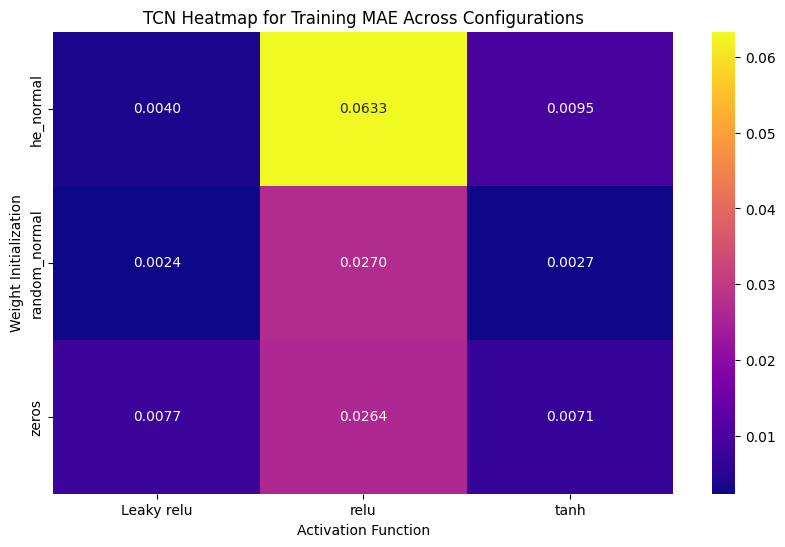

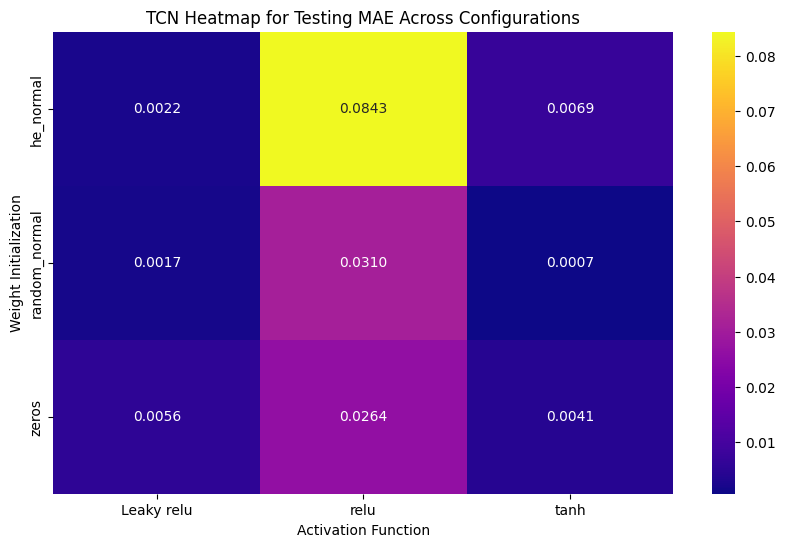

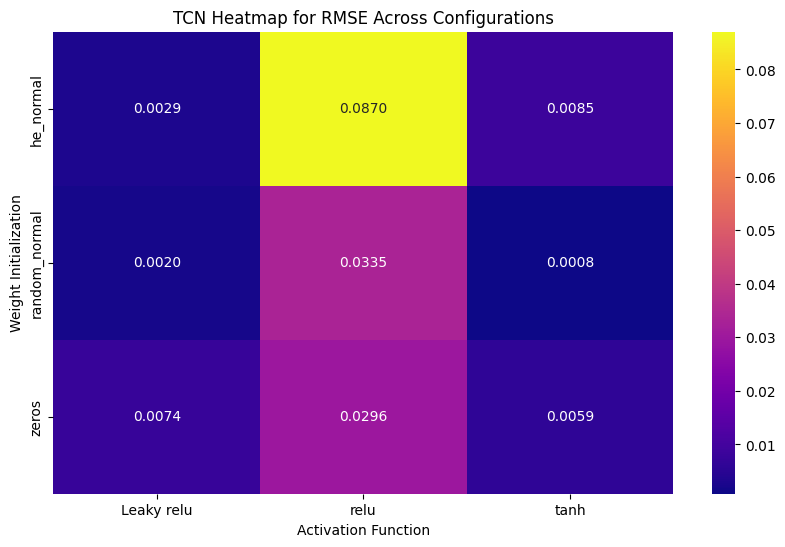

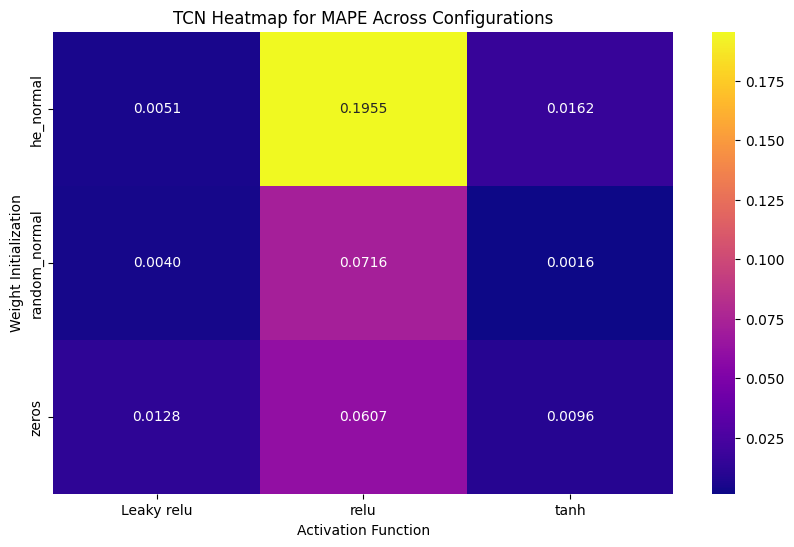

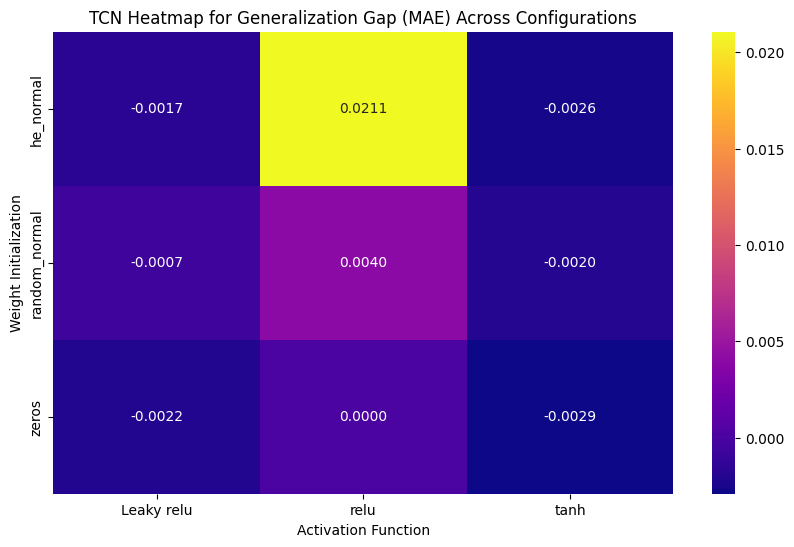

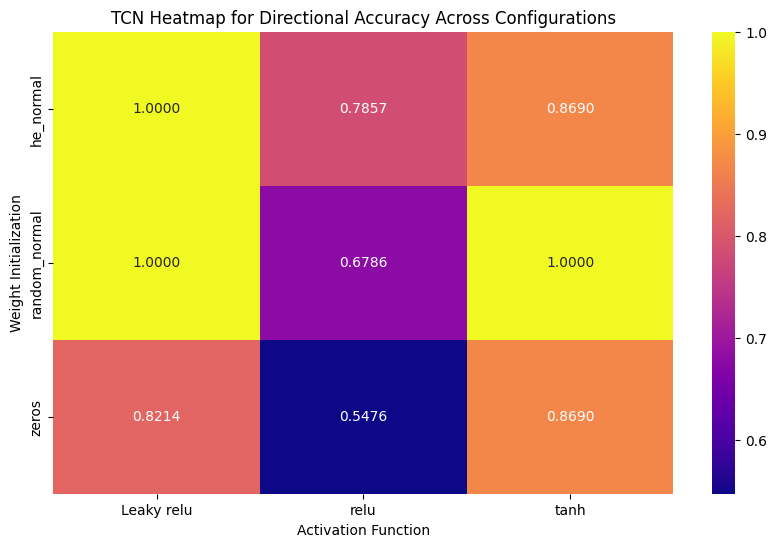

In [ ]:
# ----------------- TCN Model -----------------
import os
import pandas as pd
import numpy as np
from google.colab import drive
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from tensorflow.keras.initializers import RandomNormal, Zeros, HeNormal
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Import TCN layer
!pip install keras-tcn
from tcn import TCN

# Custom weight initializer for zeros with noise
from tensorflow.keras.initializers import Initializer
import tensorflow.keras.backend as K

class ZerosWithNoise(Initializer):
    def __init__(self, noise_level=1e-5):
        self.noise_level = noise_level

    def __call__(self, shape, dtype=None):
        return K.random_uniform(shape, minval=-self.noise_level, maxval=self.noise_level, dtype=dtype)

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Define file paths
root_dir = '/content/drive/My Drive/RNNs For Stock Prediction - 1906525'
data_dir = os.path.join(root_dir, 'data/cleaned')
train_file_path = os.path.join(data_dir, 'train_cleaned.csv')
validation_file_path = os.path.join(data_dir, 'validation_cleaned.csv')
test_file_path = os.path.join(data_dir, 'test_cleaned.csv')

# Load the cleaned data
train_data = pd.read_csv(train_file_path)
validation_data = pd.read_csv(validation_file_path)
test_data = pd.read_csv(test_file_path)

# Prepare data for the model
features = ['Close', 'Volume'] + [f'Close_lag{i}' for i in range(1, 6)]
target = 'Close'

X_train = train_data[features].values
y_train = train_data[target].values

X_val = validation_data[features].values
y_val = validation_data[target].values

X_test = test_data[features].values
y_test = test_data[target].values

# Save original y_test for later use
y_test_orig = y_test.copy()

# Scale features
from sklearn.preprocessing import MinMaxScaler

# Create scalers
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

# Fit scalers on training data
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))

# Transform validation and test data
X_val_scaled = scaler_X.transform(X_val)
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1))
X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

# Reshape data for TCN
X_train = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_val = X_val_scaled.reshape((X_val_scaled.shape[0], X_val_scaled.shape[1], 1))
X_test_full = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))  # For full evaluation

y_train = y_train_scaled
y_val = y_val_scaled
y_test_full = y_test_scaled  # For full evaluation

# Directory to save results
results_dir = os.path.join(root_dir, 'results')
os.makedirs(results_dir, exist_ok=True)

results = []

# Initialize hyperparameter index and prediction results
hyperparameter_index = 0
prediction_results = []

# Cosine annealing learning rate function
def cosine_annealing(epoch, lr_max=0.001, lr_min=1e-6, T_max=40):
    return lr_min + 0.5 * (lr_max - lr_min) * (1 + math.cos(math.pi * epoch / T_max))

# Experiment loop
activation_functions = ['relu', 'tanh', 'Leaky relu']
weight_initializations = ['random_normal', 'zeros', 'he_normal']
epochs_list = [10, 20, 30, 40, 50, 100]

for activation_function in activation_functions:
    for weight_initialization in weight_initializations:
        for epochs in epochs_list:
            # Adjust T_max for the learning rate scheduler based on epochs
            def cosine_annealing(epoch, lr_max=0.001, lr_min=1e-6, T_max=epochs):
                return lr_min + 0.5 * (lr_max - lr_min) * (1 + math.cos(math.pi * epoch / T_max))

            # Define the TCN model
            model = Sequential()

            # Use custom initializer for 'zeros' to add small noise
            if weight_initialization == 'zeros':
                weight_initializer = ZerosWithNoise()
            else:
                weight_initializer = weight_initialization

            # TCN Layer
            if activation_function == 'Leaky relu':
                activation = None
            else:
                activation = activation_function

            model.add(TCN(nb_filters=64,
                          kernel_size=3,
                          dilations=[1, 2, 4, 8],
                          activation=activation,
                          kernel_initializer=weight_initializer,
                          input_shape=(X_train.shape[1], X_train.shape[2])))

            # Handle activation functions
            if activation_function == 'Leaky relu':
                model.add(LeakyReLU(alpha=0.2))
                model.add(Dropout(0.3))
                model.add(Dense(32))
            else:
                model.add(Dense(64, activation=activation_function))
                model.add(Dropout(0.3))
                model.add(Dense(32, activation=activation_function))

            model.add(Dense(1))  # Output layer

            # Compile the model with gradient clipping and MAE loss
            model.compile(optimizer=Adam(clipnorm=1.0), loss='mean_absolute_error', metrics=['mae'])

            # Define callbacks
            reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5,
                                          min_lr=1e-6, verbose=1)
            lr_scheduler = LearningRateScheduler(cosine_annealing)
            early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

            # Train the model
            history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                                epochs=epochs, batch_size=32, verbose=2,
                                callbacks=[reduce_lr, lr_scheduler, early_stopping])

            # Evaluate the model on full test set (retain original functionality)
            test_loss, test_mae = model.evaluate(X_test_full, y_test_full, verbose=2)

            # Predict and inverse transform on full test set
            y_pred_full = model.predict(X_test_full, verbose=0)
            y_pred_full_inverse = scaler_y.inverse_transform(y_pred_full)
            y_test_full_actual = scaler_y.inverse_transform(y_test_full)

            # Calculate additional metrics on full test set
            train_loss, train_mae = model.evaluate(X_train, y_train, verbose=0)
            rmse = np.sqrt(mean_squared_error(y_test_full_actual, y_pred_full_inverse))
            mape = mean_absolute_percentage_error(y_test_full_actual, y_pred_full_inverse)
            try:
                correlation_coefficient, _ = pearsonr(y_test_full_actual.flatten(), y_pred_full_inverse.flatten())
            except Exception:
                correlation_coefficient = np.nan  # Assign NaN if correlation cannot be computed

            directional_accuracy = np.mean(
                (np.sign(y_test_full_actual[1:] - y_test_full_actual[:-1]) == np.sign(y_pred_full_inverse[1:] - y_pred_full_inverse[:-1])).astype(int))
            generalization_gap_mae = test_mae - train_mae

            # Store results (retain original functionality)
            results.append({
                'Activation Function': activation_function,
                'Weight Initialization': weight_initialization,
                'Epochs': epochs,
                'Training MAE': train_mae,
                'Testing MAE': test_mae,
                'Correlation Coefficient': correlation_coefficient,
                'Directional Accuracy': directional_accuracy,
                'RMSE': rmse,
                'MAPE': mape,
                'Generalization Gap (MAE)': generalization_gap_mae
            })

            # ----------------- Testing Part Integration -----------------
            # Get the index of the test data row
            idx = hyperparameter_index % len(test_data)

            # Get the test data row
            test_row = test_data.iloc[idx]

            # Extract features
            X_test_row = test_row[features].values.reshape(1, -1)

            # Scale features
            X_test_row_scaled = scaler_X.transform(X_test_row)

            # Reshape for model
            X_test_row_scaled = X_test_row_scaled.reshape((1, X_test_row_scaled.shape[1], 1))

            # Make prediction
            y_pred_row = model.predict(X_test_row_scaled, verbose=0)

            # Inverse transform prediction
            y_pred_row = scaler_y.inverse_transform(y_pred_row)

            # Get actual Close value
            y_test_row_actual = test_row[target]

            # Collect Open, High, Low, Volume, Date
            Open = test_row['Open']
            High = test_row['High']
            Low = test_row['Low']
            Volume = test_row['Volume']
            Date = test_row['Date']

            # Calculate Difference
            Difference = y_pred_row[0][0] - y_test_row_actual

            # Compute MSE for the single data point
            MSE = Difference ** 2

            # Append to prediction_results
            prediction_results.append({
                'Date': Date,
                'Open': Open,
                'High': High,
                'Low': Low,
                'Volume': Volume,
                'Close (Actual)': y_test_row_actual,
                'Close (Predicted)': y_pred_row[0][0],
                'Difference': Difference,
                'Activation Function': activation_function,
                'Weight Initialization': weight_initialization,
                'Epochs': epochs,
                'MSE': MSE,
            })

            # Increment hyperparameter index
            hyperparameter_index += 1

# Save results to CSV
results_df = pd.DataFrame(results)
results_csv_path = os.path.join(results_dir, 'TCN_results_Final.csv')
results_df.to_csv(results_csv_path, index=False)

# Reorder columns in prediction_results
columns_order = ['Date', 'Open', 'High', 'Low', 'Volume', 'Close (Actual)', 'Close (Predicted)', 'Difference',
                 'Activation Function', 'Weight Initialization', 'Epochs', 'MSE']
prediction_results_df = pd.DataFrame(prediction_results)[columns_order]

# Save prediction results to CSV
prediction_results_csv_path = os.path.join(results_dir, 'TCN_Testing_PredVsAct.csv')
prediction_results_df.to_csv(prediction_results_csv_path, index=False)

# Heatmap Visualization
metrics = ['Training MAE', 'Testing MAE', 'RMSE', 'MAPE', 'Generalization Gap (MAE)', 'Directional Accuracy']
for metric in metrics:
    heatmap_data = results_df.pivot_table(index='Weight Initialization', columns='Activation Function',
                                          values=metric, aggfunc='mean')
    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap_data, annot=True, cmap='plasma', fmt='.4f')
    plt.title(f'TCN Heatmap for {metric} Across Configurations')
    plt.show()


5) LSTM-GRU Hybrid Model

Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
59/59 - 5s - 91ms/step - loss: 0.1451 - mae: 0.1451 - val_loss: 0.0193 - val_mae: 0.0193 - learning_rate: 0.0010
Epoch 2/10
59/59 - 0s - 7ms/step - loss: 0.0423 - mae: 0.0423 - val_loss: 0.0245 - val_mae: 0.0245 - learning_rate: 9.7555e-04
Epoch 3/10
59/59 - 0s - 7ms/step - loss: 0.0362 - mae: 0.0362 - val_loss: 0.0233 - val_mae: 0.0233 - learning_rate: 8.8249e-04
Epoch 4/10
59/59 - 0s - 7ms/step - loss: 0.0325 - mae: 0.0325 - val_loss: 0.0172 - val_mae: 0.0172 - learning_rate: 7.0081e-04
Epoch 5/10
59/59 - 0s - 7ms/step - loss: 0.0321 - mae: 0.0321 - val_loss: 0.0173 - val_mae: 0.0173 - learning_rate: 4.5903e-04
Epoch 6/10
59/59 - 0s - 7ms/step - loss: 0.0314 - mae: 0.0314 - val_loss: 0.0177 - val_mae: 0.0177 - learning_rate: 2.3002e-04
Epoch 7/10
59/59 - 0s - 7ms/step - loss: 0.0295 - mae: 0.0295 - val_loss: 0.0181 - val_mae: 0.0181 - learning_rate: 8.0123e-05
Epoch 8/10
59/59 - 0s - 7ms/step - loss: 0.0299 - mae: 0.0299 - val_loss: 0.0184 - val_mae: 0.0184 - learning_rate

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 3s - 48ms/step - loss: 0.1421 - mae: 0.1421 - val_loss: 0.0241 - val_mae: 0.0241 - learning_rate: 0.0010
Epoch 2/20
59/59 - 0s - 7ms/step - loss: 0.0392 - mae: 0.0392 - val_loss: 0.0176 - val_mae: 0.0176 - learning_rate: 9.9385e-04
Epoch 3/20
59/59 - 0s - 7ms/step - loss: 0.0345 - mae: 0.0345 - val_loss: 0.0172 - val_mae: 0.0172 - learning_rate: 9.6955e-04
Epoch 4/20
59/59 - 0s - 7ms/step - loss: 0.0317 - mae: 0.0317 - val_loss: 0.0187 - val_mae: 0.0187 - learning_rate: 9.1677e-04
Epoch 5/20
59/59 - 0s - 7ms/step - loss: 0.0301 - mae: 0.0301 - val_loss: 0.0239 - val_mae: 0.0239 - learning_rate: 8.2932e-04
Epoch 6/20
59/59 - 0s - 7ms/step - loss: 0.0285 - mae: 0.0285 - val_loss: 0.0149 - val_mae: 0.0149 - learning_rate: 7.0802e-04
Epoch 7/20
59/59 - 0s - 7ms/step - loss: 0.0265 - mae: 0.0265 - val_loss: 0.0192 - val_mae: 0.0192 - learning_rate: 5.6230e-04
Epoch 8/20
59/59 - 0s - 7ms/step - loss: 0.0245 - mae: 0.0245 - val_loss: 0.0150 - val_mae: 0.0150 - learning_rate: 4.0906e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 3s - 48ms/step - loss: 0.1332 - mae: 0.1332 - val_loss: 0.0195 - val_mae: 0.0195 - learning_rate: 0.0010
Epoch 2/30
59/59 - 0s - 7ms/step - loss: 0.0415 - mae: 0.0415 - val_loss: 0.0195 - val_mae: 0.0195 - learning_rate: 9.9726e-04
Epoch 3/30
59/59 - 0s - 7ms/step - loss: 0.0355 - mae: 0.0355 - val_loss: 0.0199 - val_mae: 0.0199 - learning_rate: 9.8638e-04
Epoch 4/30
59/59 - 0s - 7ms/step - loss: 0.0344 - mae: 0.0344 - val_loss: 0.0169 - val_mae: 0.0169 - learning_rate: 9.6226e-04
Epoch 5/30
59/59 - 0s - 7ms/step - loss: 0.0309 - mae: 0.0309 - val_loss: 0.0192 - val_mae: 0.0192 - learning_rate: 9.2071e-04
Epoch 6/30
59/59 - 0s - 7ms/step - loss: 0.0282 - mae: 0.0282 - val_loss: 0.0150 - val_mae: 0.0150 - learning_rate: 8.5910e-04
Epoch 7/30
59/59 - 0s - 7ms/step - loss: 0.0274 - mae: 0.0274 - val_loss: 0.0137 - val_mae: 0.0137 - learning_rate: 7.7716e-04
Epoch 8/30
59/59 - 0s - 7ms/step - loss: 0.0271 - mae: 0.0271 - val_loss: 0.0141 - val_mae: 0.0141 - learning_rate: 6.7748e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 3s - 48ms/step - loss: 0.1380 - mae: 0.1380 - val_loss: 0.0191 - val_mae: 0.0191 - learning_rate: 0.0010
Epoch 2/40
59/59 - 0s - 7ms/step - loss: 0.0415 - mae: 0.0415 - val_loss: 0.0193 - val_mae: 0.0193 - learning_rate: 9.9846e-04
Epoch 3/40
59/59 - 0s - 7ms/step - loss: 0.0365 - mae: 0.0365 - val_loss: 0.0212 - val_mae: 0.0212 - learning_rate: 9.9232e-04
Epoch 4/40
59/59 - 0s - 7ms/step - loss: 0.0338 - mae: 0.0338 - val_loss: 0.0174 - val_mae: 0.0174 - learning_rate: 9.7862e-04
Epoch 5/40
59/59 - 0s - 7ms/step - loss: 0.0297 - mae: 0.0297 - val_loss: 0.0194 - val_mae: 0.0194 - learning_rate: 9.5470e-04
Epoch 6/40
59/59 - 0s - 7ms/step - loss: 0.0282 - mae: 0.0282 - val_loss: 0.0179 - val_mae: 0.0179 - learning_rate: 9.1840e-04
Epoch 7/40
59/59 - 0s - 7ms/step - loss: 0.0265 - mae: 0.0265 - val_loss: 0.0166 - val_mae: 0.0166 - learning_rate: 8.6841e-04
Epoch 8/40
59/59 - 0s - 7ms/step - loss: 0.0229 - mae: 0.0229 - val_loss: 0.0232 - val_mae: 0.0232 - learning_rate: 8.0450e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 3s - 48ms/step - loss: 0.1290 - mae: 0.1290 - val_loss: 0.0246 - val_mae: 0.0246 - learning_rate: 0.0010
Epoch 2/50
59/59 - 0s - 7ms/step - loss: 0.0378 - mae: 0.0378 - val_loss: 0.0167 - val_mae: 0.0167 - learning_rate: 9.9901e-04
Epoch 3/50
59/59 - 0s - 7ms/step - loss: 0.0316 - mae: 0.0316 - val_loss: 0.0162 - val_mae: 0.0162 - learning_rate: 9.9508e-04
Epoch 4/50
59/59 - 0s - 7ms/step - loss: 0.0296 - mae: 0.0296 - val_loss: 0.0283 - val_mae: 0.0283 - learning_rate: 9.8628e-04
Epoch 5/50
59/59 - 0s - 7ms/step - loss: 0.0273 - mae: 0.0273 - val_loss: 0.0192 - val_mae: 0.0192 - learning_rate: 9.7080e-04
Epoch 6/50
59/59 - 0s - 7ms/step - loss: 0.0255 - mae: 0.0255 - val_loss: 0.0191 - val_mae: 0.0191 - learning_rate: 9.4707e-04
Epoch 7/50
59/59 - 0s - 7ms/step - loss: 0.0239 - mae: 0.0239 - val_loss: 0.0175 - val_mae: 0.0175 - learning_rate: 9.1385e-04
Epoch 8/50

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.00017408172134310008.
59/59 - 0s - 7ms/step - loss: 0.0236

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 3s - 48ms/step - loss: 0.1416 - mae: 0.1416 - val_loss: 0.0269 - val_mae: 0.0269 - learning_rate: 0.0010
Epoch 2/100
59/59 - 0s - 7ms/step - loss: 0.0383 - mae: 0.0383 - val_loss: 0.0211 - val_mae: 0.0211 - learning_rate: 9.9975e-04
Epoch 3/100
59/59 - 0s - 7ms/step - loss: 0.0326 - mae: 0.0326 - val_loss: 0.0176 - val_mae: 0.0176 - learning_rate: 9.9877e-04
Epoch 4/100
59/59 - 0s - 7ms/step - loss: 0.0311 - mae: 0.0311 - val_loss: 0.0172 - val_mae: 0.0172 - learning_rate: 9.9655e-04
Epoch 5/100
59/59 - 0s - 7ms/step - loss: 0.0302 - mae: 0.0302 - val_loss: 0.0237 - val_mae: 0.0237 - learning_rate: 9.9263e-04
Epoch 6/100
59/59 - 0s - 7ms/step - loss: 0.0268 - mae: 0.0268 - val_loss: 0.0181 - val_mae: 0.0181 - learning_rate: 9.8652e-04
Epoch 7/100
59/59 - 0s - 7ms/step - loss: 0.0262 - mae: 0.0262 - val_loss: 0.0200 - val_mae: 0.0200 - learning_rate: 9.7780e-04
Epoch 8/100
59/59 - 0s - 7ms/step - loss: 0.0263 - mae: 0.0263 - val_loss: 0.0166 - val_mae: 0.0166 - learning_rate: 9.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 3s - 48ms/step - loss: 0.1523 - mae: 0.1523 - val_loss: 0.0281 - val_mae: 0.0281 - learning_rate: 0.0010
Epoch 2/10
59/59 - 0s - 7ms/step - loss: 0.0414 - mae: 0.0414 - val_loss: 0.0242 - val_mae: 0.0242 - learning_rate: 9.7555e-04
Epoch 3/10
59/59 - 0s - 7ms/step - loss: 0.0333 - mae: 0.0333 - val_loss: 0.0214 - val_mae: 0.0214 - learning_rate: 8.8249e-04
Epoch 4/10
59/59 - 0s - 7ms/step - loss: 0.0314 - mae: 0.0314 - val_loss: 0.0226 - val_mae: 0.0226 - learning_rate: 7.0081e-04
Epoch 5/10
59/59 - 0s - 7ms/step - loss: 0.0301 - mae: 0.0301 - val_loss: 0.0180 - val_mae: 0.0180 - learning_rate: 4.5903e-04
Epoch 6/10
59/59 - 0s - 7ms/step - loss: 0.0281 - mae: 0.0281 - val_loss: 0.0180 - val_mae: 0.0180 - learning_rate: 2.3002e-04
Epoch 7/10
59/59 - 0s - 7ms/step - loss: 0.0278 - mae: 0.0278 - val_loss: 0.0188 - val_mae: 0.0188 - learning_rate: 8.0123e-05
Epoch 8/10
59/59 - 0s - 7ms/step - loss: 0.0278 - mae: 0.0278 - val_loss: 0.0198 - val_mae: 0.0198 - learning_rate: 1.7308e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 3s - 49ms/step - loss: 0.1551 - mae: 0.1551 - val_loss: 0.0276 - val_mae: 0.0276 - learning_rate: 0.0010
Epoch 2/20
59/59 - 0s - 7ms/step - loss: 0.0420 - mae: 0.0420 - val_loss: 0.0319 - val_mae: 0.0319 - learning_rate: 9.9385e-04
Epoch 3/20
59/59 - 0s - 7ms/step - loss: 0.0360 - mae: 0.0360 - val_loss: 0.0338 - val_mae: 0.0338 - learning_rate: 9.6955e-04
Epoch 4/20
59/59 - 0s - 7ms/step - loss: 0.0337 - mae: 0.0337 - val_loss: 0.0229 - val_mae: 0.0229 - learning_rate: 9.1677e-04
Epoch 5/20
59/59 - 0s - 7ms/step - loss: 0.0328 - mae: 0.0328 - val_loss: 0.0309 - val_mae: 0.0309 - learning_rate: 8.2932e-04
Epoch 6/20
59/59 - 0s - 7ms/step - loss: 0.0303 - mae: 0.0303 - val_loss: 0.0237 - val_mae: 0.0237 - learning_rate: 7.0802e-04
Epoch 7/20
59/59 - 0s - 7ms/step - loss: 0.0285 - mae: 0.0285 - val_loss: 0.0286 - val_mae: 0.0286 - learning_rate: 5.6230e-04
Epoch 8/20
59/59 - 0s - 7ms/step - loss: 0.0283 - mae: 0.0283 - val_loss: 0.0210 - val_mae: 0.0210 - learning_rate: 4.0906e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 3s - 48ms/step - loss: 0.1451 - mae: 0.1451 - val_loss: 0.0267 - val_mae: 0.0267 - learning_rate: 0.0010
Epoch 2/30
59/59 - 0s - 7ms/step - loss: 0.0425 - mae: 0.0425 - val_loss: 0.0242 - val_mae: 0.0242 - learning_rate: 9.9726e-04
Epoch 3/30
59/59 - 0s - 7ms/step - loss: 0.0376 - mae: 0.0376 - val_loss: 0.0233 - val_mae: 0.0233 - learning_rate: 9.8638e-04
Epoch 4/30
59/59 - 0s - 7ms/step - loss: 0.0334 - mae: 0.0334 - val_loss: 0.0164 - val_mae: 0.0164 - learning_rate: 9.6226e-04
Epoch 5/30
59/59 - 0s - 7ms/step - loss: 0.0336 - mae: 0.0336 - val_loss: 0.0179 - val_mae: 0.0179 - learning_rate: 9.2071e-04
Epoch 6/30
59/59 - 0s - 7ms/step - loss: 0.0297 - mae: 0.0297 - val_loss: 0.0254 - val_mae: 0.0254 - learning_rate: 8.5910e-04
Epoch 7/30
59/59 - 0s - 7ms/step - loss: 0.0289 - mae: 0.0289 - val_loss: 0.0183 - val_mae: 0.0183 - learning_rate: 7.7716e-04
Epoch 8/30
59/59 - 0s - 7ms/step - loss: 0.0254 - mae: 0.0254 - val_loss: 0.0181 - val_mae: 0.0181 - learning_rate: 6.7748e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 3s - 48ms/step - loss: 0.1352 - mae: 0.1352 - val_loss: 0.0265 - val_mae: 0.0265 - learning_rate: 0.0010
Epoch 2/40
59/59 - 0s - 7ms/step - loss: 0.0390 - mae: 0.0390 - val_loss: 0.0184 - val_mae: 0.0184 - learning_rate: 9.9846e-04
Epoch 3/40
59/59 - 0s - 7ms/step - loss: 0.0334 - mae: 0.0334 - val_loss: 0.0247 - val_mae: 0.0247 - learning_rate: 9.9232e-04
Epoch 4/40
59/59 - 0s - 7ms/step - loss: 0.0325 - mae: 0.0325 - val_loss: 0.0168 - val_mae: 0.0168 - learning_rate: 9.7862e-04
Epoch 5/40
59/59 - 0s - 7ms/step - loss: 0.0300 - mae: 0.0300 - val_loss: 0.0229 - val_mae: 0.0229 - learning_rate: 9.5470e-04
Epoch 6/40
59/59 - 0s - 7ms/step - loss: 0.0278 - mae: 0.0278 - val_loss: 0.0193 - val_mae: 0.0193 - learning_rate: 9.1840e-04
Epoch 7/40
59/59 - 0s - 7ms/step - loss: 0.0287 - mae: 0.0287 - val_loss: 0.0208 - val_mae: 0.0208 - learning_rate: 8.6841e-04
Epoch 8/40
59/59 - 0s - 7ms/step - loss: 0.0252 - mae: 0.0252 - val_loss: 0.0193 - val_mae: 0.0193 - learning_rate: 8.0450e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 3s - 48ms/step - loss: 0.1709 - mae: 0.1709 - val_loss: 0.0384 - val_mae: 0.0384 - learning_rate: 0.0010
Epoch 2/50
59/59 - 0s - 7ms/step - loss: 0.0451 - mae: 0.0451 - val_loss: 0.0176 - val_mae: 0.0176 - learning_rate: 9.9901e-04
Epoch 3/50
59/59 - 0s - 7ms/step - loss: 0.0349 - mae: 0.0349 - val_loss: 0.0185 - val_mae: 0.0185 - learning_rate: 9.9508e-04
Epoch 4/50
59/59 - 0s - 7ms/step - loss: 0.0339 - mae: 0.0339 - val_loss: 0.0194 - val_mae: 0.0194 - learning_rate: 9.8628e-04
Epoch 5/50
59/59 - 0s - 7ms/step - loss: 0.0313 - mae: 0.0313 - val_loss: 0.0197 - val_mae: 0.0197 - learning_rate: 9.7080e-04
Epoch 6/50
59/59 - 0s - 7ms/step - loss: 0.0292 - mae: 0.0292 - val_loss: 0.0167 - val_mae: 0.0167 - learning_rate: 9.4707e-04
Epoch 7/50
59/59 - 0s - 7ms/step - loss: 0.0273 - mae: 0.0273 - val_loss: 0.0236 - val_mae: 0.0236 - learning_rate: 9.1385e-04
Epoch 8/50
59/59 - 0s - 7ms/step - loss: 0.0256 - mae: 0.0256 - val_loss: 0.0215 - val_mae: 0.0215 - learning_rate: 8.7041e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 5s - 85ms/step - loss: 0.1522 - mae: 0.1522 - val_loss: 0.0235 - val_mae: 0.0235 - learning_rate: 0.0010
Epoch 2/100
59/59 - 0s - 7ms/step - loss: 0.0430 - mae: 0.0430 - val_loss: 0.0200 - val_mae: 0.0200 - learning_rate: 9.9975e-04
Epoch 3/100
59/59 - 0s - 7ms/step - loss: 0.0347 - mae: 0.0347 - val_loss: 0.0236 - val_mae: 0.0236 - learning_rate: 9.9877e-04
Epoch 4/100
59/59 - 0s - 7ms/step - loss: 0.0334 - mae: 0.0334 - val_loss: 0.0203 - val_mae: 0.0203 - learning_rate: 9.9655e-04
Epoch 5/100
59/59 - 0s - 7ms/step - loss: 0.0296 - mae: 0.0296 - val_loss: 0.0188 - val_mae: 0.0188 - learning_rate: 9.9263e-04
Epoch 6/100
59/59 - 0s - 7ms/step - loss: 0.0287 - mae: 0.0287 - val_loss: 0.0288 - val_mae: 0.0288 - learning_rate: 9.8652e-04
Epoch 7/100
59/59 - 0s - 7ms/step - loss: 0.0253 - mae: 0.0253 - val_loss: 0.0251 - val_mae: 0.0251 - learning_rate: 9.7780e-04
Epoch 8/100
59/59 - 0s - 7ms/step - loss: 0.0243 - mae: 0.0243 - val_loss: 0.0263 - val_mae: 0.0263 - learning_rate: 9.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 3s - 52ms/step - loss: 0.0822 - mae: 0.0822 - val_loss: 0.0223 - val_mae: 0.0223 - learning_rate: 0.0010
Epoch 2/10
59/59 - 0s - 7ms/step - loss: 0.0381 - mae: 0.0381 - val_loss: 0.0223 - val_mae: 0.0223 - learning_rate: 9.7555e-04
Epoch 3/10
59/59 - 0s - 7ms/step - loss: 0.0308 - mae: 0.0308 - val_loss: 0.0173 - val_mae: 0.0173 - learning_rate: 8.8249e-04
Epoch 4/10
59/59 - 0s - 7ms/step - loss: 0.0286 - mae: 0.0286 - val_loss: 0.0167 - val_mae: 0.0167 - learning_rate: 7.0081e-04
Epoch 5/10
59/59 - 0s - 7ms/step - loss: 0.0258 - mae: 0.0258 - val_loss: 0.0143 - val_mae: 0.0143 - learning_rate: 4.5903e-04
Epoch 6/10
59/59 - 0s - 7ms/step - loss: 0.0243 - mae: 0.0243 - val_loss: 0.0167 - val_mae: 0.0167 - learning_rate: 2.3002e-04
Epoch 7/10
59/59 - 0s - 7ms/step - loss: 0.0223 - mae: 0.0223 - val_loss: 0.0177 - val_mae: 0.0177 - learning_rate: 8.0123e-05
Epoch 8/10
59/59 - 0s - 7ms/step - loss: 0.0224 - mae: 0.0224 - val_loss: 0.0178 - val_mae: 0.0178 - learning_rate: 1.7308e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 3s - 50ms/step - loss: 0.0572 - mae: 0.0572 - val_loss: 0.0212 - val_mae: 0.0212 - learning_rate: 0.0010
Epoch 2/20
59/59 - 0s - 7ms/step - loss: 0.0348 - mae: 0.0348 - val_loss: 0.0358 - val_mae: 0.0358 - learning_rate: 9.9385e-04
Epoch 3/20
59/59 - 0s - 7ms/step - loss: 0.0279 - mae: 0.0279 - val_loss: 0.0379 - val_mae: 0.0379 - learning_rate: 9.6955e-04
Epoch 4/20
59/59 - 0s - 7ms/step - loss: 0.0253 - mae: 0.0253 - val_loss: 0.0371 - val_mae: 0.0371 - learning_rate: 9.1677e-04
Epoch 5/20
59/59 - 0s - 7ms/step - loss: 0.0219 - mae: 0.0219 - val_loss: 0.0388 - val_mae: 0.0388 - learning_rate: 8.2932e-04
Epoch 6/20

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00014160346472635865.
59/59 - 0s - 7ms/step - loss: 0.0210 - mae: 0.0210 - val_loss: 0.0320 - val_mae: 0.0320 - learning_rate: 1.4160e-04
Epoch 7/20
59/59 - 0s - 7ms/step - loss: 0.0184 - mae: 0.0184 - val_loss: 0.0357 - val_mae: 0.0357 - learning_rate: 1.1262e-04
Epoch 8/20
59/59 - 0s - 7ms/step - loss: 0.0183

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 3s - 50ms/step - loss: 0.0684 - mae: 0.0684 - val_loss: 0.0175 - val_mae: 0.0175 - learning_rate: 0.0010
Epoch 2/30
59/59 - 0s - 7ms/step - loss: 0.0370 - mae: 0.0370 - val_loss: 0.0202 - val_mae: 0.0202 - learning_rate: 9.9726e-04
Epoch 3/30
59/59 - 0s - 7ms/step - loss: 0.0306 - mae: 0.0306 - val_loss: 0.0173 - val_mae: 0.0173 - learning_rate: 9.8638e-04
Epoch 4/30
59/59 - 0s - 7ms/step - loss: 0.0255 - mae: 0.0255 - val_loss: 0.0247 - val_mae: 0.0247 - learning_rate: 9.6226e-04
Epoch 5/30
59/59 - 0s - 7ms/step - loss: 0.0239 - mae: 0.0239 - val_loss: 0.0336 - val_mae: 0.0336 - learning_rate: 9.2071e-04
Epoch 6/30
59/59 - 0s - 7ms/step - loss: 0.0220 - mae: 0.0220 - val_loss: 0.0283 - val_mae: 0.0283 - learning_rate: 8.5910e-04
Epoch 7/30
59/59 - 0s - 7ms/step - loss: 0.0198 - mae: 0.0198 - val_loss: 0.0279 - val_mae: 0.0279 - learning_rate: 7.7716e-04
Epoch 8/30

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.00013549611903727055.
59/59 - 0s - 7ms/step - loss: 0.0180

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 3s - 49ms/step - loss: 0.0901 - mae: 0.0901 - val_loss: 0.0251 - val_mae: 0.0251 - learning_rate: 0.0010
Epoch 2/40
59/59 - 0s - 7ms/step - loss: 0.0387 - mae: 0.0387 - val_loss: 0.0274 - val_mae: 0.0274 - learning_rate: 9.9846e-04
Epoch 3/40
59/59 - 0s - 7ms/step - loss: 0.0312 - mae: 0.0312 - val_loss: 0.0324 - val_mae: 0.0324 - learning_rate: 9.9232e-04
Epoch 4/40
59/59 - 0s - 7ms/step - loss: 0.0289 - mae: 0.0289 - val_loss: 0.0211 - val_mae: 0.0211 - learning_rate: 9.7862e-04
Epoch 5/40
59/59 - 0s - 7ms/step - loss: 0.0245 - mae: 0.0245 - val_loss: 0.0296 - val_mae: 0.0296 - learning_rate: 9.5470e-04
Epoch 6/40
59/59 - 0s - 7ms/step - loss: 0.0222 - mae: 0.0222 - val_loss: 0.0284 - val_mae: 0.0284 - learning_rate: 9.1840e-04
Epoch 7/40
59/59 - 0s - 7ms/step - loss: 0.0212 - mae: 0.0212 - val_loss: 0.0307 - val_mae: 0.0307 - learning_rate: 8.6841e-04
Epoch 8/40
59/59 - 0s - 7ms/step - loss: 0.0209 - mae: 0.0209 - val_loss: 0.0318 - val_mae: 0.0318 - learning_rate: 8.0450e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 3s - 49ms/step - loss: 0.0877 - mae: 0.0877 - val_loss: 0.0204 - val_mae: 0.0204 - learning_rate: 0.0010
Epoch 2/50
59/59 - 0s - 7ms/step - loss: 0.0370 - mae: 0.0370 - val_loss: 0.0130 - val_mae: 0.0130 - learning_rate: 9.9901e-04
Epoch 3/50
59/59 - 0s - 7ms/step - loss: 0.0296 - mae: 0.0296 - val_loss: 0.0182 - val_mae: 0.0182 - learning_rate: 9.9508e-04
Epoch 4/50
59/59 - 0s - 7ms/step - loss: 0.0252 - mae: 0.0252 - val_loss: 0.0123 - val_mae: 0.0123 - learning_rate: 9.8628e-04
Epoch 5/50
59/59 - 0s - 7ms/step - loss: 0.0236 - mae: 0.0236 - val_loss: 0.0222 - val_mae: 0.0222 - learning_rate: 9.7080e-04
Epoch 6/50
59/59 - 0s - 7ms/step - loss: 0.0225 - mae: 0.0225 - val_loss: 0.0247 - val_mae: 0.0247 - learning_rate: 9.4707e-04
Epoch 7/50
59/59 - 0s - 7ms/step - loss: 0.0195 - mae: 0.0195 - val_loss: 0.0240 - val_mae: 0.0240 - learning_rate: 9.1385e-04
Epoch 8/50
59/59 - 0s - 7ms/step - loss: 0.0194 - mae: 0.0194 - val_loss: 0.0220 - val_mae: 0.0220 - learning_rate: 8.7041e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 3s - 49ms/step - loss: 0.0875 - mae: 0.0875 - val_loss: 0.0175 - val_mae: 0.0175 - learning_rate: 0.0010
Epoch 2/100
59/59 - 0s - 7ms/step - loss: 0.0365 - mae: 0.0365 - val_loss: 0.0086 - val_mae: 0.0086 - learning_rate: 9.9975e-04
Epoch 3/100
59/59 - 0s - 7ms/step - loss: 0.0301 - mae: 0.0301 - val_loss: 0.0121 - val_mae: 0.0121 - learning_rate: 9.9877e-04
Epoch 4/100
59/59 - 0s - 7ms/step - loss: 0.0263 - mae: 0.0263 - val_loss: 0.0182 - val_mae: 0.0182 - learning_rate: 9.9655e-04
Epoch 5/100
59/59 - 0s - 7ms/step - loss: 0.0234 - mae: 0.0234 - val_loss: 0.0223 - val_mae: 0.0223 - learning_rate: 9.9263e-04
Epoch 6/100
59/59 - 0s - 7ms/step - loss: 0.0217 - mae: 0.0217 - val_loss: 0.0098 - val_mae: 0.0098 - learning_rate: 9.8652e-04
Epoch 7/100

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00019555927719920875.
59/59 - 0s - 7ms/step - loss: 0.0189 - mae: 0.0189 - val_loss: 0.0189 - val_mae: 0.0189 - learning_rate: 1.9556e-04
Epoch 8/100
59/59 - 0s - 7ms/step - loss:

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 3s - 49ms/step - loss: 0.0965 - mae: 0.0965 - val_loss: 0.0296 - val_mae: 0.0296 - learning_rate: 0.0010
Epoch 2/10
59/59 - 0s - 7ms/step - loss: 0.0319 - mae: 0.0319 - val_loss: 0.0176 - val_mae: 0.0176 - learning_rate: 9.7555e-04
Epoch 3/10
59/59 - 0s - 7ms/step - loss: 0.0276 - mae: 0.0276 - val_loss: 0.0162 - val_mae: 0.0162 - learning_rate: 8.8249e-04
Epoch 4/10
59/59 - 0s - 7ms/step - loss: 0.0251 - mae: 0.0251 - val_loss: 0.0165 - val_mae: 0.0165 - learning_rate: 7.0081e-04
Epoch 5/10
59/59 - 0s - 7ms/step - loss: 0.0224 - mae: 0.0224 - val_loss: 0.0150 - val_mae: 0.0150 - learning_rate: 4.5903e-04
Epoch 6/10
59/59 - 0s - 7ms/step - loss: 0.0199 - mae: 0.0199 - val_loss: 0.0130 - val_mae: 0.0130 - learning_rate: 2.3002e-04
Epoch 7/10
59/59 - 0s - 7ms/step - loss: 0.0191 - mae: 0.0191 - val_loss: 0.0126 - val_mae: 0.0126 - learning_rate: 8.0123e-05
Epoch 8/10
59/59 - 0s - 7ms/step - loss: 0.0190 - mae: 0.0190 - val_loss: 0.0125 - val_mae: 0.0125 - learning_rate: 1.7308e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 3s - 48ms/step - loss: 0.0952 - mae: 0.0952 - val_loss: 0.0175 - val_mae: 0.0175 - learning_rate: 0.0010
Epoch 2/20
59/59 - 0s - 7ms/step - loss: 0.0303 - mae: 0.0303 - val_loss: 0.0155 - val_mae: 0.0155 - learning_rate: 9.9385e-04
Epoch 3/20
59/59 - 0s - 7ms/step - loss: 0.0252 - mae: 0.0252 - val_loss: 0.0141 - val_mae: 0.0141 - learning_rate: 9.6955e-04
Epoch 4/20
59/59 - 0s - 7ms/step - loss: 0.0220 - mae: 0.0220 - val_loss: 0.0126 - val_mae: 0.0126 - learning_rate: 9.1677e-04
Epoch 5/20
59/59 - 0s - 7ms/step - loss: 0.0201 - mae: 0.0201 - val_loss: 0.0091 - val_mae: 0.0091 - learning_rate: 8.2932e-04
Epoch 6/20
59/59 - 0s - 7ms/step - loss: 0.0175 - mae: 0.0175 - val_loss: 0.0123 - val_mae: 0.0123 - learning_rate: 7.0802e-04
Epoch 7/20
59/59 - 0s - 7ms/step - loss: 0.0176 - mae: 0.0176 - val_loss: 0.0075 - val_mae: 0.0075 - learning_rate: 5.6230e-04
Epoch 8/20
59/59 - 0s - 7ms/step - loss: 0.0161 - mae: 0.0161 - val_loss: 0.0068 - val_mae: 0.0068 - learning_rate: 4.0906e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 3s - 48ms/step - loss: 0.0964 - mae: 0.0964 - val_loss: 0.0209 - val_mae: 0.0209 - learning_rate: 0.0010
Epoch 2/30
59/59 - 0s - 7ms/step - loss: 0.0324 - mae: 0.0324 - val_loss: 0.0170 - val_mae: 0.0170 - learning_rate: 9.9726e-04
Epoch 3/30
59/59 - 0s - 7ms/step - loss: 0.0273 - mae: 0.0273 - val_loss: 0.0166 - val_mae: 0.0166 - learning_rate: 9.8638e-04
Epoch 4/30
59/59 - 0s - 7ms/step - loss: 0.0246 - mae: 0.0246 - val_loss: 0.0140 - val_mae: 0.0140 - learning_rate: 9.6226e-04
Epoch 5/30
59/59 - 0s - 7ms/step - loss: 0.0232 - mae: 0.0232 - val_loss: 0.0147 - val_mae: 0.0147 - learning_rate: 9.2071e-04
Epoch 6/30
59/59 - 0s - 7ms/step - loss: 0.0218 - mae: 0.0218 - val_loss: 0.0118 - val_mae: 0.0118 - learning_rate: 8.5910e-04
Epoch 7/30
59/59 - 0s - 7ms/step - loss: 0.0188 - mae: 0.0188 - val_loss: 0.0120 - val_mae: 0.0120 - learning_rate: 7.7716e-04
Epoch 8/30
59/59 - 0s - 7ms/step - loss: 0.0178 - mae: 0.0178 - val_loss: 0.0127 - val_mae: 0.0127 - learning_rate: 6.7748e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 3s - 48ms/step - loss: 0.0957 - mae: 0.0957 - val_loss: 0.0192 - val_mae: 0.0192 - learning_rate: 0.0010
Epoch 2/40
59/59 - 0s - 7ms/step - loss: 0.0310 - mae: 0.0310 - val_loss: 0.0165 - val_mae: 0.0165 - learning_rate: 9.9846e-04
Epoch 3/40
59/59 - 0s - 7ms/step - loss: 0.0267 - mae: 0.0267 - val_loss: 0.0170 - val_mae: 0.0170 - learning_rate: 9.9232e-04
Epoch 4/40
59/59 - 0s - 7ms/step - loss: 0.0236 - mae: 0.0236 - val_loss: 0.0203 - val_mae: 0.0203 - learning_rate: 9.7862e-04
Epoch 5/40
59/59 - 0s - 7ms/step - loss: 0.0223 - mae: 0.0223 - val_loss: 0.0153 - val_mae: 0.0153 - learning_rate: 9.5470e-04
Epoch 6/40
59/59 - 0s - 7ms/step - loss: 0.0201 - mae: 0.0201 - val_loss: 0.0139 - val_mae: 0.0139 - learning_rate: 9.1840e-04
Epoch 7/40
59/59 - 0s - 7ms/step - loss: 0.0188 - mae: 0.0188 - val_loss: 0.0090 - val_mae: 0.0090 - learning_rate: 8.6841e-04
Epoch 8/40
59/59 - 0s - 7ms/step - loss: 0.0171 - mae: 0.0171 - val_loss: 0.0084 - val_mae: 0.0084 - learning_rate: 8.0450e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 3s - 48ms/step - loss: 0.1041 - mae: 0.1041 - val_loss: 0.0272 - val_mae: 0.0272 - learning_rate: 0.0010
Epoch 2/50
59/59 - 0s - 7ms/step - loss: 0.0310 - mae: 0.0310 - val_loss: 0.0175 - val_mae: 0.0175 - learning_rate: 9.9901e-04
Epoch 3/50
59/59 - 0s - 7ms/step - loss: 0.0267 - mae: 0.0267 - val_loss: 0.0155 - val_mae: 0.0155 - learning_rate: 9.9508e-04
Epoch 4/50
59/59 - 0s - 7ms/step - loss: 0.0246 - mae: 0.0246 - val_loss: 0.0156 - val_mae: 0.0156 - learning_rate: 9.8628e-04
Epoch 5/50
59/59 - 0s - 7ms/step - loss: 0.0220 - mae: 0.0220 - val_loss: 0.0128 - val_mae: 0.0128 - learning_rate: 9.7080e-04
Epoch 6/50
59/59 - 0s - 7ms/step - loss: 0.0216 - mae: 0.0216 - val_loss: 0.0133 - val_mae: 0.0133 - learning_rate: 9.4707e-04
Epoch 7/50
59/59 - 0s - 7ms/step - loss: 0.0186 - mae: 0.0186 - val_loss: 0.0124 - val_mae: 0.0124 - learning_rate: 9.1385e-04
Epoch 8/50
59/59 - 0s - 7ms/step - loss: 0.0181 - mae: 0.0181 - val_loss: 0.0088 - val_mae: 0.0088 - learning_rate: 8.7041e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 3s - 49ms/step - loss: 0.1000 - mae: 0.1000 - val_loss: 0.0189 - val_mae: 0.0189 - learning_rate: 0.0010
Epoch 2/100
59/59 - 0s - 7ms/step - loss: 0.0319 - mae: 0.0319 - val_loss: 0.0180 - val_mae: 0.0180 - learning_rate: 9.9975e-04
Epoch 3/100
59/59 - 0s - 7ms/step - loss: 0.0271 - mae: 0.0271 - val_loss: 0.0152 - val_mae: 0.0152 - learning_rate: 9.9877e-04
Epoch 4/100
59/59 - 0s - 7ms/step - loss: 0.0253 - mae: 0.0253 - val_loss: 0.0158 - val_mae: 0.0158 - learning_rate: 9.9655e-04
Epoch 5/100
59/59 - 0s - 7ms/step - loss: 0.0228 - mae: 0.0228 - val_loss: 0.0135 - val_mae: 0.0135 - learning_rate: 9.9263e-04
Epoch 6/100
59/59 - 0s - 7ms/step - loss: 0.0205 - mae: 0.0205 - val_loss: 0.0179 - val_mae: 0.0179 - learning_rate: 9.8652e-04
Epoch 7/100
59/59 - 0s - 7ms/step - loss: 0.0208 - mae: 0.0208 - val_loss: 0.0107 - val_mae: 0.0107 - learning_rate: 9.7780e-04
Epoch 8/100
59/59 - 0s - 7ms/step - loss: 0.0172 - mae: 0.0172 - val_loss: 0.0092 - val_mae: 0.0092 - learning_rate: 9.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 3s - 48ms/step - loss: 0.1228 - mae: 0.1228 - val_loss: 0.0271 - val_mae: 0.0271 - learning_rate: 0.0010
Epoch 2/10
59/59 - 0s - 7ms/step - loss: 0.0328 - mae: 0.0328 - val_loss: 0.0180 - val_mae: 0.0180 - learning_rate: 9.7555e-04
Epoch 3/10
59/59 - 0s - 7ms/step - loss: 0.0276 - mae: 0.0276 - val_loss: 0.0194 - val_mae: 0.0194 - learning_rate: 8.8249e-04
Epoch 4/10
59/59 - 0s - 7ms/step - loss: 0.0253 - mae: 0.0253 - val_loss: 0.0188 - val_mae: 0.0188 - learning_rate: 7.0081e-04
Epoch 5/10
59/59 - 0s - 8ms/step - loss: 0.0234 - mae: 0.0234 - val_loss: 0.0150 - val_mae: 0.0150 - learning_rate: 4.5903e-04
Epoch 6/10
59/59 - 0s - 7ms/step - loss: 0.0230 - mae: 0.0230 - val_loss: 0.0160 - val_mae: 0.0160 - learning_rate: 2.3002e-04
Epoch 7/10
59/59 - 0s - 7ms/step - loss: 0.0216 - mae: 0.0216 - val_loss: 0.0149 - val_mae: 0.0149 - learning_rate: 8.0123e-05
Epoch 8/10
59/59 - 0s - 7ms/step - loss: 0.0213 - mae: 0.0213 - val_loss: 0.0144 - val_mae: 0.0144 - learning_rate: 1.7308e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 3s - 48ms/step - loss: 0.1201 - mae: 0.1201 - val_loss: 0.0239 - val_mae: 0.0239 - learning_rate: 0.0010
Epoch 2/20
59/59 - 0s - 7ms/step - loss: 0.0313 - mae: 0.0313 - val_loss: 0.0196 - val_mae: 0.0196 - learning_rate: 9.9385e-04
Epoch 3/20
59/59 - 0s - 7ms/step - loss: 0.0339 - mae: 0.0339 - val_loss: 0.0183 - val_mae: 0.0183 - learning_rate: 9.6955e-04
Epoch 4/20
59/59 - 0s - 7ms/step - loss: 0.0265 - mae: 0.0265 - val_loss: 0.0161 - val_mae: 0.0161 - learning_rate: 9.1677e-04
Epoch 5/20
59/59 - 0s - 7ms/step - loss: 0.0235 - mae: 0.0235 - val_loss: 0.0167 - val_mae: 0.0167 - learning_rate: 8.2932e-04
Epoch 6/20
59/59 - 0s - 7ms/step - loss: 0.0227 - mae: 0.0227 - val_loss: 0.0139 - val_mae: 0.0139 - learning_rate: 7.0802e-04
Epoch 7/20
59/59 - 0s - 7ms/step - loss: 0.0219 - mae: 0.0219 - val_loss: 0.0172 - val_mae: 0.0172 - learning_rate: 5.6230e-04
Epoch 8/20
59/59 - 0s - 7ms/step - loss: 0.0207 - mae: 0.0207 - val_loss: 0.0131 - val_mae: 0.0131 - learning_rate: 4.0906e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 3s - 48ms/step - loss: 0.1241 - mae: 0.1241 - val_loss: 0.0224 - val_mae: 0.0224 - learning_rate: 0.0010
Epoch 2/30
59/59 - 0s - 7ms/step - loss: 0.0328 - mae: 0.0328 - val_loss: 0.0170 - val_mae: 0.0170 - learning_rate: 9.9726e-04
Epoch 3/30
59/59 - 0s - 7ms/step - loss: 0.0270 - mae: 0.0270 - val_loss: 0.0166 - val_mae: 0.0166 - learning_rate: 9.8638e-04
Epoch 4/30
59/59 - 0s - 7ms/step - loss: 0.0257 - mae: 0.0257 - val_loss: 0.0164 - val_mae: 0.0164 - learning_rate: 9.6226e-04
Epoch 5/30
59/59 - 0s - 7ms/step - loss: 0.0255 - mae: 0.0255 - val_loss: 0.0158 - val_mae: 0.0158 - learning_rate: 9.2071e-04
Epoch 6/30
59/59 - 0s - 7ms/step - loss: 0.0236 - mae: 0.0236 - val_loss: 0.0147 - val_mae: 0.0147 - learning_rate: 8.5910e-04
Epoch 7/30
59/59 - 0s - 7ms/step - loss: 0.0222 - mae: 0.0222 - val_loss: 0.0150 - val_mae: 0.0150 - learning_rate: 7.7716e-04
Epoch 8/30
59/59 - 0s - 7ms/step - loss: 0.0199 - mae: 0.0199 - val_loss: 0.0140 - val_mae: 0.0140 - learning_rate: 6.7748e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 3s - 49ms/step - loss: 0.1122 - mae: 0.1122 - val_loss: 0.0194 - val_mae: 0.0194 - learning_rate: 0.0010
Epoch 2/40
59/59 - 0s - 7ms/step - loss: 0.0309 - mae: 0.0309 - val_loss: 0.0165 - val_mae: 0.0165 - learning_rate: 9.9846e-04
Epoch 3/40
59/59 - 0s - 7ms/step - loss: 0.0260 - mae: 0.0260 - val_loss: 0.0157 - val_mae: 0.0157 - learning_rate: 9.9232e-04
Epoch 4/40
59/59 - 0s - 7ms/step - loss: 0.0242 - mae: 0.0242 - val_loss: 0.0146 - val_mae: 0.0146 - learning_rate: 9.7862e-04
Epoch 5/40
59/59 - 0s - 7ms/step - loss: 0.0220 - mae: 0.0220 - val_loss: 0.0142 - val_mae: 0.0142 - learning_rate: 9.5470e-04
Epoch 6/40
59/59 - 0s - 7ms/step - loss: 0.0227 - mae: 0.0227 - val_loss: 0.0127 - val_mae: 0.0127 - learning_rate: 9.1840e-04
Epoch 7/40
59/59 - 0s - 7ms/step - loss: 0.0230 - mae: 0.0230 - val_loss: 0.0130 - val_mae: 0.0130 - learning_rate: 8.6841e-04
Epoch 8/40
59/59 - 0s - 7ms/step - loss: 0.0196 - mae: 0.0196 - val_loss: 0.0142 - val_mae: 0.0142 - learning_rate: 8.0450e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 3s - 48ms/step - loss: 0.1203 - mae: 0.1203 - val_loss: 0.0215 - val_mae: 0.0215 - learning_rate: 0.0010
Epoch 2/50
59/59 - 0s - 7ms/step - loss: 0.0337 - mae: 0.0337 - val_loss: 0.0167 - val_mae: 0.0167 - learning_rate: 9.9901e-04
Epoch 3/50
59/59 - 0s - 7ms/step - loss: 0.0298 - mae: 0.0298 - val_loss: 0.0208 - val_mae: 0.0208 - learning_rate: 9.9508e-04
Epoch 4/50
59/59 - 0s - 7ms/step - loss: 0.0262 - mae: 0.0262 - val_loss: 0.0163 - val_mae: 0.0163 - learning_rate: 9.8628e-04
Epoch 5/50
59/59 - 0s - 7ms/step - loss: 0.0232 - mae: 0.0232 - val_loss: 0.0168 - val_mae: 0.0168 - learning_rate: 9.7080e-04
Epoch 6/50
59/59 - 0s - 7ms/step - loss: 0.0233 - mae: 0.0233 - val_loss: 0.0181 - val_mae: 0.0181 - learning_rate: 9.4707e-04
Epoch 7/50
59/59 - 0s - 7ms/step - loss: 0.0231 - mae: 0.0231 - val_loss: 0.0143 - val_mae: 0.0143 - learning_rate: 9.1385e-04
Epoch 8/50
59/59 - 0s - 7ms/step - loss: 0.0214 - mae: 0.0214 - val_loss: 0.0139 - val_mae: 0.0139 - learning_rate: 8.7041e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 3s - 48ms/step - loss: 0.1273 - mae: 0.1273 - val_loss: 0.0219 - val_mae: 0.0219 - learning_rate: 0.0010
Epoch 2/100
59/59 - 0s - 7ms/step - loss: 0.0340 - mae: 0.0340 - val_loss: 0.0170 - val_mae: 0.0170 - learning_rate: 9.9975e-04
Epoch 3/100
59/59 - 0s - 7ms/step - loss: 0.0276 - mae: 0.0276 - val_loss: 0.0193 - val_mae: 0.0193 - learning_rate: 9.9877e-04
Epoch 4/100
59/59 - 0s - 7ms/step - loss: 0.0267 - mae: 0.0267 - val_loss: 0.0198 - val_mae: 0.0198 - learning_rate: 9.9655e-04
Epoch 5/100
59/59 - 0s - 7ms/step - loss: 0.0250 - mae: 0.0250 - val_loss: 0.0142 - val_mae: 0.0142 - learning_rate: 9.9263e-04
Epoch 6/100
59/59 - 0s - 7ms/step - loss: 0.0238 - mae: 0.0238 - val_loss: 0.0136 - val_mae: 0.0136 - learning_rate: 9.8652e-04
Epoch 7/100
59/59 - 0s - 7ms/step - loss: 0.0211 - mae: 0.0211 - val_loss: 0.0154 - val_mae: 0.0154 - learning_rate: 9.7780e-04
Epoch 8/100
59/59 - 0s - 7ms/step - loss: 0.0210 - mae: 0.0210 - val_loss: 0.0150 - val_mae: 0.0150 - learning_rate: 9.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 3s - 48ms/step - loss: 0.0639 - mae: 0.0639 - val_loss: 0.0162 - val_mae: 0.0162 - learning_rate: 0.0010
Epoch 2/10
59/59 - 0s - 7ms/step - loss: 0.0291 - mae: 0.0291 - val_loss: 0.0171 - val_mae: 0.0171 - learning_rate: 9.7555e-04
Epoch 3/10
59/59 - 0s - 7ms/step - loss: 0.0248 - mae: 0.0248 - val_loss: 0.0114 - val_mae: 0.0114 - learning_rate: 8.8249e-04
Epoch 4/10
59/59 - 0s - 7ms/step - loss: 0.0201 - mae: 0.0201 - val_loss: 0.0107 - val_mae: 0.0107 - learning_rate: 7.0081e-04
Epoch 5/10
59/59 - 0s - 7ms/step - loss: 0.0205 - mae: 0.0205 - val_loss: 0.0093 - val_mae: 0.0093 - learning_rate: 4.5903e-04
Epoch 6/10
59/59 - 0s - 7ms/step - loss: 0.0182 - mae: 0.0182 - val_loss: 0.0060 - val_mae: 0.0060 - learning_rate: 2.3002e-04
Epoch 7/10
59/59 - 0s - 7ms/step - loss: 0.0170 - mae: 0.0170 - val_loss: 0.0043 - val_mae: 0.0043 - learning_rate: 8.0123e-05
Epoch 8/10
59/59 - 0s - 7ms/step - loss: 0.0165 - mae: 0.0165 - val_loss: 0.0039 - val_mae: 0.0039 - learning_rate: 1.7308e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 3s - 48ms/step - loss: 0.0726 - mae: 0.0726 - val_loss: 0.0202 - val_mae: 0.0202 - learning_rate: 0.0010
Epoch 2/20
59/59 - 0s - 7ms/step - loss: 0.0308 - mae: 0.0308 - val_loss: 0.0126 - val_mae: 0.0126 - learning_rate: 9.9385e-04
Epoch 3/20
59/59 - 0s - 7ms/step - loss: 0.0275 - mae: 0.0275 - val_loss: 0.0116 - val_mae: 0.0116 - learning_rate: 9.6955e-04
Epoch 4/20
59/59 - 0s - 7ms/step - loss: 0.0219 - mae: 0.0219 - val_loss: 0.0084 - val_mae: 0.0084 - learning_rate: 9.1677e-04
Epoch 5/20
59/59 - 0s - 7ms/step - loss: 0.0206 - mae: 0.0206 - val_loss: 0.0067 - val_mae: 0.0067 - learning_rate: 8.2932e-04
Epoch 6/20
59/59 - 0s - 7ms/step - loss: 0.0192 - mae: 0.0192 - val_loss: 0.0074 - val_mae: 0.0074 - learning_rate: 7.0802e-04
Epoch 7/20
59/59 - 0s - 7ms/step - loss: 0.0181 - mae: 0.0181 - val_loss: 0.0053 - val_mae: 0.0053 - learning_rate: 5.6230e-04
Epoch 8/20
59/59 - 0s - 7ms/step - loss: 0.0168 - mae: 0.0168 - val_loss: 0.0067 - val_mae: 0.0067 - learning_rate: 4.0906e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 5s - 92ms/step - loss: 0.0633 - mae: 0.0633 - val_loss: 0.0118 - val_mae: 0.0118 - learning_rate: 0.0010
Epoch 2/30
59/59 - 0s - 7ms/step - loss: 0.0274 - mae: 0.0274 - val_loss: 0.0067 - val_mae: 0.0067 - learning_rate: 9.9726e-04
Epoch 3/30
59/59 - 0s - 7ms/step - loss: 0.0262 - mae: 0.0262 - val_loss: 0.0082 - val_mae: 0.0082 - learning_rate: 9.8638e-04
Epoch 4/30
59/59 - 0s - 7ms/step - loss: 0.0216 - mae: 0.0216 - val_loss: 0.0040 - val_mae: 0.0040 - learning_rate: 9.6226e-04
Epoch 5/30
59/59 - 0s - 7ms/step - loss: 0.0195 - mae: 0.0195 - val_loss: 0.0153 - val_mae: 0.0153 - learning_rate: 9.2071e-04
Epoch 6/30
59/59 - 0s - 7ms/step - loss: 0.0184 - mae: 0.0184 - val_loss: 0.0060 - val_mae: 0.0060 - learning_rate: 8.5910e-04
Epoch 7/30
59/59 - 0s - 7ms/step - loss: 0.0200 - mae: 0.0200 - val_loss: 0.0121 - val_mae: 0.0121 - learning_rate: 7.7716e-04
Epoch 8/30
59/59 - 0s - 7ms/step - loss: 0.0175 - mae: 0.0175 - val_loss: 0.0085 - val_mae: 0.0085 - learning_rate: 6.7748e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 3s - 52ms/step - loss: 0.0767 - mae: 0.0767 - val_loss: 0.0156 - val_mae: 0.0156 - learning_rate: 0.0010
Epoch 2/40
59/59 - 0s - 7ms/step - loss: 0.0299 - mae: 0.0299 - val_loss: 0.0156 - val_mae: 0.0156 - learning_rate: 9.9846e-04
Epoch 3/40
59/59 - 0s - 7ms/step - loss: 0.0254 - mae: 0.0254 - val_loss: 0.0148 - val_mae: 0.0148 - learning_rate: 9.9232e-04
Epoch 4/40
59/59 - 0s - 7ms/step - loss: 0.0215 - mae: 0.0215 - val_loss: 0.0067 - val_mae: 0.0067 - learning_rate: 9.7862e-04
Epoch 5/40
59/59 - 0s - 7ms/step - loss: 0.0205 - mae: 0.0205 - val_loss: 0.0148 - val_mae: 0.0148 - learning_rate: 9.5470e-04
Epoch 6/40
59/59 - 0s - 7ms/step - loss: 0.0186 - mae: 0.0186 - val_loss: 0.0054 - val_mae: 0.0054 - learning_rate: 9.1840e-04
Epoch 7/40
59/59 - 0s - 7ms/step - loss: 0.0182 - mae: 0.0182 - val_loss: 0.0069 - val_mae: 0.0069 - learning_rate: 8.6841e-04
Epoch 8/40
59/59 - 0s - 7ms/step - loss: 0.0168 - mae: 0.0168 - val_loss: 0.0015 - val_mae: 0.0015 - learning_rate: 8.0450e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 3s - 50ms/step - loss: 0.0920 - mae: 0.0920 - val_loss: 0.0131 - val_mae: 0.0131 - learning_rate: 0.0010
Epoch 2/50
59/59 - 0s - 7ms/step - loss: 0.0313 - mae: 0.0313 - val_loss: 0.0206 - val_mae: 0.0206 - learning_rate: 9.9901e-04
Epoch 3/50
59/59 - 0s - 7ms/step - loss: 0.0266 - mae: 0.0266 - val_loss: 0.0102 - val_mae: 0.0102 - learning_rate: 9.9508e-04
Epoch 4/50
59/59 - 0s - 7ms/step - loss: 0.0213 - mae: 0.0213 - val_loss: 0.0061 - val_mae: 0.0061 - learning_rate: 9.8628e-04
Epoch 5/50
59/59 - 0s - 7ms/step - loss: 0.0215 - mae: 0.0215 - val_loss: 0.0122 - val_mae: 0.0122 - learning_rate: 9.7080e-04
Epoch 6/50
59/59 - 0s - 7ms/step - loss: 0.0197 - mae: 0.0197 - val_loss: 0.0030 - val_mae: 0.0030 - learning_rate: 9.4707e-04
Epoch 7/50
59/59 - 0s - 7ms/step - loss: 0.0186 - mae: 0.0186 - val_loss: 0.0069 - val_mae: 0.0069 - learning_rate: 9.1385e-04
Epoch 8/50
59/59 - 0s - 7ms/step - loss: 0.0178 - mae: 0.0178 - val_loss: 0.0026 - val_mae: 0.0026 - learning_rate: 8.7041e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 3s - 50ms/step - loss: 0.0852 - mae: 0.0852 - val_loss: 0.0211 - val_mae: 0.0211 - learning_rate: 0.0010
Epoch 2/100
59/59 - 0s - 7ms/step - loss: 0.0313 - mae: 0.0313 - val_loss: 0.0102 - val_mae: 0.0102 - learning_rate: 9.9975e-04
Epoch 3/100
59/59 - 0s - 7ms/step - loss: 0.0256 - mae: 0.0256 - val_loss: 0.0076 - val_mae: 0.0076 - learning_rate: 9.9877e-04
Epoch 4/100
59/59 - 0s - 7ms/step - loss: 0.0220 - mae: 0.0220 - val_loss: 0.0088 - val_mae: 0.0088 - learning_rate: 9.9655e-04
Epoch 5/100
59/59 - 0s - 7ms/step - loss: 0.0206 - mae: 0.0206 - val_loss: 0.0134 - val_mae: 0.0134 - learning_rate: 9.9263e-04
Epoch 6/100
59/59 - 0s - 7ms/step - loss: 0.0204 - mae: 0.0204 - val_loss: 0.0054 - val_mae: 0.0054 - learning_rate: 9.8652e-04
Epoch 7/100
59/59 - 0s - 7ms/step - loss: 0.0176 - mae: 0.0176 - val_loss: 0.0038 - val_mae: 0.0038 - learning_rate: 9.7780e-04
Epoch 8/100
59/59 - 0s - 7ms/step - loss: 0.0176 - mae: 0.0176 - val_loss: 0.0054 - val_mae: 0.0054 - learning_rate: 9.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 3s - 45ms/step - loss: 0.1330 - mae: 0.1330 - val_loss: 0.0209 - val_mae: 0.0209 - learning_rate: 0.0010
Epoch 2/10
59/59 - 0s - 7ms/step - loss: 0.0313 - mae: 0.0313 - val_loss: 0.0170 - val_mae: 0.0170 - learning_rate: 9.7555e-04
Epoch 3/10
59/59 - 0s - 7ms/step - loss: 0.0273 - mae: 0.0273 - val_loss: 0.0165 - val_mae: 0.0165 - learning_rate: 8.8249e-04
Epoch 4/10
59/59 - 0s - 7ms/step - loss: 0.0253 - mae: 0.0253 - val_loss: 0.0157 - val_mae: 0.0157 - learning_rate: 7.0081e-04
Epoch 5/10
59/59 - 0s - 7ms/step - loss: 0.0236 - mae: 0.0236 - val_loss: 0.0156 - val_mae: 0.0156 - learning_rate: 4.5903e-04
Epoch 6/10
59/59 - 0s - 7ms/step - loss: 0.0232 - mae: 0.0232 - val_loss: 0.0149 - val_mae: 0.0149 - learning_rate: 2.3002e-04
Epoch 7/10
59/59 - 0s - 7ms/step - loss: 0.0232 - mae: 0.0232 - val_loss: 0.0148 - val_mae: 0.0148 - learning_rate: 8.0123e-05
Epoch 8/10
59/59 - 0s - 6ms/step - loss: 0.0232 - mae: 0.0232 - val_loss: 0.0148 - val_mae: 0.0148 - learning_rate: 1.7308e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 3s - 44ms/step - loss: 0.1130 - mae: 0.1130 - val_loss: 0.0242 - val_mae: 0.0242 - learning_rate: 0.0010
Epoch 2/20
59/59 - 0s - 6ms/step - loss: 0.0320 - mae: 0.0320 - val_loss: 0.0228 - val_mae: 0.0228 - learning_rate: 9.9385e-04
Epoch 3/20
59/59 - 0s - 6ms/step - loss: 0.0276 - mae: 0.0276 - val_loss: 0.0163 - val_mae: 0.0163 - learning_rate: 9.6955e-04
Epoch 4/20
59/59 - 0s - 6ms/step - loss: 0.0251 - mae: 0.0251 - val_loss: 0.0184 - val_mae: 0.0184 - learning_rate: 9.1677e-04
Epoch 5/20
59/59 - 0s - 6ms/step - loss: 0.0241 - mae: 0.0241 - val_loss: 0.0167 - val_mae: 0.0167 - learning_rate: 8.2932e-04
Epoch 6/20
59/59 - 0s - 6ms/step - loss: 0.0240 - mae: 0.0240 - val_loss: 0.0147 - val_mae: 0.0147 - learning_rate: 7.0802e-04
Epoch 7/20
59/59 - 0s - 6ms/step - loss: 0.0221 - mae: 0.0221 - val_loss: 0.0140 - val_mae: 0.0140 - learning_rate: 5.6230e-04
Epoch 8/20
59/59 - 0s - 6ms/step - loss: 0.0219 - mae: 0.0219 - val_loss: 0.0142 - val_mae: 0.0142 - learning_rate: 4.0906e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 3s - 44ms/step - loss: 0.1262 - mae: 0.1262 - val_loss: 0.0235 - val_mae: 0.0235 - learning_rate: 0.0010
Epoch 2/30
59/59 - 0s - 6ms/step - loss: 0.0331 - mae: 0.0331 - val_loss: 0.0173 - val_mae: 0.0173 - learning_rate: 9.9726e-04
Epoch 3/30
59/59 - 0s - 6ms/step - loss: 0.0279 - mae: 0.0279 - val_loss: 0.0177 - val_mae: 0.0177 - learning_rate: 9.8638e-04
Epoch 4/30
59/59 - 0s - 7ms/step - loss: 0.0252 - mae: 0.0252 - val_loss: 0.0150 - val_mae: 0.0150 - learning_rate: 9.6226e-04
Epoch 5/30
59/59 - 0s - 6ms/step - loss: 0.0248 - mae: 0.0248 - val_loss: 0.0141 - val_mae: 0.0141 - learning_rate: 9.2071e-04
Epoch 6/30
59/59 - 0s - 6ms/step - loss: 0.0235 - mae: 0.0235 - val_loss: 0.0131 - val_mae: 0.0131 - learning_rate: 8.5910e-04
Epoch 7/30
59/59 - 0s - 6ms/step - loss: 0.0226 - mae: 0.0226 - val_loss: 0.0146 - val_mae: 0.0146 - learning_rate: 7.7716e-04
Epoch 8/30
59/59 - 0s - 6ms/step - loss: 0.0207 - mae: 0.0207 - val_loss: 0.0118 - val_mae: 0.0118 - learning_rate: 6.7748e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 3s - 44ms/step - loss: 0.1240 - mae: 0.1240 - val_loss: 0.0194 - val_mae: 0.0194 - learning_rate: 0.0010
Epoch 2/40
59/59 - 0s - 6ms/step - loss: 0.0349 - mae: 0.0349 - val_loss: 0.0215 - val_mae: 0.0215 - learning_rate: 9.9846e-04
Epoch 3/40
59/59 - 0s - 6ms/step - loss: 0.0287 - mae: 0.0287 - val_loss: 0.0160 - val_mae: 0.0160 - learning_rate: 9.9232e-04
Epoch 4/40
59/59 - 0s - 6ms/step - loss: 0.0267 - mae: 0.0267 - val_loss: 0.0151 - val_mae: 0.0151 - learning_rate: 9.7862e-04
Epoch 5/40
59/59 - 0s - 6ms/step - loss: 0.0248 - mae: 0.0248 - val_loss: 0.0169 - val_mae: 0.0169 - learning_rate: 9.5470e-04
Epoch 6/40
59/59 - 0s - 6ms/step - loss: 0.0235 - mae: 0.0235 - val_loss: 0.0145 - val_mae: 0.0145 - learning_rate: 9.1840e-04
Epoch 7/40
59/59 - 0s - 6ms/step - loss: 0.0227 - mae: 0.0227 - val_loss: 0.0148 - val_mae: 0.0148 - learning_rate: 8.6841e-04
Epoch 8/40
59/59 - 0s - 6ms/step - loss: 0.0221 - mae: 0.0221 - val_loss: 0.0127 - val_mae: 0.0127 - learning_rate: 8.0450e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 3s - 44ms/step - loss: 0.1204 - mae: 0.1204 - val_loss: 0.0183 - val_mae: 0.0183 - learning_rate: 0.0010
Epoch 2/50
59/59 - 0s - 6ms/step - loss: 0.0316 - mae: 0.0316 - val_loss: 0.0184 - val_mae: 0.0184 - learning_rate: 9.9901e-04
Epoch 3/50
59/59 - 0s - 6ms/step - loss: 0.0283 - mae: 0.0283 - val_loss: 0.0174 - val_mae: 0.0174 - learning_rate: 9.9508e-04
Epoch 4/50
59/59 - 0s - 6ms/step - loss: 0.0262 - mae: 0.0262 - val_loss: 0.0150 - val_mae: 0.0150 - learning_rate: 9.8628e-04
Epoch 5/50
59/59 - 0s - 6ms/step - loss: 0.0232 - mae: 0.0232 - val_loss: 0.0151 - val_mae: 0.0151 - learning_rate: 9.7080e-04
Epoch 6/50
59/59 - 0s - 6ms/step - loss: 0.0228 - mae: 0.0228 - val_loss: 0.0131 - val_mae: 0.0131 - learning_rate: 9.4707e-04
Epoch 7/50
59/59 - 0s - 6ms/step - loss: 0.0225 - mae: 0.0225 - val_loss: 0.0132 - val_mae: 0.0132 - learning_rate: 9.1385e-04
Epoch 8/50
59/59 - 0s - 6ms/step - loss: 0.0210 - mae: 0.0210 - val_loss: 0.0118 - val_mae: 0.0118 - learning_rate: 8.7041e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 3s - 43ms/step - loss: 0.1335 - mae: 0.1335 - val_loss: 0.0198 - val_mae: 0.0198 - learning_rate: 0.0010
Epoch 2/100
59/59 - 0s - 6ms/step - loss: 0.0331 - mae: 0.0331 - val_loss: 0.0186 - val_mae: 0.0186 - learning_rate: 9.9975e-04
Epoch 3/100
59/59 - 0s - 6ms/step - loss: 0.0276 - mae: 0.0276 - val_loss: 0.0167 - val_mae: 0.0167 - learning_rate: 9.9877e-04
Epoch 4/100
59/59 - 0s - 6ms/step - loss: 0.0250 - mae: 0.0250 - val_loss: 0.0161 - val_mae: 0.0161 - learning_rate: 9.9655e-04
Epoch 5/100
59/59 - 0s - 6ms/step - loss: 0.0237 - mae: 0.0237 - val_loss: 0.0146 - val_mae: 0.0146 - learning_rate: 9.9263e-04
Epoch 6/100
59/59 - 0s - 6ms/step - loss: 0.0227 - mae: 0.0227 - val_loss: 0.0141 - val_mae: 0.0141 - learning_rate: 9.8652e-04
Epoch 7/100
59/59 - 0s - 6ms/step - loss: 0.0225 - mae: 0.0225 - val_loss: 0.0135 - val_mae: 0.0135 - learning_rate: 9.7780e-04
Epoch 8/100
59/59 - 0s - 7ms/step - loss: 0.0227 - mae: 0.0227 - val_loss: 0.0113 - val_mae: 0.0113 - learning_rate: 9.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 3s - 43ms/step - loss: 0.1416 - mae: 0.1416 - val_loss: 0.0182 - val_mae: 0.0182 - learning_rate: 0.0010
Epoch 2/10
59/59 - 0s - 7ms/step - loss: 0.0339 - mae: 0.0339 - val_loss: 0.0192 - val_mae: 0.0192 - learning_rate: 9.7555e-04
Epoch 3/10
59/59 - 0s - 6ms/step - loss: 0.0276 - mae: 0.0276 - val_loss: 0.0169 - val_mae: 0.0169 - learning_rate: 8.8249e-04
Epoch 4/10
59/59 - 0s - 6ms/step - loss: 0.0247 - mae: 0.0247 - val_loss: 0.0174 - val_mae: 0.0174 - learning_rate: 7.0081e-04
Epoch 5/10
59/59 - 0s - 6ms/step - loss: 0.0245 - mae: 0.0245 - val_loss: 0.0158 - val_mae: 0.0158 - learning_rate: 4.5903e-04
Epoch 6/10
59/59 - 0s - 6ms/step - loss: 0.0231 - mae: 0.0231 - val_loss: 0.0156 - val_mae: 0.0156 - learning_rate: 2.3002e-04
Epoch 7/10
59/59 - 0s - 6ms/step - loss: 0.0240 - mae: 0.0240 - val_loss: 0.0155 - val_mae: 0.0155 - learning_rate: 8.0123e-05
Epoch 8/10
59/59 - 0s - 6ms/step - loss: 0.0236 - mae: 0.0236 - val_loss: 0.0155 - val_mae: 0.0155 - learning_rate: 1.7308e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 3s - 43ms/step - loss: 0.1454 - mae: 0.1454 - val_loss: 0.0191 - val_mae: 0.0191 - learning_rate: 0.0010
Epoch 2/20
59/59 - 0s - 6ms/step - loss: 0.0337 - mae: 0.0337 - val_loss: 0.0168 - val_mae: 0.0168 - learning_rate: 9.9385e-04
Epoch 3/20
59/59 - 0s - 6ms/step - loss: 0.0300 - mae: 0.0300 - val_loss: 0.0237 - val_mae: 0.0237 - learning_rate: 9.6955e-04
Epoch 4/20
59/59 - 0s - 6ms/step - loss: 0.0264 - mae: 0.0264 - val_loss: 0.0158 - val_mae: 0.0158 - learning_rate: 9.1677e-04
Epoch 5/20
59/59 - 0s - 6ms/step - loss: 0.0259 - mae: 0.0259 - val_loss: 0.0167 - val_mae: 0.0167 - learning_rate: 8.2932e-04
Epoch 6/20
59/59 - 0s - 6ms/step - loss: 0.0238 - mae: 0.0238 - val_loss: 0.0153 - val_mae: 0.0153 - learning_rate: 7.0802e-04
Epoch 7/20
59/59 - 0s - 6ms/step - loss: 0.0236 - mae: 0.0236 - val_loss: 0.0159 - val_mae: 0.0159 - learning_rate: 5.6230e-04
Epoch 8/20
59/59 - 0s - 6ms/step - loss: 0.0233 - mae: 0.0233 - val_loss: 0.0145 - val_mae: 0.0145 - learning_rate: 4.0906e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 3s - 43ms/step - loss: 0.1486 - mae: 0.1486 - val_loss: 0.0258 - val_mae: 0.0258 - learning_rate: 0.0010
Epoch 2/30
59/59 - 0s - 6ms/step - loss: 0.0359 - mae: 0.0359 - val_loss: 0.0177 - val_mae: 0.0177 - learning_rate: 9.9726e-04
Epoch 3/30
59/59 - 0s - 6ms/step - loss: 0.0282 - mae: 0.0282 - val_loss: 0.0185 - val_mae: 0.0185 - learning_rate: 9.8638e-04
Epoch 4/30
59/59 - 0s - 6ms/step - loss: 0.0265 - mae: 0.0265 - val_loss: 0.0184 - val_mae: 0.0184 - learning_rate: 9.6226e-04
Epoch 5/30
59/59 - 0s - 6ms/step - loss: 0.0244 - mae: 0.0244 - val_loss: 0.0163 - val_mae: 0.0163 - learning_rate: 9.2071e-04
Epoch 6/30
59/59 - 0s - 6ms/step - loss: 0.0238 - mae: 0.0238 - val_loss: 0.0151 - val_mae: 0.0151 - learning_rate: 8.5910e-04
Epoch 7/30
59/59 - 0s - 6ms/step - loss: 0.0238 - mae: 0.0238 - val_loss: 0.0177 - val_mae: 0.0177 - learning_rate: 7.7716e-04
Epoch 8/30
59/59 - 0s - 6ms/step - loss: 0.0227 - mae: 0.0227 - val_loss: 0.0137 - val_mae: 0.0137 - learning_rate: 6.7748e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 3s - 43ms/step - loss: 0.1324 - mae: 0.1324 - val_loss: 0.0235 - val_mae: 0.0235 - learning_rate: 0.0010
Epoch 2/40
59/59 - 0s - 6ms/step - loss: 0.0331 - mae: 0.0331 - val_loss: 0.0195 - val_mae: 0.0195 - learning_rate: 9.9846e-04
Epoch 3/40
59/59 - 0s - 6ms/step - loss: 0.0266 - mae: 0.0266 - val_loss: 0.0176 - val_mae: 0.0176 - learning_rate: 9.9232e-04
Epoch 4/40
59/59 - 0s - 6ms/step - loss: 0.0252 - mae: 0.0252 - val_loss: 0.0218 - val_mae: 0.0218 - learning_rate: 9.7862e-04
Epoch 5/40
59/59 - 0s - 6ms/step - loss: 0.0280 - mae: 0.0280 - val_loss: 0.0181 - val_mae: 0.0181 - learning_rate: 9.5470e-04
Epoch 6/40
59/59 - 0s - 6ms/step - loss: 0.0233 - mae: 0.0233 - val_loss: 0.0164 - val_mae: 0.0164 - learning_rate: 9.1840e-04
Epoch 7/40
59/59 - 0s - 6ms/step - loss: 0.0226 - mae: 0.0226 - val_loss: 0.0142 - val_mae: 0.0142 - learning_rate: 8.6841e-04
Epoch 8/40
59/59 - 0s - 6ms/step - loss: 0.0220 - mae: 0.0220 - val_loss: 0.0148 - val_mae: 0.0148 - learning_rate: 8.0450e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 3s - 44ms/step - loss: 0.1594 - mae: 0.1594 - val_loss: 0.0278 - val_mae: 0.0278 - learning_rate: 0.0010
Epoch 2/50
59/59 - 0s - 6ms/step - loss: 0.0338 - mae: 0.0338 - val_loss: 0.0191 - val_mae: 0.0191 - learning_rate: 9.9901e-04
Epoch 3/50
59/59 - 0s - 7ms/step - loss: 0.0272 - mae: 0.0272 - val_loss: 0.0178 - val_mae: 0.0178 - learning_rate: 9.9508e-04
Epoch 4/50
59/59 - 0s - 6ms/step - loss: 0.0275 - mae: 0.0275 - val_loss: 0.0185 - val_mae: 0.0185 - learning_rate: 9.8628e-04
Epoch 5/50
59/59 - 0s - 6ms/step - loss: 0.0255 - mae: 0.0255 - val_loss: 0.0166 - val_mae: 0.0166 - learning_rate: 9.7080e-04
Epoch 6/50
59/59 - 0s - 6ms/step - loss: 0.0250 - mae: 0.0250 - val_loss: 0.0181 - val_mae: 0.0181 - learning_rate: 9.4707e-04
Epoch 7/50
59/59 - 0s - 6ms/step - loss: 0.0239 - mae: 0.0239 - val_loss: 0.0143 - val_mae: 0.0143 - learning_rate: 9.1385e-04
Epoch 8/50
59/59 - 0s - 6ms/step - loss: 0.0227 - mae: 0.0227 - val_loss: 0.0189 - val_mae: 0.0189 - learning_rate: 8.7041e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 3s - 44ms/step - loss: 0.1409 - mae: 0.1409 - val_loss: 0.0227 - val_mae: 0.0227 - learning_rate: 0.0010
Epoch 2/100
59/59 - 0s - 6ms/step - loss: 0.0340 - mae: 0.0340 - val_loss: 0.0193 - val_mae: 0.0193 - learning_rate: 9.9975e-04
Epoch 3/100
59/59 - 0s - 6ms/step - loss: 0.0278 - mae: 0.0278 - val_loss: 0.0163 - val_mae: 0.0163 - learning_rate: 9.9877e-04
Epoch 4/100
59/59 - 0s - 6ms/step - loss: 0.0251 - mae: 0.0251 - val_loss: 0.0160 - val_mae: 0.0160 - learning_rate: 9.9655e-04
Epoch 5/100
59/59 - 0s - 6ms/step - loss: 0.0246 - mae: 0.0246 - val_loss: 0.0174 - val_mae: 0.0174 - learning_rate: 9.9263e-04
Epoch 6/100
59/59 - 0s - 6ms/step - loss: 0.0251 - mae: 0.0251 - val_loss: 0.0141 - val_mae: 0.0141 - learning_rate: 9.8652e-04
Epoch 7/100
59/59 - 0s - 6ms/step - loss: 0.0225 - mae: 0.0225 - val_loss: 0.0135 - val_mae: 0.0135 - learning_rate: 9.7780e-04
Epoch 8/100
59/59 - 0s - 6ms/step - loss: 0.0222 - mae: 0.0222 - val_loss: 0.0125 - val_mae: 0.0125 - learning_rate: 9.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 3s - 43ms/step - loss: 0.0706 - mae: 0.0706 - val_loss: 0.0177 - val_mae: 0.0177 - learning_rate: 0.0010
Epoch 2/10
59/59 - 0s - 6ms/step - loss: 0.0341 - mae: 0.0341 - val_loss: 0.0145 - val_mae: 0.0145 - learning_rate: 9.7555e-04
Epoch 3/10
59/59 - 0s - 6ms/step - loss: 0.0280 - mae: 0.0280 - val_loss: 0.0099 - val_mae: 0.0099 - learning_rate: 8.8249e-04
Epoch 4/10
59/59 - 0s - 6ms/step - loss: 0.0267 - mae: 0.0267 - val_loss: 0.0116 - val_mae: 0.0116 - learning_rate: 7.0081e-04
Epoch 5/10
59/59 - 0s - 6ms/step - loss: 0.0238 - mae: 0.0238 - val_loss: 0.0079 - val_mae: 0.0079 - learning_rate: 4.5903e-04
Epoch 6/10
59/59 - 0s - 6ms/step - loss: 0.0225 - mae: 0.0225 - val_loss: 0.0077 - val_mae: 0.0077 - learning_rate: 2.3002e-04
Epoch 7/10
59/59 - 0s - 6ms/step - loss: 0.0219 - mae: 0.0219 - val_loss: 0.0075 - val_mae: 0.0075 - learning_rate: 8.0123e-05
Epoch 8/10
59/59 - 0s - 7ms/step - loss: 0.0214 - mae: 0.0214 - val_loss: 0.0069 - val_mae: 0.0069 - learning_rate: 1.7308e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 3s - 43ms/step - loss: 0.0617 - mae: 0.0617 - val_loss: 0.0163 - val_mae: 0.0163 - learning_rate: 0.0010
Epoch 2/20
59/59 - 0s - 6ms/step - loss: 0.0320 - mae: 0.0320 - val_loss: 0.0086 - val_mae: 0.0086 - learning_rate: 9.9385e-04
Epoch 3/20
59/59 - 0s - 6ms/step - loss: 0.0259 - mae: 0.0259 - val_loss: 0.0067 - val_mae: 0.0067 - learning_rate: 9.6955e-04
Epoch 4/20
59/59 - 0s - 6ms/step - loss: 0.0219 - mae: 0.0219 - val_loss: 0.0066 - val_mae: 0.0066 - learning_rate: 9.1677e-04
Epoch 5/20
59/59 - 0s - 6ms/step - loss: 0.0232 - mae: 0.0232 - val_loss: 0.0097 - val_mae: 0.0097 - learning_rate: 8.2932e-04
Epoch 6/20
59/59 - 0s - 6ms/step - loss: 0.0213 - mae: 0.0213 - val_loss: 0.0051 - val_mae: 0.0051 - learning_rate: 7.0802e-04
Epoch 7/20
59/59 - 0s - 6ms/step - loss: 0.0209 - mae: 0.0209 - val_loss: 0.0098 - val_mae: 0.0098 - learning_rate: 5.6230e-04
Epoch 8/20
59/59 - 0s - 6ms/step - loss: 0.0201 - mae: 0.0201 - val_loss: 0.0073 - val_mae: 0.0073 - learning_rate: 4.0906e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 3s - 44ms/step - loss: 0.0691 - mae: 0.0691 - val_loss: 0.0227 - val_mae: 0.0227 - learning_rate: 0.0010
Epoch 2/30
59/59 - 0s - 6ms/step - loss: 0.0338 - mae: 0.0338 - val_loss: 0.0135 - val_mae: 0.0135 - learning_rate: 9.9726e-04
Epoch 3/30
59/59 - 0s - 6ms/step - loss: 0.0275 - mae: 0.0275 - val_loss: 0.0098 - val_mae: 0.0098 - learning_rate: 9.8638e-04
Epoch 4/30
59/59 - 0s - 6ms/step - loss: 0.0261 - mae: 0.0261 - val_loss: 0.0077 - val_mae: 0.0077 - learning_rate: 9.6226e-04
Epoch 5/30
59/59 - 0s - 6ms/step - loss: 0.0257 - mae: 0.0257 - val_loss: 0.0091 - val_mae: 0.0091 - learning_rate: 9.2071e-04
Epoch 6/30
59/59 - 0s - 6ms/step - loss: 0.0229 - mae: 0.0229 - val_loss: 0.0124 - val_mae: 0.0124 - learning_rate: 8.5910e-04
Epoch 7/30
59/59 - 0s - 6ms/step - loss: 0.0204 - mae: 0.0204 - val_loss: 0.0084 - val_mae: 0.0084 - learning_rate: 7.7716e-04
Epoch 8/30
59/59 - 0s - 6ms/step - loss: 0.0219 - mae: 0.0219 - val_loss: 0.0091 - val_mae: 0.0091 - learning_rate: 6.7748e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 3s - 44ms/step - loss: 0.0813 - mae: 0.0813 - val_loss: 0.0231 - val_mae: 0.0231 - learning_rate: 0.0010
Epoch 2/40
59/59 - 0s - 6ms/step - loss: 0.0355 - mae: 0.0355 - val_loss: 0.0126 - val_mae: 0.0126 - learning_rate: 9.9846e-04
Epoch 3/40
59/59 - 0s - 6ms/step - loss: 0.0288 - mae: 0.0288 - val_loss: 0.0125 - val_mae: 0.0125 - learning_rate: 9.9232e-04
Epoch 4/40
59/59 - 0s - 6ms/step - loss: 0.0256 - mae: 0.0256 - val_loss: 0.0067 - val_mae: 0.0067 - learning_rate: 9.7862e-04
Epoch 5/40
59/59 - 0s - 6ms/step - loss: 0.0226 - mae: 0.0226 - val_loss: 0.0137 - val_mae: 0.0137 - learning_rate: 9.5470e-04
Epoch 6/40
59/59 - 0s - 6ms/step - loss: 0.0235 - mae: 0.0235 - val_loss: 0.0086 - val_mae: 0.0086 - learning_rate: 9.1840e-04
Epoch 7/40
59/59 - 0s - 6ms/step - loss: 0.0209 - mae: 0.0209 - val_loss: 0.0084 - val_mae: 0.0084 - learning_rate: 8.6841e-04
Epoch 8/40
59/59 - 0s - 6ms/step - loss: 0.0199 - mae: 0.0199 - val_loss: 0.0073 - val_mae: 0.0073 - learning_rate: 8.0450e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 3s - 44ms/step - loss: 0.0817 - mae: 0.0817 - val_loss: 0.0180 - val_mae: 0.0180 - learning_rate: 0.0010
Epoch 2/50
59/59 - 0s - 7ms/step - loss: 0.0356 - mae: 0.0356 - val_loss: 0.0123 - val_mae: 0.0123 - learning_rate: 9.9901e-04
Epoch 3/50
59/59 - 0s - 7ms/step - loss: 0.0288 - mae: 0.0288 - val_loss: 0.0125 - val_mae: 0.0125 - learning_rate: 9.9508e-04
Epoch 4/50
59/59 - 0s - 6ms/step - loss: 0.0244 - mae: 0.0244 - val_loss: 0.0101 - val_mae: 0.0101 - learning_rate: 9.8628e-04
Epoch 5/50
59/59 - 0s - 6ms/step - loss: 0.0216 - mae: 0.0216 - val_loss: 0.0078 - val_mae: 0.0078 - learning_rate: 9.7080e-04
Epoch 6/50
59/59 - 0s - 6ms/step - loss: 0.0215 - mae: 0.0215 - val_loss: 0.0046 - val_mae: 0.0046 - learning_rate: 9.4707e-04
Epoch 7/50
59/59 - 0s - 6ms/step - loss: 0.0199 - mae: 0.0199 - val_loss: 0.0109 - val_mae: 0.0109 - learning_rate: 9.1385e-04
Epoch 8/50
59/59 - 0s - 7ms/step - loss: 0.0206 - mae: 0.0206 - val_loss: 0.0109 - val_mae: 0.0109 - learning_rate: 8.7041e-0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


59/59 - 3s - 44ms/step - loss: 0.1069 - mae: 0.1069 - val_loss: 0.0201 - val_mae: 0.0201 - learning_rate: 0.0010
Epoch 2/100
59/59 - 0s - 6ms/step - loss: 0.0370 - mae: 0.0370 - val_loss: 0.0144 - val_mae: 0.0144 - learning_rate: 9.9975e-04
Epoch 3/100
59/59 - 0s - 6ms/step - loss: 0.0315 - mae: 0.0315 - val_loss: 0.0117 - val_mae: 0.0117 - learning_rate: 9.9877e-04
Epoch 4/100
59/59 - 0s - 6ms/step - loss: 0.0280 - mae: 0.0280 - val_loss: 0.0156 - val_mae: 0.0156 - learning_rate: 9.9655e-04
Epoch 5/100
59/59 - 0s - 6ms/step - loss: 0.0245 - mae: 0.0245 - val_loss: 0.0073 - val_mae: 0.0073 - learning_rate: 9.9263e-04
Epoch 6/100
59/59 - 0s - 6ms/step - loss: 0.0231 - mae: 0.0231 - val_loss: 0.0149 - val_mae: 0.0149 - learning_rate: 9.8652e-04
Epoch 7/100
59/59 - 0s - 6ms/step - loss: 0.0226 - mae: 0.0226 - val_loss: 0.0066 - val_mae: 0.0066 - learning_rate: 9.7780e-04
Epoch 8/100
59/59 - 0s - 6ms/step - loss: 0.0216 - mae: 0.0216 - val_loss: 0.0093 - val_mae: 0.0093 - learning_rate: 9.

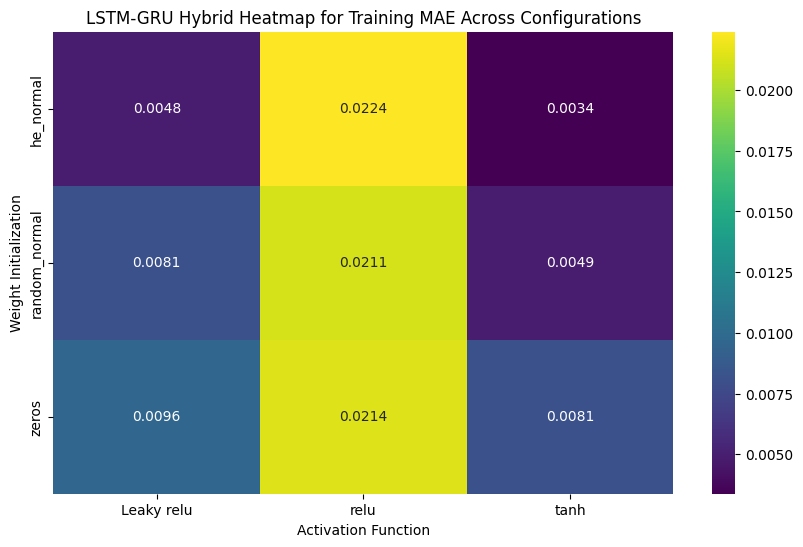

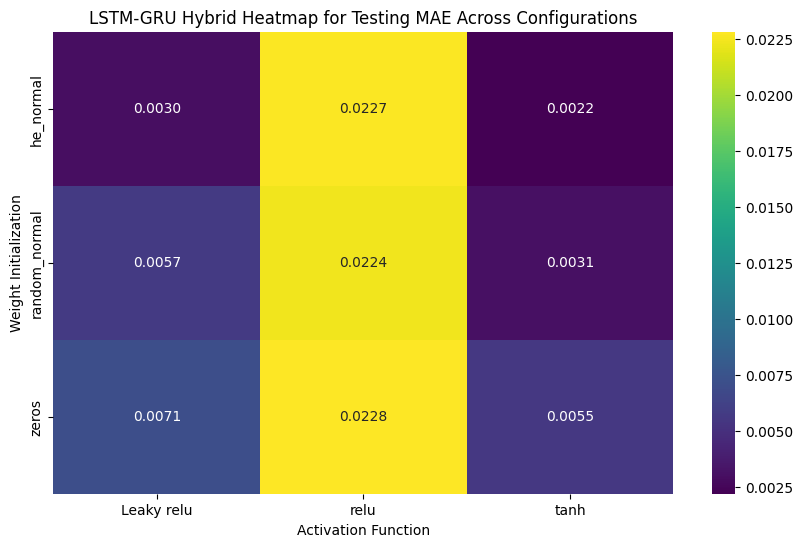

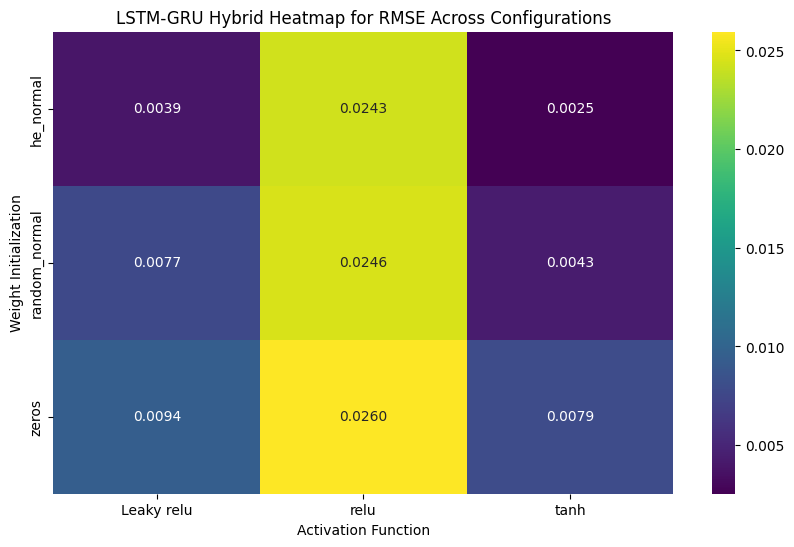

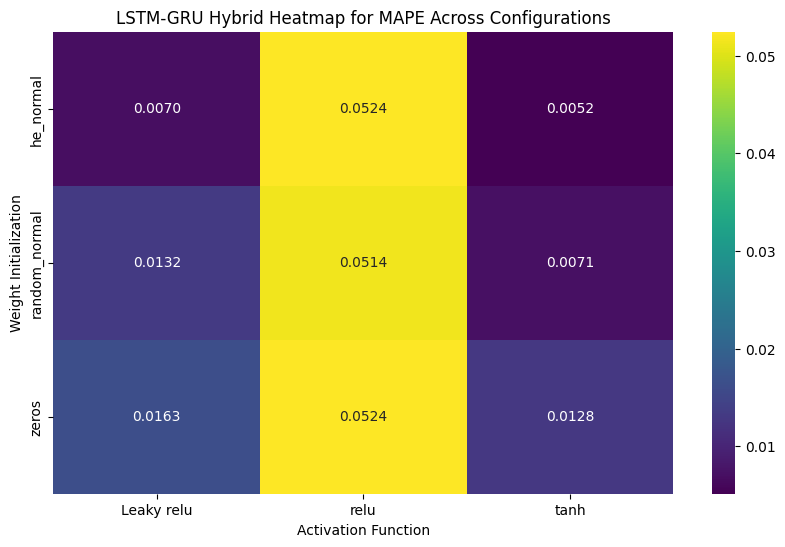

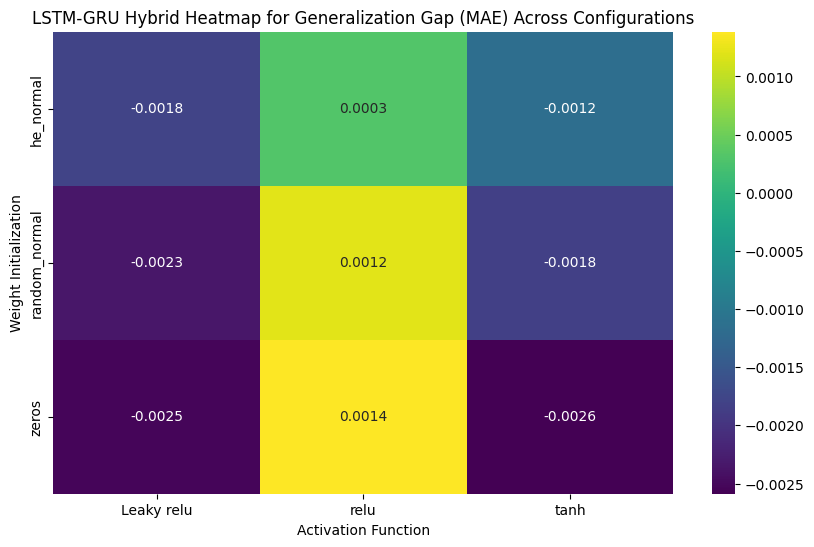

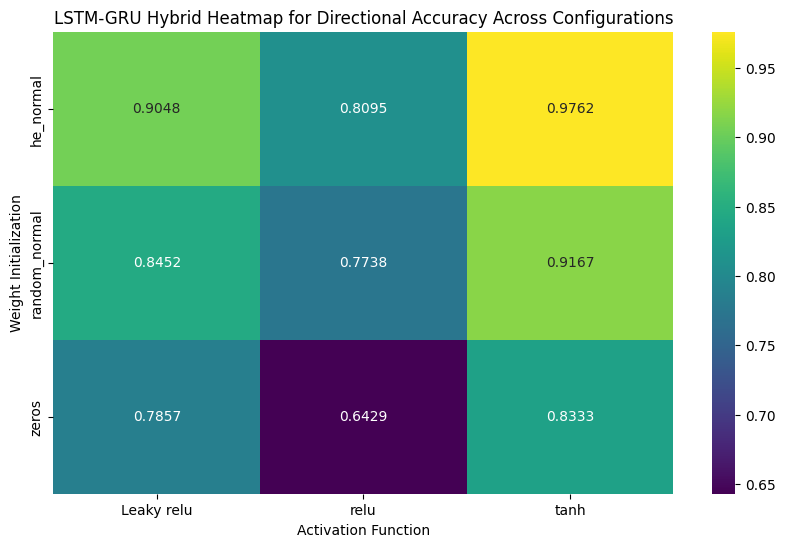

In [ ]:
# ----------------- LSTM-GRU Hybrid Model -----------------
import os
import pandas as pd
import numpy as np
from google.colab import drive
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from tensorflow.keras.initializers import RandomNormal, Zeros, HeNormal
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Custom weight initializer for zeros with noise
from tensorflow.keras.initializers import Initializer
import tensorflow.keras.backend as K

class ZerosWithNoise(Initializer):
    def __init__(self, noise_level=1e-5):
        self.noise_level = noise_level

    def __call__(self, shape, dtype=None):
        return K.random_uniform(shape, minval=-self.noise_level, maxval=self.noise_level, dtype=dtype)

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Define file paths
root_dir = '/content/drive/My Drive/RNNs For Stock Prediction - 1906525'
data_dir = os.path.join(root_dir, 'data/cleaned')
train_file_path = os.path.join(data_dir, 'train_cleaned.csv')
validation_file_path = os.path.join(data_dir, 'validation_cleaned.csv')
test_file_path = os.path.join(data_dir, 'test_cleaned.csv')

# Load the cleaned data
train_data = pd.read_csv(train_file_path)
validation_data = pd.read_csv(validation_file_path)
test_data = pd.read_csv(test_file_path)

# Prepare data for the model
features = ['Close', 'Volume'] + [f'Close_lag{i}' for i in range(1, 6)]
target = 'Close'

X_train = train_data[features].values
y_train = train_data[target].values

X_val = validation_data[features].values
y_val = validation_data[target].values

X_test = test_data[features].values
y_test = test_data[target].values

# Save original y_test for later use
y_test_orig = y_test.copy()

# Scale features
from sklearn.preprocessing import MinMaxScaler

# Create scalers
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

# Fit scalers on training data
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))

# Transform validation and test data
X_val_scaled = scaler_X.transform(X_val)
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1))
X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

# Reshape data for RNN
X_train = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_val = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))
X_test_full = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))  # For full evaluation

y_train = y_train_scaled
y_val = y_val_scaled
y_test_full = y_test_scaled  # For full evaluation

# Directory to save results
results_dir = os.path.join(root_dir, 'results')
os.makedirs(results_dir, exist_ok=True)

results = []

# Initialize hyperparameter index and prediction results
hyperparameter_index = 0
prediction_results = []

# Cosine annealing learning rate function
def cosine_annealing(epoch, lr_max=0.001, lr_min=1e-6, T_max=40):
    return lr_min + 0.5 * (lr_max - lr_min) * (1 + math.cos(math.pi * epoch / T_max))

# Experiment loop
activation_functions = ['relu', 'tanh', 'Leaky relu']
weight_initializations = ['random_normal', 'zeros', 'he_normal']
epochs_list = [10, 20, 30, 40, 50, 100]

for activation_function in activation_functions:
    for weight_initialization in weight_initializations:
        for epochs in epochs_list:
            # Adjust T_max for the learning rate scheduler based on epochs
            def cosine_annealing(epoch, lr_max=0.001, lr_min=1e-6, T_max=epochs):
                return lr_min + 0.5 * (lr_max - lr_min) * (1 + math.cos(math.pi * epoch / T_max))

            # Define the LSTM-GRU Hybrid model
            model = Sequential()

            # Use custom initializer for 'zeros' to add small noise
            if weight_initialization == 'zeros':
                weight_initializer = ZerosWithNoise()
            else:
                weight_initializer = weight_initialization

            # LSTM Layer
            model.add(LSTM(64, kernel_initializer=weight_initializer,
                           input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))

            # GRU Layer
            model.add(GRU(64, kernel_initializer=weight_initializer, return_sequences=False))

            # Handle activation functions
            if activation_function == 'Leaky relu':
                model.add(LeakyReLU(alpha=0.2))  # Add LeakyReLU with alpha
                model.add(Dropout(0.3))  # Add dropout for regularization
                model.add(Dense(32))  # No activation for LeakyReLU
            else:
                model.add(Dense(64, activation=activation_function))
                model.add(Dropout(0.3))  # Add dropout for regularization
                model.add(Dense(32, activation=activation_function))

            model.add(Dense(1))  # Output layer

            # Compile the model with gradient clipping and MAE loss
            model.compile(optimizer=Adam(clipnorm=1.0), loss='mean_absolute_error', metrics=['mae'])

            # Define callbacks
            reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5,
                                          min_lr=1e-6, verbose=1)
            lr_scheduler = LearningRateScheduler(cosine_annealing)
            early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

            # Train the model
            history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                                epochs=epochs, batch_size=32, verbose=2,
                                callbacks=[reduce_lr, lr_scheduler, early_stopping])

            # Evaluate the model on full test set (retain original functionality)
            test_loss, test_mae = model.evaluate(X_test_full, y_test_full, verbose=2)

            # Predict and inverse transform on full test set
            y_pred_full = model.predict(X_test_full, verbose=0)
            y_pred_full_inverse = scaler_y.inverse_transform(y_pred_full)
            y_test_full_actual = scaler_y.inverse_transform(y_test_full)

            # Calculate additional metrics on full test set
            train_loss, train_mae = model.evaluate(X_train, y_train, verbose=0)
            rmse = np.sqrt(mean_squared_error(y_test_full_actual, y_pred_full_inverse))
            mape = mean_absolute_percentage_error(y_test_full_actual, y_pred_full_inverse)
            try:
                correlation_coefficient, _ = pearsonr(y_test_full_actual.flatten(), y_pred_full_inverse.flatten())
            except Exception:
                correlation_coefficient = np.nan  # Assign NaN if correlation cannot be computed

            directional_accuracy = np.mean(
                (np.sign(y_test_full_actual[1:] - y_test_full_actual[:-1]) == np.sign(y_pred_full_inverse[1:] - y_pred_full_inverse[:-1])).astype(int))
            generalization_gap_mae = test_mae - train_mae

            # Store results (retain original functionality)
            results.append({
                'Activation Function': activation_function,
                'Weight Initialization': weight_initialization,
                'Epochs': epochs,
                'Training MAE': train_mae,
                'Testing MAE': test_mae,
                'Correlation Coefficient': correlation_coefficient,
                'Directional Accuracy': directional_accuracy,
                'RMSE': rmse,
                'MAPE': mape,
                'Generalization Gap (MAE)': generalization_gap_mae
            })

            # ----------------- Testing Part Integration -----------------
            # Get the index of the test data row
            idx = hyperparameter_index % len(test_data)

            # Get the test data row
            test_row = test_data.iloc[idx]

            # Extract features
            X_test_row = test_row[features].values.reshape(1, -1)

            # Scale features
            X_test_row_scaled = scaler_X.transform(X_test_row)

            # Reshape for model
            X_test_row_scaled = X_test_row_scaled.reshape((1, 1, X_test_row_scaled.shape[1]))

            # Make prediction
            y_pred_row = model.predict(X_test_row_scaled, verbose=0)

            # Inverse transform prediction
            y_pred_row = scaler_y.inverse_transform(y_pred_row)

            # Get actual Close value
            y_test_row_actual = test_row[target]

            # Collect Open, High, Low, Volume, Date
            Open = test_row['Open']
            High = test_row['High']
            Low = test_row['Low']
            Volume = test_row['Volume']
            Date = test_row['Date']

            # Calculate Difference
            Difference = y_pred_row[0][0] - y_test_row_actual

            # Compute MSE for the single data point
            MSE = Difference ** 2

            # Append to prediction_results
            prediction_results.append({
                'Date': Date,
                'Open': Open,
                'High': High,
                'Low': Low,
                'Volume': Volume,
                'Close (Actual)': y_test_row_actual,
                'Close (Predicted)': y_pred_row[0][0],
                'Difference': Difference,
                'Activation Function': activation_function,
                'Weight Initialization': weight_initialization,
                'Epochs': epochs,
                'MSE': MSE,
            })

            # Increment hyperparameter index
            hyperparameter_index += 1

# Save results to CSV
results_df = pd.DataFrame(results)
results_csv_path = os.path.join(results_dir, 'LSTM_GRU_Hybrid_results_Final.csv')
results_df.to_csv(results_csv_path, index=False)

# Reorder columns in prediction_results
columns_order = ['Date', 'Open', 'High', 'Low', 'Volume', 'Close (Actual)', 'Close (Predicted)', 'Difference',
                 'Activation Function', 'Weight Initialization', 'Epochs', 'MSE']
prediction_results_df = pd.DataFrame(prediction_results)[columns_order]

# Save prediction results to CSV
prediction_results_csv_path = os.path.join(results_dir, 'LSTM_GRU_Hybrid_Testing_PredVsAct.csv')
prediction_results_df.to_csv(prediction_results_csv_path, index=False)

# Heatmap Visualization
metrics = ['Training MAE', 'Testing MAE', 'RMSE', 'MAPE', 'Generalization Gap (MAE)', 'Directional Accuracy']
for metric in metrics:
    heatmap_data = results_df.pivot_table(index='Weight Initialization', columns='Activation Function',
                                          values=metric, aggfunc='mean')
    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap_data, annot=True, cmap='viridis', fmt='.4f')
    plt.title(f'LSTM-GRU Hybrid Heatmap for {metric} Across Configurations')
    plt.show()
